In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, GRU, CuDNNLSTM
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
# Load data
df01 =  pd.read_csv("cleansed_date01.csv")
pd.options.display.max_columns = None

In [3]:
df01

Transaction Date            ATM Name  No Of Withdrawals  \
0           2011-01-01      Mount Road ATM                253   
1           2011-01-01      Big Street ATM                 50   
2           2011-01-01         Airport ATM                 98   
3           2011-01-01        KK Nagar ATM                265   
4           2011-01-01  Christ College ATM                 74   
...                ...                 ...                ...   
11584       2017-09-29         Airport ATM                117   
11585       2017-09-29  Christ College ATM                143   
11586       2017-09-29      Big Street ATM                137   
11587       2017-09-29      Mount Road ATM                 79   
11588       2017-09-29        KK Nagar ATM                 76   

       No Of XYZ Card Withdrawals  No Of Other Card Withdrawals  \
0                              67                           186   
1                              20                            30   
2                              56                            42   
3                             159                           106   
4                              25                            49   
...                           ...                           ...   
11584                          77                            40   
11585                          61                            82   
11586                          34                           103   
11587                          27                            52   
11588                          48                            28   

       Total amount Withdrawn  Amount withdrawn XYZ Card  \
0                      767900                     270900   
1                      123800                      41700   
2                      503400                     347700   
3                      945300                     532600   
4                      287700                     148200   
...                       ...                        ...   
11584                  709900                     576800   
11585                  700400                     364200   
11586                  468800                     146200   
11587                  305100                     172500   
11588                  408700                     279900   

       Amount withdrawn Other Card   Weekday Festival Religion Working Day  \
0                           497000  Saturday                 C           H   
1                            82100  Saturday                 H           H   
2                           155700  Saturday                 C           H   
3                           412700  Saturday                 C           H   
4                           139500  Saturday                 C           H   
...                            ...       ...               ...         ...   
11584                       133100    FRIDAY                 H           H   
11585                       336200    FRIDAY                 H           H   
11586                       322600    FRIDAY                 H           H   
11587                       132600    FRIDAY                 H           H   
11588                       128800    FRIDAY                 H           H   

      Holiday Sequence  
0                  WHH  
1                  WHH  
2                  WHH  
3                  WHH  
4                  WHH  
...                ...  
11584              WHH  
11585              WHH  
11586              WHH  
11587              WHH  
11588              WHH  

[11589 rows x 12 columns]

In [4]:
# Convert Transaction Date into Date form
df01['Transaction Date'] = pd.to_datetime(df01['Transaction Date'], infer_datetime_format=True)

In [5]:
df01 = df01[(df01["ATM Name"]=="Big Street ATM")]

In [6]:
df01 = df01.drop('ATM Name', 1)

In [7]:
df01["Weekday"] = df01["Weekday"].replace({"Saturday": "SATURDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Monday": "MONDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Tuesday": "TUESDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Wednesday": "WEDNESDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Thursday": "THURSDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Friday": "FRIDAY"})
df01["Weekday"] = df01["Weekday"].replace({"Sunday": "SUNDAY"})

In [8]:
df01["Weekday"].value_counts()

SUNDAY       549
SATURDAY     334
TUESDAY      305
MONDAY       295
WEDNESDAY    294
THURSDAY     289
FRIDAY       288
Name: Weekday, dtype: int64

In [9]:
# Transnform date into index
data = df01.drop(['Transaction Date'], axis=1)
data.index = df01["Transaction Date"]

In [10]:
data = data.sort_index()

In [11]:
df01 = data

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [13]:
df01['Weekday'] = le.fit_transform(df01['Weekday'])

In [14]:
df01['Festival Religion'] = le.fit_transform(df01['Festival Religion'])

In [15]:
df01['Working Day'] = le.fit_transform(df01['Working Day'])

In [16]:
df01['Holiday Sequence'] = le.fit_transform(df01['Holiday Sequence'])

In [17]:
df01

No Of Withdrawals  No Of XYZ Card Withdrawals  \
Transaction Date                                                  
2011-01-01                       50                          20   
2011-01-02                       17                           5   
2011-01-03                       24                          21   
2011-01-04                       34                          12   
2011-01-05                       30                          14   
...                             ...                         ...   
2017-09-25                      122                          41   
2017-09-26                      131                          36   
2017-09-27                      130                          40   
2017-09-28                      137                          41   
2017-09-29                      137                          34   

                  No Of Other Card Withdrawals  Total amount Withdrawn  \
Transaction Date                                                         
2011-01-01                                  30                  123800   
2011-01-02                                  12                   52800   
2011-01-03                                   3                   88100   
2011-01-04                                  22                  101600   
2011-01-05                                  16                   98000   
...                                        ...                     ...   
2017-09-25                                  81                  513800   
2017-09-26                                  95                  437400   
2017-09-27                                  90                  511200   
2017-09-28                                  96                  468600   
2017-09-29                                 103                  468800   

                  Amount withdrawn XYZ Card  Amount withdrawn Other Card  \
Transaction Date                                                           
2011-01-01                            41700                        82100   
2011-01-02                            20900                        31900   
2011-01-03                            77100                        11000   
2011-01-04                            51200                        50400   
2011-01-05                            52700                        45300   
...                                     ...                          ...   
2017-09-25                           283000                       230800   
2017-09-26                           162700                       274700   
2017-09-27                           215000                       296200   
2017-09-28                           221800                       246800   
2017-09-29                           146200                       322600   

                  Weekday  Festival Religion  Working Day  Holiday Sequence  
Transaction Date                                                             
2011-01-01              2                  1            0                 4  
2011-01-02              3                  4            0                 1  
2011-01-03              1                  4            1                 7  
2011-01-04              5                  4            1                 7  
2011-01-05              6                  4            1                 7  
...                   ...                ...          ...               ...  
2017-09-25              1                  4            1                 3  
2017-09-26              5                  4            1                 7  
2017-09-27              6                  4            1                 7  
2017-09-28              4                  4            1                 6  
2017-09-29              0                  1            0                 4  

[2354 rows x 10 columns]

In [18]:
df02 = df01

In [19]:
df02 = df02.drop('No Of Withdrawals', 1)

In [20]:
df02 = df02.drop('Amount withdrawn Other Card', 1)

In [21]:
df02 = df02.drop('No Of XYZ Card Withdrawals', 1)

In [22]:
df02 = df02.drop('No Of Other Card Withdrawals', 1)

In [23]:
df02 = df02.drop('Amount withdrawn XYZ Card', 1)

In [24]:
df02

Total amount Withdrawn  Weekday  Festival Religion  \
Transaction Date                                                       
2011-01-01                        123800        2                  1   
2011-01-02                         52800        3                  4   
2011-01-03                         88100        1                  4   
2011-01-04                        101600        5                  4   
2011-01-05                         98000        6                  4   
...                                  ...      ...                ...   
2017-09-25                        513800        1                  4   
2017-09-26                        437400        5                  4   
2017-09-27                        511200        6                  4   
2017-09-28                        468600        4                  4   
2017-09-29                        468800        0                  1   

                  Working Day  Holiday Sequence  
Transaction Date                                 
2011-01-01                  0                 4  
2011-01-02                  0                 1  
2011-01-03                  1                 7  
2011-01-04                  1                 7  
2011-01-05                  1                 7  
...                       ...               ...  
2017-09-25                  1                 3  
2017-09-26                  1                 7  
2017-09-27                  1                 7  
2017-09-28                  1                 6  
2017-09-29                  0                 4  

[2354 rows x 5 columns]

In [25]:
df02.dtypes[:]

Total amount Withdrawn    int64
Weekday                   int32
Festival Religion         int32
Working Day               int32
Holiday Sequence          int32
dtype: object

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
columns_to_category = ['Total amount Withdrawn','Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence']
df02[columns_to_category] = scaler.fit_transform(df02[columns_to_category])

In [28]:
df02

Total amount Withdrawn   Weekday  Festival Religion  \
Transaction Date                                                        
2011-01-01                      0.133492  0.333333               0.25   
2011-01-02                      0.056810  0.500000               1.00   
2011-01-03                      0.094935  0.166667               1.00   
2011-01-04                      0.109515  0.833333               1.00   
2011-01-05                      0.105627  1.000000               1.00   
...                                  ...       ...                ...   
2017-09-25                      0.554704  0.166667               1.00   
2017-09-26                      0.472189  0.833333               1.00   
2017-09-27                      0.551895  1.000000               1.00   
2017-09-28                      0.505886  0.666667               1.00   
2017-09-29                      0.506102  0.000000               0.25   

                  Working Day  Holiday Sequence  
Transaction Date                                 
2011-01-01                0.0          0.571429  
2011-01-02                0.0          0.142857  
2011-01-03                1.0          1.000000  
2011-01-04                1.0          1.000000  
2011-01-05                1.0          1.000000  
...                       ...               ...  
2017-09-25                1.0          0.428571  
2017-09-26                1.0          1.000000  
2017-09-27                1.0          1.000000  
2017-09-28                1.0          0.857143  
2017-09-29                0.0          0.571429  

[2354 rows x 5 columns]

# Reshaping data

In [29]:
train_size = 0.8 # Use 70 % of the data as the train set, this is so it's easy to display in this notebook
target_column = 1 # the column index value of the target column

split_idx = int(df02.shape[0]*train_size) # index nummer to split at
split_idx

1883

In [30]:
# ...train
X_train = df02.values[:split_idx, target_column:]
y_train = df02.values[:split_idx, :target_column]

# ...test
X_test = df02.values[split_idx:, target_column:]
y_test = df02.values[split_idx:, :target_column]

In [31]:
X_train

array([[0.33333333, 0.25      , 0.        , 0.57142857],
       [0.5       , 1.        , 0.        , 0.14285714],
       [0.16666667, 1.        , 1.        , 1.        ],
       ...,
       [0.5       , 1.        , 0.        , 0.14285714],
       [0.16666667, 1.        , 1.        , 0.42857143],
       [0.83333333, 1.        , 1.        , 1.        ]])

In [32]:
X_train.shape # 1647 rows by 4 columns

(1883, 4)

In [33]:
X_test.shape

(471, 4)

In [34]:
y_train

array([[0.13349174],
       [0.05680959],
       [0.09493466],
       ...,
       [0.65395831],
       [0.60287288],
       [0.50469813]])

In [35]:
# Define variables
look_back = 10 # look back 10 steps
num_features = 4 # using 4 feautures
output_dim = 1 # to predict 1 y value

In [36]:
samples = len(X_train) # total amount of samples
samples

1883

In [37]:
samples_train = X_train.shape[0] - look_back 
samples_train

1873

In [38]:
# Define zeros array with the target shape
X_train_reshaped = np.zeros((samples_train, look_back, num_features))
y_train_reshaped = np.zeros((samples_train))
X_train_reshaped.shape

(1873, 10, 4)

In [39]:
X_train_reshaped

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [40]:
# Create the reshaped train data
for i in range(samples_train):
    y_position = i + look_back
    X_train_reshaped[i] = X_train[i:y_position]
    y_train_reshaped[i] = y_train[y_position]

In [41]:
X_train_reshaped.shape

(1873, 10, 4)

In [42]:
y_train_reshaped

array([0.12063938, 0.04590129, 0.08748245, ..., 0.65395831, 0.60287288,
       0.50469813])

In [43]:
X_train_reshaped

array([[[0.33333333, 0.25      , 0.        , 0.57142857],
        [0.5       , 1.        , 0.        , 0.14285714],
        [0.16666667, 1.        , 1.        , 1.        ],
        ...,
        [0.33333333, 1.        , 0.        , 0.57142857],
        [0.5       , 1.        , 0.        , 0.14285714],
        [0.16666667, 1.        , 1.        , 0.42857143]],

       [[0.5       , 1.        , 0.        , 0.14285714],
        [0.16666667, 1.        , 1.        , 1.        ],
        [0.83333333, 1.        , 1.        , 1.        ],
        ...,
        [0.5       , 1.        , 0.        , 0.14285714],
        [0.16666667, 1.        , 1.        , 0.42857143],
        [0.83333333, 1.        , 1.        , 1.        ]],

       [[0.16666667, 1.        , 1.        , 1.        ],
        [0.83333333, 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ],
        ...,
        [0.16666667, 1.        , 1.        , 0.42857143],
        [0.83333333, 1.      

In [44]:
X_train

array([[0.33333333, 0.25      , 0.        , 0.57142857],
       [0.5       , 1.        , 0.        , 0.14285714],
       [0.16666667, 1.        , 1.        , 1.        ],
       ...,
       [0.5       , 1.        , 0.        , 0.14285714],
       [0.16666667, 1.        , 1.        , 0.42857143],
       [0.83333333, 1.        , 1.        , 1.        ]])

In [45]:
y_train

array([[0.13349174],
       [0.05680959],
       [0.09493466],
       ...,
       [0.65395831],
       [0.60287288],
       [0.50469813]])

In [46]:
y_train_reshaped

array([0.12063938, 0.04590129, 0.08748245, ..., 0.65395831, 0.60287288,
       0.50469813])

In [47]:
# Do the same for the test data
samples_test = X_test.shape[0] - look_back
X_test_reshaped = np.zeros((samples_test, look_back, num_features))
y_test_reshaped = np.zeros((samples_test))

for i in range(samples_test):
    y_position = i + look_back
    X_test_reshaped[i] = X_test[i:y_position]
    y_test_reshaped[i] = y_test[y_position]

In [48]:
X_test_reshaped

array([[[1.        , 1.        , 1.        , 1.        ],
        [0.66666667, 1.        , 1.        , 0.85714286],
        [0.        , 0.        , 0.        , 0.57142857],
        ...,
        [0.66666667, 1.        , 1.        , 1.        ],
        [0.33333333, 1.        , 0.        , 0.57142857],
        [0.5       , 1.        , 0.        , 0.14285714]],

       [[0.66666667, 1.        , 1.        , 0.85714286],
        [0.        , 0.        , 0.        , 0.57142857],
        [0.33333333, 1.        , 0.        , 0.        ],
        ...,
        [0.33333333, 1.        , 0.        , 0.57142857],
        [0.5       , 1.        , 0.        , 0.14285714],
        [0.16666667, 1.        , 1.        , 0.42857143]],

       [[0.        , 0.        , 0.        , 0.57142857],
        [0.33333333, 1.        , 0.        , 0.        ],
        [0.5       , 1.        , 0.        , 0.14285714],
        ...,
        [0.5       , 1.        , 0.        , 0.14285714],
        [0.16666667, 1.      

In [49]:
X_test

array([[1.        , 1.        , 1.        , 1.        ],
       [0.66666667, 1.        , 1.        , 0.85714286],
       [0.        , 0.        , 0.        , 0.57142857],
       ...,
       [1.        , 1.        , 1.        , 1.        ],
       [0.66666667, 1.        , 1.        , 0.85714286],
       [0.        , 0.25      , 0.        , 0.57142857]])

In [50]:
y_test_reshaped

array([5.18846528e-01, 5.25866724e-01, 6.20261367e-01, 4.54800734e-01,
       1.13403175e-02, 4.31688087e-01, 2.34690571e-01, 5.10206286e-01,
       6.82687115e-01, 7.06987796e-01, 1.55956367e-01, 4.88713684e-01,
       4.06739389e-01, 6.94567448e-01, 5.57511610e-01, 4.77481369e-01,
       2.98304353e-01, 5.91532563e-01, 4.83745545e-01, 8.10022681e-02,
       2.54779134e-01, 4.73593261e-01, 4.11707528e-01, 3.29409223e-01,
       3.30597257e-01, 5.33318933e-01, 4.26935954e-01, 3.67426288e-01,
       3.37401447e-01, 2.29506426e-01, 2.79295820e-01, 3.17636894e-01,
       4.95085862e-01, 6.50178205e-01, 6.80419052e-01, 4.54044713e-01,
       3.44529647e-01, 3.78118587e-01, 4.59984880e-01, 2.63203370e-01,
       4.74025273e-01, 4.88929690e-01, 4.06631386e-01, 4.46376499e-01,
       6.45210066e-01, 2.26266335e-01, 3.69154336e-01, 5.13014364e-01,
       4.92709796e-01, 3.64402203e-01, 3.46797710e-01, 3.17528891e-01,
       5.24462685e-01, 4.69489146e-01, 5.99200778e-01, 8.60352090e-01,
      

In [51]:
split_index = int(df02.shape[0]*train_size)

X_train_values = df02[:split_index] # get the datetime values of X_train
X_test_values = df02[split_index:] # get the datetime values of X_train

In [52]:
X_train = X_train_reshaped  
y_train = y_train_reshaped 
X_test = X_test_reshaped
y_test = y_test_reshaped

In [53]:
X_train_values.shape, y_train.shape

((1883, 5), (1873,))

In [54]:
X_test_values.shape, y_test.shape

((471, 5), (461,))

In [55]:
datetime_difference = len(X_train_values) - len(y_train)
X_train_values = X_train_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_train_values.shape, y_train.shape

datetime_difference = len(X_test_values) - len(y_test)
X_test_values = X_test_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_test_values.shape, y_test.shape

((461, 5), (461,))

In [56]:
X_train_values

Total amount Withdrawn   Weekday  Festival Religion  \
Transaction Date                                                        
2011-01-11                      0.120639  0.833333               1.00   
2011-01-12                      0.045901  1.000000               1.00   
2011-01-13                      0.087482  0.666667               1.00   
2011-01-14                      0.098175  0.000000               1.00   
2011-01-15                      0.124959  0.333333               0.25   
...                                  ...       ...                ...   
2016-03-18                      0.476293  0.000000               1.00   
2016-03-19                      0.294632  0.333333               1.00   
2016-03-20                      0.653958  0.500000               1.00   
2016-03-21                      0.602873  0.166667               1.00   
2016-03-22                      0.504698  0.833333               1.00   

                  Working Day  Holiday Sequence  
Transaction Date                                 
2011-01-11                1.0          1.000000  
2011-01-12                1.0          1.000000  
2011-01-13                1.0          1.000000  
2011-01-14                1.0          0.857143  
2011-01-15                0.0          0.571429  
...                       ...               ...  
2016-03-18                1.0          0.857143  
2016-03-19                0.0          0.571429  
2016-03-20                0.0          0.142857  
2016-03-21                1.0          0.428571  
2016-03-22                1.0          1.000000  

[1873 rows x 5 columns]

C:\Users\LENOVO\Anaconda3\envs\sam\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


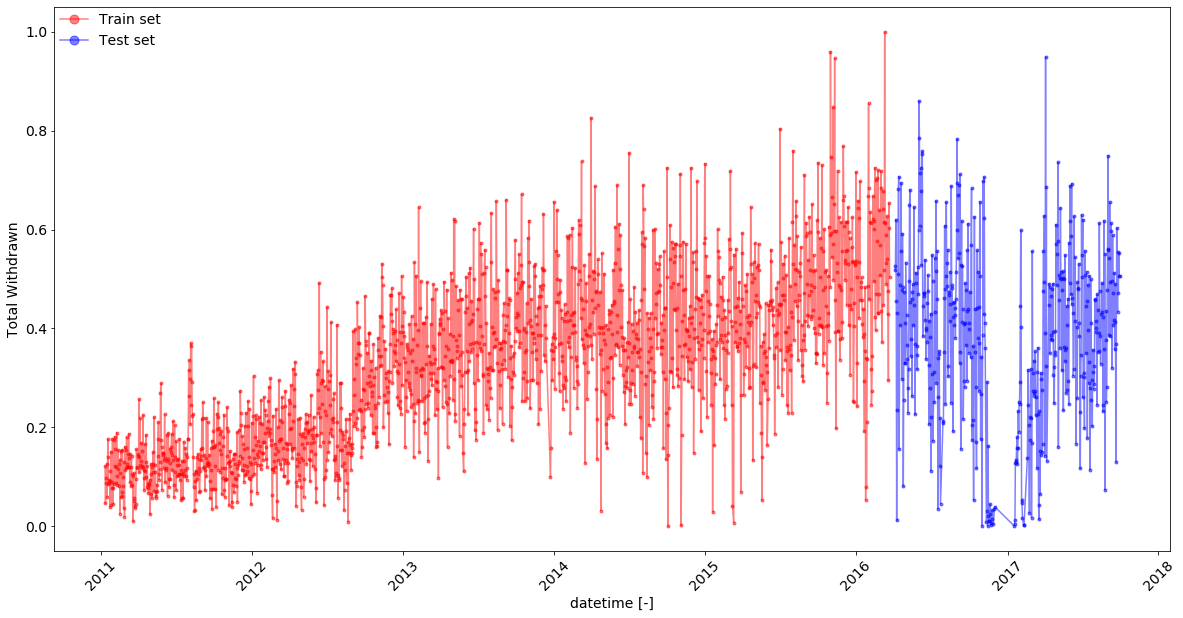

In [57]:
plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'Total Withdrawn' , fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

## Build Model

In [163]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss = ['mse'], metrics=['mape', 'mse'])
model.fit(X_train, y_train, epochs = 100, batch_size = 10)

Epoch 1/100
1873/1873 [==============================] - 6s 3ms/step - loss: 0.0326 - mean_absolute_percentage_error: 176202.2944 - mean_squared_error: 0.0326
Epoch 2/100
1873/1873 [==============================] - 4s 2ms/step - loss: 0.0266 - mean_absolute_percentage_error: 201416.9441 - mean_squared_error: 0.0266
Epoch 3/100
1873/1873 [==============================] - 4s 2ms/step - loss: 0.0257 - mean_absolute_percentage_error: 172276.4752 - mean_squared_error: 0.0257
Epoch 4/100
1873/1873 [==============================] - 4s 2ms/step - loss: 0.0254 - mean_absolute_percentage_error: 182129.8584 - mean_squared_error: 0.0254
Epoch 5/100
1873/1873 [==============================] - 4s 2ms/step - loss: 0.0255 - mean_absolute_percentage_error: 167497.4495 - mean_squared_error: 0.0255
Epoch 6/100
1873/1873 [==============================] - 4s 2ms/step - loss: 0.0256 - mean_absolute_percentage_error: 169852.3651 - mean_squared_error: 0.0256
Epoch 7/100
1873/1873 [=======================

In [86]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss = ['mse'], metrics=['mape', 'mse'])
model.fit(X_train, y_train, epochs = 200, batch_size = 10)

Epoch 1/200
1873/1873 [==============================] - 5s 3ms/step - loss: 0.0400 - mean_absolute_percentage_error: 165268.6111 - mean_squared_error: 0.0400
Epoch 2/200
1873/1873 [==============================] - 4s 2ms/step - loss: 0.0260 - mean_absolute_percentage_error: 175291.5528 - mean_squared_error: 0.0260
Epoch 3/200
1873/1873 [==============================] - 4s 2ms/step - loss: 0.0259 - mean_absolute_percentage_error: 181694.8412 - mean_squared_error: 0.0259
Epoch 4/200
1873/1873 [==============================] - 4s 2ms/step - loss: 0.0258 - mean_absolute_percentage_error: 194336.1062 - mean_squared_error: 0.0258
Epoch 5/200
1873/1873 [==============================] - 4s 2ms/step - loss: 0.0257 - mean_absolute_percentage_error: 165599.0707 - mean_squared_error: 0.0257
Epoch 6/200
1873/1873 [==============================] - 4s 2ms/step - loss: 0.0257 - mean_absolute_percentage_error: 174587.2737 - mean_squared_error: 0.0257
Epoch 7/200
1873/1873 [=======================

In [158]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss = ['mse'], metrics=['mape', 'mse'])
model.fit(X_train, y_train, epochs = 500, batch_size = 5)

Epoch 1/500
1873/1873 [==============================] - 10s 6ms/step - loss: 0.0274 - mean_absolute_percentage_error: 181087.9772 - mean_squared_error: 0.0274
Epoch 2/500
1873/1873 [==============================] - 9s 5ms/step - loss: 0.0261 - mean_absolute_percentage_error: 158226.7669 - mean_squared_error: 0.0261
Epoch 3/500
1873/1873 [==============================] - 9s 5ms/step - loss: 0.0263 - mean_absolute_percentage_error: 149197.0426 - mean_squared_error: 0.0263
Epoch 4/500
1873/1873 [==============================] - 9s 5ms/step - loss: 0.0258 - mean_absolute_percentage_error: 183466.7835 - mean_squared_error: 0.0258
Epoch 5/500
1873/1873 [==============================] - 9s 5ms/step - loss: 0.0254 - mean_absolute_percentage_error: 138645.9322 - mean_squared_error: 0.0254
Epoch 6/500
1873/1873 [==============================] - 9s 5ms/step - loss: 0.0256 - mean_absolute_percentage_error: 159777.6088 - mean_squared_error: 0.0256
Epoch 7/500
1873/1873 [======================

In [58]:
model = Sequential()
model.add(LSTM(300, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss = ['mse'], metrics=['mape', 'mse'])
model.fit(X_train, y_train, epochs = 350, batch_size = 5)


Epoch 1/350


1505/1873 [=======================>......] - ETA: 2:23 - loss: 0.4034 - mape: 129.5983 - mse: 0.40 - ETA: 1:21 - loss: 0.2435 - mape: 100.6713 - mse: 0.24 - ETA: 46s - loss: 0.1569 - mape: 118.2641 - mse: 0.1569 - ETA: 34s - loss: 0.1304 - mape: 116.9343 - mse: 0.130 - ETA: 28s - loss: 0.1060 - mape: 126.9519 - mse: 0.106 - ETA: 24s - loss: 0.0898 - mape: 114.5308 - mse: 0.089 - ETA: 21s - loss: 0.0815 - mape: 101.5904 - mse: 0.081 - ETA: 20s - loss: 0.0824 - mape: 95.3250 - mse: 0.082 - ETA: 18s - loss: 0.0776 - mape: 88.4780 - mse: 0.07 - ETA: 17s - loss: 0.0751 - mape: 84.8930 - mse: 0.07 - ETA: 17s - loss: 0.0700 - mape: 85.2872 - mse: 0.07 - ETA: 16s - loss: 0.0662 - mape: 83.8834 - mse: 0.06 - ETA: 15s - loss: 0.0626 - mape: 81.6095 - mse: 0.06 - ETA: 14s - loss: 0.0600 - mape: 80.9107 - mse: 0.06 - ETA: 14s - loss: 0.0586 - mape: 79.0878 - mse: 0.05 - ETA: 13s - loss: 0.0547 - mape: 75.6903 - mse: 0.05 - ETA: 13s - loss: 0.0528 - mape: 77.2968 - mse: 0.05 - ETA: 13s - loss: 0.05

1445/1873 [======================>.......] - ETA: 10s - loss: 0.0260 - mape: 78.8937 - mse: 0.02 - ETA: 11s - loss: 0.0247 - mape: 57.9025 - mse: 0.02 - ETA: 11s - loss: 0.0252 - mape: 72.9458 - mse: 0.02 - ETA: 11s - loss: 0.0224 - mape: 66.4656 - mse: 0.02 - ETA: 12s - loss: 0.0231 - mape: 57.2835 - mse: 0.02 - ETA: 12s - loss: 0.0220 - mape: 54.2866 - mse: 0.02 - ETA: 12s - loss: 0.0241 - mape: 55.7786 - mse: 0.02 - ETA: 11s - loss: 0.0232 - mape: 58.6799 - mse: 0.02 - ETA: 11s - loss: 0.0236 - mape: 65.7145 - mse: 0.02 - ETA: 11s - loss: 0.0233 - mape: 63.3548 - mse: 0.02 - ETA: 11s - loss: 0.0242 - mape: 67.5380 - mse: 0.02 - ETA: 11s - loss: 0.0240 - mape: 63.7955 - mse: 0.02 - ETA: 11s - loss: 0.0241 - mape: 65.2850 - mse: 0.02 - ETA: 11s - loss: 0.0239 - mape: 64.3573 - mse: 0.02 - ETA: 11s - loss: 0.0232 - mape: 62.2212 - mse: 0.02 - ETA: 10s - loss: 0.0239 - mape: 66.4869 - mse: 0.02 - ETA: 10s - loss: 0.0245 - mape: 71.1957 - mse: 0.02 - ETA: 10s - loss: 0.0248 - mape: 71.46

1873/1873 [==============================] - ETA: 2s - loss: 0.0259 - mape: 203892.7656 - mse: 0.025 - ETA: 2s - loss: 0.0259 - mape: 202501.3906 - mse: 0.025 - ETA: 2s - loss: 0.0259 - mape: 201129.4375 - mse: 0.025 - ETA: 2s - loss: 0.0261 - mape: 199776.4375 - mse: 0.026 - ETA: 2s - loss: 0.0260 - mape: 198440.5156 - mse: 0.026 - ETA: 2s - loss: 0.0261 - mape: 197122.7812 - mse: 0.026 - ETA: 2s - loss: 0.0261 - mape: 195821.8281 - mse: 0.026 - ETA: 2s - loss: 0.0263 - mape: 194538.2812 - mse: 0.026 - ETA: 2s - loss: 0.0262 - mape: 193272.1250 - mse: 0.026 - ETA: 1s - loss: 0.0262 - mape: 192021.6250 - mse: 0.026 - ETA: 1s - loss: 0.0262 - mape: 190787.3906 - mse: 0.026 - ETA: 1s - loss: 0.0263 - mape: 189569.0156 - mse: 0.026 - ETA: 1s - loss: 0.0263 - mape: 188366.0469 - mse: 0.026 - ETA: 1s - loss: 0.0263 - mape: 187178.0781 - mse: 0.026 - ETA: 1s - loss: 0.0264 - mape: 186004.8125 - mse: 0.026 - ETA: 1s - loss: 0.0264 - mape: 184846.5312 - mse: 0.026 - ETA: 1s - loss: 0.0263 - ma

1455/1873 [======================>.......] - ETA: 10s - loss: 0.0157 - mape: 50.5259 - mse: 0.01 - ETA: 11s - loss: 0.0242 - mape: 384.9443 - mse: 0.024 - ETA: 11s - loss: 0.0379 - mape: 287.5395 - mse: 0.037 - ETA: 11s - loss: 0.0357 - mape: 225.7797 - mse: 0.035 - ETA: 11s - loss: 0.0303 - mape: 184.6501 - mse: 0.030 - ETA: 11s - loss: 0.0289 - mape: 159.8027 - mse: 0.028 - ETA: 11s - loss: 0.0277 - mape: 143.5214 - mse: 0.027 - ETA: 10s - loss: 0.0273 - mape: 134.0729 - mse: 0.027 - ETA: 10s - loss: 0.0272 - mape: 131.5885 - mse: 0.027 - ETA: 10s - loss: 0.0272 - mape: 123.6784 - mse: 0.027 - ETA: 10s - loss: 0.0286 - mape: 130.0514 - mse: 0.028 - ETA: 10s - loss: 0.0283 - mape: 120.9408 - mse: 0.028 - ETA: 10s - loss: 0.0266 - mape: 113.0280 - mse: 0.026 - ETA: 10s - loss: 0.0263 - mape: 109.0406 - mse: 0.026 - ETA: 10s - loss: 0.0254 - mape: 104.0532 - mse: 0.025 - ETA: 10s - loss: 0.0252 - mape: 99.9710 - mse: 0.025 - ETA: 10s - loss: 0.0272 - mape: 97.2305 - mse: 0.02 - ETA: 10s

1420/1873 [=====================>........] - ETA: 10s - loss: 0.0171 - mape: 103.7522 - mse: 0.017 - ETA: 10s - loss: 0.0706 - mape: 72.9241 - mse: 0.070 - ETA: 10s - loss: 0.0502 - mape: 72.7053 - mse: 0.05 - ETA: 10s - loss: 0.0412 - mape: 59.9118 - mse: 0.04 - ETA: 10s - loss: 0.0382 - mape: 69.1599 - mse: 0.03 - ETA: 10s - loss: 0.0340 - mape: 63.9378 - mse: 0.03 - ETA: 10s - loss: 0.0339 - mape: 70.4048 - mse: 0.03 - ETA: 10s - loss: 0.0318 - mape: 69.1539 - mse: 0.03 - ETA: 10s - loss: 0.0297 - mape: 66.2301 - mse: 0.02 - ETA: 10s - loss: 0.0285 - mape: 66.3175 - mse: 0.02 - ETA: 10s - loss: 0.0298 - mape: 71.1222 - mse: 0.02 - ETA: 10s - loss: 0.0292 - mape: 71.4998 - mse: 0.02 - ETA: 10s - loss: 0.0284 - mape: 73.0224 - mse: 0.02 - ETA: 10s - loss: 0.0279 - mape: 72.1840 - mse: 0.02 - ETA: 9s - loss: 0.0268 - mape: 69.8866 - mse: 0.0268 - ETA: 9s - loss: 0.0266 - mape: 68.1856 - mse: 0.026 - ETA: 9s - loss: 0.0268 - mape: 66.7828 - mse: 0.026 - ETA: 9s - loss: 0.0262 - mape: 65

1873/1873 [==============================] - ETA: 2s - loss: 0.0261 - mape: 245076.4375 - mse: 0.026 - ETA: 2s - loss: 0.0262 - mape: 243374.9844 - mse: 0.026 - ETA: 2s - loss: 0.0263 - mape: 241697.1875 - mse: 0.026 - ETA: 2s - loss: 0.0262 - mape: 240042.0781 - mse: 0.026 - ETA: 2s - loss: 0.0261 - mape: 238409.3750 - mse: 0.026 - ETA: 2s - loss: 0.0262 - mape: 236799.1562 - mse: 0.026 - ETA: 2s - loss: 0.0261 - mape: 235210.1094 - mse: 0.026 - ETA: 2s - loss: 0.0261 - mape: 233642.6719 - mse: 0.026 - ETA: 2s - loss: 0.0261 - mape: 232095.9219 - mse: 0.026 - ETA: 2s - loss: 0.0262 - mape: 230569.5156 - mse: 0.026 - ETA: 2s - loss: 0.0263 - mape: 229063.4531 - mse: 0.026 - ETA: 1s - loss: 0.0263 - mape: 227576.6250 - mse: 0.026 - ETA: 1s - loss: 0.0263 - mape: 226108.9062 - mse: 0.026 - ETA: 1s - loss: 0.0263 - mape: 224660.0469 - mse: 0.026 - ETA: 1s - loss: 0.0263 - mape: 223229.7969 - mse: 0.026 - ETA: 1s - loss: 0.0264 - mape: 221817.7188 - mse: 0.026 - ETA: 1s - loss: 0.0264 - ma

1485/1873 [======================>.......] - ETA: 10s - loss: 0.0454 - mape: 47.6613 - mse: 0.04 - ETA: 10s - loss: 0.0405 - mape: 78.7979 - mse: 0.04 - ETA: 10s - loss: 0.0347 - mape: 81.3342 - mse: 0.03 - ETA: 10s - loss: 0.0287 - mape: 69.3165 - mse: 0.02 - ETA: 10s - loss: 0.0286 - mape: 64.0222 - mse: 0.02 - ETA: 10s - loss: 0.0306 - mape: 62.4241 - mse: 0.03 - ETA: 10s - loss: 0.0383 - mape: 63.0994 - mse: 0.03 - ETA: 10s - loss: 0.0355 - mape: 60.2773 - mse: 0.03 - ETA: 10s - loss: 0.0344 - mape: 62.1058 - mse: 0.03 - ETA: 10s - loss: 0.0322 - mape: 73.8805 - mse: 0.03 - ETA: 10s - loss: 0.0310 - mape: 71.1288 - mse: 0.03 - ETA: 10s - loss: 0.0294 - mape: 68.1175 - mse: 0.02 - ETA: 10s - loss: 0.0312 - mape: 76.1697 - mse: 0.03 - ETA: 10s - loss: 0.0315 - mape: 78.5519 - mse: 0.03 - ETA: 10s - loss: 0.0313 - mape: 95.6442 - mse: 0.03 - ETA: 10s - loss: 0.0301 - mape: 91.4139 - mse: 0.03 - ETA: 10s - loss: 0.0308 - mape: 90.7352 - mse: 0.03 - ETA: 10s - loss: 0.0298 - mape: 87.48

1510/1873 [=======================>......] - ETA: 10s - loss: 0.0087 - mape: 26.1026 - mse: 0.00 - ETA: 10s - loss: 0.0205 - mape: 91.0526 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 89.2406 - mse: 0.02 - ETA: 10s - loss: 0.0187 - mape: 72.7521 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 66.8278 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 60.1579 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 58.3835 - mse: 0.01 - ETA: 10s - loss: 0.0209 - mape: 63.9293 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 59.9263 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 61.0874 - mse: 0.01 - ETA: 10s - loss: 0.0209 - mape: 71.9483 - mse: 0.02 - ETA: 10s - loss: 0.0199 - mape: 68.4899 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 64.6219 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 64.7802 - mse: 0.01 - ETA: 10s - loss: 0.0197 - mape: 62.7969 - mse: 0.01 - ETA: 10s - loss: 0.0199 - mape: 66.0644 - mse: 0.01 - ETA: 9s - loss: 0.0190 - mape: 63.3988 - mse: 0.0190 - ETA: 9s - loss: 0.0202 - mape: 68.01

1873/1873 [==============================] - ETA: 2s - loss: 0.0253 - mape: 217891.2344 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 216468.3125 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 215062.8594 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 213675.7656 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 212306.2812 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 210954.4375 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 209619.4688 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 208301.5312 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 207000.0469 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 205714.7500 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 204445.3750 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 203191.3594 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 201952.6875 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 200729.1875 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 199520.3125 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 198326.3594 - mse: 0.025 - ETA: 1s - loss: 0.0251 - ma

1430/1873 [=====================>........] - ETA: 11s - loss: 0.0288 - mape: 74.3810 - mse: 0.02 - ETA: 10s - loss: 0.0335 - mape: 97.4580 - mse: 0.03 - ETA: 10s - loss: 0.0338 - mape: 86.5094 - mse: 0.03 - ETA: 10s - loss: 0.0319 - mape: 80.7920 - mse: 0.03 - ETA: 10s - loss: 0.0278 - mape: 72.6290 - mse: 0.02 - ETA: 10s - loss: 0.0260 - mape: 70.8248 - mse: 0.02 - ETA: 10s - loss: 0.0254 - mape: 73.7130 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 70.1156 - mse: 0.02 - ETA: 10s - loss: 0.0242 - mape: 69.4118 - mse: 0.02 - ETA: 10s - loss: 0.0257 - mape: 67.8403 - mse: 0.02 - ETA: 10s - loss: 0.0253 - mape: 72.5697 - mse: 0.02 - ETA: 9s - loss: 0.0242 - mape: 70.2703 - mse: 0.0242 - ETA: 9s - loss: 0.0244 - mape: 69.0499 - mse: 0.024 - ETA: 9s - loss: 0.0239 - mape: 68.6498 - mse: 0.023 - ETA: 9s - loss: 0.0239 - mape: 68.9985 - mse: 0.023 - ETA: 9s - loss: 0.0243 - mape: 69.5303 - mse: 0.024 - ETA: 9s - loss: 0.0242 - mape: 67.5531 - mse: 0.024 - ETA: 9s - loss: 0.0246 - mape: 66.02

1425/1873 [=====================>........] - ETA: 8s - loss: 0.0206 - mape: 157.0844 - mse: 0.02 - ETA: 9s - loss: 0.0269 - mape: 86.3928 - mse: 0.0269 - ETA: 9s - loss: 0.0187 - mape: 60.8173 - mse: 0.018 - ETA: 10s - loss: 0.0248 - mape: 77.1428 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 73.5638 - mse: 0.02 - ETA: 10s - loss: 0.0242 - mape: 95.5212 - mse: 0.02 - ETA: 10s - loss: 0.0251 - mape: 106.4511 - mse: 0.025 - ETA: 10s - loss: 0.0255 - mape: 100.4284 - mse: 0.025 - ETA: 10s - loss: 0.0264 - mape: 93.9252 - mse: 0.026 - ETA: 10s - loss: 0.0267 - mape: 90.3245 - mse: 0.02 - ETA: 10s - loss: 0.0254 - mape: 88.2603 - mse: 0.02 - ETA: 9s - loss: 0.0268 - mape: 144.3203 - mse: 0.02 - ETA: 9s - loss: 0.0264 - mape: 138.8913 - mse: 0.02 - ETA: 9s - loss: 0.0282 - mape: 133.7066 - mse: 0.02 - ETA: 9s - loss: 0.0279 - mape: 128.5133 - mse: 0.02 - ETA: 9s - loss: 0.0276 - mape: 123.8809 - mse: 0.02 - ETA: 9s - loss: 0.0268 - mape: 117.9102 - mse: 0.02 - ETA: 9s - loss: 0.0264 - mape: 

1873/1873 [==============================] - ETA: 2s - loss: 0.0252 - mape: 229017.4844 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 227433.2500 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 225870.9531 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 224329.4531 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 222809.5781 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 221309.5000 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 219829.8125 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 218369.3125 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 216928.1875 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 215506.3125 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 214102.5938 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 212717.3438 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 211349.7031 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 209999.5000 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 208666.3125 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 207350.3125 - mse: 0.025 - ETA: 1s - loss: 0.0249 - ma

1500/1873 [=======================>......] - ETA: 9s - loss: 0.0215 - mape: 31.0902 - mse: 0.021 - ETA: 9s - loss: 0.0223 - mape: 53.5403 - mse: 0.022 - ETA: 9s - loss: 0.0225 - mape: 69.5049 - mse: 0.022 - ETA: 10s - loss: 0.0196 - mape: 61.5533 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 62.8888 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 54.2995 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 65.2523 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 76.6153 - mse: 0.01 - ETA: 10s - loss: 0.0200 - mape: 79.3110 - mse: 0.02 - ETA: 10s - loss: 0.0250 - mape: 78.6557 - mse: 0.02 - ETA: 10s - loss: 0.0255 - mape: 77.9104 - mse: 0.02 - ETA: 10s - loss: 0.0247 - mape: 77.2782 - mse: 0.02 - ETA: 10s - loss: 0.0248 - mape: 77.7561 - mse: 0.02 - ETA: 10s - loss: 0.0247 - mape: 75.0842 - mse: 0.02 - ETA: 10s - loss: 0.0245 - mape: 73.1423 - mse: 0.02 - ETA: 10s - loss: 0.0251 - mape: 76.2262 - mse: 0.02 - ETA: 10s - loss: 0.0257 - mape: 75.6587 - mse: 0.02 - ETA: 10s - loss: 0.0256 - mape: 80.00

1430/1873 [=====================>........] - ETA: 8s - loss: 0.0064 - mape: 20.2405 - mse: 0.006 - ETA: 10s - loss: 0.0262 - mape: 29.0747 - mse: 0.02 - ETA: 10s - loss: 0.0258 - mape: 46.5803 - mse: 0.02 - ETA: 10s - loss: 0.0242 - mape: 60.5963 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 54.2820 - mse: 0.02 - ETA: 10s - loss: 0.0247 - mape: 48.9104 - mse: 0.02 - ETA: 10s - loss: 0.0259 - mape: 49.3798 - mse: 0.02 - ETA: 10s - loss: 0.0247 - mape: 46.7785 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 46.9102 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 45.9237 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 57.6040 - mse: 0.02 - ETA: 10s - loss: 0.0248 - mape: 64.2366 - mse: 0.02 - ETA: 10s - loss: 0.0249 - mape: 65.4109 - mse: 0.02 - ETA: 10s - loss: 0.0241 - mape: 64.4353 - mse: 0.02 - ETA: 9s - loss: 0.0239 - mape: 64.6704 - mse: 0.0239 - ETA: 9s - loss: 0.0240 - mape: 63.3170 - mse: 0.024 - ETA: 9s - loss: 0.0253 - mape: 64.2943 - mse: 0.025 - ETA: 9s - loss: 0.0254 - mape: 62.34

1873/1873 [==============================] - ETA: 2s - loss: 0.0257 - mape: 206808.3125 - mse: 0.025 - ETA: 2s - loss: 0.0257 - mape: 205382.7031 - mse: 0.025 - ETA: 2s - loss: 0.0256 - mape: 203976.5000 - mse: 0.025 - ETA: 2s - loss: 0.0257 - mape: 202589.7656 - mse: 0.025 - ETA: 2s - loss: 0.0257 - mape: 201221.4531 - mse: 0.025 - ETA: 2s - loss: 0.0257 - mape: 199871.1875 - mse: 0.025 - ETA: 2s - loss: 0.0257 - mape: 198539.0938 - mse: 0.025 - ETA: 2s - loss: 0.0256 - mape: 197224.5156 - mse: 0.025 - ETA: 2s - loss: 0.0256 - mape: 195927.2656 - mse: 0.025 - ETA: 1s - loss: 0.0255 - mape: 194647.0000 - mse: 0.025 - ETA: 1s - loss: 0.0257 - mape: 193383.3750 - mse: 0.025 - ETA: 1s - loss: 0.0256 - mape: 192136.1719 - mse: 0.025 - ETA: 1s - loss: 0.0257 - mape: 190905.2031 - mse: 0.025 - ETA: 1s - loss: 0.0256 - mape: 189689.5625 - mse: 0.025 - ETA: 1s - loss: 0.0257 - mape: 188489.5781 - mse: 0.025 - ETA: 1s - loss: 0.0257 - mape: 187307.2500 - mse: 0.025 - ETA: 1s - loss: 0.0258 - ma

1460/1873 [======================>.......] - ETA: 9s - loss: 0.0265 - mape: 68.9971 - mse: 0.026 - ETA: 10s - loss: 0.0285 - mape: 49.6019 - mse: 0.02 - ETA: 9s - loss: 0.0290 - mape: 54.8267 - mse: 0.0290 - ETA: 10s - loss: 0.0278 - mape: 56.2977 - mse: 0.02 - ETA: 10s - loss: 0.0256 - mape: 80.9764 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 74.6072 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 70.6769 - mse: 0.02 - ETA: 9s - loss: 0.0204 - mape: 68.8388 - mse: 0.0204 - ETA: 10s - loss: 0.0204 - mape: 68.7746 - mse: 0.02 - ETA: 10s - loss: 0.0193 - mape: 64.0198 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 60.9317 - mse: 0.01 - ETA: 9s - loss: 0.0189 - mape: 59.1755 - mse: 0.0189 - ETA: 9s - loss: 0.0221 - mape: 59.2093 - mse: 0.022 - ETA: 9s - loss: 0.0227 - mape: 60.9616 - mse: 0.022 - ETA: 9s - loss: 0.0224 - mape: 61.8230 - mse: 0.022 - ETA: 9s - loss: 0.0218 - mape: 61.6892 - mse: 0.021 - ETA: 9s - loss: 0.0216 - mape: 62.1028 - mse: 0.021 - ETA: 9s - loss: 0.0210 - mape: 60.

1430/1873 [=====================>........] - ETA: 9s - loss: 0.0312 - mape: 102.0023 - mse: 0.03 - ETA: 9s - loss: 0.0316 - mape: 69.2598 - mse: 0.0316 - ETA: 9s - loss: 0.0323 - mape: 96.3265 - mse: 0.032 - ETA: 10s - loss: 0.0286 - mape: 86.2430 - mse: 0.02 - ETA: 10s - loss: 0.0343 - mape: 76.8073 - mse: 0.03 - ETA: 9s - loss: 0.0313 - mape: 69.5839 - mse: 0.0313 - ETA: 10s - loss: 0.0299 - mape: 69.3596 - mse: 0.02 - ETA: 10s - loss: 0.0329 - mape: 69.7524 - mse: 0.03 - ETA: 10s - loss: 0.0303 - mape: 67.2044 - mse: 0.03 - ETA: 10s - loss: 0.0292 - mape: 66.8959 - mse: 0.02 - ETA: 10s - loss: 0.0291 - mape: 70.1674 - mse: 0.02 - ETA: 9s - loss: 0.0290 - mape: 75.7300 - mse: 0.0290 - ETA: 10s - loss: 0.0288 - mape: 78.2047 - mse: 0.02 - ETA: 10s - loss: 0.0282 - mape: 76.9702 - mse: 0.02 - ETA: 10s - loss: 0.0283 - mape: 78.4932 - mse: 0.02 - ETA: 9s - loss: 0.0281 - mape: 78.4115 - mse: 0.0281 - ETA: 9s - loss: 0.0279 - mape: 75.4235 - mse: 0.027 - ETA: 9s - loss: 0.0279 - mape: 73

1873/1873 [==============================] - ETA: 2s - loss: 0.0263 - mape: 203161.4688 - mse: 0.026 - ETA: 2s - loss: 0.0263 - mape: 201760.9688 - mse: 0.026 - ETA: 2s - loss: 0.0263 - mape: 200379.3594 - mse: 0.026 - ETA: 2s - loss: 0.0264 - mape: 199017.0625 - mse: 0.026 - ETA: 2s - loss: 0.0264 - mape: 197672.9375 - mse: 0.026 - ETA: 2s - loss: 0.0264 - mape: 196346.7812 - mse: 0.026 - ETA: 2s - loss: 0.0264 - mape: 195038.9688 - mse: 0.026 - ETA: 2s - loss: 0.0263 - mape: 193747.5625 - mse: 0.026 - ETA: 2s - loss: 0.0262 - mape: 192473.0469 - mse: 0.026 - ETA: 1s - loss: 0.0262 - mape: 191215.3750 - mse: 0.026 - ETA: 1s - loss: 0.0262 - mape: 189974.2812 - mse: 0.026 - ETA: 1s - loss: 0.0261 - mape: 188748.8750 - mse: 0.026 - ETA: 1s - loss: 0.0261 - mape: 187539.3594 - mse: 0.026 - ETA: 1s - loss: 0.0260 - mape: 186345.0469 - mse: 0.026 - ETA: 1s - loss: 0.0260 - mape: 185166.1406 - mse: 0.026 - ETA: 1s - loss: 0.0259 - mape: 184002.0469 - mse: 0.025 - ETA: 1s - loss: 0.0258 - ma

1500/1873 [=======================>......] - ETA: 10s - loss: 0.0299 - mape: 53.8752 - mse: 0.02 - ETA: 9s - loss: 0.0269 - mape: 63.0669 - mse: 0.0269 - ETA: 9s - loss: 0.0249 - mape: 55.8521 - mse: 0.024 - ETA: 9s - loss: 0.0228 - mape: 46.8194 - mse: 0.022 - ETA: 9s - loss: 0.0240 - mape: 41.2819 - mse: 0.024 - ETA: 9s - loss: 0.0231 - mape: 51.8713 - mse: 0.023 - ETA: 10s - loss: 0.0248 - mape: 58.5913 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 57.4250 - mse: 0.02 - ETA: 10s - loss: 0.0218 - mape: 53.6891 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 52.6677 - mse: 0.02 - ETA: 9s - loss: 0.0220 - mape: 51.2782 - mse: 0.0220 - ETA: 9s - loss: 0.0221 - mape: 51.0664 - mse: 0.022 - ETA: 9s - loss: 0.0232 - mape: 54.5588 - mse: 0.023 - ETA: 9s - loss: 0.0245 - mape: 54.7200 - mse: 0.024 - ETA: 9s - loss: 0.0255 - mape: 60.5618 - mse: 0.025 - ETA: 9s - loss: 0.0254 - mape: 61.1135 - mse: 0.025 - ETA: 9s - loss: 0.0259 - mape: 64.4548 - mse: 0.025 - ETA: 9s - loss: 0.0255 - mape: 64.9

1470/1873 [======================>.......] - ETA: 10s - loss: 0.0073 - mape: 27.4192 - mse: 0.00 - ETA: 10s - loss: 0.0276 - mape: 100.8975 - mse: 0.027 - ETA: 11s - loss: 0.0298 - mape: 94.6123 - mse: 0.029 - ETA: 11s - loss: 0.0309 - mape: 105.9080 - mse: 0.030 - ETA: 11s - loss: 0.0329 - mape: 132.1991 - mse: 0.032 - ETA: 10s - loss: 0.0335 - mape: 131.6395 - mse: 0.033 - ETA: 10s - loss: 0.0302 - mape: 116.5520 - mse: 0.030 - ETA: 10s - loss: 0.0285 - mape: 105.7347 - mse: 0.028 - ETA: 10s - loss: 0.0261 - mape: 101.8701 - mse: 0.026 - ETA: 10s - loss: 0.0255 - mape: 103.6482 - mse: 0.025 - ETA: 10s - loss: 0.0250 - mape: 107.3037 - mse: 0.025 - ETA: 10s - loss: 0.0246 - mape: 104.2852 - mse: 0.024 - ETA: 10s - loss: 0.0254 - mape: 108.0180 - mse: 0.025 - ETA: 10s - loss: 0.0245 - mape: 102.8752 - mse: 0.024 - ETA: 10s - loss: 0.0244 - mape: 98.0518 - mse: 0.024 - ETA: 10s - loss: 0.0254 - mape: 95.7135 - mse: 0.02 - ETA: 9s - loss: 0.0245 - mape: 91.8406 - mse: 0.0245 - ETA: 9s - 

1873/1873 [==============================] - ETA: 2s - loss: 0.0253 - mape: 208739.4844 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 207338.7969 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 205956.9844 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 204593.5469 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 203247.9844 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 201919.9844 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 200609.2031 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 199315.2188 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 198038.3125 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 196777.2188 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 195532.3125 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 194302.9688 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 193088.7969 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 191890.0469 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 190705.8594 - mse: 0.025 - ETA: 1s - loss: 0.0249 - mape: 189536.0781 - mse: 0.024 - ETA: 1s - loss: 0.0251 - ma

1455/1873 [======================>.......] - ETA: 9s - loss: 0.0465 - mape: 114.2446 - mse: 0.04 - ETA: 10s - loss: 0.0305 - mape: 105.8425 - mse: 0.030 - ETA: 10s - loss: 0.0260 - mape: 90.2571 - mse: 0.026 - ETA: 10s - loss: 0.0271 - mape: 74.5258 - mse: 0.02 - ETA: 10s - loss: 0.0264 - mape: 69.9589 - mse: 0.02 - ETA: 10s - loss: 0.0259 - mape: 70.9879 - mse: 0.02 - ETA: 10s - loss: 0.0248 - mape: 73.1820 - mse: 0.02 - ETA: 10s - loss: 0.0245 - mape: 68.9028 - mse: 0.02 - ETA: 10s - loss: 0.0252 - mape: 70.5552 - mse: 0.02 - ETA: 10s - loss: 0.0276 - mape: 76.2153 - mse: 0.02 - ETA: 10s - loss: 0.0260 - mape: 71.3461 - mse: 0.02 - ETA: 10s - loss: 0.0285 - mape: 71.4357 - mse: 0.02 - ETA: 9s - loss: 0.0275 - mape: 69.7907 - mse: 0.0275 - ETA: 9s - loss: 0.0263 - mape: 67.2343 - mse: 0.026 - ETA: 9s - loss: 0.0257 - mape: 65.4292 - mse: 0.025 - ETA: 9s - loss: 0.0252 - mape: 62.9241 - mse: 0.025 - ETA: 9s - loss: 0.0256 - mape: 63.8745 - mse: 0.025 - ETA: 9s - loss: 0.0249 - mape: 62

1435/1873 [=====================>........] - ETA: 10s - loss: 0.0051 - mape: 23.1805 - mse: 0.00 - ETA: 10s - loss: 0.0153 - mape: 61.6439 - mse: 0.01 - ETA: 10s - loss: 0.0186 - mape: 73.4570 - mse: 0.01 - ETA: 10s - loss: 0.0210 - mape: 83.4726 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 84.4433 - mse: 0.02 - ETA: 10s - loss: 0.0269 - mape: 77.4585 - mse: 0.02 - ETA: 11s - loss: 0.0247 - mape: 69.6079 - mse: 0.02 - ETA: 11s - loss: 0.0254 - mape: 65.6791 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 66.8019 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 67.6492 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 65.8129 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 65.4660 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 66.2690 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 68.1406 - mse: 0.02 - ETA: 10s - loss: 0.0223 - mape: 68.2972 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 66.2991 - mse: 0.02 - ETA: 10s - loss: 0.0215 - mape: 65.2582 - mse: 0.02 - ETA: 10s - loss: 0.0230 - mape: 79.75

1873/1873 [==============================] - ETA: 2s - loss: 0.0256 - mape: 205556.2031 - mse: 0.025 - ETA: 2s - loss: 0.0258 - mape: 204144.7344 - mse: 0.025 - ETA: 2s - loss: 0.0258 - mape: 202751.7969 - mse: 0.025 - ETA: 2s - loss: 0.0257 - mape: 201377.5000 - mse: 0.025 - ETA: 2s - loss: 0.0257 - mape: 200021.8750 - mse: 0.025 - ETA: 2s - loss: 0.0255 - mape: 198684.1875 - mse: 0.025 - ETA: 2s - loss: 0.0255 - mape: 197364.4688 - mse: 0.025 - ETA: 2s - loss: 0.0255 - mape: 196062.0000 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 194776.5156 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 193508.3594 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 192256.2031 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 191020.3438 - mse: 0.025 - ETA: 1s - loss: 0.0255 - mape: 189800.7344 - mse: 0.025 - ETA: 1s - loss: 0.0255 - mape: 188596.0312 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 187406.5000 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 186232.0781 - mse: 0.025 - ETA: 1s - loss: 0.0254 - ma

1535/1873 [=======================>......] - ETA: 10s - loss: 0.0090 - mape: 20.2479 - mse: 0.00 - ETA: 10s - loss: 0.0222 - mape: 80.0927 - mse: 0.02 - ETA: 11s - loss: 0.0275 - mape: 90.1592 - mse: 0.02 - ETA: 11s - loss: 0.0278 - mape: 94.1645 - mse: 0.02 - ETA: 11s - loss: 0.0257 - mape: 91.3844 - mse: 0.02 - ETA: 10s - loss: 0.0256 - mape: 92.1457 - mse: 0.02 - ETA: 10s - loss: 0.0255 - mape: 99.4981 - mse: 0.02 - ETA: 10s - loss: 0.0267 - mape: 94.4921 - mse: 0.02 - ETA: 10s - loss: 0.0267 - mape: 89.4767 - mse: 0.02 - ETA: 10s - loss: 0.0254 - mape: 82.5152 - mse: 0.02 - ETA: 10s - loss: 0.0249 - mape: 78.6550 - mse: 0.02 - ETA: 10s - loss: 0.0251 - mape: 75.2512 - mse: 0.02 - ETA: 10s - loss: 0.0263 - mape: 75.2255 - mse: 0.02 - ETA: 10s - loss: 0.0262 - mape: 75.0163 - mse: 0.02 - ETA: 10s - loss: 0.0257 - mape: 73.1997 - mse: 0.02 - ETA: 10s - loss: 0.0250 - mape: 70.9434 - mse: 0.02 - ETA: 9s - loss: 0.0241 - mape: 68.4383 - mse: 0.0241 - ETA: 9s - loss: 0.0234 - mape: 66.94

1400/1873 [=====================>........] - ETA: 10s - loss: 0.0092 - mape: 23.8668 - mse: 0.00 - ETA: 10s - loss: 0.0326 - mape: 128.8911 - mse: 0.032 - ETA: 10s - loss: 0.0298 - mape: 106.1036 - mse: 0.029 - ETA: 10s - loss: 0.0286 - mape: 95.2785 - mse: 0.028 - ETA: 10s - loss: 0.0255 - mape: 81.4898 - mse: 0.02 - ETA: 10s - loss: 0.0234 - mape: 71.4885 - mse: 0.02 - ETA: 10s - loss: 0.0224 - mape: 70.6923 - mse: 0.02 - ETA: 9s - loss: 0.0240 - mape: 64.3473 - mse: 0.0240 - ETA: 10s - loss: 0.0246 - mape: 75.2551 - mse: 0.02 - ETA: 10s - loss: 0.0241 - mape: 3499271.5000 - mse: 0.024 - ETA: 10s - loss: 0.0225 - mape: 3166009.5000 - mse: 0.022 - ETA: 9s - loss: 0.0224 - mape: 2890713.0000 - mse: 0.022 - ETA: 9s - loss: 0.0215 - mape: 2659459.5000 - mse: 0.02 - ETA: 9s - loss: 0.0221 - mape: 2462470.7500 - mse: 0.02 - ETA: 9s - loss: 0.0216 - mape: 2292649.0000 - mse: 0.02 - ETA: 9s - loss: 0.0213 - mape: 2144738.5000 - mse: 0.02 - ETA: 9s - loss: 0.0225 - mape: 2014759.7500 - mse: 0

1873/1873 [==============================] - ETA: 2s - loss: 0.0254 - mape: 235857.0625 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 234196.5469 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 232558.9688 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 230944.3281 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 229352.0781 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 227781.5625 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 226232.5938 - mse: 0.025 - ETA: 2s - loss: 0.0255 - mape: 224705.0625 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 223197.2969 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 221709.5625 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 220241.8281 - mse: 0.025 - ETA: 2s - loss: 0.0255 - mape: 218793.5781 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 217364.0625 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 215952.7500 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 214559.8281 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 213184.8281 - mse: 0.025 - ETA: 1s - loss: 0.0254 - ma

1475/1873 [======================>.......] - ETA: 10s - loss: 0.0206 - mape: 130.6328 - mse: 0.020 - ETA: 10s - loss: 0.0262 - mape: 82.7212 - mse: 0.026 - ETA: 10s - loss: 0.0260 - mape: 67.1556 - mse: 0.02 - ETA: 10s - loss: 0.0237 - mape: 63.4663 - mse: 0.02 - ETA: 10s - loss: 0.0250 - mape: 78.1368 - mse: 0.02 - ETA: 10s - loss: 0.0267 - mape: 81.6767 - mse: 0.02 - ETA: 10s - loss: 0.0248 - mape: 77.6853 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 78.6272 - mse: 0.02 - ETA: 10s - loss: 0.0246 - mape: 86.3470 - mse: 0.02 - ETA: 10s - loss: 0.0234 - mape: 79.7791 - mse: 0.02 - ETA: 10s - loss: 0.0265 - mape: 76.2262 - mse: 0.02 - ETA: 10s - loss: 0.0252 - mape: 73.8298 - mse: 0.02 - ETA: 10s - loss: 0.0247 - mape: 70.8358 - mse: 0.02 - ETA: 10s - loss: 0.0251 - mape: 80.5331 - mse: 0.02 - ETA: 9s - loss: 0.0252 - mape: 82.0997 - mse: 0.0252 - ETA: 9s - loss: 0.0245 - mape: 78.5987 - mse: 0.024 - ETA: 9s - loss: 0.0250 - mape: 79.2681 - mse: 0.025 - ETA: 9s - loss: 0.0252 - mape: 78

1460/1873 [======================>.......] - ETA: 9s - loss: 0.0287 - mape: 55.8782 - mse: 0.028 - ETA: 9s - loss: 0.0211 - mape: 36.9716 - mse: 0.021 - ETA: 9s - loss: 0.0232 - mape: 59.1788 - mse: 0.023 - ETA: 10s - loss: 0.0282 - mape: 83.2314 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 69.6366 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 63.1206 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 72.3685 - mse: 0.02 - ETA: 10s - loss: 0.0247 - mape: 386.3754 - mse: 0.024 - ETA: 10s - loss: 0.0238 - mape: 348.3780 - mse: 0.023 - ETA: 10s - loss: 0.0240 - mape: 329.1370 - mse: 0.024 - ETA: 10s - loss: 0.0257 - mape: 310.2389 - mse: 0.025 - ETA: 10s - loss: 0.0253 - mape: 288.1085 - mse: 0.025 - ETA: 10s - loss: 0.0247 - mape: 269.1954 - mse: 0.024 - ETA: 10s - loss: 0.0246 - mape: 252.1182 - mse: 0.024 - ETA: 10s - loss: 0.0264 - mape: 247.3846 - mse: 0.026 - ETA: 10s - loss: 0.0252 - mape: 233.9449 - mse: 0.025 - ETA: 10s - loss: 0.0250 - mape: 223.9588 - mse: 0.025 - ETA: 9s - loss: 0

1873/1873 [==============================] - ETA: 2s - loss: 0.0252 - mape: 213225.9844 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 211785.8594 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 210364.9688 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 208962.8125 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 207579.2812 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 206214.4062 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 204866.9531 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 203537.0312 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 202224.9844 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 200929.0312 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 199649.8906 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 198386.4062 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 197139.2656 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 195907.7969 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 194691.5156 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 193489.9219 - mse: 0.025 - ETA: 1s - loss: 0.0253 - ma

1450/1873 [======================>.......] - ETA: 10s - loss: 0.0333 - mape: 152.7008 - mse: 0.033 - ETA: 11s - loss: 0.0189 - mape: 88.1536 - mse: 0.018 - ETA: 11s - loss: 0.0196 - mape: 89.8555 - mse: 0.01 - ETA: 11s - loss: 0.0214 - mape: 90.0706 - mse: 0.02 - ETA: 11s - loss: 0.0225 - mape: 86.1666 - mse: 0.02 - ETA: 11s - loss: 0.0246 - mape: 90.8249 - mse: 0.02 - ETA: 11s - loss: 0.0245 - mape: 87.5680 - mse: 0.02 - ETA: 11s - loss: 0.0235 - mape: 82.2865 - mse: 0.02 - ETA: 11s - loss: 0.0223 - mape: 78.2930 - mse: 0.02 - ETA: 11s - loss: 0.0209 - mape: 73.7695 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 72.4663 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 73.4344 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 71.9731 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 71.6935 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 72.3467 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 71.3886 - mse: 0.02 - ETA: 10s - loss: 0.0208 - mape: 70.2748 - mse: 0.02 - ETA: 10s - loss: 0.0206 - mape: 67

1385/1873 [=====================>........] - ETA: 9s - loss: 0.0492 - mape: 295.1525 - mse: 0.04 - ETA: 10s - loss: 0.0318 - mape: 132.4515 - mse: 0.031 - ETA: 10s - loss: 0.0222 - mape: 86.3408 - mse: 0.022 - ETA: 10s - loss: 0.0210 - mape: 89.1480 - mse: 0.02 - ETA: 10s - loss: 0.0181 - mape: 78.1001 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 81.1260 - mse: 0.01 - ETA: 10s - loss: 0.0193 - mape: 83.1769 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 77.0488 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 74.4538 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 74.5849 - mse: 0.01 - ETA: 10s - loss: 0.0203 - mape: 79.1575 - mse: 0.02 - ETA: 9s - loss: 0.0202 - mape: 77.2594 - mse: 0.0202 - ETA: 10s - loss: 0.0209 - mape: 80.8946 - mse: 0.02 - ETA: 9s - loss: 0.0212 - mape: 79.5638 - mse: 0.0212 - ETA: 9s - loss: 0.0220 - mape: 77.2244 - mse: 0.022 - ETA: 9s - loss: 0.0230 - mape: 82.7125 - mse: 0.023 - ETA: 9s - loss: 0.0233 - mape: 81.8888 - mse: 0.023 - ETA: 9s - loss: 0.0227 - mape: 7

1873/1873 [==============================] - ETA: 3s - loss: 0.0257 - mape: 226462.9844 - mse: 0.025 - ETA: 3s - loss: 0.0255 - mape: 224851.3438 - mse: 0.025 - ETA: 3s - loss: 0.0256 - mape: 223262.9375 - mse: 0.025 - ETA: 3s - loss: 0.0255 - mape: 221696.7031 - mse: 0.025 - ETA: 3s - loss: 0.0255 - mape: 220152.4688 - mse: 0.025 - ETA: 3s - loss: 0.0255 - mape: 218629.3594 - mse: 0.025 - ETA: 2s - loss: 0.0255 - mape: 217127.1250 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 215645.3125 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 214183.7188 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 212742.1250 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 211319.5312 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 209915.6562 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 208530.5000 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 207163.1875 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 205828.8125 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 204496.8438 - mse: 0.025 - ETA: 2s - loss: 0.0253 - ma

1405/1873 [=====================>........] - ETA: 10s - loss: 0.0363 - mape: 197.6819 - mse: 0.036 - ETA: 10s - loss: 0.0312 - mape: 111.2147 - mse: 0.031 - ETA: 11s - loss: 0.0290 - mape: 107.7076 - mse: 0.029 - ETA: 11s - loss: 0.0268 - mape: 101.9401 - mse: 0.026 - ETA: 11s - loss: 0.0223 - mape: 83.2120 - mse: 0.022 - ETA: 11s - loss: 0.0217 - mape: 77.4215 - mse: 0.02 - ETA: 11s - loss: 0.0208 - mape: 69.3688 - mse: 0.02 - ETA: 11s - loss: 0.0202 - mape: 67.2687 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 64.5477 - mse: 0.02 - ETA: 11s - loss: 0.0201 - mape: 67.3162 - mse: 0.02 - ETA: 11s - loss: 0.0198 - mape: 69.6817 - mse: 0.01 - ETA: 11s - loss: 0.0191 - mape: 65.5927 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 70.6071 - mse: 0.01 - ETA: 10s - loss: 0.0203 - mape: 79.1764 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 77.8240 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 74.8319 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 74.2125 - mse: 0.02 - ETA: 10s - loss: 0.0213 - ma

1495/1873 [======================>.......] - ETA: 9s - loss: 0.0184 - mape: 60.1589 - mse: 0.018 - ETA: 11s - loss: 0.0215 - mape: 105.4720 - mse: 0.021 - ETA: 11s - loss: 0.0203 - mape: 112.8168 - mse: 0.020 - ETA: 11s - loss: 0.0203 - mape: 112.9794 - mse: 0.020 - ETA: 10s - loss: 0.0207 - mape: 96.7774 - mse: 0.020 - ETA: 10s - loss: 0.0226 - mape: 100.9570 - mse: 0.022 - ETA: 10s - loss: 0.0233 - mape: 100.3416 - mse: 0.023 - ETA: 10s - loss: 0.0257 - mape: 90.6794 - mse: 0.025 - ETA: 10s - loss: 0.0253 - mape: 89.1543 - mse: 0.02 - ETA: 10s - loss: 0.0256 - mape: 98.4822 - mse: 0.02 - ETA: 10s - loss: 0.0259 - mape: 96.0509 - mse: 0.02 - ETA: 10s - loss: 0.0247 - mape: 92.6913 - mse: 0.02 - ETA: 10s - loss: 0.0275 - mape: 87.8884 - mse: 0.02 - ETA: 10s - loss: 0.0268 - mape: 86.3939 - mse: 0.02 - ETA: 10s - loss: 0.0265 - mape: 85.0184 - mse: 0.02 - ETA: 10s - loss: 0.0254 - mape: 82.0589 - mse: 0.02 - ETA: 10s - loss: 0.0254 - mape: 81.7022 - mse: 0.02 - ETA: 10s - loss: 0.0255 -

1873/1873 [==============================] - ETA: 2s - loss: 0.0252 - mape: 204832.6875 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 203481.0938 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 202147.2031 - mse: 0.025 - ETA: 2s - loss: 0.0251 - mape: 200831.0469 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 199531.4375 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 198248.7188 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 196982.3438 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 195732.1719 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 194497.8438 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 193278.8125 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 192075.0625 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 190885.9062 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 189711.6719 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 188551.8438 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 187405.9531 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 186273.9375 - mse: 0.025 - ETA: 1s - loss: 0.0250 - ma

1510/1873 [=======================>......] - ETA: 8s - loss: 0.0269 - mape: 150.9604 - mse: 0.02 - ETA: 10s - loss: 0.0321 - mape: 125.2671 - mse: 0.032 - ETA: 11s - loss: 0.0234 - mape: 88.5734 - mse: 0.023 - ETA: 11s - loss: 0.0240 - mape: 101.1088 - mse: 0.024 - ETA: 10s - loss: 0.0232 - mape: 90.1935 - mse: 0.023 - ETA: 10s - loss: 0.0242 - mape: 89.8268 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 84.5768 - mse: 0.02 - ETA: 10s - loss: 0.0271 - mape: 87.1961 - mse: 0.02 - ETA: 10s - loss: 0.0251 - mape: 79.8068 - mse: 0.02 - ETA: 10s - loss: 0.0263 - mape: 90.5687 - mse: 0.02 - ETA: 10s - loss: 0.0273 - mape: 95.4292 - mse: 0.02 - ETA: 10s - loss: 0.0265 - mape: 93.6342 - mse: 0.02 - ETA: 10s - loss: 0.0275 - mape: 93.0173 - mse: 0.02 - ETA: 10s - loss: 0.0285 - mape: 91.1168 - mse: 0.02 - ETA: 10s - loss: 0.0275 - mape: 89.0016 - mse: 0.02 - ETA: 10s - loss: 0.0267 - mape: 85.0665 - mse: 0.02 - ETA: 10s - loss: 0.0262 - mape: 82.8705 - mse: 0.02 - ETA: 10s - loss: 0.0260 - mape:

1490/1873 [======================>.......] - ETA: 9s - loss: 0.0376 - mape: 41.9111 - mse: 0.037 - ETA: 9s - loss: 0.0451 - mape: 60.4596 - mse: 0.045 - ETA: 9s - loss: 0.0459 - mape: 73.5811 - mse: 0.045 - ETA: 11s - loss: 0.0400 - mape: 61.9513 - mse: 0.04 - ETA: 11s - loss: 0.0416 - mape: 59.2739 - mse: 0.04 - ETA: 10s - loss: 0.0402 - mape: 62.1411 - mse: 0.04 - ETA: 10s - loss: 0.0356 - mape: 56.6756 - mse: 0.03 - ETA: 10s - loss: 0.0324 - mape: 53.8988 - mse: 0.03 - ETA: 10s - loss: 0.0314 - mape: 55.5433 - mse: 0.03 - ETA: 10s - loss: 0.0291 - mape: 52.8476 - mse: 0.02 - ETA: 10s - loss: 0.0277 - mape: 51.3663 - mse: 0.02 - ETA: 10s - loss: 0.0285 - mape: 60.3843 - mse: 0.02 - ETA: 10s - loss: 0.0275 - mape: 61.4417 - mse: 0.02 - ETA: 10s - loss: 0.0272 - mape: 61.9739 - mse: 0.02 - ETA: 10s - loss: 0.0264 - mape: 60.4009 - mse: 0.02 - ETA: 10s - loss: 0.0267 - mape: 64.2689 - mse: 0.02 - ETA: 10s - loss: 0.0263 - mape: 62.8777 - mse: 0.02 - ETA: 10s - loss: 0.0265 - mape: 62.77

1873/1873 [==============================] - ETA: 2s - loss: 0.0257 - mape: 216228.4844 - mse: 0.025 - ETA: 2s - loss: 0.0257 - mape: 214796.9688 - mse: 0.025 - ETA: 2s - loss: 0.0256 - mape: 213384.0469 - mse: 0.025 - ETA: 2s - loss: 0.0256 - mape: 211989.6875 - mse: 0.025 - ETA: 1s - loss: 0.0255 - mape: 210613.4062 - mse: 0.025 - ETA: 1s - loss: 0.0256 - mape: 209255.5312 - mse: 0.025 - ETA: 1s - loss: 0.0256 - mape: 207914.6719 - mse: 0.025 - ETA: 1s - loss: 0.0256 - mape: 206590.9531 - mse: 0.025 - ETA: 1s - loss: 0.0256 - mape: 205283.9844 - mse: 0.025 - ETA: 1s - loss: 0.0256 - mape: 203993.1406 - mse: 0.025 - ETA: 1s - loss: 0.0257 - mape: 202718.5156 - mse: 0.025 - ETA: 1s - loss: 0.0258 - mape: 201460.0781 - mse: 0.025 - ETA: 1s - loss: 0.0258 - mape: 200216.7344 - mse: 0.025 - ETA: 1s - loss: 0.0258 - mape: 198988.8594 - mse: 0.025 - ETA: 1s - loss: 0.0259 - mape: 197775.9688 - mse: 0.025 - ETA: 1s - loss: 0.0259 - mape: 196578.9531 - mse: 0.025 - ETA: 1s - loss: 0.0259 - ma

1525/1873 [=======================>......] - ETA: 9s - loss: 0.0208 - mape: 77.5707 - mse: 0.020 - ETA: 9s - loss: 0.0301 - mape: 93.4306 - mse: 0.030 - ETA: 10s - loss: 0.0306 - mape: 990.5628 - mse: 0.030 - ETA: 10s - loss: 0.0288 - mape: 719.7069 - mse: 0.028 - ETA: 10s - loss: 0.0259 - mape: 567.0496 - mse: 0.025 - ETA: 10s - loss: 0.0259 - mape: 471.1443 - mse: 0.025 - ETA: 10s - loss: 0.0252 - mape: 377.7496 - mse: 0.025 - ETA: 10s - loss: 0.0258 - mape: 339.0048 - mse: 0.025 - ETA: 10s - loss: 0.0262 - mape: 310.2749 - mse: 0.026 - ETA: 10s - loss: 0.0259 - mape: 291.0830 - mse: 0.025 - ETA: 10s - loss: 0.0261 - mape: 269.0451 - mse: 0.026 - ETA: 10s - loss: 0.0251 - mape: 253.5616 - mse: 0.025 - ETA: 10s - loss: 0.0244 - mape: 239.4476 - mse: 0.024 - ETA: 10s - loss: 0.0257 - mape: 227.6318 - mse: 0.025 - ETA: 10s - loss: 0.0255 - mape: 216.2201 - mse: 0.025 - ETA: 10s - loss: 0.0255 - mape: 207.0103 - mse: 0.025 - ETA: 9s - loss: 0.0250 - mape: 197.1238 - mse: 0.025 - ETA: 9s 

1515/1873 [=======================>......] - ETA: 5s - loss: 0.0092 - mape: 17.3557 - mse: 0.009 - ETA: 8s - loss: 0.0438 - mape: 50.8000 - mse: 0.043 - ETA: 8s - loss: 0.0337 - mape: 45.6303 - mse: 0.033 - ETA: 8s - loss: 0.0289 - mape: 47.7511 - mse: 0.028 - ETA: 8s - loss: 0.0295 - mape: 68.3759 - mse: 0.029 - ETA: 8s - loss: 0.0281 - mape: 73.1841 - mse: 0.028 - ETA: 8s - loss: 0.0271 - mape: 75.3482 - mse: 0.027 - ETA: 8s - loss: 0.0272 - mape: 76.2134 - mse: 0.027 - ETA: 8s - loss: 0.0254 - mape: 69.4791 - mse: 0.025 - ETA: 8s - loss: 0.0254 - mape: 108.2949 - mse: 0.02 - ETA: 8s - loss: 0.0248 - mape: 102.7554 - mse: 0.02 - ETA: 8s - loss: 0.0241 - mape: 99.6374 - mse: 0.0241 - ETA: 8s - loss: 0.0240 - mape: 99.1173 - mse: 0.024 - ETA: 8s - loss: 0.0242 - mape: 96.3081 - mse: 0.024 - ETA: 8s - loss: 0.0239 - mape: 93.4260 - mse: 0.023 - ETA: 8s - loss: 0.0240 - mape: 99.3016 - mse: 0.024 - ETA: 8s - loss: 0.0240 - mape: 97.7767 - mse: 0.024 - ETA: 8s - loss: 0.0236 - mape: 94.82

1873/1873 [==============================] - ETA: 2s - loss: 0.0252 - mape: 204470.8438 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 203139.5156 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 201824.9375 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 200527.1406 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 199246.2031 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 197982.3594 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 196733.9375 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 195500.7656 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 194283.3594 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 193080.7344 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 191892.8125 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 190719.5312 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 189560.6719 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 188415.4531 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 187848.0312 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 186723.6094 - mse: 0.025 - ETA: 1s - loss: 0.0251 - ma

1510/1873 [=======================>......] - ETA: 9s - loss: 0.0310 - mape: 138.2733 - mse: 0.03 - ETA: 10s - loss: 0.0394 - mape: 81.1846 - mse: 0.03 - ETA: 10s - loss: 0.0322 - mape: 83.6802 - mse: 0.03 - ETA: 10s - loss: 0.0375 - mape: 77.2426 - mse: 0.03 - ETA: 10s - loss: 0.0339 - mape: 72.1505 - mse: 0.03 - ETA: 10s - loss: 0.0321 - mape: 69.5937 - mse: 0.03 - ETA: 10s - loss: 0.0293 - mape: 63.7385 - mse: 0.02 - ETA: 11s - loss: 0.0292 - mape: 63.2687 - mse: 0.02 - ETA: 10s - loss: 0.0275 - mape: 61.2958 - mse: 0.02 - ETA: 10s - loss: 0.0267 - mape: 60.0746 - mse: 0.02 - ETA: 10s - loss: 0.0252 - mape: 56.8434 - mse: 0.02 - ETA: 10s - loss: 0.0251 - mape: 57.7909 - mse: 0.02 - ETA: 10s - loss: 0.0242 - mape: 56.9045 - mse: 0.02 - ETA: 10s - loss: 0.0263 - mape: 61.7206 - mse: 0.02 - ETA: 10s - loss: 0.0266 - mape: 65.0022 - mse: 0.02 - ETA: 10s - loss: 0.0262 - mape: 63.4517 - mse: 0.02 - ETA: 10s - loss: 0.0266 - mape: 66.9251 - mse: 0.02 - ETA: 9s - loss: 0.0274 - mape: 70.371

1475/1873 [======================>.......] - ETA: 12s - loss: 0.0209 - mape: 144.2121 - mse: 0.020 - ETA: 10s - loss: 0.0164 - mape: 77.3327 - mse: 0.016 - ETA: 11s - loss: 0.0197 - mape: 68.4136 - mse: 0.01 - ETA: 11s - loss: 0.0212 - mape: 68.3896 - mse: 0.02 - ETA: 10s - loss: 0.0245 - mape: 68.4893 - mse: 0.02 - ETA: 10s - loss: 0.0247 - mape: 64.9496 - mse: 0.02 - ETA: 10s - loss: 0.0242 - mape: 64.2530 - mse: 0.02 - ETA: 10s - loss: 0.0246 - mape: 72.2824 - mse: 0.02 - ETA: 10s - loss: 0.0230 - mape: 67.0644 - mse: 0.02 - ETA: 10s - loss: 0.0228 - mape: 63.3931 - mse: 0.02 - ETA: 10s - loss: 0.0224 - mape: 64.7147 - mse: 0.02 - ETA: 10s - loss: 0.0237 - mape: 67.6416 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 65.3396 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 67.3918 - mse: 0.02 - ETA: 10s - loss: 0.0230 - mape: 68.1736 - mse: 0.02 - ETA: 9s - loss: 0.0223 - mape: 67.2556 - mse: 0.0223 - ETA: 9s - loss: 0.0219 - mape: 65.8049 - mse: 0.021 - ETA: 9s - loss: 0.0215 - mape: 64

1873/1873 [==============================] - ETA: 2s - loss: 0.0253 - mape: 214262.5469 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 212829.8125 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 211415.9375 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 210020.8750 - mse: 0.025 - ETA: 2s - loss: 0.0251 - mape: 208644.0156 - mse: 0.025 - ETA: 2s - loss: 0.0251 - mape: 207286.2812 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 205945.1406 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 204621.1719 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 203314.1406 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 202023.7031 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 200749.3594 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 199491.0156 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 198248.6094 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 197021.5781 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 195810.0156 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 194612.8125 - mse: 0.025 - ETA: 1s - loss: 0.0253 - ma

1445/1873 [======================>.......] - ETA: 10s - loss: 0.0091 - mape: 39.2120 - mse: 0.00 - ETA: 11s - loss: 0.0155 - mape: 36.5879 - mse: 0.01 - ETA: 11s - loss: 0.0186 - mape: 108.9598 - mse: 0.018 - ETA: 11s - loss: 0.0205 - mape: 131.2016 - mse: 0.020 - ETA: 10s - loss: 0.0220 - mape: 112.0398 - mse: 0.022 - ETA: 11s - loss: 0.0212 - mape: 103.5463 - mse: 0.021 - ETA: 11s - loss: 0.0265 - mape: 105.1140 - mse: 0.026 - ETA: 10s - loss: 0.0258 - mape: 124.4296 - mse: 0.025 - ETA: 10s - loss: 0.0246 - mape: 113.0918 - mse: 0.024 - ETA: 10s - loss: 0.0241 - mape: 106.1161 - mse: 0.024 - ETA: 10s - loss: 0.0236 - mape: 107.3469 - mse: 0.023 - ETA: 10s - loss: 0.0234 - mape: 100.7121 - mse: 0.023 - ETA: 10s - loss: 0.0237 - mape: 98.4559 - mse: 0.023 - ETA: 10s - loss: 0.0222 - mape: 92.3500 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 91.9778 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 88.2582 - mse: 0.02 - ETA: 10s - loss: 0.0223 - mape: 87.3287 - mse: 0.02 - ETA: 10s - loss:

1415/1873 [=====================>........] - ETA: 9s - loss: 0.0059 - mape: 21.1077 - mse: 0.005 - ETA: 9s - loss: 0.0241 - mape: 113.4366 - mse: 0.02 - ETA: 10s - loss: 0.0261 - mape: 91.9638 - mse: 0.02 - ETA: 9s - loss: 0.0214 - mape: 80.2543 - mse: 0.0214 - ETA: 10s - loss: 0.0239 - mape: 78.2895 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 70.0334 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 63.6417 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 60.1148 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 63.9192 - mse: 0.02 - ETA: 10s - loss: 0.0230 - mape: 63.9193 - mse: 0.02 - ETA: 10s - loss: 0.0228 - mape: 62.8332 - mse: 0.02 - ETA: 10s - loss: 0.0271 - mape: 63.8781 - mse: 0.02 - ETA: 10s - loss: 0.0266 - mape: 60.6757 - mse: 0.02 - ETA: 10s - loss: 0.0265 - mape: 61.5997 - mse: 0.02 - ETA: 10s - loss: 0.0261 - mape: 60.4697 - mse: 0.02 - ETA: 10s - loss: 0.0255 - mape: 59.5183 - mse: 0.02 - ETA: 10s - loss: 0.0258 - mape: 62.8335 - mse: 0.02 - ETA: 9s - loss: 0.0276 - mape: 72.67

1873/1873 [==============================] - ETA: 2s - loss: 0.0252 - mape: 240146.5781 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 238473.6406 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 236824.3125 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 235197.1562 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 233592.2031 - mse: 0.025 - ETA: 2s - loss: 0.0255 - mape: 232008.9219 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 230446.8281 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 228906.1719 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 227385.4062 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 225885.3438 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 224404.4375 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 222943.4375 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 221500.9375 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 220076.9375 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 218671.2344 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 217283.2656 - mse: 0.025 - ETA: 1s - loss: 0.0253 - ma

1405/1873 [=====================>........] - ETA: 11s - loss: 0.0402 - mape: 78.6076 - mse: 0.04 - ETA: 11s - loss: 0.0231 - mape: 50.6645 - mse: 0.02 - ETA: 11s - loss: 0.0233 - mape: 77.1978 - mse: 0.02 - ETA: 12s - loss: 0.0219 - mape: 68.6441 - mse: 0.02 - ETA: 11s - loss: 0.0259 - mape: 73.2488 - mse: 0.02 - ETA: 11s - loss: 0.0257 - mape: 88.3364 - mse: 0.02 - ETA: 11s - loss: 0.0275 - mape: 86.0858 - mse: 0.02 - ETA: 11s - loss: 0.0300 - mape: 90.9487 - mse: 0.03 - ETA: 11s - loss: 0.0298 - mape: 90.1845 - mse: 0.02 - ETA: 11s - loss: 0.0300 - mape: 94.3045 - mse: 0.03 - ETA: 11s - loss: 0.0291 - mape: 90.8674 - mse: 0.02 - ETA: 10s - loss: 0.0285 - mape: 89.3275 - mse: 0.02 - ETA: 10s - loss: 0.0282 - mape: 89.0627 - mse: 0.02 - ETA: 10s - loss: 0.0279 - mape: 2203892.5000 - mse: 0.027 - ETA: 10s - loss: 0.0278 - mape: 2051904.0000 - mse: 0.027 - ETA: 10s - loss: 0.0271 - mape: 1919527.3750 - mse: 0.027 - ETA: 10s - loss: 0.0260 - mape: 1803196.3750 - mse: 0.026 - ETA: 10s - lo

1445/1873 [======================>.......] - ETA: 12s - loss: 0.0156 - mape: 25.5886 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 45.4266 - mse: 0.01 - ETA: 12s - loss: 0.0173 - mape: 74.3297 - mse: 0.01 - ETA: 12s - loss: 0.0235 - mape: 84.8180 - mse: 0.02 - ETA: 11s - loss: 0.0227 - mape: 76.0150 - mse: 0.02 - ETA: 11s - loss: 0.0219 - mape: 71.4250 - mse: 0.02 - ETA: 11s - loss: 0.0223 - mape: 74.3224 - mse: 0.02 - ETA: 11s - loss: 0.0219 - mape: 69.5465 - mse: 0.02 - ETA: 10s - loss: 0.0206 - mape: 65.0739 - mse: 0.02 - ETA: 11s - loss: 0.0196 - mape: 61.6513 - mse: 0.01 - ETA: 10s - loss: 0.0217 - mape: 73.4137 - mse: 0.02 - ETA: 10s - loss: 0.0215 - mape: 69.5997 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 69.1095 - mse: 0.02 - ETA: 10s - loss: 0.0234 - mape: 76.4110 - mse: 0.02 - ETA: 10s - loss: 0.0239 - mape: 76.1298 - mse: 0.02 - ETA: 10s - loss: 0.0237 - mape: 75.4464 - mse: 0.02 - ETA: 10s - loss: 0.0249 - mape: 73.9742 - mse: 0.02 - ETA: 10s - loss: 0.0247 - mape: 72.87

1873/1873 [==============================] - ETA: 2s - loss: 0.0258 - mape: 220648.4531 - mse: 0.025 - ETA: 2s - loss: 0.0257 - mape: 219142.5156 - mse: 0.025 - ETA: 2s - loss: 0.0256 - mape: 217656.9219 - mse: 0.025 - ETA: 2s - loss: 0.0255 - mape: 216191.5625 - mse: 0.025 - ETA: 2s - loss: 0.0255 - mape: 214746.0781 - mse: 0.025 - ETA: 2s - loss: 0.0255 - mape: 213320.1875 - mse: 0.025 - ETA: 2s - loss: 0.0256 - mape: 211912.4531 - mse: 0.025 - ETA: 2s - loss: 0.0255 - mape: 210523.0938 - mse: 0.025 - ETA: 2s - loss: 0.0254 - mape: 209151.7500 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 207798.3438 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 206462.4844 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 205158.2344 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 203855.9062 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 202570.6562 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 201300.7656 - mse: 0.025 - ETA: 1s - loss: 0.0254 - mape: 200046.8750 - mse: 0.025 - ETA: 1s - loss: 0.0253 - ma

1500/1873 [=======================>......] - ETA: 9s - loss: 0.0170 - mape: 132.4606 - mse: 0.01 - ETA: 10s - loss: 0.0218 - mape: 107.9997 - mse: 0.021 - ETA: 11s - loss: 0.0176 - mape: 79.2370 - mse: 0.017 - ETA: 11s - loss: 0.0213 - mape: 89.0368 - mse: 0.02 - ETA: 11s - loss: 0.0203 - mape: 85.1357 - mse: 0.02 - ETA: 11s - loss: 0.0187 - mape: 76.0517 - mse: 0.01 - ETA: 11s - loss: 0.0211 - mape: 84.8739 - mse: 0.02 - ETA: 11s - loss: 0.0200 - mape: 80.3871 - mse: 0.02 - ETA: 11s - loss: 0.0193 - mape: 76.8551 - mse: 0.01 - ETA: 11s - loss: 0.0194 - mape: 73.7567 - mse: 0.01 - ETA: 11s - loss: 0.0191 - mape: 75.8162 - mse: 0.01 - ETA: 10s - loss: 0.0203 - mape: 76.0200 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 78.2725 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 80.1821 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 78.5484 - mse: 0.02 - ETA: 10s - loss: 0.0219 - mape: 76.3886 - mse: 0.02 - ETA: 10s - loss: 0.0221 - mape: 75.3466 - mse: 0.02 - ETA: 10s - loss: 0.0228 - mape: 74

1485/1873 [======================>.......] - ETA: 10s - loss: 0.0196 - mape: 49.7358 - mse: 0.01 - ETA: 12s - loss: 0.0203 - mape: 91.2257 - mse: 0.02 - ETA: 12s - loss: 0.0237 - mape: 80.7671 - mse: 0.02 - ETA: 12s - loss: 0.0269 - mape: 88.2842 - mse: 0.02 - ETA: 11s - loss: 0.0236 - mape: 79.8608 - mse: 0.02 - ETA: 12s - loss: 0.0245 - mape: 80.9689 - mse: 0.02 - ETA: 12s - loss: 0.0230 - mape: 77.5950 - mse: 0.02 - ETA: 12s - loss: 0.0239 - mape: 84.3017 - mse: 0.02 - ETA: 13s - loss: 0.0234 - mape: 80.8453 - mse: 0.02 - ETA: 13s - loss: 0.0227 - mape: 77.1784 - mse: 0.02 - ETA: 13s - loss: 0.0218 - mape: 72.3774 - mse: 0.02 - ETA: 13s - loss: 0.0251 - mape: 71.2302 - mse: 0.02 - ETA: 13s - loss: 0.0266 - mape: 73.4379 - mse: 0.02 - ETA: 13s - loss: 0.0262 - mape: 73.3163 - mse: 0.02 - ETA: 13s - loss: 0.0266 - mape: 78.0187 - mse: 0.02 - ETA: 12s - loss: 0.0271 - mape: 81.6729 - mse: 0.02 - ETA: 12s - loss: 0.0261 - mape: 77.6477 - mse: 0.02 - ETA: 12s - loss: 0.0258 - mape: 93.77

1873/1873 [==============================] - ETA: 2s - loss: 0.0249 - mape: 94.6838 - mse: 0.024 - ETA: 2s - loss: 0.0250 - mape: 95.2169 - mse: 0.025 - ETA: 2s - loss: 0.0250 - mape: 95.1258 - mse: 0.025 - ETA: 2s - loss: 0.0249 - mape: 95.8665 - mse: 0.024 - ETA: 2s - loss: 0.0249 - mape: 96.0639 - mse: 0.024 - ETA: 2s - loss: 0.0250 - mape: 96.1892 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 96.3442 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 96.1611 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 96.4509 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 96.3223 - mse: 0.025 - ETA: 1s - loss: 0.0251 - mape: 95.9621 - mse: 0.025 - ETA: 1s - loss: 0.0253 - mape: 95.8832 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 95.7020 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 95.4638 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 95.4196 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 95.3958 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 95.6939 - mse: 0.025 - ETA: 1s - loss: 0.0252 - mape: 95.542

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0179 - mape: 55.6589 - mse: 0.017 - ETA: 9s - loss: 0.0204 - mape: 48.9360 - mse: 0.020 - ETA: 10s - loss: 0.0263 - mape: 50.2430 - mse: 0.02 - ETA: 10s - loss: 0.0284 - mape: 54.4983 - mse: 0.02 - ETA: 10s - loss: 0.0335 - mape: 54.9121 - mse: 0.03 - ETA: 10s - loss: 0.0362 - mape: 69.8307 - mse: 0.03 - ETA: 10s - loss: 0.0339 - mape: 71.5043 - mse: 0.03 - ETA: 10s - loss: 0.0323 - mape: 72.9257 - mse: 0.03 - ETA: 11s - loss: 0.0318 - mape: 72.3327 - mse: 0.03 - ETA: 10s - loss: 0.0309 - mape: 70.0002 - mse: 0.03 - ETA: 10s - loss: 0.0297 - mape: 68.7142 - mse: 0.02 - ETA: 10s - loss: 0.0296 - mape: 68.4535 - mse: 0.02 - ETA: 10s - loss: 0.0296 - mape: 69.1491 - mse: 0.02 - ETA: 10s - loss: 0.0289 - mape: 68.1339 - mse: 0.02 - ETA: 10s - loss: 0.0285 - mape: 65.8113 - mse: 0.02 - ETA: 10s - loss: 0.0282 - mape: 65.2246 - mse: 0.02 - ETA: 10s - loss: 0.0289 - mape: 68.3911 - mse: 0.02 - ETA: 10s - loss: 0.0289 - mape: 67.74

1525/1873 [=======================>......] - ETA: 11s - loss: 0.0113 - mape: 41.6038 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 33.3703 - mse: 0.01 - ETA: 11s - loss: 0.0162 - mape: 53.5695 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 56.3523 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 53.4192 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 59.6861 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 59.6218 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 58.9080 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 60.1202 - mse: 0.01 - ETA: 10s - loss: 0.0175 - mape: 58.8769 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 60.3925 - mse: 0.01 - ETA: 10s - loss: 0.0199 - mape: 63.5758 - mse: 0.01 - ETA: 10s - loss: 0.0198 - mape: 60.8492 - mse: 0.01 - ETA: 10s - loss: 0.0198 - mape: 58.8094 - mse: 0.01 - ETA: 10s - loss: 0.0200 - mape: 58.4731 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 65.9237 - mse: 0.02 - ETA: 10s - loss: 0.0219 - mape: 66.8475 - mse: 0.02 - ETA: 9s - loss: 0.0224 - mape: 97.001

1873/1873 [==============================] - ETA: 1s - loss: 0.0238 - mape: 205428.5312 - mse: 0.023 - ETA: 1s - loss: 0.0238 - mape: 204099.2031 - mse: 0.023 - ETA: 1s - loss: 0.0238 - mape: 202787.3281 - mse: 0.023 - ETA: 1s - loss: 0.0240 - mape: 201491.8750 - mse: 0.024 - ETA: 1s - loss: 0.0239 - mape: 200212.7188 - mse: 0.023 - ETA: 1s - loss: 0.0240 - mape: 198952.1719 - mse: 0.024 - ETA: 1s - loss: 0.0240 - mape: 197088.4531 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 195864.7812 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 194656.5156 - mse: 0.024 - ETA: 1s - loss: 0.0243 - mape: 193462.5625 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 192283.2656 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 191118.2031 - mse: 0.024 - ETA: 1s - loss: 0.0243 - mape: 189967.6875 - mse: 0.024 - ETA: 1s - loss: 0.0243 - mape: 188830.4688 - mse: 0.024 - ETA: 1s - loss: 0.0243 - mape: 187707.0469 - mse: 0.024 - ETA: 1s - loss: 0.0244 - mape: 186597.7812 - mse: 0.024 - ETA: 0s - loss: 0.0243 - ma

1505/1873 [=======================>......] - ETA: 10s - loss: 0.0150 - mape: 55.2533 - mse: 0.01 - ETA: 12s - loss: 0.0231 - mape: 89.2091 - mse: 0.02 - ETA: 11s - loss: 0.0245 - mape: 83.3578 - mse: 0.02 - ETA: 11s - loss: 0.0289 - mape: 80.9296 - mse: 0.02 - ETA: 11s - loss: 0.0293 - mape: 84.5995 - mse: 0.02 - ETA: 11s - loss: 0.0279 - mape: 81.9366 - mse: 0.02 - ETA: 11s - loss: 0.0262 - mape: 76.0625 - mse: 0.02 - ETA: 11s - loss: 0.0291 - mape: 90.5693 - mse: 0.02 - ETA: 11s - loss: 0.0303 - mape: 99.0979 - mse: 0.03 - ETA: 10s - loss: 0.0316 - mape: 102.8430 - mse: 0.031 - ETA: 10s - loss: 0.0307 - mape: 97.3007 - mse: 0.030 - ETA: 10s - loss: 0.0315 - mape: 94.7113 - mse: 0.03 - ETA: 10s - loss: 0.0317 - mape: 94.5149 - mse: 0.03 - ETA: 10s - loss: 0.0308 - mape: 91.7426 - mse: 0.03 - ETA: 10s - loss: 0.0304 - mape: 91.1791 - mse: 0.03 - ETA: 10s - loss: 0.0297 - mape: 87.7635 - mse: 0.02 - ETA: 10s - loss: 0.0296 - mape: 88.1360 - mse: 0.02 - ETA: 10s - loss: 0.0294 - mape: 88

1425/1873 [=====================>........] - ETA: 9s - loss: 0.0063 - mape: 17.6842 - mse: 0.006 - ETA: 10s - loss: 0.0565 - mape: 58.0632 - mse: 0.05 - ETA: 11s - loss: 0.0422 - mape: 48.5769 - mse: 0.04 - ETA: 10s - loss: 0.0402 - mape: 60.6064 - mse: 0.04 - ETA: 11s - loss: 0.0451 - mape: 75.1499 - mse: 0.04 - ETA: 10s - loss: 0.0385 - mape: 64.3222 - mse: 0.03 - ETA: 10s - loss: 0.0367 - mape: 82.7729 - mse: 0.03 - ETA: 10s - loss: 0.0347 - mape: 78.2089 - mse: 0.03 - ETA: 10s - loss: 0.0332 - mape: 76.4785 - mse: 0.03 - ETA: 10s - loss: 0.0314 - mape: 77.6174 - mse: 0.03 - ETA: 10s - loss: 0.0313 - mape: 78.1715 - mse: 0.03 - ETA: 10s - loss: 0.0327 - mape: 74.1169 - mse: 0.03 - ETA: 10s - loss: 0.0312 - mape: 75.0153 - mse: 0.03 - ETA: 10s - loss: 0.0305 - mape: 71.6069 - mse: 0.03 - ETA: 10s - loss: 0.0296 - mape: 68.2539 - mse: 0.02 - ETA: 10s - loss: 0.0306 - mape: 80.2333 - mse: 0.03 - ETA: 10s - loss: 0.0302 - mape: 78.8482 - mse: 0.03 - ETA: 10s - loss: 0.0293 - mape: 77.75

1873/1873 [==============================] - ETA: 2s - loss: 0.0253 - mape: 209742.5781 - mse: 0.025 - ETA: 2s - loss: 0.0253 - mape: 208291.6250 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 206860.4844 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 205448.7656 - mse: 0.025 - ETA: 2s - loss: 0.0252 - mape: 204056.1094 - mse: 0.025 - ETA: 2s - loss: 0.0251 - mape: 202682.2031 - mse: 0.025 - ETA: 2s - loss: 0.0251 - mape: 201326.8906 - mse: 0.025 - ETA: 2s - loss: 0.0251 - mape: 199989.7500 - mse: 0.025 - ETA: 2s - loss: 0.0251 - mape: 198670.0469 - mse: 0.025 - ETA: 2s - loss: 0.0250 - mape: 197367.6562 - mse: 0.025 - ETA: 2s - loss: 0.0251 - mape: 196082.6406 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 194813.6250 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 193561.3594 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 192324.9844 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 191104.1875 - mse: 0.025 - ETA: 1s - loss: 0.0250 - mape: 189900.0000 - mse: 0.025 - ETA: 1s - loss: 0.0249 - ma

1505/1873 [=======================>......] - ETA: 11s - loss: 0.0205 - mape: 57.4291 - mse: 0.02 - ETA: 11s - loss: 0.0223 - mape: 77.0917 - mse: 0.02 - ETA: 10s - loss: 0.0194 - mape: 83.9207 - mse: 0.01 - ETA: 10s - loss: 0.0198 - mape: 79.5393 - mse: 0.01 - ETA: 11s - loss: 0.0235 - mape: 79.2774 - mse: 0.02 - ETA: 11s - loss: 0.0218 - mape: 75.8996 - mse: 0.02 - ETA: 10s - loss: 0.0234 - mape: 90.1531 - mse: 0.02 - ETA: 10s - loss: 0.0245 - mape: 85.1789 - mse: 0.02 - ETA: 10s - loss: 0.0245 - mape: 81.8571 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 83.9043 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 82.5060 - mse: 0.02 - ETA: 10s - loss: 0.0242 - mape: 86.2683 - mse: 0.02 - ETA: 10s - loss: 0.0241 - mape: 86.8330 - mse: 0.02 - ETA: 10s - loss: 0.0235 - mape: 87.0392 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 85.4633 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 83.7230 - mse: 0.02 - ETA: 10s - loss: 0.0230 - mape: 79.6927 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 78.35

1510/1873 [=======================>......] - ETA: 9s - loss: 0.0226 - mape: 97.5464 - mse: 0.022 - ETA: 9s - loss: 0.0268 - mape: 80.6061 - mse: 0.026 - ETA: 10s - loss: 0.0203 - mape: 64.6841 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 95.8609 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 98.3769 - mse: 0.02 - ETA: 10s - loss: 0.0253 - mape: 92.3698 - mse: 0.02 - ETA: 10s - loss: 0.0267 - mape: 94.2052 - mse: 0.02 - ETA: 10s - loss: 0.0255 - mape: 87.6949 - mse: 0.02 - ETA: 10s - loss: 0.0266 - mape: 85.4289 - mse: 0.02 - ETA: 10s - loss: 0.0257 - mape: 82.4044 - mse: 0.02 - ETA: 10s - loss: 0.0254 - mape: 83.0681 - mse: 0.02 - ETA: 10s - loss: 0.0249 - mape: 83.5005 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 80.4636 - mse: 0.02 - ETA: 10s - loss: 0.0231 - mape: 77.5658 - mse: 0.02 - ETA: 10s - loss: 0.0230 - mape: 73.7774 - mse: 0.02 - ETA: 10s - loss: 0.0230 - mape: 71.8795 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 73.2588 - mse: 0.02 - ETA: 9s - loss: 0.0261 - mape: 76.926

1873/1873 [==============================] - ETA: 2s - loss: 0.0246 - mape: 194848.1250 - mse: 0.024 - ETA: 2s - loss: 0.0247 - mape: 193578.5469 - mse: 0.024 - ETA: 1s - loss: 0.0247 - mape: 192322.0156 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 191081.4375 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 189857.1719 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 188648.2812 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 187454.9688 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 186276.2031 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 185112.1406 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 183963.1719 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 182827.7500 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 181706.5000 - mse: 0.024 - ETA: 1s - loss: 0.0244 - mape: 180599.1562 - mse: 0.024 - ETA: 1s - loss: 0.0244 - mape: 179505.2188 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 178424.0312 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 177356.3594 - mse: 0.024 - ETA: 1s - loss: 0.0245 - ma

1400/1873 [=====================>........] - ETA: 9s - loss: 0.0132 - mape: 47.1758 - mse: 0.013 - ETA: 9s - loss: 0.0098 - mape: 28.9712 - mse: 0.009 - ETA: 10s - loss: 0.0202 - mape: 63.9270 - mse: 0.02 - ETA: 10s - loss: 0.0195 - mape: 59.6373 - mse: 0.01 - ETA: 10s - loss: 0.0253 - mape: 69.1473 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 67.8018 - mse: 0.02 - ETA: 10s - loss: 0.0251 - mape: 73.0914 - mse: 0.02 - ETA: 10s - loss: 0.0288 - mape: 3887107.0000 - mse: 0.028 - ETA: 10s - loss: 0.0274 - mape: 3429804.5000 - mse: 0.027 - ETA: 10s - loss: 0.0260 - mape: 3068777.5000 - mse: 0.026 - ETA: 10s - loss: 0.0257 - mape: 2776520.2500 - mse: 0.025 - ETA: 10s - loss: 0.0256 - mape: 2535090.0000 - mse: 0.025 - ETA: 10s - loss: 0.0246 - mape: 2332286.7500 - mse: 0.024 - ETA: 10s - loss: 0.0241 - mape: 2159531.0000 - mse: 0.024 - ETA: 10s - loss: 0.0240 - mape: 2010601.7500 - mse: 0.024 - ETA: 10s - loss: 0.0251 - mape: 1880894.1250 - mse: 0.025 - ETA: 10s - loss: 0.0247 - mape: 17669

1460/1873 [======================>.......] - ETA: 9s - loss: 0.0164 - mape: 80.2662 - mse: 0.016 - ETA: 10s - loss: 0.0219 - mape: 66.7805 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 80.0807 - mse: 0.01 - ETA: 10s - loss: 0.0208 - mape: 71.0888 - mse: 0.02 - ETA: 11s - loss: 0.0251 - mape: 88.6182 - mse: 0.02 - ETA: 10s - loss: 0.0287 - mape: 81.8680 - mse: 0.02 - ETA: 10s - loss: 0.0287 - mape: 85.3649 - mse: 0.02 - ETA: 10s - loss: 0.0297 - mape: 413.2499 - mse: 0.029 - ETA: 10s - loss: 0.0293 - mape: 375.7740 - mse: 0.029 - ETA: 10s - loss: 0.0283 - mape: 341.6729 - mse: 0.028 - ETA: 10s - loss: 0.0271 - mape: 312.1895 - mse: 0.027 - ETA: 10s - loss: 0.0265 - mape: 289.0599 - mse: 0.026 - ETA: 10s - loss: 0.0261 - mape: 272.4805 - mse: 0.026 - ETA: 10s - loss: 0.0251 - mape: 255.2596 - mse: 0.025 - ETA: 10s - loss: 0.0256 - mape: 239.9483 - mse: 0.025 - ETA: 10s - loss: 0.0259 - mape: 231.6730 - mse: 0.025 - ETA: 10s - loss: 0.0259 - mape: 249.5536 - mse: 0.025 - ETA: 9s - loss: 0

1873/1873 [==============================] - ETA: 2s - loss: 0.0241 - mape: 220803.2812 - mse: 0.024 - ETA: 2s - loss: 0.0241 - mape: 219311.7812 - mse: 0.024 - ETA: 2s - loss: 0.0241 - mape: 217840.7344 - mse: 0.024 - ETA: 2s - loss: 0.0241 - mape: 216388.5625 - mse: 0.024 - ETA: 2s - loss: 0.0243 - mape: 214956.2500 - mse: 0.024 - ETA: 2s - loss: 0.0246 - mape: 213543.4375 - mse: 0.024 - ETA: 2s - loss: 0.0246 - mape: 212148.2656 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 210771.1094 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 209411.4844 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 208069.3281 - mse: 0.024 - ETA: 1s - loss: 0.0244 - mape: 206744.5000 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 205436.7188 - mse: 0.024 - ETA: 1s - loss: 0.0244 - mape: 204145.1094 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 202869.7656 - mse: 0.024 - ETA: 1s - loss: 0.0244 - mape: 201610.1094 - mse: 0.024 - ETA: 1s - loss: 0.0244 - mape: 200366.1562 - mse: 0.024 - ETA: 1s - loss: 0.0244 - ma

1420/1873 [=====================>........] - ETA: 9s - loss: 0.0296 - mape: 54.1918 - mse: 0.029 - ETA: 10s - loss: 0.0239 - mape: 56.1295 - mse: 0.02 - ETA: 11s - loss: 0.0246 - mape: 187.1197 - mse: 0.024 - ETA: 11s - loss: 0.0255 - mape: 160.1058 - mse: 0.025 - ETA: 11s - loss: 0.0260 - mape: 135.9637 - mse: 0.026 - ETA: 11s - loss: 0.0247 - mape: 120.8292 - mse: 0.024 - ETA: 10s - loss: 0.0274 - mape: 138.8320 - mse: 0.027 - ETA: 10s - loss: 0.0272 - mape: 138.4048 - mse: 0.027 - ETA: 10s - loss: 0.0266 - mape: 130.1758 - mse: 0.026 - ETA: 10s - loss: 0.0266 - mape: 121.8787 - mse: 0.026 - ETA: 10s - loss: 0.0257 - mape: 113.6294 - mse: 0.025 - ETA: 10s - loss: 0.0257 - mape: 111.0864 - mse: 0.025 - ETA: 10s - loss: 0.0271 - mape: 121.3433 - mse: 0.027 - ETA: 10s - loss: 0.0267 - mape: 115.5283 - mse: 0.026 - ETA: 10s - loss: 0.0278 - mape: 266.4656 - mse: 0.027 - ETA: 10s - loss: 0.0272 - mape: 253.7904 - mse: 0.027 - ETA: 10s - loss: 0.0271 - mape: 261.5580 - mse: 0.027 - ETA: 10

1495/1873 [======================>.......] - ETA: 11s - loss: 0.0250 - mape: 46.6970 - mse: 0.02 - ETA: 10s - loss: 0.0184 - mape: 44.3886 - mse: 0.01 - ETA: 10s - loss: 0.0175 - mape: 42.7237 - mse: 0.01 - ETA: 10s - loss: 0.0204 - mape: 52.7248 - mse: 0.02 - ETA: 10s - loss: 0.0184 - mape: 47.6290 - mse: 0.01 - ETA: 10s - loss: 0.0202 - mape: 60.9356 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 58.7763 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 61.4890 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 65.5259 - mse: 0.02 - ETA: 10s - loss: 0.0231 - mape: 66.1917 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 67.7245 - mse: 0.02 - ETA: 10s - loss: 0.0223 - mape: 64.9204 - mse: 0.02 - ETA: 10s - loss: 0.0229 - mape: 68.6187 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 66.6273 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 68.0845 - mse: 0.02 - ETA: 9s - loss: 0.0231 - mape: 71.4676 - mse: 0.0231 - ETA: 9s - loss: 0.0233 - mape: 83.2785 - mse: 0.023 - ETA: 9s - loss: 0.0225 - mape: 80.74

1873/1873 [==============================] - ETA: 2s - loss: 0.0243 - mape: 203196.6406 - mse: 0.024 - ETA: 2s - loss: 0.0243 - mape: 201855.7656 - mse: 0.024 - ETA: 2s - loss: 0.0242 - mape: 200532.5469 - mse: 0.024 - ETA: 2s - loss: 0.0242 - mape: 199226.5938 - mse: 0.024 - ETA: 2s - loss: 0.0243 - mape: 197938.5000 - mse: 0.024 - ETA: 1s - loss: 0.0243 - mape: 196666.2031 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 195409.8750 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 194169.5312 - mse: 0.024 - ETA: 1s - loss: 0.0241 - mape: 192944.8438 - mse: 0.024 - ETA: 1s - loss: 0.0241 - mape: 191735.5781 - mse: 0.024 - ETA: 1s - loss: 0.0240 - mape: 190541.2812 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 189361.9531 - mse: 0.024 - ETA: 1s - loss: 0.0243 - mape: 188197.2656 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 187046.4844 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 185911.5312 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 184788.4375 - mse: 0.024 - ETA: 1s - loss: 0.0242 - ma

1405/1873 [=====================>........] - ETA: 11s - loss: 0.0320 - mape: 33.8921 - mse: 0.03 - ETA: 11s - loss: 0.0285 - mape: 92.8997 - mse: 0.02 - ETA: 11s - loss: 0.0359 - mape: 87.1788 - mse: 0.03 - ETA: 11s - loss: 0.0312 - mape: 73.8508 - mse: 0.03 - ETA: 11s - loss: 0.0376 - mape: 70.8064 - mse: 0.03 - ETA: 11s - loss: 0.0369 - mape: 77.0584 - mse: 0.03 - ETA: 11s - loss: 0.0341 - mape: 78.5271 - mse: 0.03 - ETA: 12s - loss: 0.0323 - mape: 81.7185 - mse: 0.03 - ETA: 12s - loss: 0.0326 - mape: 87.1817 - mse: 0.03 - ETA: 12s - loss: 0.0314 - mape: 84.8515 - mse: 0.03 - ETA: 12s - loss: 0.0324 - mape: 3188919.5000 - mse: 0.032 - ETA: 12s - loss: 0.0337 - mape: 2911638.0000 - mse: 0.033 - ETA: 12s - loss: 0.0332 - mape: 2678709.2500 - mse: 0.033 - ETA: 12s - loss: 0.0352 - mape: 2480289.5000 - mse: 0.035 - ETA: 12s - loss: 0.0342 - mape: 2309238.2500 - mse: 0.034 - ETA: 11s - loss: 0.0342 - mape: 2160260.0000 - mse: 0.034 - ETA: 11s - loss: 0.0340 - mape: 2029339.5000 - mse: 0.0

1430/1873 [=====================>........] - ETA: 10s - loss: 0.0613 - mape: 65.5402 - mse: 0.06 - ETA: 11s - loss: 0.0281 - mape: 49.5376 - mse: 0.02 - ETA: 11s - loss: 0.0272 - mape: 58.9943 - mse: 0.02 - ETA: 11s - loss: 0.0225 - mape: 53.9568 - mse: 0.02 - ETA: 11s - loss: 0.0226 - mape: 55.2111 - mse: 0.02 - ETA: 11s - loss: 0.0227 - mape: 52.7783 - mse: 0.02 - ETA: 11s - loss: 0.0225 - mape: 54.7777 - mse: 0.02 - ETA: 11s - loss: 0.0223 - mape: 54.7718 - mse: 0.02 - ETA: 11s - loss: 0.0222 - mape: 51.5838 - mse: 0.02 - ETA: 11s - loss: 0.0219 - mape: 55.7423 - mse: 0.02 - ETA: 10s - loss: 0.0224 - mape: 54.9505 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 56.4617 - mse: 0.02 - ETA: 10s - loss: 0.0224 - mape: 55.4625 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 54.4764 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 52.1891 - mse: 0.02 - ETA: 10s - loss: 0.0219 - mape: 55.8953 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 57.7522 - mse: 0.02 - ETA: 10s - loss: 0.0230 - mape: 63.73

1873/1873 [==============================] - ETA: 2s - loss: 0.0239 - mape: 202125.1562 - mse: 0.023 - ETA: 2s - loss: 0.0239 - mape: 200731.3594 - mse: 0.023 - ETA: 2s - loss: 0.0240 - mape: 199357.0156 - mse: 0.024 - ETA: 2s - loss: 0.0239 - mape: 198001.1719 - mse: 0.023 - ETA: 2s - loss: 0.0239 - mape: 196663.8281 - mse: 0.023 - ETA: 2s - loss: 0.0238 - mape: 195344.0625 - mse: 0.023 - ETA: 2s - loss: 0.0239 - mape: 194042.0000 - mse: 0.023 - ETA: 2s - loss: 0.0239 - mape: 192757.8281 - mse: 0.023 - ETA: 2s - loss: 0.0239 - mape: 191489.8281 - mse: 0.023 - ETA: 2s - loss: 0.0239 - mape: 190238.5312 - mse: 0.023 - ETA: 2s - loss: 0.0240 - mape: 189003.9844 - mse: 0.024 - ETA: 1s - loss: 0.0239 - mape: 187784.9531 - mse: 0.023 - ETA: 1s - loss: 0.0242 - mape: 186582.3125 - mse: 0.024 - ETA: 1s - loss: 0.0243 - mape: 185394.7656 - mse: 0.024 - ETA: 1s - loss: 0.0243 - mape: 184221.7656 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 183063.5625 - mse: 0.024 - ETA: 1s - loss: 0.0242 - ma

1515/1873 [=======================>......] - ETA: 9s - loss: 0.0155 - mape: 35.2442 - mse: 0.015 - ETA: 9s - loss: 0.0232 - mape: 33.8010 - mse: 0.023 - ETA: 10s - loss: 0.0231 - mape: 39.6857 - mse: 0.02 - ETA: 10s - loss: 0.0245 - mape: 69.1281 - mse: 0.02 - ETA: 10s - loss: 0.0279 - mape: 195.9821 - mse: 0.027 - ETA: 10s - loss: 0.0279 - mape: 182.4630 - mse: 0.027 - ETA: 10s - loss: 0.0288 - mape: 167.2010 - mse: 0.028 - ETA: 10s - loss: 0.0289 - mape: 159.5927 - mse: 0.028 - ETA: 10s - loss: 0.0271 - mape: 145.6673 - mse: 0.027 - ETA: 10s - loss: 0.0271 - mape: 140.1563 - mse: 0.027 - ETA: 10s - loss: 0.0269 - mape: 129.3575 - mse: 0.026 - ETA: 10s - loss: 0.0256 - mape: 122.1855 - mse: 0.025 - ETA: 10s - loss: 0.0250 - mape: 117.6565 - mse: 0.025 - ETA: 10s - loss: 0.0241 - mape: 112.5163 - mse: 0.024 - ETA: 10s - loss: 0.0245 - mape: 113.0534 - mse: 0.024 - ETA: 10s - loss: 0.0249 - mape: 108.1752 - mse: 0.024 - ETA: 10s - loss: 0.0253 - mape: 108.2838 - mse: 0.025 - ETA: 10s - 

1505/1873 [=======================>......] - ETA: 10s - loss: 0.0235 - mape: 66.6784 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 43.4805 - mse: 0.02 - ETA: 10s - loss: 0.0214 - mape: 38.1556 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 58.3067 - mse: 0.02 - ETA: 10s - loss: 0.0244 - mape: 56.3217 - mse: 0.02 - ETA: 10s - loss: 0.0248 - mape: 63.0963 - mse: 0.02 - ETA: 10s - loss: 0.0247 - mape: 64.8727 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 60.9397 - mse: 0.02 - ETA: 10s - loss: 0.0223 - mape: 61.0553 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 58.9619 - mse: 0.02 - ETA: 10s - loss: 0.0250 - mape: 56.8712 - mse: 0.02 - ETA: 10s - loss: 0.0250 - mape: 56.2154 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 57.2622 - mse: 0.02 - ETA: 10s - loss: 0.0246 - mape: 58.2995 - mse: 0.02 - ETA: 10s - loss: 0.0250 - mape: 59.6754 - mse: 0.02 - ETA: 10s - loss: 0.0248 - mape: 59.2307 - mse: 0.02 - ETA: 10s - loss: 0.0250 - mape: 61.4629 - mse: 0.02 - ETA: 10s - loss: 0.0246 - mape: 61.83

1873/1873 [==============================] - ETA: 2s - loss: 0.0244 - mape: 92.5621 - mse: 0.024 - ETA: 2s - loss: 0.0243 - mape: 92.2538 - mse: 0.024 - ETA: 2s - loss: 0.0243 - mape: 92.3519 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 92.9378 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 93.0831 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 92.8975 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 92.7612 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 182455.1562 - mse: 0.024 - ETA: 1s - loss: 0.0247 - mape: 181311.9062 - mse: 0.024 - ETA: 1s - loss: 0.0247 - mape: 180182.8281 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 179068.2344 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 177967.4375 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 176879.3906 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 175804.2656 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 174742.2344 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 173693.0000 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 172656.3281 - mse: 0.024

1450/1873 [======================>.......] - ETA: 10s - loss: 0.0084 - mape: 24.8888 - mse: 0.00 - ETA: 11s - loss: 0.0292 - mape: 123.8002 - mse: 0.029 - ETA: 12s - loss: 0.0270 - mape: 100.0916 - mse: 0.027 - ETA: 11s - loss: 0.0250 - mape: 85.2814 - mse: 0.025 - ETA: 11s - loss: 0.0285 - mape: 82.5203 - mse: 0.02 - ETA: 11s - loss: 0.0267 - mape: 77.8986 - mse: 0.02 - ETA: 11s - loss: 0.0260 - mape: 75.5584 - mse: 0.02 - ETA: 11s - loss: 0.0267 - mape: 77.9560 - mse: 0.02 - ETA: 11s - loss: 0.0258 - mape: 76.3996 - mse: 0.02 - ETA: 10s - loss: 0.0257 - mape: 74.8518 - mse: 0.02 - ETA: 10s - loss: 0.0246 - mape: 74.4428 - mse: 0.02 - ETA: 10s - loss: 0.0242 - mape: 72.0869 - mse: 0.02 - ETA: 10s - loss: 0.0256 - mape: 71.8998 - mse: 0.02 - ETA: 10s - loss: 0.0256 - mape: 70.5385 - mse: 0.02 - ETA: 10s - loss: 0.0260 - mape: 70.4804 - mse: 0.02 - ETA: 10s - loss: 0.0258 - mape: 71.6201 - mse: 0.02 - ETA: 10s - loss: 0.0252 - mape: 71.5684 - mse: 0.02 - ETA: 10s - loss: 0.0253 - mape: 

1510/1873 [=======================>......] - ETA: 11s - loss: 0.0146 - mape: 56.7136 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 47.9163 - mse: 0.01 - ETA: 12s - loss: 0.0135 - mape: 51.1742 - mse: 0.01 - ETA: 12s - loss: 0.0137 - mape: 45.4610 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 51.1428 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 50.6076 - mse: 0.01 - ETA: 11s - loss: 0.0189 - mape: 62.3837 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 58.1889 - mse: 0.01 - ETA: 11s - loss: 0.0212 - mape: 58.9229 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 55.5967 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 54.6260 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 54.3716 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 53.3074 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 54.9312 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 53.8678 - mse: 0.01 - ETA: 10s - loss: 0.0202 - mape: 54.3391 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 55.4481 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 62.51

1873/1873 [==============================] - ETA: 2s - loss: 0.0241 - mape: 80.1610 - mse: 0.024 - ETA: 2s - loss: 0.0241 - mape: 79.8562 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 79.6540 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 79.6210 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 79.5121 - mse: 0.024 - ETA: 1s - loss: 0.0243 - mape: 79.4317 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 79.2052 - mse: 0.024 - ETA: 1s - loss: 0.0241 - mape: 78.8161 - mse: 0.024 - ETA: 1s - loss: 0.0240 - mape: 78.4862 - mse: 0.024 - ETA: 1s - loss: 0.0239 - mape: 78.2203 - mse: 0.023 - ETA: 1s - loss: 0.0240 - mape: 78.2165 - mse: 0.024 - ETA: 1s - loss: 0.0240 - mape: 78.3684 - mse: 0.024 - ETA: 1s - loss: 0.0240 - mape: 78.7126 - mse: 0.024 - ETA: 1s - loss: 0.0240 - mape: 78.6476 - mse: 0.024 - ETA: 1s - loss: 0.0241 - mape: 78.8229 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 201389.0156 - mse: 0.024 - ETA: 1s - loss: 0.0243 - mape: 200190.6250 - mse: 0.024 - ETA: 1s - loss: 0.0243 - mape

1425/1873 [=====================>........] - ETA: 9s - loss: 0.0369 - mape: 144.4643 - mse: 0.03 - ETA: 10s - loss: 0.0246 - mape: 115.7446 - mse: 0.024 - ETA: 10s - loss: 0.0341 - mape: 97.2027 - mse: 0.034 - ETA: 10s - loss: 0.0354 - mape: 80.1871 - mse: 0.03 - ETA: 10s - loss: 0.0298 - mape: 70.6543 - mse: 0.02 - ETA: 10s - loss: 0.0356 - mape: 69.6123 - mse: 0.03 - ETA: 10s - loss: 0.0316 - mape: 66.4818 - mse: 0.03 - ETA: 10s - loss: 0.0299 - mape: 72.0595 - mse: 0.02 - ETA: 10s - loss: 0.0276 - mape: 66.6933 - mse: 0.02 - ETA: 9s - loss: 0.0264 - mape: 64.7848 - mse: 0.0264 - ETA: 9s - loss: 0.0268 - mape: 68.7634 - mse: 0.026 - ETA: 9s - loss: 0.0266 - mape: 69.7071 - mse: 0.026 - ETA: 9s - loss: 0.0267 - mape: 70.4183 - mse: 0.026 - ETA: 9s - loss: 0.0281 - mape: 2495790.2500 - mse: 0.02 - ETA: 9s - loss: 0.0270 - mape: 2323669.2500 - mse: 0.02 - ETA: 9s - loss: 0.0271 - mape: 2173758.7500 - mse: 0.02 - ETA: 9s - loss: 0.0272 - mape: 2042019.8750 - mse: 0.02 - ETA: 9s - loss: 0

1450/1873 [======================>.......] - ETA: 13s - loss: 0.0113 - mape: 18.4189 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 51.7367 - mse: 0.01 - ETA: 11s - loss: 0.0196 - mape: 52.9115 - mse: 0.01 - ETA: 10s - loss: 0.0210 - mape: 64.7558 - mse: 0.02 - ETA: 11s - loss: 0.0257 - mape: 67.9136 - mse: 0.02 - ETA: 11s - loss: 0.0228 - mape: 60.9126 - mse: 0.02 - ETA: 10s - loss: 0.0229 - mape: 63.0533 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 58.4443 - mse: 0.02 - ETA: 10s - loss: 0.0218 - mape: 58.4424 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 56.1647 - mse: 0.02 - ETA: 10s - loss: 0.0248 - mape: 62.4833 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 59.7049 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 56.2537 - mse: 0.02 - ETA: 10s - loss: 0.0223 - mape: 58.3846 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 58.4381 - mse: 0.02 - ETA: 10s - loss: 0.0224 - mape: 57.9356 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 57.7456 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 57.53

1873/1873 [==============================] - ETA: 2s - loss: 0.0247 - mape: 207757.2812 - mse: 0.024 - ETA: 2s - loss: 0.0247 - mape: 206344.5781 - mse: 0.024 - ETA: 2s - loss: 0.0247 - mape: 204950.9219 - mse: 0.024 - ETA: 2s - loss: 0.0248 - mape: 203576.4844 - mse: 0.024 - ETA: 2s - loss: 0.0246 - mape: 202219.5000 - mse: 0.024 - ETA: 2s - loss: 0.0246 - mape: 200881.0312 - mse: 0.024 - ETA: 2s - loss: 0.0246 - mape: 199559.8750 - mse: 0.024 - ETA: 2s - loss: 0.0246 - mape: 198255.9531 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 196968.9375 - mse: 0.024 - ETA: 1s - loss: 0.0246 - mape: 195698.3906 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 194446.0156 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 193207.7031 - mse: 0.024 - ETA: 1s - loss: 0.0244 - mape: 191985.0312 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 190777.7969 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 189585.9375 - mse: 0.024 - ETA: 1s - loss: 0.0245 - mape: 188408.6719 - mse: 0.024 - ETA: 1s - loss: 0.0244 - ma

1510/1873 [=======================>......] - ETA: 10s - loss: 0.0092 - mape: 41.2670 - mse: 0.00 - ETA: 9s - loss: 0.0082 - mape: 45.1197 - mse: 0.0082 - ETA: 10s - loss: 0.0111 - mape: 42.2657 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 55.8598 - mse: 0.01 - ETA: 10s - loss: 0.0255 - mape: 56.1575 - mse: 0.02 - ETA: 10s - loss: 0.0228 - mape: 50.9345 - mse: 0.02 - ETA: 10s - loss: 0.0241 - mape: 57.6082 - mse: 0.02 - ETA: 11s - loss: 0.0235 - mape: 58.1134 - mse: 0.02 - ETA: 10s - loss: 0.0236 - mape: 59.4531 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 60.3991 - mse: 0.02 - ETA: 10s - loss: 0.0214 - mape: 56.2733 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 53.2591 - mse: 0.02 - ETA: 10s - loss: 0.0189 - mape: 50.3391 - mse: 0.01 - ETA: 10s - loss: 0.0198 - mape: 51.4465 - mse: 0.01 - ETA: 10s - loss: 0.0204 - mape: 59.4430 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 60.7545 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 58.9268 - mse: 0.02 - ETA: 10s - loss: 0.0208 - mape: 61.3

1435/1873 [=====================>........] - ETA: 10s - loss: 0.0137 - mape: 57.8077 - mse: 0.01 - ETA: 9s - loss: 0.0202 - mape: 51.6719 - mse: 0.0202 - ETA: 10s - loss: 0.0203 - mape: 53.5118 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 54.1631 - mse: 0.02 - ETA: 10s - loss: 0.0182 - mape: 47.4141 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 52.1782 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 54.1131 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 52.4185 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 51.7820 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 51.0763 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 53.3979 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 54.7678 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 53.2225 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 52.7634 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 55.0431 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 52.7609 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 53.9693 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 54.3

1873/1873 [==============================] - ETA: 2s - loss: 0.0235 - mape: 200564.5781 - mse: 0.023 - ETA: 2s - loss: 0.0234 - mape: 199186.4531 - mse: 0.023 - ETA: 2s - loss: 0.0234 - mape: 197827.1250 - mse: 0.023 - ETA: 2s - loss: 0.0234 - mape: 196486.5312 - mse: 0.023 - ETA: 2s - loss: 0.0236 - mape: 195163.9531 - mse: 0.023 - ETA: 2s - loss: 0.0237 - mape: 193858.7031 - mse: 0.023 - ETA: 2s - loss: 0.0237 - mape: 192570.8750 - mse: 0.023 - ETA: 2s - loss: 0.0237 - mape: 191300.0156 - mse: 0.023 - ETA: 2s - loss: 0.0238 - mape: 190045.8750 - mse: 0.023 - ETA: 2s - loss: 0.0239 - mape: 188808.5312 - mse: 0.023 - ETA: 1s - loss: 0.0239 - mape: 187586.9062 - mse: 0.023 - ETA: 1s - loss: 0.0239 - mape: 186380.9062 - mse: 0.023 - ETA: 1s - loss: 0.0239 - mape: 185191.0781 - mse: 0.023 - ETA: 1s - loss: 0.0240 - mape: 184015.7031 - mse: 0.024 - ETA: 1s - loss: 0.0239 - mape: 182854.8438 - mse: 0.023 - ETA: 1s - loss: 0.0239 - mape: 181708.8125 - mse: 0.023 - ETA: 1s - loss: 0.0239 - ma

1445/1873 [======================>.......] - ETA: 10s - loss: 0.0261 - mape: 64.3312 - mse: 0.02 - ETA: 9s - loss: 0.0230 - mape: 69.7814 - mse: 0.0230 - ETA: 10s - loss: 0.0267 - mape: 92.9229 - mse: 0.02 - ETA: 10s - loss: 0.0229 - mape: 78.9628 - mse: 0.02 - ETA: 10s - loss: 0.0239 - mape: 70.5224 - mse: 0.02 - ETA: 10s - loss: 0.0247 - mape: 62.7299 - mse: 0.02 - ETA: 10s - loss: 0.0246 - mape: 60.3803 - mse: 0.02 - ETA: 10s - loss: 0.0260 - mape: 62.0015 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 60.1940 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 57.8690 - mse: 0.02 - ETA: 10s - loss: 0.0239 - mape: 60.9786 - mse: 0.02 - ETA: 10s - loss: 0.0249 - mape: 71.9121 - mse: 0.02 - ETA: 10s - loss: 0.0256 - mape: 70.2943 - mse: 0.02 - ETA: 10s - loss: 0.0265 - mape: 68.8627 - mse: 0.02 - ETA: 10s - loss: 0.0263 - mape: 71.8161 - mse: 0.02 - ETA: 10s - loss: 0.0256 - mape: 68.5734 - mse: 0.02 - ETA: 10s - loss: 0.0259 - mape: 72.3359 - mse: 0.02 - ETA: 10s - loss: 0.0253 - mape: 74.0

1455/1873 [======================>.......] - ETA: 10s - loss: 0.0520 - mape: 213.0829 - mse: 0.052 - ETA: 12s - loss: 0.0353 - mape: 116.1853 - mse: 0.035 - ETA: 11s - loss: 0.0383 - mape: 95.9774 - mse: 0.038 - ETA: 11s - loss: 0.0359 - mape: 92.8960 - mse: 0.03 - ETA: 11s - loss: 0.0352 - mape: 94.5626 - mse: 0.03 - ETA: 11s - loss: 0.0342 - mape: 83.3406 - mse: 0.03 - ETA: 11s - loss: 0.0321 - mape: 79.5423 - mse: 0.03 - ETA: 11s - loss: 0.0288 - mape: 72.4160 - mse: 0.02 - ETA: 10s - loss: 0.0274 - mape: 69.7881 - mse: 0.02 - ETA: 10s - loss: 0.0271 - mape: 68.6948 - mse: 0.02 - ETA: 10s - loss: 0.0252 - mape: 63.5878 - mse: 0.02 - ETA: 10s - loss: 0.0242 - mape: 60.9436 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 59.0987 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 60.5479 - mse: 0.02 - ETA: 10s - loss: 0.0242 - mape: 64.6594 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 62.7122 - mse: 0.02 - ETA: 10s - loss: 0.0229 - mape: 61.5166 - mse: 0.02 - ETA: 10s - loss: 0.0224 - mape: 

1873/1873 [==============================] - ETA: 2s - loss: 0.0241 - mape: 196106.7969 - mse: 0.024 - ETA: 2s - loss: 0.0240 - mape: 194777.7031 - mse: 0.024 - ETA: 2s - loss: 0.0240 - mape: 193466.3125 - mse: 0.024 - ETA: 2s - loss: 0.0241 - mape: 192172.8906 - mse: 0.024 - ETA: 2s - loss: 0.0241 - mape: 190896.7969 - mse: 0.024 - ETA: 2s - loss: 0.0240 - mape: 189637.2969 - mse: 0.024 - ETA: 2s - loss: 0.0239 - mape: 188394.0312 - mse: 0.023 - ETA: 2s - loss: 0.0241 - mape: 187167.8125 - mse: 0.024 - ETA: 1s - loss: 0.0240 - mape: 185956.5000 - mse: 0.024 - ETA: 1s - loss: 0.0240 - mape: 184760.9375 - mse: 0.024 - ETA: 1s - loss: 0.0239 - mape: 183580.5469 - mse: 0.023 - ETA: 1s - loss: 0.0240 - mape: 182415.2812 - mse: 0.024 - ETA: 1s - loss: 0.0240 - mape: 181265.1250 - mse: 0.024 - ETA: 1s - loss: 0.0240 - mape: 180128.8438 - mse: 0.024 - ETA: 1s - loss: 0.0239 - mape: 179006.6250 - mse: 0.023 - ETA: 1s - loss: 0.0238 - mape: 177898.3594 - mse: 0.023 - ETA: 1s - loss: 0.0238 - ma

1510/1873 [=======================>......] - ETA: 10s - loss: 0.0139 - mape: 44.7751 - mse: 0.01 - ETA: 12s - loss: 0.0217 - mape: 76.7368 - mse: 0.02 - ETA: 11s - loss: 0.0207 - mape: 85.9797 - mse: 0.02 - ETA: 11s - loss: 0.0209 - mape: 75.6176 - mse: 0.02 - ETA: 11s - loss: 0.0237 - mape: 73.6711 - mse: 0.02 - ETA: 10s - loss: 0.0234 - mape: 68.3173 - mse: 0.02 - ETA: 11s - loss: 0.0213 - mape: 61.5441 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 66.7780 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 63.2637 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 63.5455 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 62.0125 - mse: 0.02 - ETA: 10s - loss: 0.0208 - mape: 60.8152 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 62.3641 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 59.7561 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 59.6633 - mse: 0.02 - ETA: 10s - loss: 0.0206 - mape: 60.6624 - mse: 0.02 - ETA: 10s - loss: 0.0208 - mape: 64.9735 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 64.30

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0144 - mape: 21.5760 - mse: 0.014 - ETA: 9s - loss: 0.0323 - mape: 115.2949 - mse: 0.03 - ETA: 10s - loss: 0.0333 - mape: 86.9149 - mse: 0.03 - ETA: 10s - loss: 0.0316 - mape: 84.6693 - mse: 0.03 - ETA: 9s - loss: 0.0328 - mape: 90.4386 - mse: 0.0328 - ETA: 9s - loss: 0.0288 - mape: 80.6932 - mse: 0.028 - ETA: 10s - loss: 0.0293 - mape: 88.9081 - mse: 0.02 - ETA: 10s - loss: 0.0284 - mape: 86.0997 - mse: 0.02 - ETA: 10s - loss: 0.0284 - mape: 83.1511 - mse: 0.02 - ETA: 10s - loss: 0.0279 - mape: 77.3723 - mse: 0.02 - ETA: 10s - loss: 0.0271 - mape: 76.4906 - mse: 0.02 - ETA: 9s - loss: 0.0269 - mape: 73.6468 - mse: 0.0269 - ETA: 9s - loss: 0.0274 - mape: 75.2927 - mse: 0.027 - ETA: 9s - loss: 0.0278 - mape: 80.3471 - mse: 0.027 - ETA: 9s - loss: 0.0276 - mape: 85.5080 - mse: 0.027 - ETA: 9s - loss: 0.0289 - mape: 85.0577 - mse: 0.028 - ETA: 9s - loss: 0.0304 - mape: 83.4326 - mse: 0.030 - ETA: 9s - loss: 0.0303 - mape: 81.4

1873/1873 [==============================] - ETA: 2s - loss: 0.0242 - mape: 200602.7656 - mse: 0.024 - ETA: 1s - loss: 0.0242 - mape: 199287.8594 - mse: 0.024 - ETA: 1s - loss: 0.0241 - mape: 197990.0000 - mse: 0.024 - ETA: 1s - loss: 0.0241 - mape: 196708.8281 - mse: 0.024 - ETA: 1s - loss: 0.0241 - mape: 195444.3125 - mse: 0.024 - ETA: 1s - loss: 0.0241 - mape: 194195.8281 - mse: 0.024 - ETA: 1s - loss: 0.0240 - mape: 192963.3281 - mse: 0.024 - ETA: 1s - loss: 0.0239 - mape: 191746.1250 - mse: 0.023 - ETA: 1s - loss: 0.0239 - mape: 190544.2031 - mse: 0.023 - ETA: 1s - loss: 0.0239 - mape: 189357.3594 - mse: 0.023 - ETA: 1s - loss: 0.0239 - mape: 188185.2969 - mse: 0.023 - ETA: 1s - loss: 0.0239 - mape: 187027.6562 - mse: 0.023 - ETA: 1s - loss: 0.0239 - mape: 185883.9219 - mse: 0.023 - ETA: 1s - loss: 0.0240 - mape: 184754.4062 - mse: 0.024 - ETA: 1s - loss: 0.0241 - mape: 183638.5312 - mse: 0.024 - ETA: 1s - loss: 0.0241 - mape: 182535.7031 - mse: 0.024 - ETA: 1s - loss: 0.0241 - ma

1495/1873 [======================>.......] - ETA: 12s - loss: 0.0142 - mape: 21.7240 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 51.8139 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 39.4605 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 32.7265 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 40.6040 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 43.7483 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 51.0135 - mse: 0.01 - ETA: 11s - loss: 0.0165 - mape: 49.0414 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 49.2457 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 49.7638 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 48.0904 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 47.8164 - mse: 0.01 - ETA: 10s - loss: 0.0186 - mape: 52.3073 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 50.9038 - mse: 0.01 - ETA: 10s - loss: 0.0175 - mape: 49.3521 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 51.6184 - mse: 0.01 - ETA: 10s - loss: 0.0186 - mape: 54.2151 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 53.25

1450/1873 [======================>.......] - ETA: 11s - loss: 0.0137 - mape: 47.8774 - mse: 0.01 - ETA: 9s - loss: 0.0178 - mape: 53.9964 - mse: 0.0178 - ETA: 9s - loss: 0.0151 - mape: 47.1474 - mse: 0.015 - ETA: 10s - loss: 0.0153 - mape: 43.0935 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 49.5532 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 48.5120 - mse: 0.01 - ETA: 10s - loss: 0.0204 - mape: 51.6272 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 61.5180 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 60.4243 - mse: 0.02 - ETA: 10s - loss: 0.0214 - mape: 60.0600 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 57.0205 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 57.8141 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 55.8823 - mse: 0.02 - ETA: 10s - loss: 0.0218 - mape: 55.1187 - mse: 0.02 - ETA: 10s - loss: 0.0229 - mape: 58.7028 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 57.3862 - mse: 0.02 - ETA: 10s - loss: 0.0234 - mape: 87.1863 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 84.7

1873/1873 [==============================] - ETA: 2s - loss: 0.0231 - mape: 229738.2812 - mse: 0.023 - ETA: 2s - loss: 0.0231 - mape: 228176.2656 - mse: 0.023 - ETA: 2s - loss: 0.0232 - mape: 226651.1094 - mse: 0.023 - ETA: 2s - loss: 0.0231 - mape: 225130.2500 - mse: 0.023 - ETA: 2s - loss: 0.0231 - mape: 223629.9531 - mse: 0.023 - ETA: 2s - loss: 0.0231 - mape: 222149.3438 - mse: 0.023 - ETA: 2s - loss: 0.0231 - mape: 220688.2344 - mse: 0.023 - ETA: 2s - loss: 0.0231 - mape: 219246.1562 - mse: 0.023 - ETA: 1s - loss: 0.0234 - mape: 217822.9062 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 216417.8438 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 215030.7656 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 213661.6406 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 212309.9375 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 210974.8594 - mse: 0.023 - ETA: 1s - loss: 0.0232 - mape: 209656.4844 - mse: 0.023 - ETA: 1s - loss: 0.0232 - mape: 208355.0938 - mse: 0.023 - ETA: 1s - loss: 0.0231 - ma

1500/1873 [=======================>......] - ETA: 11s - loss: 0.0257 - mape: 31.3138 - mse: 0.02 - ETA: 11s - loss: 0.0404 - mape: 46.2265 - mse: 0.04 - ETA: 11s - loss: 0.0320 - mape: 48.7805 - mse: 0.03 - ETA: 10s - loss: 0.0287 - mape: 43.6841 - mse: 0.02 - ETA: 10s - loss: 0.0269 - mape: 46.3133 - mse: 0.02 - ETA: 10s - loss: 0.0254 - mape: 50.4572 - mse: 0.02 - ETA: 10s - loss: 0.0252 - mape: 50.9208 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 50.8171 - mse: 0.02 - ETA: 10s - loss: 0.0244 - mape: 55.7345 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 57.0686 - mse: 0.02 - ETA: 10s - loss: 0.0241 - mape: 55.9715 - mse: 0.02 - ETA: 10s - loss: 0.0237 - mape: 55.9316 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 53.1765 - mse: 0.02 - ETA: 10s - loss: 0.0239 - mape: 56.2781 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 56.9653 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 57.6039 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 55.4738 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 64.25

1430/1873 [=====================>........] - ETA: 9s - loss: 0.0227 - mape: 139.4829 - mse: 0.02 - ETA: 10s - loss: 0.0342 - mape: 85.3108 - mse: 0.03 - ETA: 11s - loss: 0.0266 - mape: 124.7737 - mse: 0.026 - ETA: 10s - loss: 0.0246 - mape: 110.6131 - mse: 0.024 - ETA: 10s - loss: 0.0229 - mape: 100.1530 - mse: 0.022 - ETA: 10s - loss: 0.0223 - mape: 99.5666 - mse: 0.022 - ETA: 11s - loss: 0.0220 - mape: 93.3283 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 88.9854 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 82.4524 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 80.0445 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 77.9736 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 78.5069 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 77.1090 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 74.4067 - mse: 0.02 - ETA: 10s - loss: 0.0208 - mape: 73.1303 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 79.7916 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 80.3863 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape

1873/1873 [==============================] - ETA: 2s - loss: 0.0227 - mape: 215471.2812 - mse: 0.022 - ETA: 2s - loss: 0.0227 - mape: 213985.5156 - mse: 0.022 - ETA: 2s - loss: 0.0228 - mape: 212523.4219 - mse: 0.022 - ETA: 2s - loss: 0.0227 - mape: 211078.7031 - mse: 0.022 - ETA: 2s - loss: 0.0227 - mape: 209652.6562 - mse: 0.022 - ETA: 2s - loss: 0.0227 - mape: 208245.9688 - mse: 0.022 - ETA: 2s - loss: 0.0228 - mape: 206858.3438 - mse: 0.022 - ETA: 2s - loss: 0.0229 - mape: 205489.0000 - mse: 0.022 - ETA: 2s - loss: 0.0230 - mape: 204137.8281 - mse: 0.023 - ETA: 2s - loss: 0.0229 - mape: 202803.8906 - mse: 0.022 - ETA: 1s - loss: 0.0229 - mape: 201487.4844 - mse: 0.022 - ETA: 1s - loss: 0.0229 - mape: 200188.1406 - mse: 0.022 - ETA: 1s - loss: 0.0229 - mape: 198905.2656 - mse: 0.022 - ETA: 1s - loss: 0.0229 - mape: 197638.7656 - mse: 0.022 - ETA: 1s - loss: 0.0230 - mape: 196388.6250 - mse: 0.023 - ETA: 1s - loss: 0.0229 - mape: 195154.0000 - mse: 0.022 - ETA: 1s - loss: 0.0229 - ma

1415/1873 [=====================>........] - ETA: 11s - loss: 0.0345 - mape: 33.6055 - mse: 0.03 - ETA: 11s - loss: 0.0231 - mape: 33.5633 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 33.7244 - mse: 0.02 - ETA: 10s - loss: 0.0163 - mape: 32.9007 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 30.1639 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 31.1468 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 33.6003 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 33.3375 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 46.2212 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 47.1746 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 48.5151 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 47.9507 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 47.2889 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 49.3956 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 52.6106 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 53.6275 - mse: 0.01 - ETA: 9s - loss: 0.0186 - mape: 56.1431 - mse: 0.0186 - ETA: 9s - loss: 0.0192 - mape: 54.66

1480/1873 [======================>.......] - ETA: 12s - loss: 0.0253 - mape: 84.4605 - mse: 0.02 - ETA: 11s - loss: 0.0274 - mape: 50.7519 - mse: 0.02 - ETA: 11s - loss: 0.0239 - mape: 43.9513 - mse: 0.02 - ETA: 11s - loss: 0.0279 - mape: 49.9769 - mse: 0.02 - ETA: 11s - loss: 0.0270 - mape: 52.7561 - mse: 0.02 - ETA: 10s - loss: 0.0260 - mape: 62.2708 - mse: 0.02 - ETA: 10s - loss: 0.0283 - mape: 66.4381 - mse: 0.02 - ETA: 10s - loss: 0.0254 - mape: 61.0286 - mse: 0.02 - ETA: 10s - loss: 0.0261 - mape: 60.7563 - mse: 0.02 - ETA: 10s - loss: 0.0257 - mape: 56.8152 - mse: 0.02 - ETA: 10s - loss: 0.0254 - mape: 61.6534 - mse: 0.02 - ETA: 10s - loss: 0.0241 - mape: 60.3056 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 61.7409 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 62.3392 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 66.3055 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 65.8522 - mse: 0.02 - ETA: 9s - loss: 0.0232 - mape: 63.1991 - mse: 0.0232 - ETA: 9s - loss: 0.0232 - mape: 67.07

1873/1873 [==============================] - ETA: 2s - loss: 0.0234 - mape: 214249.2500 - mse: 0.023 - ETA: 2s - loss: 0.0234 - mape: 212821.2969 - mse: 0.023 - ETA: 2s - loss: 0.0234 - mape: 211412.2812 - mse: 0.023 - ETA: 2s - loss: 0.0233 - mape: 210021.8281 - mse: 0.023 - ETA: 1s - loss: 0.0234 - mape: 208649.4531 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 207294.8750 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 205958.1250 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 204638.1406 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 203335.1719 - mse: 0.023 - ETA: 1s - loss: 0.0234 - mape: 202064.5469 - mse: 0.023 - ETA: 1s - loss: 0.0234 - mape: 200793.8438 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 199539.0781 - mse: 0.023 - ETA: 1s - loss: 0.0232 - mape: 198299.8906 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 197076.6562 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 195868.3125 - mse: 0.023 - ETA: 1s - loss: 0.0232 - mape: 194674.2656 - mse: 0.023 - ETA: 1s - loss: 0.0231 - ma

1470/1873 [======================>.......] - ETA: 10s - loss: 0.0321 - mape: 160.3137 - mse: 0.032 - ETA: 10s - loss: 0.0173 - mape: 69.2876 - mse: 0.017 - ETA: 10s - loss: 0.0209 - mape: 77.7585 - mse: 0.02 - ETA: 10s - loss: 0.0227 - mape: 82.8120 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 81.6449 - mse: 0.02 - ETA: 10s - loss: 0.0241 - mape: 74.7200 - mse: 0.02 - ETA: 10s - loss: 0.0241 - mape: 71.0418 - mse: 0.02 - ETA: 10s - loss: 0.0229 - mape: 67.7301 - mse: 0.02 - ETA: 10s - loss: 0.0236 - mape: 71.6086 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 76.5186 - mse: 0.02 - ETA: 10s - loss: 0.0228 - mape: 72.8510 - mse: 0.02 - ETA: 10s - loss: 0.0228 - mape: 73.5159 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 70.2001 - mse: 0.02 - ETA: 10s - loss: 0.0215 - mape: 68.0393 - mse: 0.02 - ETA: 9s - loss: 0.0213 - mape: 65.9280 - mse: 0.0213 - ETA: 9s - loss: 0.0214 - mape: 63.6913 - mse: 0.021 - ETA: 9s - loss: 0.0225 - mape: 63.4621 - mse: 0.022 - ETA: 9s - loss: 0.0215 - mape: 61

1440/1873 [======================>.......] - ETA: 9s - loss: 0.0079 - mape: 24.9045 - mse: 0.007 - ETA: 10s - loss: 0.0272 - mape: 436.0809 - mse: 0.027 - ETA: 10s - loss: 0.0237 - mape: 290.4101 - mse: 0.023 - ETA: 10s - loss: 0.0213 - mape: 223.1958 - mse: 0.021 - ETA: 10s - loss: 0.0219 - mape: 195.4248 - mse: 0.021 - ETA: 10s - loss: 0.0267 - mape: 174.0690 - mse: 0.026 - ETA: 10s - loss: 0.0242 - mape: 160.1551 - mse: 0.024 - ETA: 10s - loss: 0.0235 - mape: 154.9177 - mse: 0.023 - ETA: 10s - loss: 0.0246 - mape: 148.5943 - mse: 0.024 - ETA: 10s - loss: 0.0231 - mape: 139.3877 - mse: 0.023 - ETA: 10s - loss: 0.0218 - mape: 127.9100 - mse: 0.021 - ETA: 10s - loss: 0.0219 - mape: 123.4777 - mse: 0.021 - ETA: 10s - loss: 0.0219 - mape: 115.5555 - mse: 0.021 - ETA: 10s - loss: 0.0238 - mape: 109.7842 - mse: 0.023 - ETA: 10s - loss: 0.0247 - mape: 115.9171 - mse: 0.024 - ETA: 10s - loss: 0.0241 - mape: 113.2659 - mse: 0.024 - ETA: 10s - loss: 0.0229 - mape: 107.4175 - mse: 0.022 - ETA: 

1873/1873 [==============================] - ETA: 2s - loss: 0.0234 - mape: 212912.4219 - mse: 0.023 - ETA: 2s - loss: 0.0234 - mape: 211454.3125 - mse: 0.023 - ETA: 2s - loss: 0.0234 - mape: 210016.5469 - mse: 0.023 - ETA: 2s - loss: 0.0234 - mape: 208597.9688 - mse: 0.023 - ETA: 2s - loss: 0.0235 - mape: 207198.5156 - mse: 0.023 - ETA: 2s - loss: 0.0235 - mape: 205818.0469 - mse: 0.023 - ETA: 2s - loss: 0.0234 - mape: 204455.2656 - mse: 0.023 - ETA: 2s - loss: 0.0235 - mape: 203111.1719 - mse: 0.023 - ETA: 2s - loss: 0.0234 - mape: 201783.9531 - mse: 0.023 - ETA: 1s - loss: 0.0234 - mape: 200474.0000 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 199181.7656 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 197905.3750 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 196645.0312 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 195400.6406 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 194172.0000 - mse: 0.023 - ETA: 1s - loss: 0.0233 - mape: 192958.7031 - mse: 0.023 - ETA: 1s - loss: 0.0232 - ma

1420/1873 [=====================>........] - ETA: 10s - loss: 0.0297 - mape: 121.2747 - mse: 0.029 - ETA: 11s - loss: 0.0219 - mape: 60.8430 - mse: 0.021 - ETA: 11s - loss: 0.0223 - mape: 73.4676 - mse: 0.02 - ETA: 11s - loss: 0.0173 - mape: 61.0414 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 52.2191 - mse: 0.01 - ETA: 11s - loss: 0.0190 - mape: 70.1668 - mse: 0.01 - ETA: 11s - loss: 0.0209 - mape: 76.4563 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 71.5760 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 70.8251 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 72.1572 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 69.5927 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 77.7008 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 81.1620 - mse: 0.02 - ETA: 10s - loss: 0.0215 - mape: 80.6718 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 81.9075 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 87.5009 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 84.7577 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 87

1465/1873 [======================>.......] - ETA: 10s - loss: 0.0138 - mape: 280.0893 - mse: 0.013 - ETA: 10s - loss: 0.0135 - mape: 108.6500 - mse: 0.013 - ETA: 10s - loss: 0.0136 - mape: 75.7164 - mse: 0.013 - ETA: 10s - loss: 0.0164 - mape: 79.6377 - mse: 0.01 - ETA: 9s - loss: 0.0148 - mape: 71.9848 - mse: 0.0148 - ETA: 9s - loss: 0.0156 - mape: 68.2024 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 63.9568 - mse: 0.014 - ETA: 9s - loss: 0.0165 - mape: 65.7039 - mse: 0.016 - ETA: 9s - loss: 0.0156 - mape: 62.0337 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 64.2964 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 63.1750 - mse: 0.015 - ETA: 9s - loss: 0.0186 - mape: 84.3930 - mse: 0.018 - ETA: 9s - loss: 0.0189 - mape: 82.9688 - mse: 0.018 - ETA: 9s - loss: 0.0181 - mape: 79.6515 - mse: 0.018 - ETA: 9s - loss: 0.0175 - mape: 75.6164 - mse: 0.017 - ETA: 9s - loss: 0.0185 - mape: 216.2999 - mse: 0.01 - ETA: 9s - loss: 0.0195 - mape: 210.7524 - mse: 0.01 - ETA: 9s - loss: 0.0194 - mape: 

1873/1873 [==============================] - ETA: 2s - loss: 0.0221 - mape: 214582.3281 - mse: 0.022 - ETA: 2s - loss: 0.0221 - mape: 213138.0312 - mse: 0.022 - ETA: 2s - loss: 0.0222 - mape: 211712.7969 - mse: 0.022 - ETA: 2s - loss: 0.0222 - mape: 210306.4844 - mse: 0.022 - ETA: 2s - loss: 0.0223 - mape: 208919.4219 - mse: 0.022 - ETA: 2s - loss: 0.0224 - mape: 207552.2031 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 206200.7031 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 204866.5469 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 203549.3281 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 202249.2656 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 200965.4219 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 199697.9062 - mse: 0.022 - ETA: 1s - loss: 0.0224 - mape: 198446.0625 - mse: 0.022 - ETA: 1s - loss: 0.0224 - mape: 197209.8438 - mse: 0.022 - ETA: 1s - loss: 0.0224 - mape: 195989.5156 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 194783.9062 - mse: 0.022 - ETA: 1s - loss: 0.0224 - ma

1535/1873 [=======================>......] - ETA: 5s - loss: 0.0142 - mape: 58.7064 - mse: 0.014 - ETA: 7s - loss: 0.0202 - mape: 63.3569 - mse: 0.020 - ETA: 8s - loss: 0.0266 - mape: 68.0292 - mse: 0.026 - ETA: 8s - loss: 0.0214 - mape: 58.5079 - mse: 0.021 - ETA: 8s - loss: 0.0233 - mape: 58.6018 - mse: 0.023 - ETA: 8s - loss: 0.0219 - mape: 58.6484 - mse: 0.021 - ETA: 8s - loss: 0.0228 - mape: 58.9923 - mse: 0.022 - ETA: 8s - loss: 0.0237 - mape: 95.4312 - mse: 0.023 - ETA: 8s - loss: 0.0251 - mape: 94.3932 - mse: 0.025 - ETA: 8s - loss: 0.0254 - mape: 94.5090 - mse: 0.025 - ETA: 8s - loss: 0.0247 - mape: 91.9271 - mse: 0.024 - ETA: 9s - loss: 0.0244 - mape: 118.2943 - mse: 0.02 - ETA: 9s - loss: 0.0241 - mape: 122.8580 - mse: 0.02 - ETA: 9s - loss: 0.0242 - mape: 125.2747 - mse: 0.02 - ETA: 9s - loss: 0.0239 - mape: 120.7530 - mse: 0.02 - ETA: 9s - loss: 0.0235 - mape: 116.6480 - mse: 0.02 - ETA: 9s - loss: 0.0234 - mape: 113.1652 - mse: 0.02 - ETA: 9s - loss: 0.0232 - mape: 109.31

1455/1873 [======================>.......] - ETA: 9s - loss: 0.0373 - mape: 122.9132 - mse: 0.03 - ETA: 10s - loss: 0.0225 - mape: 123.8949 - mse: 0.022 - ETA: 10s - loss: 0.0361 - mape: 86.5766 - mse: 0.036 - ETA: 10s - loss: 0.0295 - mape: 69.0716 - mse: 0.02 - ETA: 10s - loss: 0.0277 - mape: 67.7987 - mse: 0.02 - ETA: 10s - loss: 0.0270 - mape: 67.2098 - mse: 0.02 - ETA: 10s - loss: 0.0244 - mape: 63.5287 - mse: 0.02 - ETA: 10s - loss: 0.0249 - mape: 122.2993 - mse: 0.024 - ETA: 10s - loss: 0.0246 - mape: 116.9355 - mse: 0.024 - ETA: 10s - loss: 0.0243 - mape: 112.9562 - mse: 0.024 - ETA: 10s - loss: 0.0244 - mape: 105.8403 - mse: 0.024 - ETA: 10s - loss: 0.0245 - mape: 104.5934 - mse: 0.024 - ETA: 10s - loss: 0.0269 - mape: 106.4905 - mse: 0.026 - ETA: 10s - loss: 0.0258 - mape: 100.5931 - mse: 0.025 - ETA: 10s - loss: 0.0248 - mape: 96.5959 - mse: 0.024 - ETA: 10s - loss: 0.0240 - mape: 95.1648 - mse: 0.02 - ETA: 10s - loss: 0.0236 - mape: 93.1394 - mse: 0.02 - ETA: 9s - loss: 0.0

1873/1873 [==============================] - ETA: 2s - loss: 0.0224 - mape: 206775.7500 - mse: 0.022 - ETA: 2s - loss: 0.0226 - mape: 205374.1562 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 203991.4688 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 202627.2500 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 201281.4688 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 199952.9844 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 198642.0938 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 197348.8750 - mse: 0.022 - ETA: 1s - loss: 0.0227 - mape: 196074.1250 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 194813.4531 - mse: 0.022 - ETA: 1s - loss: 0.0226 - mape: 193568.9219 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 192340.4531 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 191127.3438 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 189929.6562 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 188746.5938 - mse: 0.022 - ETA: 1s - loss: 0.0225 - mape: 187578.1406 - mse: 0.022 - ETA: 1s - loss: 0.0224 - ma

1510/1873 [=======================>......] - ETA: 8s - loss: 0.0231 - mape: 37.3591 - mse: 0.023 - ETA: 9s - loss: 0.0172 - mape: 55.4429 - mse: 0.017 - ETA: 10s - loss: 0.0135 - mape: 42.7614 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 43.6698 - mse: 0.01 - ETA: 11s - loss: 0.0192 - mape: 46.6021 - mse: 0.01 - ETA: 11s - loss: 0.0184 - mape: 47.5900 - mse: 0.01 - ETA: 10s - loss: 0.0204 - mape: 59.1784 - mse: 0.02 - ETA: 10s - loss: 0.0181 - mape: 54.3783 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 52.3511 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 89.2601 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 90.7173 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 90.4237 - mse: 0.01 - ETA: 10s - loss: 0.0209 - mape: 89.0795 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 87.1422 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 82.8003 - mse: 0.02 - ETA: 10s - loss: 0.0206 - mape: 82.7175 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 86.4075 - mse: 0.02 - ETA: 10s - loss: 0.0215 - mape: 83.61

1425/1873 [=====================>........] - ETA: 11s - loss: 0.0120 - mape: 60.7701 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 54.8137 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 46.4538 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 50.7783 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 51.3586 - mse: 0.01 - ETA: 11s - loss: 0.0191 - mape: 100.7058 - mse: 0.019 - ETA: 11s - loss: 0.0202 - mape: 101.3895 - mse: 0.020 - ETA: 10s - loss: 0.0193 - mape: 90.1353 - mse: 0.019 - ETA: 10s - loss: 0.0198 - mape: 86.0249 - mse: 0.01 - ETA: 11s - loss: 0.0200 - mape: 81.3919 - mse: 0.02 - ETA: 10s - loss: 0.0187 - mape: 75.3841 - mse: 0.01 - ETA: 10s - loss: 0.0216 - mape: 79.5630 - mse: 0.02 - ETA: 10s - loss: 0.0218 - mape: 78.1887 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 76.8532 - mse: 0.02 - ETA: 10s - loss: 0.0215 - mape: 76.9716 - mse: 0.02 - ETA: 10s - loss: 0.0214 - mape: 78.1628 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 79.3361 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 

1873/1873 [==============================] - ETA: 2s - loss: 0.0224 - mape: 230428.4844 - mse: 0.022 - ETA: 2s - loss: 0.0223 - mape: 228833.9219 - mse: 0.022 - ETA: 2s - loss: 0.0223 - mape: 227261.6094 - mse: 0.022 - ETA: 2s - loss: 0.0222 - mape: 225710.5469 - mse: 0.022 - ETA: 2s - loss: 0.0222 - mape: 224180.8125 - mse: 0.022 - ETA: 2s - loss: 0.0222 - mape: 222671.5156 - mse: 0.022 - ETA: 2s - loss: 0.0222 - mape: 221182.3125 - mse: 0.022 - ETA: 2s - loss: 0.0222 - mape: 219713.0000 - mse: 0.022 - ETA: 2s - loss: 0.0221 - mape: 218263.0000 - mse: 0.022 - ETA: 2s - loss: 0.0221 - mape: 216832.1719 - mse: 0.022 - ETA: 1s - loss: 0.0221 - mape: 215420.2500 - mse: 0.022 - ETA: 1s - loss: 0.0222 - mape: 214026.4844 - mse: 0.022 - ETA: 1s - loss: 0.0222 - mape: 212650.6875 - mse: 0.022 - ETA: 1s - loss: 0.0221 - mape: 211292.0938 - mse: 0.022 - ETA: 1s - loss: 0.0221 - mape: 209950.7344 - mse: 0.022 - ETA: 1s - loss: 0.0221 - mape: 208626.5312 - mse: 0.022 - ETA: 1s - loss: 0.0222 - ma

1500/1873 [=======================>......] - ETA: 9s - loss: 0.0247 - mape: 87.4859 - mse: 0.024 - ETA: 10s - loss: 0.0331 - mape: 93.9756 - mse: 0.03 - ETA: 10s - loss: 0.0246 - mape: 82.7852 - mse: 0.02 - ETA: 11s - loss: 0.0276 - mape: 78.6427 - mse: 0.02 - ETA: 11s - loss: 0.0247 - mape: 73.2684 - mse: 0.02 - ETA: 11s - loss: 0.0249 - mape: 69.3629 - mse: 0.02 - ETA: 11s - loss: 0.0230 - mape: 65.2211 - mse: 0.02 - ETA: 11s - loss: 0.0217 - mape: 59.7359 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 61.2972 - mse: 0.02 - ETA: 11s - loss: 0.0221 - mape: 68.4302 - mse: 0.02 - ETA: 10s - loss: 0.0219 - mape: 67.7046 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 67.5432 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 66.0109 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 62.6884 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 61.0729 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 63.4082 - mse: 0.02 - ETA: 10s - loss: 0.0199 - mape: 61.6246 - mse: 0.01 - ETA: 10s - loss: 0.0204 - mape: 60.81

1460/1873 [======================>.......] - ETA: 9s - loss: 0.0267 - mape: 111.8733 - mse: 0.02 - ETA: 10s - loss: 0.0241 - mape: 88.1228 - mse: 0.02 - ETA: 10s - loss: 0.0237 - mape: 71.7663 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 66.9706 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 63.7530 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 57.4894 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 53.0896 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 48.7757 - mse: 0.02 - ETA: 10s - loss: 0.0221 - mape: 56.7342 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 54.4759 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 54.9343 - mse: 0.02 - ETA: 10s - loss: 0.0224 - mape: 57.6330 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 55.3067 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 53.1165 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 55.6482 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 64.4331 - mse: 0.02 - ETA: 10s - loss: 0.0200 - mape: 62.8569 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 64.82

1873/1873 [==============================] - ETA: 2s - loss: 0.0217 - mape: 210912.9219 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 209488.1250 - mse: 0.021 - ETA: 2s - loss: 0.0216 - mape: 208082.5938 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 206696.2500 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 205327.7031 - mse: 0.021 - ETA: 2s - loss: 0.0217 - mape: 203977.3750 - mse: 0.021 - ETA: 1s - loss: 0.0216 - mape: 202644.5938 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 201329.6406 - mse: 0.021 - ETA: 1s - loss: 0.0217 - mape: 200031.1406 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 198749.5625 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 197484.5312 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 196234.9531 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 195001.2969 - mse: 0.021 - ETA: 1s - loss: 0.0218 - mape: 193782.8594 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 192595.0938 - mse: 0.021 - ETA: 1s - loss: 0.0219 - mape: 191409.8125 - mse: 0.021 - ETA: 1s - loss: 0.0218 - ma

1400/1873 [=====================>........] - ETA: 11s - loss: 0.0226 - mape: 68.5337 - mse: 0.02 - ETA: 10s - loss: 0.0251 - mape: 45.7096 - mse: 0.02 - ETA: 10s - loss: 0.0249 - mape: 104.8146 - mse: 0.024 - ETA: 10s - loss: 0.0258 - mape: 85.2093 - mse: 0.025 - ETA: 10s - loss: 0.0251 - mape: 110.4419 - mse: 0.025 - ETA: 10s - loss: 0.0255 - mape: 5619712.5000 - mse: 0.025 - ETA: 10s - loss: 0.0257 - mape: 4755160.5000 - mse: 0.025 - ETA: 10s - loss: 0.0285 - mape: 4121150.7500 - mse: 0.028 - ETA: 10s - loss: 0.0261 - mape: 3636312.0000 - mse: 0.026 - ETA: 10s - loss: 0.0248 - mape: 3253545.7500 - mse: 0.024 - ETA: 10s - loss: 0.0237 - mape: 2943689.2500 - mse: 0.023 - ETA: 10s - loss: 0.0225 - mape: 2687719.2500 - mse: 0.022 - ETA: 10s - loss: 0.0225 - mape: 2472705.2500 - mse: 0.022 - ETA: 10s - loss: 0.0217 - mape: 2289545.2500 - mse: 0.021 - ETA: 10s - loss: 0.0216 - mape: 2131651.0000 - mse: 0.021 - ETA: 10s - loss: 0.0213 - mape: 1994130.1250 - mse: 0.021 - ETA: 9s - loss: 0.02

1455/1873 [======================>.......] - ETA: 9s - loss: 0.0310 - mape: 56.5510 - mse: 0.031 - ETA: 10s - loss: 0.0195 - mape: 61.1199 - mse: 0.01 - ETA: 10s - loss: 0.0272 - mape: 60.3125 - mse: 0.02 - ETA: 10s - loss: 0.0267 - mape: 58.5509 - mse: 0.02 - ETA: 10s - loss: 0.0269 - mape: 60.9067 - mse: 0.02 - ETA: 10s - loss: 0.0278 - mape: 60.2736 - mse: 0.02 - ETA: 10s - loss: 0.0258 - mape: 56.8899 - mse: 0.02 - ETA: 10s - loss: 0.0237 - mape: 53.9381 - mse: 0.02 - ETA: 10s - loss: 0.0251 - mape: 63.3596 - mse: 0.02 - ETA: 10s - loss: 0.0255 - mape: 66.8584 - mse: 0.02 - ETA: 10s - loss: 0.0268 - mape: 71.9275 - mse: 0.02 - ETA: 10s - loss: 0.0257 - mape: 70.2067 - mse: 0.02 - ETA: 10s - loss: 0.0244 - mape: 67.7759 - mse: 0.02 - ETA: 10s - loss: 0.0241 - mape: 70.9109 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 75.7276 - mse: 0.02 - ETA: 10s - loss: 0.0238 - mape: 75.2740 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 73.3136 - mse: 0.02 - ETA: 10s - loss: 0.0236 - mape: 74.40

1873/1873 [==============================] - ETA: 2s - loss: 0.0226 - mape: 231551.9531 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 229982.3281 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 228434.0312 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 226906.1719 - mse: 0.022 - ETA: 2s - loss: 0.0225 - mape: 225399.0000 - mse: 0.022 - ETA: 2s - loss: 0.0224 - mape: 223911.5781 - mse: 0.022 - ETA: 1s - loss: 0.0224 - mape: 222443.4844 - mse: 0.022 - ETA: 1s - loss: 0.0224 - mape: 220994.5625 - mse: 0.022 - ETA: 1s - loss: 0.0224 - mape: 219564.7031 - mse: 0.022 - ETA: 1s - loss: 0.0223 - mape: 218153.2656 - mse: 0.022 - ETA: 1s - loss: 0.0224 - mape: 216759.6094 - mse: 0.022 - ETA: 1s - loss: 0.0224 - mape: 215383.9531 - mse: 0.022 - ETA: 1s - loss: 0.0224 - mape: 214025.5156 - mse: 0.022 - ETA: 1s - loss: 0.0224 - mape: 212684.0938 - mse: 0.022 - ETA: 1s - loss: 0.0223 - mape: 211359.2500 - mse: 0.022 - ETA: 1s - loss: 0.0223 - mape: 210050.9062 - mse: 0.022 - ETA: 1s - loss: 0.0224 - ma

1515/1873 [=======================>......] - ETA: 10s - loss: 0.0166 - mape: 47.6432 - mse: 0.01 - ETA: 9s - loss: 0.0292 - mape: 121.3033 - mse: 0.02 - ETA: 10s - loss: 0.0280 - mape: 95.3724 - mse: 0.02 - ETA: 9s - loss: 0.0241 - mape: 80.9856 - mse: 0.0241 - ETA: 9s - loss: 0.0204 - mape: 68.3124 - mse: 0.020 - ETA: 10s - loss: 0.0197 - mape: 75.1479 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 68.4269 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 63.3523 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 60.3189 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 58.4802 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 62.6152 - mse: 0.01 - ETA: 10s - loss: 0.0209 - mape: 67.1091 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 73.1597 - mse: 0.02 - ETA: 10s - loss: 0.0236 - mape: 69.5466 - mse: 0.02 - ETA: 10s - loss: 0.0228 - mape: 68.1360 - mse: 0.02 - ETA: 9s - loss: 0.0233 - mape: 68.7770 - mse: 0.0233 - ETA: 9s - loss: 0.0246 - mape: 72.2902 - mse: 0.024 - ETA: 9s - loss: 0.0245 - mape: 71.0

1525/1873 [=======================>......] - ETA: 10s - loss: 0.0179 - mape: 23.7754 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 42.9272 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 35.6538 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 42.1176 - mse: 0.01 - ETA: 11s - loss: 0.0122 - mape: 38.4003 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 41.0710 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 47.9792 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 45.1064 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 44.8765 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 48.6613 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 53.0529 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 52.0601 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 51.4155 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 63.4570 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 61.2644 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 64.3464 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 71.7101 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 72.11

1873/1873 [==============================] - ETA: 1s - loss: 0.0213 - mape: 70.5487 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 70.3368 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 70.1170 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 70.1771 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 85.2983 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 84.8809 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 84.8044 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 84.8281 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 84.7559 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 85.0556 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 84.9629 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 84.7985 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 84.7530 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 84.4804 - mse: 0.021 - ETA: 1s - loss: 0.0213 - mape: 84.2726 - mse: 0.021 - ETA: 1s - loss: 0.0214 - mape: 84.2838 - mse: 0.021 - ETA: 1s - loss: 0.0215 - mape: 84.0483 - mse: 0.021 - ETA: 0s - loss: 0.0215 - mape: 84.059

1455/1873 [======================>.......] - ETA: 11s - loss: 0.0142 - mape: 30.6808 - mse: 0.01 - ETA: 11s - loss: 0.0221 - mape: 112.8796 - mse: 0.022 - ETA: 10s - loss: 0.0325 - mape: 215.4859 - mse: 0.032 - ETA: 10s - loss: 0.0281 - mape: 167.5919 - mse: 0.028 - ETA: 10s - loss: 0.0253 - mape: 143.5878 - mse: 0.025 - ETA: 10s - loss: 0.0230 - mape: 123.4975 - mse: 0.023 - ETA: 10s - loss: 0.0220 - mape: 114.1485 - mse: 0.022 - ETA: 10s - loss: 0.0203 - mape: 102.9575 - mse: 0.020 - ETA: 10s - loss: 0.0197 - mape: 96.1777 - mse: 0.019 - ETA: 10s - loss: 0.0186 - mape: 94.4213 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 88.2148 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 85.8780 - mse: 0.01 - ETA: 10s - loss: 0.0214 - mape: 84.2969 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 81.3134 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 82.7897 - mse: 0.02 - ETA: 10s - loss: 0.0229 - mape: 82.0674 - mse: 0.02 - ETA: 9s - loss: 0.0223 - mape: 78.3037 - mse: 0.0223 - ETA: 9s - loss: 0.022

1515/1873 [=======================>......] - ETA: 11s - loss: 0.0127 - mape: 115.6284 - mse: 0.012 - ETA: 8s - loss: 0.0145 - mape: 67.2669 - mse: 0.0145  - ETA: 9s - loss: 0.0113 - mape: 51.4243 - mse: 0.011 - ETA: 9s - loss: 0.0131 - mape: 54.7191 - mse: 0.013 - ETA: 10s - loss: 0.0122 - mape: 50.4518 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 50.6113 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 49.6248 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 52.6581 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 54.8112 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 62.7967 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 66.2681 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 64.7811 - mse: 0.01 - ETA: 9s - loss: 0.0187 - mape: 63.0375 - mse: 0.0187 - ETA: 9s - loss: 0.0183 - mape: 61.1396 - mse: 0.018 - ETA: 9s - loss: 0.0184 - mape: 60.6486 - mse: 0.018 - ETA: 9s - loss: 0.0186 - mape: 59.8319 - mse: 0.018 - ETA: 9s - loss: 0.0185 - mape: 60.1237 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 5

1873/1873 [==============================] - ETA: 2s - loss: 0.0211 - mape: 201817.7812 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 200503.3281 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 199205.9219 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 197925.3438 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 196660.9219 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 195412.5625 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 194179.9844 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 192962.7656 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 191761.1094 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 190574.1875 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 189401.6406 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 188243.5938 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 187099.6875 - mse: 0.021 - ETA: 1s - loss: 0.0211 - mape: 185969.5781 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 184853.8906 - mse: 0.021 - ETA: 1s - loss: 0.0212 - mape: 183750.7031 - mse: 0.021 - ETA: 1s - loss: 0.0214 - ma

1510/1873 [=======================>......] - ETA: 8s - loss: 0.0315 - mape: 116.0547 - mse: 0.03 - ETA: 10s - loss: 0.0189 - mape: 57.5433 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 52.4633 - mse: 0.01 - ETA: 9s - loss: 0.0234 - mape: 73.8703 - mse: 0.0234 - ETA: 9s - loss: 0.0195 - mape: 61.9227 - mse: 0.019 - ETA: 9s - loss: 0.0197 - mape: 57.9825 - mse: 0.019 - ETA: 9s - loss: 0.0190 - mape: 57.7095 - mse: 0.019 - ETA: 9s - loss: 0.0224 - mape: 54.8251 - mse: 0.022 - ETA: 9s - loss: 0.0203 - mape: 49.7958 - mse: 0.020 - ETA: 9s - loss: 0.0207 - mape: 50.2898 - mse: 0.020 - ETA: 9s - loss: 0.0206 - mape: 51.7409 - mse: 0.020 - ETA: 9s - loss: 0.0199 - mape: 52.0412 - mse: 0.019 - ETA: 9s - loss: 0.0200 - mape: 52.0875 - mse: 0.020 - ETA: 9s - loss: 0.0208 - mape: 51.8959 - mse: 0.020 - ETA: 9s - loss: 0.0202 - mape: 50.5055 - mse: 0.020 - ETA: 9s - loss: 0.0203 - mape: 51.3322 - mse: 0.020 - ETA: 9s - loss: 0.0198 - mape: 49.9697 - mse: 0.019 - ETA: 9s - loss: 0.0204 - mape: 55.12

1445/1873 [======================>.......] - ETA: 10s - loss: 0.0239 - mape: 21.5160 - mse: 0.02 - ETA: 14s - loss: 0.0139 - mape: 20.6324 - mse: 0.01 - ETA: 12s - loss: 0.0109 - mape: 24.5849 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 29.6217 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 44.8318 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 48.9876 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 78.8133 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 80.4623 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 73.4221 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 68.5118 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 66.6362 - mse: 0.01 - ETA: 10s - loss: 0.0205 - mape: 67.0632 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 66.5578 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 64.7926 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 62.2164 - mse: 0.02 - ETA: 9s - loss: 0.0210 - mape: 60.9843 - mse: 0.0210 - ETA: 9s - loss: 0.0208 - mape: 60.2803 - mse: 0.020 - ETA: 9s - loss: 0.0208 - mape: 60.62

1873/1873 [==============================] - ETA: 2s - loss: 0.0208 - mape: 211508.4688 - mse: 0.020 - ETA: 2s - loss: 0.0208 - mape: 210064.9219 - mse: 0.020 - ETA: 2s - loss: 0.0207 - mape: 208640.9375 - mse: 0.020 - ETA: 2s - loss: 0.0206 - mape: 207236.1875 - mse: 0.020 - ETA: 2s - loss: 0.0206 - mape: 205850.9688 - mse: 0.020 - ETA: 2s - loss: 0.0207 - mape: 204484.0781 - mse: 0.020 - ETA: 2s - loss: 0.0207 - mape: 203135.0469 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 201803.1875 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 200489.0625 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 199191.5469 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 197911.3438 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 196647.2031 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 195398.9062 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 194166.5938 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 192949.8438 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 191748.5625 - mse: 0.020 - ETA: 1s - loss: 0.0208 - ma

1465/1873 [======================>.......] - ETA: 8s - loss: 0.0339 - mape: 84.2513 - mse: 0.033 - ETA: 9s - loss: 0.0296 - mape: 129.4877 - mse: 0.02 - ETA: 9s - loss: 0.0192 - mape: 87.8004 - mse: 0.0192 - ETA: 9s - loss: 0.0246 - mape: 221.9751 - mse: 0.02 - ETA: 9s - loss: 0.0227 - mape: 182.0047 - mse: 0.02 - ETA: 9s - loss: 0.0208 - mape: 157.7138 - mse: 0.02 - ETA: 9s - loss: 0.0196 - mape: 138.0495 - mse: 0.01 - ETA: 9s - loss: 0.0177 - mape: 123.1202 - mse: 0.01 - ETA: 9s - loss: 0.0187 - mape: 117.1404 - mse: 0.01 - ETA: 9s - loss: 0.0188 - mape: 109.6260 - mse: 0.01 - ETA: 9s - loss: 0.0198 - mape: 105.2462 - mse: 0.01 - ETA: 9s - loss: 0.0210 - mape: 103.2358 - mse: 0.02 - ETA: 9s - loss: 0.0198 - mape: 97.4578 - mse: 0.0198 - ETA: 9s - loss: 0.0191 - mape: 94.1389 - mse: 0.019 - ETA: 9s - loss: 0.0201 - mape: 91.5767 - mse: 0.020 - ETA: 9s - loss: 0.0198 - mape: 87.1650 - mse: 0.019 - ETA: 9s - loss: 0.0213 - mape: 93.9043 - mse: 0.021 - ETA: 9s - loss: 0.0208 - mape: 90.2

1485/1873 [======================>.......] - ETA: 9s - loss: 0.0255 - mape: 83.9655 - mse: 0.025 - ETA: 10s - loss: 0.0152 - mape: 47.9460 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 57.8028 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 57.6157 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 59.0967 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 53.7550 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 55.1488 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 50.7166 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 59.6730 - mse: 0.01 - ETA: 10s - loss: 0.0186 - mape: 297.8795 - mse: 0.018 - ETA: 10s - loss: 0.0194 - mape: 276.8306 - mse: 0.019 - ETA: 10s - loss: 0.0190 - mape: 255.4824 - mse: 0.019 - ETA: 10s - loss: 0.0190 - mape: 236.6217 - mse: 0.019 - ETA: 9s - loss: 0.0184 - mape: 223.1866 - mse: 0.018 - ETA: 9s - loss: 0.0186 - mape: 209.2348 - mse: 0.01 - ETA: 9s - loss: 0.0191 - mape: 201.2861 - mse: 0.01 - ETA: 9s - loss: 0.0206 - mape: 190.5096 - mse: 0.02 - ETA: 9s - loss: 0.0212 - map

1873/1873 [==============================] - ETA: 2s - loss: 0.0207 - mape: 200160.2969 - mse: 0.020 - ETA: 2s - loss: 0.0207 - mape: 198830.5625 - mse: 0.020 - ETA: 2s - loss: 0.0207 - mape: 197518.4844 - mse: 0.020 - ETA: 2s - loss: 0.0206 - mape: 196223.6719 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 194945.6875 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 193684.1562 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 192438.8281 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 191209.3438 - mse: 0.020 - ETA: 1s - loss: 0.0205 - mape: 189995.6406 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 188797.5625 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 187614.4531 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 186446.2500 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 185291.9688 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 184152.1406 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 183026.1094 - mse: 0.020 - ETA: 1s - loss: 0.0208 - mape: 181914.0156 - mse: 0.020 - ETA: 1s - loss: 0.0208 - ma

1470/1873 [======================>.......] - ETA: 11s - loss: 0.0135 - mape: 47.1778 - mse: 0.01 - ETA: 11s - loss: 0.0177 - mape: 52.1244 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 62.3365 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 52.2933 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 45.7807 - mse: 0.01 - ETA: 10s - loss: 0.0117 - mape: 42.9709 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 49.4515 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 44.9777 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 45.1719 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 48.6610 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 47.3881 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 266.1560 - mse: 0.017 - ETA: 10s - loss: 0.0188 - mape: 251.0714 - mse: 0.018 - ETA: 10s - loss: 0.0183 - mape: 235.7058 - mse: 0.018 - ETA: 10s - loss: 0.0182 - mape: 221.0635 - mse: 0.018 - ETA: 10s - loss: 0.0181 - mape: 211.4549 - mse: 0.018 - ETA: 10s - loss: 0.0177 - mape: 201.6845 - mse: 0.017 - ETA: 9s - loss: 0.0173 - 

1445/1873 [======================>.......] - ETA: 8s - loss: 0.0033 - mape: 27.8273 - mse: 0.003 - ETA: 9s - loss: 0.0140 - mape: 37.5604 - mse: 0.014 - ETA: 9s - loss: 0.0247 - mape: 54.8601 - mse: 0.024 - ETA: 9s - loss: 0.0197 - mape: 52.8727 - mse: 0.019 - ETA: 9s - loss: 0.0230 - mape: 59.9882 - mse: 0.023 - ETA: 9s - loss: 0.0219 - mape: 67.3515 - mse: 0.021 - ETA: 9s - loss: 0.0214 - mape: 60.9654 - mse: 0.021 - ETA: 9s - loss: 0.0219 - mape: 66.1338 - mse: 0.021 - ETA: 9s - loss: 0.0215 - mape: 64.8777 - mse: 0.021 - ETA: 9s - loss: 0.0211 - mape: 63.8719 - mse: 0.021 - ETA: 9s - loss: 0.0202 - mape: 62.1461 - mse: 0.020 - ETA: 9s - loss: 0.0204 - mape: 60.5513 - mse: 0.020 - ETA: 9s - loss: 0.0205 - mape: 62.9066 - mse: 0.020 - ETA: 9s - loss: 0.0206 - mape: 67.7322 - mse: 0.020 - ETA: 9s - loss: 0.0211 - mape: 70.1514 - mse: 0.021 - ETA: 9s - loss: 0.0211 - mape: 69.8353 - mse: 0.021 - ETA: 9s - loss: 0.0204 - mape: 68.0251 - mse: 0.020 - ETA: 9s - loss: 0.0201 - mape: 67.802

1873/1873 [==============================] - ETA: 2s - loss: 0.0205 - mape: 213528.7812 - mse: 0.020 - ETA: 2s - loss: 0.0205 - mape: 212071.6406 - mse: 0.020 - ETA: 2s - loss: 0.0205 - mape: 210634.0938 - mse: 0.020 - ETA: 2s - loss: 0.0205 - mape: 209216.3281 - mse: 0.020 - ETA: 2s - loss: 0.0205 - mape: 207817.3281 - mse: 0.020 - ETA: 2s - loss: 0.0206 - mape: 206437.1406 - mse: 0.020 - ETA: 2s - loss: 0.0205 - mape: 205074.6562 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 203730.4375 - mse: 0.020 - ETA: 1s - loss: 0.0205 - mape: 202403.5156 - mse: 0.020 - ETA: 1s - loss: 0.0205 - mape: 201093.7812 - mse: 0.020 - ETA: 1s - loss: 0.0205 - mape: 199800.8594 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 198524.4219 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 197264.4375 - mse: 0.020 - ETA: 1s - loss: 0.0205 - mape: 196020.2344 - mse: 0.020 - ETA: 1s - loss: 0.0205 - mape: 194794.7812 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 193581.4844 - mse: 0.020 - ETA: 1s - loss: 0.0205 - ma

1615/1873 [========================>.....] - ETA: 9s - loss: 0.0343 - mape: 158.6510 - mse: 0.03 - ETA: 13s - loss: 0.0208 - mape: 74.1123 - mse: 0.02 - ETA: 12s - loss: 0.0253 - mape: 89.1169 - mse: 0.02 - ETA: 12s - loss: 0.0215 - mape: 75.2390 - mse: 0.02 - ETA: 11s - loss: 0.0217 - mape: 75.4861 - mse: 0.02 - ETA: 11s - loss: 0.0191 - mape: 66.4464 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 60.7257 - mse: 0.01 - ETA: 10s - loss: 0.0193 - mape: 65.7878 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 65.0375 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 60.5048 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 67.7024 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 70.8054 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 67.0979 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 63.8980 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 64.6017 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 62.6277 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 60.6403 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 61.38

1740/1873 [==========================>...] - ETA: 9s - loss: 0.0181 - mape: 76.0570 - mse: 0.018 - ETA: 9s - loss: 0.0116 - mape: 52.1285 - mse: 0.011 - ETA: 9s - loss: 0.0108 - mape: 42.3985 - mse: 0.010 - ETA: 8s - loss: 0.0130 - mape: 37.5149 - mse: 0.013 - ETA: 9s - loss: 0.0180 - mape: 51.8623 - mse: 0.018 - ETA: 9s - loss: 0.0213 - mape: 93.3900 - mse: 0.021 - ETA: 9s - loss: 0.0227 - mape: 88.4185 - mse: 0.022 - ETA: 9s - loss: 0.0231 - mape: 362.6515 - mse: 0.02 - ETA: 9s - loss: 0.0217 - mape: 316.1419 - mse: 0.02 - ETA: 9s - loss: 0.0214 - mape: 291.5267 - mse: 0.02 - ETA: 9s - loss: 0.0206 - mape: 273.9550 - mse: 0.02 - ETA: 8s - loss: 0.0199 - mape: 251.4344 - mse: 0.01 - ETA: 8s - loss: 0.0198 - mape: 232.0046 - mse: 0.01 - ETA: 8s - loss: 0.0209 - mape: 217.8025 - mse: 0.02 - ETA: 8s - loss: 0.0211 - mape: 204.1897 - mse: 0.02 - ETA: 8s - loss: 0.0209 - mape: 196.1214 - mse: 0.02 - ETA: 8s - loss: 0.0214 - mape: 188.1320 - mse: 0.02 - ETA: 8s - loss: 0.0217 - mape: 182.20

1873/1873 [==============================] - ETA: 0s - loss: 0.0205 - mape: 188881.3750 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 187281.3125 - mse: 0.020 - ETA: 0s - loss: 0.0205 - mape: 185709.7188 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 184675.4219 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 183652.8438 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 182641.1719 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 181144.5000 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 179672.3750 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 178223.7031 - mse: 0.020 - 10s 5ms/step - loss: 0.0204 - mape: 176986.9375 - mse: 0.0204
Epoch 91/350
1873/1873 [==============================] - ETA: 5s - loss: 0.0097 - mape: 52.7409 - mse: 0.009 - ETA: 8s - loss: 0.0183 - mape: 69.0156 - mse: 0.018 - ETA: 8s - loss: 0.0186 - mape: 103.2857 - mse: 0.01 - ETA: 9s - loss: 0.0188 - mape: 103.4187 - mse: 0.01 - ETA: 8s - loss: 0.0198 - mape: 85.1110 - mse: 0.0198 - ETA: 9s - loss: 0.0213 - mape: 88.0946 - m

1765/1873 [===========================>..] - ETA: 11s - loss: 0.0160 - mape: 53.9553 - mse: 0.01 - ETA: 8s - loss: 0.0253 - mape: 16072136.0000 - mse: 0.025 - ETA: 9s - loss: 0.0226 - mape: 9184137.0000 - mse: 0.022 - ETA: 9s - loss: 0.0234 - mape: 7143225.5000 - mse: 0.02 - ETA: 8s - loss: 0.0210 - mape: 5357429.5000 - mse: 0.02 - ETA: 8s - loss: 0.0205 - mape: 4285954.0000 - mse: 0.02 - ETA: 8s - loss: 0.0213 - mape: 3571636.2500 - mse: 0.02 - ETA: 8s - loss: 0.0214 - mape: 3061411.7500 - mse: 0.02 - ETA: 8s - loss: 0.0223 - mape: 2795205.0000 - mse: 0.02 - ETA: 8s - loss: 0.0216 - mape: 2472686.5000 - mse: 0.02 - ETA: 8s - loss: 0.0215 - mape: 2296069.7500 - mse: 0.02 - ETA: 8s - loss: 0.0216 - mape: 2143002.7500 - mse: 0.02 - ETA: 8s - loss: 0.0212 - mape: 1948188.8750 - mse: 0.02 - ETA: 8s - loss: 0.0208 - mape: 1785843.7500 - mse: 0.02 - ETA: 8s - loss: 0.0201 - mape: 1691854.6250 - mse: 0.02 - ETA: 8s - loss: 0.0191 - mape: 1568062.0000 - mse: 0.01 - ETA: 8s - loss: 0.0194 - map

1873/1873 [==============================] - ETA: 0s - loss: 0.0203 - mape: 181173.1250 - mse: 0.020 - ETA: 0s - loss: 0.0204 - mape: 179656.0156 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 178658.0938 - mse: 0.020 - ETA: 0s - loss: 0.0203 - mape: 177182.0312 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 175730.2344 - mse: 0.020 - ETA: 0s - loss: 0.0202 - mape: 174301.9062 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 172896.5469 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 171972.3125 - mse: 0.020 - 10s 5ms/step - loss: 0.0201 - mape: 171696.9375 - mse: 0.0201
Epoch 93/350


1750/1873 [===========================>..] - ETA: 9s - loss: 0.0073 - mape: 26.0386 - mse: 0.007 - ETA: 7s - loss: 0.0163 - mape: 35.8185 - mse: 0.016 - ETA: 8s - loss: 0.0133 - mape: 31.4241 - mse: 0.013 - ETA: 8s - loss: 0.0156 - mape: 46.0520 - mse: 0.015 - ETA: 8s - loss: 0.0167 - mape: 61.3258 - mse: 0.016 - ETA: 8s - loss: 0.0163 - mape: 62.4362 - mse: 0.016 - ETA: 8s - loss: 0.0169 - mape: 64.1547 - mse: 0.016 - ETA: 8s - loss: 0.0166 - mape: 62.2189 - mse: 0.016 - ETA: 8s - loss: 0.0174 - mape: 61.6332 - mse: 0.017 - ETA: 8s - loss: 0.0183 - mape: 60.8556 - mse: 0.018 - ETA: 8s - loss: 0.0187 - mape: 63.9648 - mse: 0.018 - ETA: 8s - loss: 0.0184 - mape: 62.7215 - mse: 0.018 - ETA: 8s - loss: 0.0178 - mape: 58.9793 - mse: 0.017 - ETA: 8s - loss: 0.0177 - mape: 58.5244 - mse: 0.017 - ETA: 8s - loss: 0.0177 - mape: 59.5508 - mse: 0.017 - ETA: 8s - loss: 0.0182 - mape: 59.8506 - mse: 0.018 - ETA: 8s - loss: 0.0177 - mape: 59.4325 - mse: 0.017 - ETA: 7s - loss: 0.0180 - mape: 58.508

1635/1873 [=========================>....] - ETA: 5s - loss: 0.0509 - mape: 222.5748 - mse: 0.05 - ETA: 8s - loss: 0.0264 - mape: 91.6188 - mse: 0.0264 - ETA: 9s - loss: 0.0224 - mape: 93.0316 - mse: 0.022 - ETA: 8s - loss: 0.0233 - mape: 88.2779 - mse: 0.023 - ETA: 9s - loss: 0.0232 - mape: 81.7398 - mse: 0.023 - ETA: 9s - loss: 0.0222 - mape: 90.7082 - mse: 0.022 - ETA: 10s - loss: 0.0227 - mape: 86.2570 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 80.6387 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 77.1724 - mse: 0.02 - ETA: 10s - loss: 0.0222 - mape: 78.5280 - mse: 0.02 - ETA: 9s - loss: 0.0224 - mape: 77.2747 - mse: 0.0224 - ETA: 9s - loss: 0.0226 - mape: 75.5226 - mse: 0.022 - ETA: 9s - loss: 0.0232 - mape: 73.8336 - mse: 0.023 - ETA: 9s - loss: 0.0244 - mape: 72.4557 - mse: 0.024 - ETA: 9s - loss: 0.0246 - mape: 72.6931 - mse: 0.024 - ETA: 9s - loss: 0.0245 - mape: 72.5089 - mse: 0.024 - ETA: 9s - loss: 0.0235 - mape: 69.4399 - mse: 0.023 - ETA: 9s - loss: 0.0225 - mape: 66.8

1873/1873 [==============================] - ETA: 1s - loss: 0.0200 - mape: 187206.8906 - mse: 0.020 - ETA: 1s - loss: 0.0199 - mape: 186075.9531 - mse: 0.019 - ETA: 1s - loss: 0.0199 - mape: 184958.7344 - mse: 0.019 - ETA: 1s - loss: 0.0199 - mape: 183855.0156 - mse: 0.019 - ETA: 1s - loss: 0.0198 - mape: 182764.0156 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 181686.2812 - mse: 0.019 - ETA: 0s - loss: 0.0197 - mape: 180620.8125 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 179568.1406 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 178527.3906 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 177498.6406 - mse: 0.019 - ETA: 0s - loss: 0.0199 - mape: 176482.4219 - mse: 0.019 - ETA: 0s - loss: 0.0198 - mape: 175477.1250 - mse: 0.019 - ETA: 0s - loss: 0.0200 - mape: 174483.4688 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 173500.8438 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 172529.0000 - mse: 0.020 - ETA: 0s - loss: 0.0201 - mape: 171568.3906 - mse: 0.020 - ETA: 0s - loss: 0.0201 - ma

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0108 - mape: 46.2547 - mse: 0.010 - ETA: 9s - loss: 0.0172 - mape: 42.1246 - mse: 0.017 - ETA: 9s - loss: 0.0155 - mape: 58.4239 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 53.3196 - mse: 0.015 - ETA: 9s - loss: 0.0137 - mape: 48.7251 - mse: 0.013 - ETA: 9s - loss: 0.0142 - mape: 51.7343 - mse: 0.014 - ETA: 9s - loss: 0.0150 - mape: 56.4131 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 50.5603 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 47.6282 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 45.8847 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 43.8583 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 44.3786 - mse: 0.013 - ETA: 9s - loss: 0.0153 - mape: 43.5390 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 42.3818 - mse: 0.015 - ETA: 9s - loss: 0.0182 - mape: 45.3300 - mse: 0.018 - ETA: 9s - loss: 0.0174 - mape: 43.9604 - mse: 0.017 - ETA: 9s - loss: 0.0173 - mape: 45.7181 - mse: 0.017 - ETA: 9s - loss: 0.0169 - mape: 45.466

1470/1873 [======================>.......] - ETA: 9s - loss: 0.0249 - mape: 49.4642 - mse: 0.024 - ETA: 9s - loss: 0.0375 - mape: 45.8848 - mse: 0.037 - ETA: 10s - loss: 0.0337 - mape: 57.3120 - mse: 0.03 - ETA: 10s - loss: 0.0270 - mape: 49.3071 - mse: 0.02 - ETA: 10s - loss: 0.0258 - mape: 45.7702 - mse: 0.02 - ETA: 10s - loss: 0.0245 - mape: 47.0071 - mse: 0.02 - ETA: 10s - loss: 0.0225 - mape: 44.5490 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 44.6058 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 44.2898 - mse: 0.02 - ETA: 10s - loss: 0.0206 - mape: 47.8606 - mse: 0.02 - ETA: 10s - loss: 0.0199 - mape: 47.1613 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 47.8981 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 46.1405 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 46.7203 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 71.7342 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 70.9947 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 69.4890 - mse: 0.01 - ETA: 10s - loss: 0.0200 - mape: 69.87

1873/1873 [==============================] - ETA: 2s - loss: 0.0202 - mape: 208607.6094 - mse: 0.020 - ETA: 2s - loss: 0.0202 - mape: 207905.4688 - mse: 0.020 - ETA: 2s - loss: 0.0202 - mape: 206514.9844 - mse: 0.020 - ETA: 2s - loss: 0.0203 - mape: 205143.0625 - mse: 0.020 - ETA: 2s - loss: 0.0203 - mape: 203789.2500 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 202453.2188 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 201134.4688 - mse: 0.020 - ETA: 1s - loss: 0.0202 - mape: 199832.9531 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 198548.1406 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 197279.7812 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 196027.7188 - mse: 0.020 - ETA: 1s - loss: 0.0201 - mape: 194791.3125 - mse: 0.020 - ETA: 1s - loss: 0.0200 - mape: 193570.2812 - mse: 0.020 - ETA: 1s - loss: 0.0200 - mape: 192364.6250 - mse: 0.020 - ETA: 1s - loss: 0.0200 - mape: 191173.8438 - mse: 0.020 - ETA: 1s - loss: 0.0199 - mape: 189997.7812 - mse: 0.019 - ETA: 1s - loss: 0.0198 - ma

1415/1873 [=====================>........] - ETA: 10s - loss: 0.0102 - mape: 47.9232 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 53.2664 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 46.9448 - mse: 0.01 - ETA: 10s - loss: 0.0109 - mape: 37.8343 - mse: 0.01 - ETA: 10s - loss: 0.0100 - mape: 44.1607 - mse: 0.01 - ETA: 10s - loss: 0.0103 - mape: 5654952.5000 - mse: 0.010 - ETA: 10s - loss: 0.0105 - mape: 4784968.5000 - mse: 0.010 - ETA: 10s - loss: 0.0173 - mape: 4146986.2500 - mse: 0.017 - ETA: 10s - loss: 0.0169 - mape: 3659110.0000 - mse: 0.016 - ETA: 10s - loss: 0.0158 - mape: 3273943.0000 - mse: 0.015 - ETA: 10s - loss: 0.0172 - mape: 2962142.2500 - mse: 0.017 - ETA: 10s - loss: 0.0169 - mape: 2704568.0000 - mse: 0.016 - ETA: 10s - loss: 0.0173 - mape: 2488207.2500 - mse: 0.017 - ETA: 10s - loss: 0.0172 - mape: 2303900.0000 - mse: 0.017 - ETA: 10s - loss: 0.0186 - mape: 2145019.7500 - mse: 0.018 - ETA: 10s - loss: 0.0184 - mape: 2006633.2500 - mse: 0.018 - ETA: 10s - loss: 0.0186 -

1445/1873 [======================>.......] - ETA: 10s - loss: 0.0341 - mape: 115.2863 - mse: 0.034 - ETA: 9s - loss: 0.0317 - mape: 55.5247 - mse: 0.0317  - ETA: 10s - loss: 0.0263 - mape: 66.2534 - mse: 0.02 - ETA: 10s - loss: 0.0228 - mape: 59.5750 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 55.9262 - mse: 0.02 - ETA: 10s - loss: 0.0196 - mape: 52.0676 - mse: 0.01 - ETA: 10s - loss: 0.0197 - mape: 53.0898 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 55.8979 - mse: 0.01 - ETA: 10s - loss: 0.0199 - mape: 60.0983 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 57.8642 - mse: 0.01 - ETA: 10s - loss: 0.0186 - mape: 55.0222 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 57.7384 - mse: 0.01 - ETA: 9s - loss: 0.0200 - mape: 59.0691 - mse: 0.0200 - ETA: 9s - loss: 0.0196 - mape: 58.1910 - mse: 0.019 - ETA: 9s - loss: 0.0191 - mape: 55.7712 - mse: 0.019 - ETA: 9s - loss: 0.0197 - mape: 56.3377 - mse: 0.019 - ETA: 9s - loss: 0.0196 - mape: 57.7314 - mse: 0.019 - ETA: 9s - loss: 0.0198 - mape: 6

1873/1873 [==============================] - ETA: 2s - loss: 0.0208 - mape: 217198.9062 - mse: 0.020 - ETA: 2s - loss: 0.0208 - mape: 215722.3438 - mse: 0.020 - ETA: 2s - loss: 0.0208 - mape: 214265.0000 - mse: 0.020 - ETA: 2s - loss: 0.0208 - mape: 212827.3438 - mse: 0.020 - ETA: 2s - loss: 0.0208 - mape: 211408.8125 - mse: 0.020 - ETA: 2s - loss: 0.0207 - mape: 210008.9062 - mse: 0.020 - ETA: 1s - loss: 0.0207 - mape: 207943.8125 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 206589.3281 - mse: 0.020 - ETA: 1s - loss: 0.0206 - mape: 205253.0938 - mse: 0.020 - ETA: 1s - loss: 0.0205 - mape: 203933.2188 - mse: 0.020 - ETA: 1s - loss: 0.0204 - mape: 202630.4062 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 201343.9531 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 200074.3125 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 198820.2969 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 197581.8750 - mse: 0.020 - ETA: 1s - loss: 0.0203 - mape: 196358.6406 - mse: 0.020 - ETA: 1s - loss: 0.0202 - ma

1510/1873 [=======================>......] - ETA: 11s - loss: 0.0415 - mape: 67.9754 - mse: 0.04 - ETA: 10s - loss: 0.0256 - mape: 36.8200 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 41.2751 - mse: 0.02 - ETA: 10s - loss: 0.0209 - mape: 46.4955 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 46.6114 - mse: 0.01 - ETA: 10s - loss: 0.0201 - mape: 49.5011 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 50.5547 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 64.6189 - mse: 0.02 - ETA: 10s - loss: 0.0223 - mape: 60.4291 - mse: 0.02 - ETA: 10s - loss: 0.0232 - mape: 57.8368 - mse: 0.02 - ETA: 10s - loss: 0.0240 - mape: 66.2234 - mse: 0.02 - ETA: 10s - loss: 0.0243 - mape: 71.8242 - mse: 0.02 - ETA: 9s - loss: 0.0235 - mape: 69.3051 - mse: 0.0235 - ETA: 9s - loss: 0.0230 - mape: 68.2940 - mse: 0.023 - ETA: 9s - loss: 0.0227 - mape: 66.8720 - mse: 0.022 - ETA: 9s - loss: 0.0217 - mape: 63.5866 - mse: 0.021 - ETA: 9s - loss: 0.0216 - mape: 64.0178 - mse: 0.021 - ETA: 9s - loss: 0.0210 - mape: 64.43

1440/1873 [======================>.......] - ETA: 10s - loss: 0.0459 - mape: 49.2055 - mse: 0.04 - ETA: 9s - loss: 0.0213 - mape: 40.9034 - mse: 0.0213 - ETA: 9s - loss: 0.0213 - mape: 46.5638 - mse: 0.021 - ETA: 9s - loss: 0.0181 - mape: 37.9763 - mse: 0.018 - ETA: 9s - loss: 0.0185 - mape: 45.6454 - mse: 0.018 - ETA: 9s - loss: 0.0172 - mape: 45.4780 - mse: 0.017 - ETA: 9s - loss: 0.0163 - mape: 42.0487 - mse: 0.016 - ETA: 9s - loss: 0.0144 - mape: 38.9345 - mse: 0.014 - ETA: 9s - loss: 0.0169 - mape: 46.0151 - mse: 0.016 - ETA: 9s - loss: 0.0171 - mape: 51.3552 - mse: 0.017 - ETA: 9s - loss: 0.0162 - mape: 48.3575 - mse: 0.016 - ETA: 9s - loss: 0.0169 - mape: 51.7072 - mse: 0.016 - ETA: 9s - loss: 0.0172 - mape: 50.9978 - mse: 0.017 - ETA: 9s - loss: 0.0178 - mape: 52.3053 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 50.6560 - mse: 0.017 - ETA: 9s - loss: 0.0171 - mape: 50.0906 - mse: 0.017 - ETA: 9s - loss: 0.0171 - mape: 51.4791 - mse: 0.017 - ETA: 9s - loss: 0.0169 - mape: 50.35

1873/1873 [==============================] - ETA: 2s - loss: 0.0198 - mape: 237166.9219 - mse: 0.019 - ETA: 2s - loss: 0.0197 - mape: 235542.8438 - mse: 0.019 - ETA: 2s - loss: 0.0197 - mape: 233940.9219 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 232360.3906 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 230801.0938 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 229262.9062 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 227744.9688 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 226246.8594 - mse: 0.019 - ETA: 1s - loss: 0.0195 - mape: 224768.4219 - mse: 0.019 - ETA: 1s - loss: 0.0194 - mape: 223309.2500 - mse: 0.019 - ETA: 1s - loss: 0.0194 - mape: 221868.7656 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 220446.8125 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 219043.7031 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 217657.9844 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 216289.6875 - mse: 0.019 - ETA: 1s - loss: 0.0197 - mape: 214938.0781 - mse: 0.019 - ETA: 1s - loss: 0.0197 - ma

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0603 - mape: 58.1359 - mse: 0.060 - ETA: 10s - loss: 0.0237 - mape: 140.7858 - mse: 0.023 - ETA: 10s - loss: 0.0192 - mape: 97.6113 - mse: 0.019 - ETA: 10s - loss: 0.0178 - mape: 83.2365 - mse: 0.01 - ETA: 10s - loss: 0.0213 - mape: 76.7427 - mse: 0.02 - ETA: 10s - loss: 0.0221 - mape: 78.4151 - mse: 0.02 - ETA: 9s - loss: 0.0197 - mape: 70.1538 - mse: 0.0197 - ETA: 9s - loss: 0.0197 - mape: 70.1353 - mse: 0.019 - ETA: 10s - loss: 0.0177 - mape: 63.8868 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 60.1753 - mse: 0.01 - ETA: 9s - loss: 0.0190 - mape: 69.7020 - mse: 0.0190 - ETA: 9s - loss: 0.0188 - mape: 69.5053 - mse: 0.018 - ETA: 9s - loss: 0.0176 - mape: 65.6817 - mse: 0.017 - ETA: 9s - loss: 0.0169 - mape: 63.6889 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 62.0259 - mse: 0.016 - ETA: 9s - loss: 0.0170 - mape: 65.3145 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 64.9869 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 6

1520/1873 [=======================>......] - ETA: 9s - loss: 0.0221 - mape: 22.1764 - mse: 0.022 - ETA: 9s - loss: 0.0157 - mape: 24.9886 - mse: 0.015 - ETA: 10s - loss: 0.0232 - mape: 41.3952 - mse: 0.02 - ETA: 10s - loss: 0.0235 - mape: 36.9640 - mse: 0.02 - ETA: 9s - loss: 0.0227 - mape: 39.0327 - mse: 0.0227 - ETA: 9s - loss: 0.0211 - mape: 35.8402 - mse: 0.021 - ETA: 9s - loss: 0.0213 - mape: 41.0422 - mse: 0.021 - ETA: 9s - loss: 0.0210 - mape: 40.4557 - mse: 0.021 - ETA: 9s - loss: 0.0205 - mape: 42.5337 - mse: 0.020 - ETA: 9s - loss: 0.0202 - mape: 45.4533 - mse: 0.020 - ETA: 9s - loss: 0.0212 - mape: 43.5494 - mse: 0.021 - ETA: 9s - loss: 0.0211 - mape: 45.9739 - mse: 0.021 - ETA: 9s - loss: 0.0227 - mape: 53.9190 - mse: 0.022 - ETA: 9s - loss: 0.0224 - mape: 53.4774 - mse: 0.022 - ETA: 9s - loss: 0.0220 - mape: 52.8915 - mse: 0.022 - ETA: 9s - loss: 0.0215 - mape: 51.6277 - mse: 0.021 - ETA: 9s - loss: 0.0211 - mape: 51.9313 - mse: 0.021 - ETA: 9s - loss: 0.0203 - mape: 50.37

1873/1873 [==============================] - ETA: 1s - loss: 0.0191 - mape: 226906.8750 - mse: 0.019 - ETA: 1s - loss: 0.0190 - mape: 225433.7188 - mse: 0.019 - ETA: 1s - loss: 0.0190 - mape: 223979.9531 - mse: 0.019 - ETA: 1s - loss: 0.0190 - mape: 222544.6562 - mse: 0.019 - ETA: 1s - loss: 0.0191 - mape: 221128.2812 - mse: 0.019 - ETA: 1s - loss: 0.0191 - mape: 219729.1406 - mse: 0.019 - ETA: 1s - loss: 0.0191 - mape: 218347.7344 - mse: 0.019 - ETA: 1s - loss: 0.0192 - mape: 216983.6562 - mse: 0.019 - ETA: 1s - loss: 0.0191 - mape: 215636.1094 - mse: 0.019 - ETA: 1s - loss: 0.0192 - mape: 214305.5469 - mse: 0.019 - ETA: 1s - loss: 0.0192 - mape: 212991.0781 - mse: 0.019 - ETA: 1s - loss: 0.0192 - mape: 211706.0938 - mse: 0.019 - ETA: 1s - loss: 0.0192 - mape: 210423.2344 - mse: 0.019 - ETA: 1s - loss: 0.0191 - mape: 209155.7812 - mse: 0.019 - ETA: 1s - loss: 0.0192 - mape: 207903.8125 - mse: 0.019 - ETA: 1s - loss: 0.0192 - mape: 206666.5938 - mse: 0.019 - ETA: 1s - loss: 0.0191 - ma

1475/1873 [======================>.......] - ETA: 9s - loss: 0.0062 - mape: 28.1458 - mse: 0.006 - ETA: 9s - loss: 0.0132 - mape: 40.8361 - mse: 0.013 - ETA: 9s - loss: 0.0110 - mape: 32.5234 - mse: 0.011 - ETA: 9s - loss: 0.0109 - mape: 30.4158 - mse: 0.010 - ETA: 9s - loss: 0.0130 - mape: 33.7737 - mse: 0.013 - ETA: 9s - loss: 0.0125 - mape: 33.9769 - mse: 0.012 - ETA: 9s - loss: 0.0130 - mape: 38.1919 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 40.3992 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 39.2871 - mse: 0.013 - ETA: 9s - loss: 0.0127 - mape: 39.1632 - mse: 0.012 - ETA: 9s - loss: 0.0147 - mape: 42.2192 - mse: 0.014 - ETA: 9s - loss: 0.0175 - mape: 41.5416 - mse: 0.017 - ETA: 9s - loss: 0.0170 - mape: 41.2887 - mse: 0.017 - ETA: 9s - loss: 0.0171 - mape: 47.4605 - mse: 0.017 - ETA: 9s - loss: 0.0173 - mape: 48.3166 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 47.0038 - mse: 0.017 - ETA: 9s - loss: 0.0174 - mape: 53.7980 - mse: 0.017 - ETA: 9s - loss: 0.0181 - mape: 54.114

1560/1873 [=======================>......] - ETA: 10s - loss: 0.0115 - mape: 38.2360 - mse: 0.01 - ETA: 11s - loss: 0.0213 - mape: 29.9563 - mse: 0.02 - ETA: 10s - loss: 0.0172 - mape: 99.3633 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 118.2433 - mse: 0.019 - ETA: 10s - loss: 0.0173 - mape: 98.0581 - mse: 0.017 - ETA: 10s - loss: 0.0152 - mape: 84.7425 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 80.5045 - mse: 0.01 - ETA: 9s - loss: 0.0149 - mape: 78.7934 - mse: 0.0149 - ETA: 9s - loss: 0.0157 - mape: 75.4084 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 72.3251 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 70.0413 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 66.7226 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 66.3530 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 63.9845 - mse: 0.014 - ETA: 9s - loss: 0.0150 - mape: 60.7874 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 58.5371 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 57.0563 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 58

1873/1873 [==============================] - ETA: 1s - loss: 0.0191 - mape: 196965.2656 - mse: 0.019 - ETA: 1s - loss: 0.0190 - mape: 195101.7188 - mse: 0.019 - ETA: 1s - loss: 0.0190 - mape: 193878.6250 - mse: 0.019 - ETA: 1s - loss: 0.0189 - mape: 192670.7969 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 191478.0781 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 190887.3281 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 189716.3906 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 188559.7500 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 187417.2656 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 186288.5781 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 185173.4219 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 184071.4531 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 182982.7031 - mse: 0.018 - ETA: 0s - loss: 0.0188 - mape: 181906.9062 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 180843.2344 - mse: 0.018 - ETA: 0s - loss: 0.0187 - mape: 179792.0312 - mse: 0.018 - ETA: 0s - loss: 0.0186 - ma

1470/1873 [======================>.......] - ETA: 8s - loss: 0.0196 - mape: 50.9925 - mse: 0.019 - ETA: 9s - loss: 0.0382 - mape: 50.1699 - mse: 0.038 - ETA: 10s - loss: 0.0327 - mape: 63.3870 - mse: 0.03 - ETA: 10s - loss: 0.0281 - mape: 69.3603 - mse: 0.02 - ETA: 11s - loss: 0.0248 - mape: 61.0156 - mse: 0.02 - ETA: 11s - loss: 0.0249 - mape: 65.0030 - mse: 0.02 - ETA: 11s - loss: 0.0252 - mape: 66.3748 - mse: 0.02 - ETA: 11s - loss: 0.0231 - mape: 64.1864 - mse: 0.02 - ETA: 10s - loss: 0.0218 - mape: 60.8987 - mse: 0.02 - ETA: 11s - loss: 0.0201 - mape: 55.7633 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 60.3744 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 58.9346 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 56.8785 - mse: 0.02 - ETA: 10s - loss: 0.0194 - mape: 55.1760 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 55.9271 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 63.6833 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 62.4962 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 61.94

1430/1873 [=====================>........] - ETA: 10s - loss: 0.0104 - mape: 26.9862 - mse: 0.01 - ETA: 11s - loss: 0.0268 - mape: 133.0671 - mse: 0.026 - ETA: 11s - loss: 0.0183 - mape: 101.8585 - mse: 0.018 - ETA: 12s - loss: 0.0179 - mape: 83.7314 - mse: 0.017 - ETA: 12s - loss: 0.0172 - mape: 75.7895 - mse: 0.01 - ETA: 12s - loss: 0.0151 - mape: 68.4614 - mse: 0.01 - ETA: 12s - loss: 0.0145 - mape: 61.3944 - mse: 0.01 - ETA: 13s - loss: 0.0153 - mape: 60.8602 - mse: 0.01 - ETA: 13s - loss: 0.0144 - mape: 55.4965 - mse: 0.01 - ETA: 13s - loss: 0.0156 - mape: 58.8136 - mse: 0.01 - ETA: 12s - loss: 0.0154 - mape: 56.5991 - mse: 0.01 - ETA: 12s - loss: 0.0144 - mape: 53.1598 - mse: 0.01 - ETA: 12s - loss: 0.0149 - mape: 52.2488 - mse: 0.01 - ETA: 12s - loss: 0.0151 - mape: 53.0968 - mse: 0.01 - ETA: 12s - loss: 0.0158 - mape: 52.4564 - mse: 0.01 - ETA: 12s - loss: 0.0160 - mape: 52.1842 - mse: 0.01 - ETA: 12s - loss: 0.0156 - mape: 50.7590 - mse: 0.01 - ETA: 12s - loss: 0.0164 - mape: 

1873/1873 [==============================] - ETA: 2s - loss: 0.0195 - mape: 228037.6250 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 226480.2188 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 224929.3125 - mse: 0.019 - ETA: 2s - loss: 0.0194 - mape: 223399.3594 - mse: 0.019 - ETA: 2s - loss: 0.0193 - mape: 221890.1562 - mse: 0.019 - ETA: 2s - loss: 0.0194 - mape: 220401.3281 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 218932.6094 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 217483.0000 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 216052.6094 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 214640.6875 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 213247.4375 - mse: 0.019 - ETA: 2s - loss: 0.0195 - mape: 211871.8125 - mse: 0.019 - ETA: 2s - loss: 0.0196 - mape: 210514.4688 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 209174.2344 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 207850.5938 - mse: 0.019 - ETA: 1s - loss: 0.0196 - mape: 206543.7344 - mse: 0.019 - ETA: 1s - loss: 0.0195 - ma

1490/1873 [======================>.......] - ETA: 10s - loss: 0.0136 - mape: 70.2933 - mse: 0.01 - ETA: 10s - loss: 0.0338 - mape: 415.5453 - mse: 0.033 - ETA: 10s - loss: 0.0250 - mape: 271.5800 - mse: 0.025 - ETA: 11s - loss: 0.0215 - mape: 205.5098 - mse: 0.021 - ETA: 11s - loss: 0.0300 - mape: 174.5089 - mse: 0.030 - ETA: 11s - loss: 0.0282 - mape: 158.1136 - mse: 0.028 - ETA: 10s - loss: 0.0248 - mape: 139.1076 - mse: 0.024 - ETA: 10s - loss: 0.0226 - mape: 125.9018 - mse: 0.022 - ETA: 10s - loss: 0.0225 - mape: 114.6154 - mse: 0.022 - ETA: 10s - loss: 0.0223 - mape: 109.8365 - mse: 0.022 - ETA: 10s - loss: 0.0213 - mape: 105.1081 - mse: 0.021 - ETA: 11s - loss: 0.0212 - mape: 101.9371 - mse: 0.021 - ETA: 11s - loss: 0.0208 - mape: 96.1812 - mse: 0.020 - ETA: 11s - loss: 0.0212 - mape: 90.9255 - mse: 0.02 - ETA: 11s - loss: 0.0216 - mape: 88.2426 - mse: 0.02 - ETA: 11s - loss: 0.0210 - mape: 84.4023 - mse: 0.02 - ETA: 11s - loss: 0.0206 - mape: 82.2149 - mse: 0.02 - ETA: 11s - los

1525/1873 [=======================>......] - ETA: 6s - loss: 0.0089 - mape: 16.3620 - mse: 0.008 - ETA: 10s - loss: 0.0148 - mape: 67.8388 - mse: 0.01 - ETA: 9s - loss: 0.0143 - mape: 47.1580 - mse: 0.0143 - ETA: 9s - loss: 0.0158 - mape: 62.2676 - mse: 0.015 - ETA: 9s - loss: 0.0188 - mape: 60.5769 - mse: 0.018 - ETA: 8s - loss: 0.0221 - mape: 370.3737 - mse: 0.02 - ETA: 9s - loss: 0.0222 - mape: 331.2470 - mse: 0.02 - ETA: 9s - loss: 0.0215 - mape: 286.7163 - mse: 0.02 - ETA: 8s - loss: 0.0210 - mape: 255.4704 - mse: 0.02 - ETA: 8s - loss: 0.0205 - mape: 228.9750 - mse: 0.02 - ETA: 8s - loss: 0.0208 - mape: 210.3296 - mse: 0.02 - ETA: 8s - loss: 0.0201 - mape: 198.7249 - mse: 0.02 - ETA: 8s - loss: 0.0194 - mape: 184.1833 - mse: 0.01 - ETA: 8s - loss: 0.0186 - mape: 172.5748 - mse: 0.01 - ETA: 8s - loss: 0.0191 - mape: 169.2480 - mse: 0.01 - ETA: 8s - loss: 0.0191 - mape: 166.2094 - mse: 0.01 - ETA: 8s - loss: 0.0193 - mape: 162.9625 - mse: 0.01 - ETA: 8s - loss: 0.0192 - mape: 157.6

1873/1873 [==============================] - ETA: 1s - loss: 0.0189 - mape: 197904.0312 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 196623.3906 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 195359.0781 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 194111.0312 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 192878.7969 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 191662.5625 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 190461.0938 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 189275.1875 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 188103.4531 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 186949.0938 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 185805.9688 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 184676.6094 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 183561.3906 - mse: 0.018 - ETA: 1s - loss: 0.0189 - mape: 182459.3750 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 181370.2500 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 180294.0156 - mse: 0.018 - ETA: 1s - loss: 0.0189 - ma

1480/1873 [======================>.......] - ETA: 11s - loss: 0.0123 - mape: 18.4675 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 40.0366 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 37.4632 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 42.4678 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 39.0492 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 45.1199 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 46.4622 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 49.6900 - mse: 0.0166 - ETA: 10s - loss: 0.0161 - mape: 46.9200 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 52.0007 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 50.6649 - mse: 0.01 - ETA: 10s - loss: 0.0200 - mape: 267.5004 - mse: 0.020 - ETA: 10s - loss: 0.0201 - mape: 250.0710 - mse: 0.020 - ETA: 10s - loss: 0.0196 - mape: 233.7809 - mse: 0.019 - ETA: 10s - loss: 0.0194 - mape: 219.8622 - mse: 0.019 - ETA: 9s - loss: 0.0194 - mape: 210.3986 - mse: 0.019 - ETA: 9s - loss: 0.0194 - mape: 202.0023 - mse: 0.01 - ETA: 9s - loss: 0.0201 - ma

1485/1873 [======================>.......] - ETA: 10s - loss: 0.0127 - mape: 43.3521 - mse: 0.01 - ETA: 10s - loss: 0.0102 - mape: 39.7609 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 50.9838 - mse: 0.01 - ETA: 12s - loss: 0.0139 - mape: 52.6448 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 46.2166 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 41.4522 - mse: 0.01 - ETA: 12s - loss: 0.0216 - mape: 54.4513 - mse: 0.02 - ETA: 12s - loss: 0.0205 - mape: 50.9570 - mse: 0.02 - ETA: 11s - loss: 0.0198 - mape: 46.7853 - mse: 0.01 - ETA: 11s - loss: 0.0202 - mape: 46.4399 - mse: 0.02 - ETA: 11s - loss: 0.0193 - mape: 44.5489 - mse: 0.01 - ETA: 11s - loss: 0.0193 - mape: 47.0917 - mse: 0.01 - ETA: 11s - loss: 0.0193 - mape: 47.2516 - mse: 0.01 - ETA: 11s - loss: 0.0197 - mape: 45.4671 - mse: 0.01 - ETA: 11s - loss: 0.0199 - mape: 45.2072 - mse: 0.01 - ETA: 11s - loss: 0.0194 - mape: 44.8204 - mse: 0.01 - ETA: 11s - loss: 0.0194 - mape: 44.5314 - mse: 0.01 - ETA: 11s - loss: 0.0192 - mape: 46.35

1873/1873 [==============================] - ETA: 2s - loss: 0.0187 - mape: 217743.4062 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 216296.8438 - mse: 0.018 - ETA: 2s - loss: 0.0185 - mape: 214869.2969 - mse: 0.018 - ETA: 2s - loss: 0.0185 - mape: 213460.4531 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 212070.4688 - mse: 0.018 - ETA: 2s - loss: 0.0187 - mape: 210698.5625 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 209343.7812 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 208006.4688 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 206686.2344 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 205382.5000 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 204095.1562 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 202823.7969 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 201568.1719 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 200328.5000 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 199103.4688 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 197893.4531 - mse: 0.018 - ETA: 1s - loss: 0.0187 - ma

1545/1873 [=======================>......] - ETA: 11s - loss: 0.0142 - mape: 39.0565 - mse: 0.01 - ETA: 12s - loss: 0.0212 - mape: 37.4129 - mse: 0.02 - ETA: 12s - loss: 0.0182 - mape: 34.2809 - mse: 0.01 - ETA: 12s - loss: 0.0191 - mape: 50.7502 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 43.6819 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 59.0567 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 60.0367 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 62.3191 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 59.2188 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 57.6458 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 57.8441 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 78.4856 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 76.1207 - mse: 0.01 - ETA: 10s - loss: 0.0193 - mape: 74.3609 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 71.5207 - mse: 0.01 - ETA: 10s - loss: 0.0193 - mape: 72.9077 - mse: 0.01 - ETA: 10s - loss: 0.0198 - mape: 73.0203 - mse: 0.01 - ETA: 10s - loss: 0.0198 - mape: 73.15

1510/1873 [=======================>......] - ETA: 9s - loss: 0.0155 - mape: 49.2020 - mse: 0.015 - ETA: 9s - loss: 0.0203 - mape: 101.3441 - mse: 0.02 - ETA: 9s - loss: 0.0131 - mape: 67.0592 - mse: 0.0131 - ETA: 9s - loss: 0.0162 - mape: 55.9554 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 61.5185 - mse: 0.016 - ETA: 9s - loss: 0.0171 - mape: 59.1443 - mse: 0.017 - ETA: 9s - loss: 0.0188 - mape: 58.9958 - mse: 0.018 - ETA: 9s - loss: 0.0188 - mape: 59.0189 - mse: 0.018 - ETA: 9s - loss: 0.0187 - mape: 55.9501 - mse: 0.018 - ETA: 9s - loss: 0.0177 - mape: 53.9012 - mse: 0.017 - ETA: 9s - loss: 0.0192 - mape: 55.4682 - mse: 0.019 - ETA: 9s - loss: 0.0183 - mape: 54.5953 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 53.8661 - mse: 0.018 - ETA: 9s - loss: 0.0177 - mape: 53.1716 - mse: 0.017 - ETA: 9s - loss: 0.0175 - mape: 53.4789 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 52.0420 - mse: 0.017 - ETA: 9s - loss: 0.0166 - mape: 51.9607 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 51.19

1873/1873 [==============================] - ETA: 2s - loss: 0.0188 - mape: 77.7814 - mse: 0.018 - ETA: 2s - loss: 0.0187 - mape: 77.3785 - mse: 0.018 - ETA: 1s - loss: 0.0188 - mape: 77.3953 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 77.0558 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 76.9941 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 76.6555 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 76.6027 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 76.5120 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 76.2012 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.9888 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.7623 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.7791 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 75.9149 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.7051 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.4280 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.2207 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 75.3753 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 170438

1475/1873 [======================>.......] - ETA: 10s - loss: 0.0145 - mape: 23.6286 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 43.6900 - mse: 0.01 - ETA: 13s - loss: 0.0209 - mape: 112.2628 - mse: 0.020 - ETA: 15s - loss: 0.0225 - mape: 100.9867 - mse: 0.022 - ETA: 16s - loss: 0.0255 - mape: 123.1328 - mse: 0.025 - ETA: 15s - loss: 0.0232 - mape: 107.6411 - mse: 0.023 - ETA: 14s - loss: 0.0208 - mape: 106.5300 - mse: 0.020 - ETA: 14s - loss: 0.0216 - mape: 97.2430 - mse: 0.021 - ETA: 13s - loss: 0.0196 - mape: 86.4208 - mse: 0.01 - ETA: 13s - loss: 0.0201 - mape: 84.0310 - mse: 0.02 - ETA: 12s - loss: 0.0194 - mape: 80.4786 - mse: 0.01 - ETA: 12s - loss: 0.0203 - mape: 80.9074 - mse: 0.02 - ETA: 12s - loss: 0.0190 - mape: 75.7720 - mse: 0.01 - ETA: 12s - loss: 0.0187 - mape: 72.8063 - mse: 0.01 - ETA: 12s - loss: 0.0200 - mape: 71.4150 - mse: 0.02 - ETA: 11s - loss: 0.0190 - mape: 67.4461 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 68.2322 - mse: 0.01 - ETA: 11s - loss: 0.0189 - 

1480/1873 [======================>.......] - ETA: 10s - loss: 0.0091 - mape: 21.4222 - mse: 0.00 - ETA: 11s - loss: 0.0108 - mape: 31.4957 - mse: 0.01 - ETA: 14s - loss: 0.0118 - mape: 38.1544 - mse: 0.01 - ETA: 14s - loss: 0.0241 - mape: 72.2663 - mse: 0.02 - ETA: 13s - loss: 0.0203 - mape: 62.7874 - mse: 0.02 - ETA: 13s - loss: 0.0236 - mape: 63.8017 - mse: 0.02 - ETA: 12s - loss: 0.0215 - mape: 56.4729 - mse: 0.02 - ETA: 12s - loss: 0.0218 - mape: 56.0150 - mse: 0.02 - ETA: 12s - loss: 0.0214 - mape: 53.8368 - mse: 0.02 - ETA: 11s - loss: 0.0205 - mape: 50.4739 - mse: 0.02 - ETA: 11s - loss: 0.0195 - mape: 47.6084 - mse: 0.01 - ETA: 11s - loss: 0.0213 - mape: 53.1753 - mse: 0.02 - ETA: 11s - loss: 0.0210 - mape: 50.5513 - mse: 0.02 - ETA: 11s - loss: 0.0205 - mape: 61.8781 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 61.8352 - mse: 0.02 - ETA: 10s - loss: 0.0194 - mape: 58.6341 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 58.0335 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 57.07

1873/1873 [==============================] - ETA: 2s - loss: 0.0184 - mape: 222129.9375 - mse: 0.018 - ETA: 2s - loss: 0.0184 - mape: 220649.4688 - mse: 0.018 - ETA: 2s - loss: 0.0183 - mape: 219188.3906 - mse: 0.018 - ETA: 2s - loss: 0.0184 - mape: 217746.8594 - mse: 0.018 - ETA: 2s - loss: 0.0184 - mape: 216324.0156 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 214919.7344 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 213534.0781 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 212165.6562 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 210814.5469 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 209480.4688 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 208163.3594 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 206862.5938 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 205577.8750 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 204309.4062 - mse: 0.018 - ETA: 1s - loss: 0.0182 - mape: 203056.1562 - mse: 0.018 - ETA: 1s - loss: 0.0181 - mape: 201818.2031 - mse: 0.018 - ETA: 1s - loss: 0.0182 - ma

1480/1873 [======================>.......] - ETA: 10s - loss: 0.0099 - mape: 25.7397 - mse: 0.00 - ETA: 9s - loss: 0.0049 - mape: 19.0222 - mse: 0.0049 - ETA: 11s - loss: 0.0102 - mape: 28.4979 - mse: 0.01 - ETA: 10s - loss: 0.0211 - mape: 41.3304 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 35.3738 - mse: 0.02 - ETA: 10s - loss: 0.0184 - mape: 34.3844 - mse: 0.01 - ETA: 10s - loss: 0.0199 - mape: 35.2539 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 35.2470 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 37.7454 - mse: 0.01 - ETA: 10s - loss: 0.0202 - mape: 42.9470 - mse: 0.02 - ETA: 10s - loss: 0.0199 - mape: 43.5424 - mse: 0.01 - ETA: 10s - loss: 0.0201 - mape: 47.2318 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 45.8478 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 45.9229 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 44.5905 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 45.0644 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 44.7338 - mse: 0.01 - ETA: 10s - loss: 0.0179 - mape: 45.8

1485/1873 [======================>.......] - ETA: 9s - loss: 0.0052 - mape: 13.7991 - mse: 0.005 - ETA: 9s - loss: 0.0258 - mape: 103.4297 - mse: 0.02 - ETA: 10s - loss: 0.0234 - mape: 86.0225 - mse: 0.02 - ETA: 10s - loss: 0.0200 - mape: 74.0329 - mse: 0.02 - ETA: 10s - loss: 0.0242 - mape: 69.8058 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 65.8577 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 58.9509 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 58.5379 - mse: 0.02 - ETA: 10s - loss: 0.0190 - mape: 56.2526 - mse: 0.01 - ETA: 10s - loss: 0.0199 - mape: 56.7110 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 54.4541 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 51.8885 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 49.7459 - mse: 0.01 - ETA: 9s - loss: 0.0189 - mape: 49.9708 - mse: 0.0189 - ETA: 9s - loss: 0.0188 - mape: 50.7009 - mse: 0.018 - ETA: 9s - loss: 0.0180 - mape: 48.5821 - mse: 0.018 - ETA: 9s - loss: 0.0175 - mape: 47.3331 - mse: 0.017 - ETA: 9s - loss: 0.0174 - mape: 48.85

1873/1873 [==============================] - ETA: 2s - loss: 0.0184 - mape: 214273.5000 - mse: 0.018 - ETA: 2s - loss: 0.0183 - mape: 212850.0469 - mse: 0.018 - ETA: 2s - loss: 0.0183 - mape: 211445.3594 - mse: 0.018 - ETA: 2s - loss: 0.0184 - mape: 210059.3750 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 208691.1562 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 207340.8438 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 206007.8438 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 204691.8594 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 203392.5156 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 202109.4219 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 200842.5781 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 199591.5781 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 198356.0000 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 197135.8125 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 195930.2969 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 194739.4844 - mse: 0.018 - ETA: 1s - loss: 0.0187 - ma

1455/1873 [======================>.......] - ETA: 9s - loss: 0.0517 - mape: 48.6588 - mse: 0.051 - ETA: 10s - loss: 0.0339 - mape: 88.6868 - mse: 0.03 - ETA: 20s - loss: 0.0366 - mape: 119.0782 - mse: 0.036 - ETA: 17s - loss: 0.0381 - mape: 105.4255 - mse: 0.038 - ETA: 15s - loss: 0.0348 - mape: 93.4084 - mse: 0.034 - ETA: 14s - loss: 0.0293 - mape: 77.8334 - mse: 0.02 - ETA: 13s - loss: 0.0268 - mape: 70.7805 - mse: 0.02 - ETA: 13s - loss: 0.0257 - mape: 66.6776 - mse: 0.02 - ETA: 12s - loss: 0.0235 - mape: 62.5314 - mse: 0.02 - ETA: 12s - loss: 0.0233 - mape: 61.9346 - mse: 0.02 - ETA: 12s - loss: 0.0219 - mape: 57.2853 - mse: 0.02 - ETA: 11s - loss: 0.0214 - mape: 56.9213 - mse: 0.02 - ETA: 11s - loss: 0.0206 - mape: 55.8566 - mse: 0.02 - ETA: 11s - loss: 0.0205 - mape: 54.8416 - mse: 0.02 - ETA: 11s - loss: 0.0201 - mape: 53.5948 - mse: 0.02 - ETA: 11s - loss: 0.0194 - mape: 52.0608 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 50.1910 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 

1490/1873 [======================>.......] - ETA: 9s - loss: 0.0032 - mape: 13.7912 - mse: 0.003 - ETA: 10s - loss: 0.0124 - mape: 36.1854 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 65.0833 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 55.9541 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 62.1516 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 57.8230 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 130.2909 - mse: 0.014 - ETA: 10s - loss: 0.0140 - mape: 115.9860 - mse: 0.014 - ETA: 10s - loss: 0.0140 - mape: 107.6716 - mse: 0.014 - ETA: 10s - loss: 0.0133 - mape: 100.7336 - mse: 0.013 - ETA: 10s - loss: 0.0145 - mape: 96.1686 - mse: 0.014 - ETA: 10s - loss: 0.0144 - mape: 91.9618 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 90.7904 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 89.1379 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 89.1015 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 86.1052 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 83.9761 - mse: 0.01 - ETA: 10s - loss: 0.0183 - ma

1873/1873 [==============================] - ETA: 2s - loss: 0.0184 - mape: 224541.7812 - mse: 0.018 - ETA: 2s - loss: 0.0183 - mape: 223054.9375 - mse: 0.018 - ETA: 2s - loss: 0.0183 - mape: 221588.2812 - mse: 0.018 - ETA: 2s - loss: 0.0183 - mape: 220140.1875 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 218710.8438 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 217300.2500 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 215907.5000 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 214532.8750 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 213175.4531 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 211835.3125 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 210511.5156 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 209204.2969 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 207913.1250 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 206637.9219 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 205378.1250 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 204133.7656 - mse: 0.018 - ETA: 1s - loss: 0.0186 - ma

1405/1873 [=====================>........] - ETA: 10s - loss: 0.0060 - mape: 20.4139 - mse: 0.00 - ETA: 11s - loss: 0.0091 - mape: 18.7605 - mse: 0.00 - ETA: 10s - loss: 0.0109 - mape: 27.6136 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 27.9066 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 32.5748 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 30.6088 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 37.2017 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 39.7293 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 43.1984 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 43.4061 - mse: 0.01 - ETA: 10s - loss: 0.0185 - mape: 3155449.2500 - mse: 0.018 - ETA: 10s - loss: 0.0201 - mape: 2881073.2500 - mse: 0.020 - ETA: 10s - loss: 0.0197 - mape: 2650590.0000 - mse: 0.019 - ETA: 10s - loss: 0.0190 - mape: 2454251.7500 - mse: 0.019 - ETA: 10s - loss: 0.0193 - mape: 2284996.0000 - mse: 0.019 - ETA: 10s - loss: 0.0213 - mape: 2137580.2500 - mse: 0.021 - ETA: 9s - loss: 0.0217 - mape: 2008031.3750 - mse: 0.02

1445/1873 [======================>.......] - ETA: 9s - loss: 0.0118 - mape: 33.4117 - mse: 0.011 - ETA: 10s - loss: 0.0236 - mape: 55.5625 - mse: 0.02 - ETA: 10s - loss: 0.0218 - mape: 55.6882 - mse: 0.02 - ETA: 10s - loss: 0.0223 - mape: 51.6767 - mse: 0.02 - ETA: 10s - loss: 0.0254 - mape: 47.8681 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 46.2807 - mse: 0.02 - ETA: 10s - loss: 0.0221 - mape: 45.1583 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 42.5934 - mse: 0.02 - ETA: 10s - loss: 0.0206 - mape: 42.8733 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 44.0223 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 46.9566 - mse: 0.02 - ETA: 10s - loss: 0.0205 - mape: 50.8704 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 54.1360 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 52.6413 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 53.9315 - mse: 0.02 - ETA: 10s - loss: 0.0215 - mape: 52.7659 - mse: 0.02 - ETA: 9s - loss: 0.0204 - mape: 51.0163 - mse: 0.0204 - ETA: 9s - loss: 0.0208 - mape: 52.70

1873/1873 [==============================] - ETA: 2s - loss: 0.0185 - mape: 209642.9688 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 208212.7500 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 206801.4375 - mse: 0.018 - ETA: 2s - loss: 0.0187 - mape: 205409.8281 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 204036.0625 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 202680.5781 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 201343.0000 - mse: 0.018 - ETA: 2s - loss: 0.0185 - mape: 200023.0469 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 198720.1875 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 197434.2344 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 196164.8125 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 194911.5938 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 193674.3750 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 192452.6562 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 191246.2031 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 190648.6250 - mse: 0.018 - ETA: 1s - loss: 0.0184 - ma

1490/1873 [======================>.......] - ETA: 12s - loss: 0.0143 - mape: 17.6679 - mse: 0.01 - ETA: 11s - loss: 0.0179 - mape: 25.4437 - mse: 0.01 - ETA: 11s - loss: 0.0189 - mape: 36.3703 - mse: 0.01 - ETA: 12s - loss: 0.0196 - mape: 40.7086 - mse: 0.01 - ETA: 12s - loss: 0.0182 - mape: 47.5041 - mse: 0.01 - ETA: 12s - loss: 0.0159 - mape: 44.4282 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 43.8125 - mse: 0.01 - ETA: 11s - loss: 0.0176 - mape: 40.9848 - mse: 0.01 - ETA: 11s - loss: 0.0179 - mape: 47.3083 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 44.5318 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 42.5575 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 42.9563 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 44.0842 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 43.4872 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 45.1357 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 43.6547 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 45.1788 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 43.86

1405/1873 [=====================>........] - ETA: 9s - loss: 0.0252 - mape: 36.1600 - mse: 0.025 - ETA: 10s - loss: 0.0116 - mape: 24.4148 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 45.3836 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 55.3185 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 49.2580 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 55.6005 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 74.4224 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 70.5434 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 64.6299 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 68.0322 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 63.9920 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 67.5218 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 67.9915 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 65.3571 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 64.2767 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 63.8928 - mse: 0.01 - ETA: 9s - loss: 0.0159 - mape: 61.6667 - mse: 0.0159 - ETA: 9s - loss: 0.0157 - mape: 60.15

1873/1873 [==============================] - ETA: 2s - loss: 0.0179 - mape: 214107.6406 - mse: 0.017 - ETA: 2s - loss: 0.0179 - mape: 212605.4375 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 211124.0000 - mse: 0.017 - ETA: 2s - loss: 0.0179 - mape: 209664.1562 - mse: 0.017 - ETA: 2s - loss: 0.0180 - mape: 208224.1562 - mse: 0.018 - ETA: 2s - loss: 0.0179 - mape: 206803.0469 - mse: 0.017 - ETA: 2s - loss: 0.0179 - mape: 205401.2031 - mse: 0.017 - ETA: 2s - loss: 0.0179 - mape: 204018.8594 - mse: 0.017 - ETA: 2s - loss: 0.0180 - mape: 202654.9062 - mse: 0.018 - ETA: 2s - loss: 0.0180 - mape: 201308.5625 - mse: 0.018 - ETA: 2s - loss: 0.0180 - mape: 199980.3281 - mse: 0.018 - ETA: 2s - loss: 0.0181 - mape: 198669.8125 - mse: 0.018 - ETA: 1s - loss: 0.0180 - mape: 197375.9844 - mse: 0.018 - ETA: 1s - loss: 0.0181 - mape: 196099.1094 - mse: 0.018 - ETA: 1s - loss: 0.0181 - mape: 194838.2656 - mse: 0.018 - ETA: 1s - loss: 0.0183 - mape: 193593.8906 - mse: 0.018 - ETA: 1s - loss: 0.0183 - ma

1510/1873 [=======================>......] - ETA: 11s - loss: 0.0014 - mape: 7.1924 - mse: 0.001 - ETA: 10s - loss: 0.0115 - mape: 35.6498 - mse: 0.01 - ETA: 11s - loss: 0.0089 - mape: 29.4822 - mse: 0.00 - ETA: 10s - loss: 0.0098 - mape: 35.1813 - mse: 0.00 - ETA: 10s - loss: 0.0108 - mape: 38.1751 - mse: 0.01 - ETA: 10s - loss: 0.0099 - mape: 37.4066 - mse: 0.00 - ETA: 10s - loss: 0.0113 - mape: 36.0653 - mse: 0.01 - ETA: 10s - loss: 0.0108 - mape: 34.3934 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 38.7655 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 38.3271 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 42.8007 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 45.4532 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 44.1536 - mse: 0.01 - ETA: 9s - loss: 0.0128 - mape: 43.6522 - mse: 0.0128 - ETA: 9s - loss: 0.0133 - mape: 84.3568 - mse: 0.013 - ETA: 10s - loss: 0.0134 - mape: 80.9085 - mse: 0.01 - ETA: 9s - loss: 0.0132 - mape: 78.3871 - mse: 0.0132 - ETA: 9s - loss: 0.0130 - mape: 75.4

1505/1873 [=======================>......] - ETA: 11s - loss: 0.0135 - mape: 63.3508 - mse: 0.01 - ETA: 12s - loss: 0.0178 - mape: 56.2121 - mse: 0.01 - ETA: 12s - loss: 0.0220 - mape: 80.3379 - mse: 0.02 - ETA: 12s - loss: 0.0185 - mape: 70.6292 - mse: 0.01 - ETA: 11s - loss: 0.0207 - mape: 75.5733 - mse: 0.02 - ETA: 12s - loss: 0.0191 - mape: 66.5536 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 59.4723 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 55.7645 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 55.6103 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 59.9013 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 55.5023 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 61.1126 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 62.3114 - mse: 0.01 - ETA: 11s - loss: 0.0185 - mape: 60.0946 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 58.1378 - mse: 0.01 - ETA: 11s - loss: 0.0183 - mape: 59.8808 - mse: 0.01 - ETA: 11s - loss: 0.0184 - mape: 64.6132 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 61.96

1873/1873 [==============================] - ETA: 2s - loss: 0.0186 - mape: 76.8707 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 76.7373 - mse: 0.018 - ETA: 2s - loss: 0.0186 - mape: 76.5981 - mse: 0.018 - ETA: 2s - loss: 0.0185 - mape: 76.1914 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.8680 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 76.0074 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.7788 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.6529 - mse: 0.018 - ETA: 1s - loss: 0.0184 - mape: 75.3396 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.6846 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 75.5150 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.3493 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.1988 - mse: 0.018 - ETA: 1s - loss: 0.0185 - mape: 75.2893 - mse: 0.018 - ETA: 1s - loss: 0.0186 - mape: 188520.9844 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 187389.1562 - mse: 0.018 - ETA: 1s - loss: 0.0187 - mape: 186270.6250 - mse: 0.018 - ETA: 1s - loss: 0.0187 - 

1450/1873 [======================>.......] - ETA: 9s - loss: 0.0728 - mape: 23.7703 - mse: 0.072 - ETA: 11s - loss: 0.0339 - mape: 21.6870 - mse: 0.03 - ETA: 11s - loss: 0.0306 - mape: 29.7042 - mse: 0.03 - ETA: 11s - loss: 0.0275 - mape: 38.6726 - mse: 0.02 - ETA: 11s - loss: 0.0294 - mape: 69.7584 - mse: 0.02 - ETA: 11s - loss: 0.0280 - mape: 77.6793 - mse: 0.02 - ETA: 11s - loss: 0.0252 - mape: 69.9322 - mse: 0.02 - ETA: 11s - loss: 0.0241 - mape: 84.2575 - mse: 0.02 - ETA: 11s - loss: 0.0251 - mape: 88.6919 - mse: 0.02 - ETA: 11s - loss: 0.0236 - mape: 81.7447 - mse: 0.02 - ETA: 10s - loss: 0.0246 - mape: 77.9478 - mse: 0.02 - ETA: 10s - loss: 0.0239 - mape: 73.1636 - mse: 0.02 - ETA: 10s - loss: 0.0233 - mape: 70.9654 - mse: 0.02 - ETA: 10s - loss: 0.0237 - mape: 256.6751 - mse: 0.023 - ETA: 10s - loss: 0.0235 - mape: 243.9174 - mse: 0.023 - ETA: 10s - loss: 0.0229 - mape: 231.1235 - mse: 0.022 - ETA: 10s - loss: 0.0227 - mape: 222.4333 - mse: 0.022 - ETA: 10s - loss: 0.0225 - map

1485/1873 [======================>.......] - ETA: 8s - loss: 0.0257 - mape: 24.4702 - mse: 0.025 - ETA: 9s - loss: 0.0149 - mape: 31.3520 - mse: 0.014 - ETA: 9s - loss: 0.0118 - mape: 30.3375 - mse: 0.011 - ETA: 9s - loss: 0.0108 - mape: 27.4834 - mse: 0.010 - ETA: 9s - loss: 0.0107 - mape: 28.7653 - mse: 0.010 - ETA: 8s - loss: 0.0108 - mape: 31.5145 - mse: 0.010 - ETA: 8s - loss: 0.0110 - mape: 36.6949 - mse: 0.011 - ETA: 8s - loss: 0.0113 - mape: 36.2611 - mse: 0.011 - ETA: 8s - loss: 0.0125 - mape: 36.3688 - mse: 0.012 - ETA: 8s - loss: 0.0132 - mape: 36.5765 - mse: 0.013 - ETA: 8s - loss: 0.0126 - mape: 35.0122 - mse: 0.012 - ETA: 8s - loss: 0.0126 - mape: 38.3875 - mse: 0.012 - ETA: 8s - loss: 0.0133 - mape: 38.6483 - mse: 0.013 - ETA: 8s - loss: 0.0134 - mape: 39.2789 - mse: 0.013 - ETA: 8s - loss: 0.0144 - mape: 43.1630 - mse: 0.014 - ETA: 8s - loss: 0.0143 - mape: 42.8471 - mse: 0.014 - ETA: 8s - loss: 0.0149 - mape: 45.2415 - mse: 0.014 - ETA: 8s - loss: 0.0147 - mape: 45.343

1873/1873 [==============================] - ETA: 2s - loss: 0.0179 - mape: 232116.2500 - mse: 0.017 - ETA: 2s - loss: 0.0179 - mape: 230574.1562 - mse: 0.017 - ETA: 2s - loss: 0.0179 - mape: 229052.4531 - mse: 0.017 - ETA: 2s - loss: 0.0179 - mape: 227550.8438 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 226068.6250 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 224605.7031 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 223161.8125 - mse: 0.017 - ETA: 1s - loss: 0.0179 - mape: 221736.6562 - mse: 0.017 - ETA: 1s - loss: 0.0179 - mape: 221030.5625 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 220329.0469 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 218939.3594 - mse: 0.017 - ETA: 1s - loss: 0.0179 - mape: 217567.0312 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 216887.2344 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 215540.2969 - mse: 0.017 - ETA: 1s - loss: 0.0179 - mape: 214210.5156 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 212896.4688 - mse: 0.017 - ETA: 1s - loss: 0.0178 - ma

1430/1873 [=====================>........] - ETA: 10s - loss: 0.0118 - mape: 56.3065 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 79.7472 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 69.8393 - mse: 0.01 - ETA: 12s - loss: 0.0161 - mape: 63.9498 - mse: 0.01 - ETA: 12s - loss: 0.0147 - mape: 51.8865 - mse: 0.01 - ETA: 12s - loss: 0.0149 - mape: 53.0820 - mse: 0.01 - ETA: 13s - loss: 0.0137 - mape: 48.9503 - mse: 0.01 - ETA: 12s - loss: 0.0154 - mape: 45.3996 - mse: 0.01 - ETA: 12s - loss: 0.0173 - mape: 43.3237 - mse: 0.01 - ETA: 13s - loss: 0.0173 - mape: 43.1189 - mse: 0.01 - ETA: 13s - loss: 0.0174 - mape: 43.0951 - mse: 0.01 - ETA: 13s - loss: 0.0192 - mape: 47.7859 - mse: 0.01 - ETA: 13s - loss: 0.0191 - mape: 45.6408 - mse: 0.01 - ETA: 12s - loss: 0.0188 - mape: 45.8144 - mse: 0.01 - ETA: 13s - loss: 0.0202 - mape: 51.3097 - mse: 0.02 - ETA: 12s - loss: 0.0211 - mape: 64.9498 - mse: 0.02 - ETA: 12s - loss: 0.0204 - mape: 63.3643 - mse: 0.02 - ETA: 12s - loss: 0.0199 - mape: 61.65

1465/1873 [======================>.......] - ETA: 10s - loss: 0.0070 - mape: 14.0452 - mse: 0.00 - ETA: 10s - loss: 0.0257 - mape: 32.8581 - mse: 0.02 - ETA: 11s - loss: 0.0184 - mape: 29.5301 - mse: 0.01 - ETA: 11s - loss: 0.0201 - mape: 50.6533 - mse: 0.02 - ETA: 11s - loss: 0.0198 - mape: 74.5511 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 64.2441 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 57.8372 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 62.3239 - mse: 0.01 - ETA: 11s - loss: 0.0184 - mape: 59.2425 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 54.6801 - mse: 0.01 - ETA: 10s - loss: 0.0175 - mape: 53.6437 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 51.5240 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 50.4600 - mse: 0.01 - ETA: 10s - loss: 0.0186 - mape: 49.7752 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 47.6656 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 46.3830 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 44.3752 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 44.92

1873/1873 [==============================] - ETA: 2s - loss: 0.0177 - mape: 207518.1094 - mse: 0.017 - ETA: 2s - loss: 0.0177 - mape: 206120.8594 - mse: 0.017 - ETA: 2s - loss: 0.0177 - mape: 204742.7812 - mse: 0.017 - ETA: 2s - loss: 0.0177 - mape: 203382.5000 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 202040.5469 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 200716.1094 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 199408.7656 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 198118.4844 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 196844.5781 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 195587.1875 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 194345.8594 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 193120.2969 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 191909.8594 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 190715.1562 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 189534.3125 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 188368.3594 - mse: 0.017 - ETA: 1s - loss: 0.0176 - ma

1470/1873 [======================>.......] - ETA: 15s - loss: 0.0281 - mape: 79.5262 - mse: 0.02 - ETA: 16s - loss: 0.0128 - mape: 69.6187 - mse: 0.01 - ETA: 16s - loss: 0.0165 - mape: 73.6329 - mse: 0.01 - ETA: 15s - loss: 0.0191 - mape: 61.2739 - mse: 0.01 - ETA: 16s - loss: 0.0215 - mape: 58.8870 - mse: 0.02 - ETA: 16s - loss: 0.0205 - mape: 56.1506 - mse: 0.02 - ETA: 16s - loss: 0.0186 - mape: 54.3429 - mse: 0.01 - ETA: 16s - loss: 0.0171 - mape: 54.3077 - mse: 0.01 - ETA: 16s - loss: 0.0157 - mape: 50.8450 - mse: 0.01 - ETA: 17s - loss: 0.0154 - mape: 51.1010 - mse: 0.01 - ETA: 17s - loss: 0.0143 - mape: 49.5593 - mse: 0.01 - ETA: 16s - loss: 0.0154 - mape: 49.6187 - mse: 0.01 - ETA: 16s - loss: 0.0163 - mape: 47.5021 - mse: 0.01 - ETA: 15s - loss: 0.0161 - mape: 47.8890 - mse: 0.01 - ETA: 15s - loss: 0.0175 - mape: 56.2472 - mse: 0.01 - ETA: 15s - loss: 0.0182 - mape: 59.8677 - mse: 0.01 - ETA: 15s - loss: 0.0185 - mape: 60.5084 - mse: 0.01 - ETA: 14s - loss: 0.0190 - mape: 61.06

1455/1873 [======================>.......] - ETA: 10s - loss: 0.0221 - mape: 184.4628 - mse: 0.022 - ETA: 10s - loss: 0.0135 - mape: 75.0765 - mse: 0.013 - ETA: 10s - loss: 0.0149 - mape: 59.0123 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 67.4048 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 61.2389 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 58.1953 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 52.0663 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 54.2512 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 53.0988 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 56.1851 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 60.8533 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 58.8292 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 56.4790 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 55.6121 - mse: 0.01 - ETA: 10s - loss: 0.0193 - mape: 58.1977 - mse: 0.01 - ETA: 9s - loss: 0.0202 - mape: 60.1978 - mse: 0.0202 - ETA: 9s - loss: 0.0207 - mape: 60.3843 - mse: 0.020 - ETA: 9s - loss: 0.0206 - mape: 58

1873/1873 [==============================] - ETA: 2s - loss: 0.0175 - mape: 220111.3750 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 218619.6250 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 217147.5625 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 215695.3281 - mse: 0.017 - ETA: 2s - loss: 0.0174 - mape: 214262.2656 - mse: 0.017 - ETA: 2s - loss: 0.0174 - mape: 212848.5156 - mse: 0.017 - ETA: 2s - loss: 0.0174 - mape: 211452.9375 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 210075.9531 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 208716.3906 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 207374.3281 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 206049.5312 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 204741.6250 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 203450.0625 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 202174.8594 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 200915.4062 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 199671.4531 - mse: 0.017 - ETA: 1s - loss: 0.0175 - ma

1425/1873 [=====================>........] - ETA: 10s - loss: 0.0153 - mape: 51.5385 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 55.3644 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 53.0083 - mse: 0.01 - ETA: 11s - loss: 0.0211 - mape: 76.4807 - mse: 0.02 - ETA: 11s - loss: 0.0187 - mape: 67.2280 - mse: 0.01 - ETA: 11s - loss: 0.0193 - mape: 69.7697 - mse: 0.01 - ETA: 11s - loss: 0.0179 - mape: 65.2456 - mse: 0.01 - ETA: 11s - loss: 0.0187 - mape: 60.3068 - mse: 0.01 - ETA: 12s - loss: 0.0222 - mape: 58.7454 - mse: 0.02 - ETA: 11s - loss: 0.0219 - mape: 55.4195 - mse: 0.02 - ETA: 11s - loss: 0.0217 - mape: 58.3889 - mse: 0.02 - ETA: 11s - loss: 0.0222 - mape: 66.1199 - mse: 0.02 - ETA: 11s - loss: 0.0210 - mape: 70.3583 - mse: 0.02 - ETA: 11s - loss: 0.0209 - mape: 71.4605 - mse: 0.02 - ETA: 11s - loss: 0.0218 - mape: 69.3950 - mse: 0.02 - ETA: 11s - loss: 0.0209 - mape: 67.4456 - mse: 0.02 - ETA: 10s - loss: 0.0217 - mape: 67.6863 - mse: 0.02 - ETA: 10s - loss: 0.0224 - mape: 65.94

1485/1873 [======================>.......] - ETA: 10s - loss: 0.0461 - mape: 66.6799 - mse: 0.04 - ETA: 11s - loss: 0.0307 - mape: 39.6060 - mse: 0.03 - ETA: 10s - loss: 0.0295 - mape: 61.6565 - mse: 0.02 - ETA: 10s - loss: 0.0236 - mape: 52.0698 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 48.7948 - mse: 0.02 - ETA: 11s - loss: 0.0224 - mape: 45.9936 - mse: 0.02 - ETA: 10s - loss: 0.0194 - mape: 40.5324 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 44.7611 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 45.2785 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 46.2316 - mse: 0.01 - ETA: 10s - loss: 0.0198 - mape: 46.7249 - mse: 0.01 - ETA: 10s - loss: 0.0203 - mape: 49.6200 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 48.7536 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 48.3206 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 47.7582 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 46.9931 - mse: 0.01 - ETA: 9s - loss: 0.0189 - mape: 47.4694 - mse: 0.0189 - ETA: 9s - loss: 0.0185 - mape: 47.70

1873/1873 [==============================] - ETA: 2s - loss: 0.0179 - mape: 70.9289 - mse: 0.017 - ETA: 2s - loss: 0.0179 - mape: 70.6308 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 70.3913 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 70.1905 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 70.0196 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 69.7702 - mse: 0.017 - ETA: 1s - loss: 0.0179 - mape: 70.8298 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 70.5425 - mse: 0.017 - ETA: 1s - loss: 0.0179 - mape: 70.2901 - mse: 0.017 - ETA: 1s - loss: 0.0179 - mape: 70.0639 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 69.8370 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 69.7359 - mse: 0.017 - ETA: 1s - loss: 0.0179 - mape: 69.8978 - mse: 0.017 - ETA: 1s - loss: 0.0180 - mape: 70.1172 - mse: 0.018 - ETA: 1s - loss: 0.0180 - mape: 70.0003 - mse: 0.018 - ETA: 1s - loss: 0.0179 - mape: 69.7862 - mse: 0.017 - ETA: 1s - loss: 0.0179 - mape: 69.4789 - mse: 0.017 - ETA: 1s - loss: 0.0179 - mape: 69.875

1475/1873 [======================>.......] - ETA: 18s - loss: 0.0016 - mape: 14.2794 - mse: 0.00 - ETA: 15s - loss: 0.0060 - mape: 20.9869 - mse: 0.00 - ETA: 14s - loss: 0.0107 - mape: 25.7737 - mse: 0.01 - ETA: 14s - loss: 0.0103 - mape: 28.4078 - mse: 0.01 - ETA: 13s - loss: 0.0122 - mape: 28.2828 - mse: 0.01 - ETA: 12s - loss: 0.0133 - mape: 42.3067 - mse: 0.01 - ETA: 12s - loss: 0.0138 - mape: 43.8590 - mse: 0.01 - ETA: 12s - loss: 0.0143 - mape: 43.1337 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 42.0779 - mse: 0.01 - ETA: 11s - loss: 0.0189 - mape: 41.2965 - mse: 0.01 - ETA: 11s - loss: 0.0199 - mape: 45.1151 - mse: 0.01 - ETA: 11s - loss: 0.0195 - mape: 47.5566 - mse: 0.01 - ETA: 11s - loss: 0.0200 - mape: 51.4010 - mse: 0.02 - ETA: 11s - loss: 0.0198 - mape: 51.1145 - mse: 0.01 - ETA: 11s - loss: 0.0194 - mape: 51.6261 - mse: 0.01 - ETA: 11s - loss: 0.0186 - mape: 50.2065 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 49.7351 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 48.47

1500/1873 [=======================>......] - ETA: 10s - loss: 0.0049 - mape: 17.5424 - mse: 0.00 - ETA: 10s - loss: 0.0109 - mape: 31.1349 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 33.8118 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 34.6850 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 45.2240 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 44.1470 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 42.7823 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 41.1672 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 40.1182 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 43.9375 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 44.8667 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 63.1321 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 64.9923 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 61.4403 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 59.0393 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 56.7843 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 55.1754 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 54.43

1873/1873 [==============================] - ETA: 2s - loss: 0.0175 - mape: 189742.2188 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 188494.2344 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 187262.5156 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 186046.6719 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 184846.9219 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 183662.3438 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 182492.9219 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 181338.0938 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 180197.7969 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 179071.7031 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 177959.7656 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 176862.1406 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 175777.4688 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 174705.7969 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 173647.2812 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 172601.4688 - mse: 0.017 - ETA: 1s - loss: 0.0174 - ma

1415/1873 [=====================>........] - ETA: 15s - loss: 0.0072 - mape: 43.6284 - mse: 0.00 - ETA: 14s - loss: 0.0220 - mape: 46.8216 - mse: 0.02 - ETA: 13s - loss: 0.0194 - mape: 47.2106 - mse: 0.01 - ETA: 12s - loss: 0.0209 - mape: 57.7705 - mse: 0.02 - ETA: 11s - loss: 0.0216 - mape: 59.9117 - mse: 0.02 - ETA: 11s - loss: 0.0192 - mape: 52.3928 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 46.7507 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 46.6744 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 47.1912 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 47.2753 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 44.1114 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 44.8188 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 45.1630 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 44.2454 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 44.0636 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 44.6191 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 42.5178 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 42.63

1480/1873 [======================>.......] - ETA: 11s - loss: 0.0033 - mape: 14.4195 - mse: 0.00 - ETA: 10s - loss: 0.0113 - mape: 59.5925 - mse: 0.01 - ETA: 10s - loss: 0.0106 - mape: 55.2222 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 51.2855 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 71.8744 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 62.2924 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 58.6754 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 54.6688 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 311.9171 - mse: 0.015 - ETA: 10s - loss: 0.0168 - mape: 292.8762 - mse: 0.016 - ETA: 10s - loss: 0.0171 - mape: 267.3035 - mse: 0.017 - ETA: 10s - loss: 0.0175 - mape: 247.8117 - mse: 0.017 - ETA: 10s - loss: 0.0174 - mape: 234.0910 - mse: 0.017 - ETA: 10s - loss: 0.0182 - mape: 226.9425 - mse: 0.018 - ETA: 10s - loss: 0.0179 - mape: 215.6216 - mse: 0.017 - ETA: 10s - loss: 0.0208 - mape: 204.2301 - mse: 0.020 - ETA: 10s - loss: 0.0206 - mape: 194.0886 - mse: 0.020 - ETA: 10s - loss: 0.

1873/1873 [==============================] - ETA: 2s - loss: 0.0173 - mape: 72.8328 - mse: 0.017 - ETA: 2s - loss: 0.0172 - mape: 72.5814 - mse: 0.017 - ETA: 2s - loss: 0.0172 - mape: 72.4219 - mse: 0.017 - ETA: 2s - loss: 0.0174 - mape: 72.1301 - mse: 0.017 - ETA: 2s - loss: 0.0174 - mape: 72.0269 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 71.7735 - mse: 0.017 - ETA: 1s - loss: 0.0173 - mape: 71.5699 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 71.5480 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 71.3068 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 221305.1719 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 219914.0156 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 218539.7031 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 217183.4062 - mse: 0.017 - ETA: 1s - loss: 0.0178 - mape: 215843.4688 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 214519.5312 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 213211.6094 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 211919.5781 - mse: 0.017 - ETA: 

1365/1873 [====================>.........] - ETA: 14s - loss: 0.0133 - mape: 25.6240 - mse: 0.01 - ETA: 13s - loss: 0.0080 - mape: 20.3229 - mse: 0.00 - ETA: 13s - loss: 0.0090 - mape: 25.6569 - mse: 0.00 - ETA: 12s - loss: 0.0082 - mape: 26.3141 - mse: 0.00 - ETA: 12s - loss: 0.0116 - mape: 28.0860 - mse: 0.01 - ETA: 12s - loss: 0.0112 - mape: 30.3945 - mse: 0.01 - ETA: 12s - loss: 0.0121 - mape: 36.0402 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 38.8315 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 42.5506 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 47.5930 - mse: 0.01 - ETA: 11s - loss: 0.0179 - mape: 48.8867 - mse: 0.01 - ETA: 11s - loss: 0.0179 - mape: 46.3539 - mse: 0.01 - ETA: 12s - loss: 0.0178 - mape: 47.2148 - mse: 0.01 - ETA: 12s - loss: 0.0173 - mape: 46.3554 - mse: 0.01 - ETA: 12s - loss: 0.0168 - mape: 45.7342 - mse: 0.01 - ETA: 12s - loss: 0.0174 - mape: 47.4776 - mse: 0.01 - ETA: 12s - loss: 0.0176 - mape: 48.6907 - mse: 0.01 - ETA: 12s - loss: 0.0177 - mape: 49.59

1440/1873 [======================>.......] - ETA: 9s - loss: 0.0074 - mape: 23.7511 - mse: 0.007 - ETA: 15s - loss: 0.0148 - mape: 44.8253 - mse: 0.01 - ETA: 14s - loss: 0.0200 - mape: 104.3679 - mse: 0.020 - ETA: 14s - loss: 0.0198 - mape: 91.4033 - mse: 0.019 - ETA: 14s - loss: 0.0191 - mape: 75.7790 - mse: 0.01 - ETA: 13s - loss: 0.0165 - mape: 66.2293 - mse: 0.01 - ETA: 12s - loss: 0.0160 - mape: 60.2423 - mse: 0.01 - ETA: 12s - loss: 0.0146 - mape: 55.2256 - mse: 0.01 - ETA: 12s - loss: 0.0145 - mape: 54.8098 - mse: 0.01 - ETA: 12s - loss: 0.0157 - mape: 57.3156 - mse: 0.01 - ETA: 12s - loss: 0.0168 - mape: 55.8747 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 61.3487 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 61.3600 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 59.4948 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 61.7016 - mse: 0.01 - ETA: 11s - loss: 0.0174 - mape: 63.1800 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 63.7888 - mse: 0.01 - ETA: 11s - loss: 0.0176 - mape: 64

1873/1873 [==============================] - ETA: 2s - loss: 0.0176 - mape: 222549.1406 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 221024.9844 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 219521.7031 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 218038.6406 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 216575.8438 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 215132.3281 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 213707.8281 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 212302.2500 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 210914.8594 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 209545.4375 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 208193.9062 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 206859.7969 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 205542.6250 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 204241.8281 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 202957.4375 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 201689.3438 - mse: 0.017 - ETA: 1s - loss: 0.0175 - ma

1415/1873 [=====================>........] - ETA: 10s - loss: 0.0326 - mape: 172.9153 - mse: 0.032 - ETA: 10s - loss: 0.0151 - mape: 75.0192 - mse: 0.015 - ETA: 10s - loss: 0.0181 - mape: 62.9572 - mse: 0.01 - ETA: 10s - loss: 0.0227 - mape: 66.3230 - mse: 0.02 - ETA: 10s - loss: 0.0185 - mape: 54.8515 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 51.9091 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 51.7059 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 51.0023 - mse: 0.01 - ETA: 11s - loss: 0.0162 - mape: 50.4773 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 49.0695 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 48.4063 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 48.7103 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 50.2983 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 51.7775 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 52.1357 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 50.8952 - mse: 0.01 - ETA: 10s - loss: 0.0197 - mape: 53.1061 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 52

1480/1873 [======================>.......] - ETA: 10s - loss: 0.0108 - mape: 30.2735 - mse: 0.01 - ETA: 10s - loss: 0.0206 - mape: 36.4251 - mse: 0.02 - ETA: 10s - loss: 0.0276 - mape: 77.2011 - mse: 0.02 - ETA: 11s - loss: 0.0206 - mape: 58.8186 - mse: 0.02 - ETA: 11s - loss: 0.0177 - mape: 52.9768 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 56.0546 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 61.7066 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 60.0679 - mse: 0.01 - ETA: 10s - loss: 0.0207 - mape: 58.8578 - mse: 0.02 - ETA: 10s - loss: 0.0196 - mape: 56.9630 - mse: 0.01 - ETA: 10s - loss: 0.0198 - mape: 65.8605 - mse: 0.01 - ETA: 10s - loss: 0.0198 - mape: 64.4083 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 61.8256 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 60.0340 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 57.6156 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 56.7922 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 55.2164 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 54.52

1873/1873 [==============================] - ETA: 2s - loss: 0.0175 - mape: 206467.5000 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 205094.8906 - mse: 0.017 - ETA: 2s - loss: 0.0177 - mape: 203736.9844 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 202396.9844 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 201074.3594 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 199769.1406 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 198480.7656 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 197208.9375 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 195953.0625 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 194713.1719 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 193489.0000 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 192279.9844 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 191086.1875 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 189907.1562 - mse: 0.017 - ETA: 1s - loss: 0.0177 - mape: 188742.5625 - mse: 0.017 - ETA: 1s - loss: 0.0176 - mape: 187591.8438 - mse: 0.017 - ETA: 1s - loss: 0.0176 - ma

1435/1873 [=====================>........] - ETA: 9s - loss: 0.0048 - mape: 13.1269 - mse: 0.004 - ETA: 10s - loss: 0.0105 - mape: 34.3557 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 46.7956 - mse: 0.01 - ETA: 10s - loss: 0.0111 - mape: 39.5063 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 40.5014 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 42.1514 - mse: 0.01 - ETA: 9s - loss: 0.0139 - mape: 46.5124 - mse: 0.0139 - ETA: 10s - loss: 0.0129 - mape: 44.8968 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 50.1505 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 52.3732 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 52.6522 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 240.1520 - mse: 0.015 - ETA: 10s - loss: 0.0155 - mape: 223.8039 - mse: 0.015 - ETA: 10s - loss: 0.0148 - mape: 209.1163 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 199.0585 - mse: 0.014 - ETA: 9s - loss: 0.0157 - mape: 189.1332 - mse: 0.01 - ETA: 9s - loss: 0.0163 - mape: 181.4796 - mse: 0.01 - ETA: 9s - loss: 0.0162 - mape

1430/1873 [=====================>........] - ETA: 11s - loss: 0.0530 - mape: 66.0768 - mse: 0.05 - ETA: 11s - loss: 0.0279 - mape: 57.0648 - mse: 0.02 - ETA: 11s - loss: 0.0205 - mape: 49.5007 - mse: 0.02 - ETA: 10s - loss: 0.0170 - mape: 45.4352 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 38.8926 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 45.3036 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 40.9919 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 64.2860 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 60.9055 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 57.2009 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 61.0939 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 59.7614 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 60.0789 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 59.4251 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 57.9791 - mse: 0.0166 - ETA: 9s - loss: 0.0162 - mape: 57.1288 - mse: 0.016 - ETA: 9s - loss: 0.0168 - mape: 59.0516 - mse: 0.016 - ETA: 9s - loss: 0.0167 - mape: 57.89

1873/1873 [==============================] - ETA: 2s - loss: 0.0173 - mape: 207826.2031 - mse: 0.017 - ETA: 2s - loss: 0.0173 - mape: 206393.1562 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 204983.2344 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 203589.2500 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 202214.4844 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 200857.5000 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 199518.8438 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 198197.9062 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 196894.2969 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 195607.7344 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 194337.8906 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 193084.5156 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 191847.0000 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 190625.5938 - mse: 0.017 - ETA: 1s - loss: 0.0175 - mape: 189419.5469 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 188228.4219 - mse: 0.017 - ETA: 1s - loss: 0.0174 - ma

1410/1873 [=====================>........] - ETA: 9s - loss: 0.0082 - mape: 18.8633 - mse: 0.008 - ETA: 9s - loss: 0.0230 - mape: 77.7623 - mse: 0.023 - ETA: 9s - loss: 0.0166 - mape: 52.7783 - mse: 0.016 - ETA: 10s - loss: 0.0142 - mape: 44.2763 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 46.4271 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 42.2104 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 40.7119 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 47.6851 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 45.5409 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 42.5341 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 42.4080 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 42.3480 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 42.6243 - mse: 0.01 - ETA: 9s - loss: 0.0143 - mape: 49.2349 - mse: 0.0143 - ETA: 9s - loss: 0.0155 - mape: 49.9085 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 52.9758 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 52.8830 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 51.78

1460/1873 [======================>.......] - ETA: 9s - loss: 0.0144 - mape: 69.4708 - mse: 0.014 - ETA: 9s - loss: 0.0110 - mape: 36.2867 - mse: 0.011 - ETA: 10s - loss: 0.0100 - mape: 31.5001 - mse: 0.01 - ETA: 9s - loss: 0.0088 - mape: 27.4690 - mse: 0.0088 - ETA: 9s - loss: 0.0090 - mape: 32.1383 - mse: 0.009 - ETA: 9s - loss: 0.0111 - mape: 38.6539 - mse: 0.011 - ETA: 9s - loss: 0.0107 - mape: 40.3315 - mse: 0.010 - ETA: 9s - loss: 0.0102 - mape: 37.6903 - mse: 0.010 - ETA: 9s - loss: 0.0100 - mape: 36.0691 - mse: 0.010 - ETA: 9s - loss: 0.0104 - mape: 39.6302 - mse: 0.010 - ETA: 9s - loss: 0.0119 - mape: 38.2906 - mse: 0.011 - ETA: 9s - loss: 0.0124 - mape: 44.3030 - mse: 0.012 - ETA: 9s - loss: 0.0117 - mape: 41.8195 - mse: 0.011 - ETA: 9s - loss: 0.0125 - mape: 44.4042 - mse: 0.012 - ETA: 9s - loss: 0.0138 - mape: 44.1020 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 42.6335 - mse: 0.013 - ETA: 9s - loss: 0.0142 - mape: 43.2879 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 42.45

1873/1873 [==============================] - ETA: 2s - loss: 0.0174 - mape: 206853.5938 - mse: 0.017 - ETA: 2s - loss: 0.0174 - mape: 205456.2344 - mse: 0.017 - ETA: 2s - loss: 0.0173 - mape: 204077.5469 - mse: 0.017 - ETA: 2s - loss: 0.0173 - mape: 202717.8281 - mse: 0.017 - ETA: 2s - loss: 0.0173 - mape: 201375.4688 - mse: 0.017 - ETA: 2s - loss: 0.0172 - mape: 200050.7969 - mse: 0.017 - ETA: 2s - loss: 0.0172 - mape: 198743.5781 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 197453.5625 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 196180.1250 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 194922.7656 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 193685.3750 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 192459.6719 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 191249.3438 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 190054.1562 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 188875.0938 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 187709.4844 - mse: 0.017 - ETA: 1s - loss: 0.0172 - ma

1440/1873 [======================>.......] - ETA: 9s - loss: 0.0123 - mape: 22.4488 - mse: 0.012 - ETA: 11s - loss: 0.0112 - mape: 36.7029 - mse: 0.01 - ETA: 11s - loss: 0.0077 - mape: 28.5098 - mse: 0.00 - ETA: 11s - loss: 0.0081 - mape: 31.4901 - mse: 0.00 - ETA: 11s - loss: 0.0084 - mape: 34.6404 - mse: 0.00 - ETA: 11s - loss: 0.0086 - mape: 36.3236 - mse: 0.00 - ETA: 10s - loss: 0.0120 - mape: 38.8573 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 38.3169 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 40.3950 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 39.0761 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 48.4775 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 46.7472 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 45.9053 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 53.3658 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 51.8190 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 49.2360 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 52.2174 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 51.00

1445/1873 [======================>.......] - ETA: 9s - loss: 0.0134 - mape: 36.8557 - mse: 0.013 - ETA: 9s - loss: 0.0120 - mape: 33.3421 - mse: 0.012 - ETA: 9s - loss: 0.0110 - mape: 32.0787 - mse: 0.011 - ETA: 10s - loss: 0.0123 - mape: 34.5734 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 35.4559 - mse: 0.01 - ETA: 9s - loss: 0.0116 - mape: 37.6505 - mse: 0.0116 - ETA: 9s - loss: 0.0121 - mape: 43.2723 - mse: 0.012 - ETA: 9s - loss: 0.0127 - mape: 42.1961 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 41.9162 - mse: 0.012 - ETA: 9s - loss: 0.0136 - mape: 57.3400 - mse: 0.013 - ETA: 9s - loss: 0.0159 - mape: 62.7775 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 59.1641 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 59.4375 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 57.2671 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 54.7734 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 52.7438 - mse: 0.014 - ETA: 9s - loss: 0.0136 - mape: 50.8478 - mse: 0.013 - ETA: 9s - loss: 0.0142 - mape: 51.50

1873/1873 [==============================] - ETA: 2s - loss: 0.0170 - mape: 210457.6406 - mse: 0.017 - ETA: 2s - loss: 0.0169 - mape: 209021.3594 - mse: 0.016 - ETA: 2s - loss: 0.0170 - mape: 207608.1094 - mse: 0.017 - ETA: 2s - loss: 0.0170 - mape: 206210.1719 - mse: 0.017 - ETA: 2s - loss: 0.0171 - mape: 204831.3750 - mse: 0.017 - ETA: 2s - loss: 0.0170 - mape: 203470.4844 - mse: 0.017 - ETA: 2s - loss: 0.0170 - mape: 202127.8438 - mse: 0.017 - ETA: 1s - loss: 0.0169 - mape: 200802.5312 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 199494.6719 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 198204.9688 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 196931.2500 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 195673.1562 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 194431.0312 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 193204.4844 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 191993.5000 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 190797.4844 - mse: 0.016 - ETA: 1s - loss: 0.0168 - ma

1540/1873 [=======================>......] - ETA: 8s - loss: 0.0183 - mape: 81.6328 - mse: 0.018 - ETA: 8s - loss: 0.0129 - mape: 71.1315 - mse: 0.012 - ETA: 9s - loss: 0.0112 - mape: 52.7516 - mse: 0.011 - ETA: 10s - loss: 0.0119 - mape: 53.9826 - mse: 0.01 - ETA: 9s - loss: 0.0132 - mape: 58.4883 - mse: 0.0132 - ETA: 9s - loss: 0.0133 - mape: 53.2939 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 56.2093 - mse: 0.013 - ETA: 9s - loss: 0.0143 - mape: 55.5857 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 52.7354 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 49.5395 - mse: 0.013 - ETA: 9s - loss: 0.0175 - mape: 49.5290 - mse: 0.017 - ETA: 9s - loss: 0.0169 - mape: 46.4971 - mse: 0.016 - ETA: 9s - loss: 0.0165 - mape: 46.4292 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 48.4124 - mse: 0.016 - ETA: 9s - loss: 0.0169 - mape: 48.2057 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 49.0304 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 48.9818 - mse: 0.016 - ETA: 9s - loss: 0.0164 - mape: 50.29

1420/1873 [=====================>........] - ETA: 10s - loss: 0.0058 - mape: 17.2389 - mse: 0.00 - ETA: 10s - loss: 0.0043 - mape: 18.8151 - mse: 0.00 - ETA: 14s - loss: 0.0054 - mape: 20.6661 - mse: 0.00 - ETA: 14s - loss: 0.0088 - mape: 28.6861 - mse: 0.00 - ETA: 14s - loss: 0.0139 - mape: 38.3419 - mse: 0.01 - ETA: 13s - loss: 0.0139 - mape: 37.5832 - mse: 0.01 - ETA: 13s - loss: 0.0136 - mape: 39.3743 - mse: 0.01 - ETA: 13s - loss: 0.0129 - mape: 38.1360 - mse: 0.01 - ETA: 13s - loss: 0.0122 - mape: 40.8276 - mse: 0.01 - ETA: 12s - loss: 0.0115 - mape: 39.0657 - mse: 0.01 - ETA: 13s - loss: 0.0115 - mape: 39.5162 - mse: 0.01 - ETA: 13s - loss: 0.0123 - mape: 40.8986 - mse: 0.01 - ETA: 13s - loss: 0.0136 - mape: 43.1904 - mse: 0.01 - ETA: 12s - loss: 0.0138 - mape: 42.8998 - mse: 0.01 - ETA: 12s - loss: 0.0139 - mape: 43.5256 - mse: 0.01 - ETA: 12s - loss: 0.0139 - mape: 43.6335 - mse: 0.01 - ETA: 12s - loss: 0.0141 - mape: 44.0855 - mse: 0.01 - ETA: 12s - loss: 0.0145 - mape: 45.96

1873/1873 [==============================] - ETA: 3s - loss: 0.0166 - mape: 71.9723 - mse: 0.016 - ETA: 3s - loss: 0.0166 - mape: 71.8316 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 72.0236 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 201346.2031 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 199972.0469 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 198616.5156 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 197279.2188 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 195960.0156 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 195307.2031 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 194014.0938 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 192737.8906 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 191478.3125 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 190235.2031 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 189008.1406 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 187796.7656 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 186601.0938 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 185421.6

1425/1873 [=====================>........] - ETA: 8s - loss: 0.0096 - mape: 247.3727 - mse: 0.00 - ETA: 9s - loss: 0.0165 - mape: 114.7568 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 100.0883 - mse: 0.016 - ETA: 12s - loss: 0.0152 - mape: 88.2619 - mse: 0.015 - ETA: 12s - loss: 0.0125 - mape: 71.7095 - mse: 0.01 - ETA: 12s - loss: 0.0121 - mape: 62.2735 - mse: 0.01 - ETA: 12s - loss: 0.0130 - mape: 58.1775 - mse: 0.01 - ETA: 12s - loss: 0.0151 - mape: 59.6299 - mse: 0.01 - ETA: 12s - loss: 0.0169 - mape: 60.3950 - mse: 0.01 - ETA: 12s - loss: 0.0180 - mape: 60.8070 - mse: 0.01 - ETA: 12s - loss: 0.0173 - mape: 64.7971 - mse: 0.01 - ETA: 12s - loss: 0.0180 - mape: 67.7069 - mse: 0.01 - ETA: 12s - loss: 0.0183 - mape: 67.4467 - mse: 0.01 - ETA: 11s - loss: 0.0177 - mape: 64.1828 - mse: 0.01 - ETA: 12s - loss: 0.0172 - mape: 62.7889 - mse: 0.01 - ETA: 12s - loss: 0.0171 - mape: 64.3850 - mse: 0.01 - ETA: 11s - loss: 0.0162 - mape: 60.8704 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 62

1395/1873 [=====================>........] - ETA: 9s - loss: 0.0467 - mape: 89.2511 - mse: 0.046 - ETA: 10s - loss: 0.0279 - mape: 80.7166 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 56.0474 - mse: 0.02 - ETA: 11s - loss: 0.0186 - mape: 58.7535 - mse: 0.01 - ETA: 11s - loss: 0.0218 - mape: 164.6799 - mse: 0.021 - ETA: 11s - loss: 0.0196 - mape: 139.1593 - mse: 0.019 - ETA: 11s - loss: 0.0179 - mape: 125.6699 - mse: 0.017 - ETA: 11s - loss: 0.0179 - mape: 124.1241 - mse: 0.017 - ETA: 11s - loss: 0.0178 - mape: 111.5407 - mse: 0.017 - ETA: 11s - loss: 0.0170 - mape: 106.5769 - mse: 0.017 - ETA: 12s - loss: 0.0166 - mape: 102.3271 - mse: 0.016 - ETA: 12s - loss: 0.0160 - mape: 96.1164 - mse: 0.016 - ETA: 12s - loss: 0.0157 - mape: 93.4680 - mse: 0.01 - ETA: 12s - loss: 0.0163 - mape: 89.4929 - mse: 0.01 - ETA: 12s - loss: 0.0159 - mape: 84.1982 - mse: 0.01 - ETA: 12s - loss: 0.0169 - mape: 79.6931 - mse: 0.01 - ETA: 12s - loss: 0.0171 - mape: 77.3965 - mse: 0.01 - ETA: 12s - loss: 0.016

1873/1873 [==============================] - ETA: 3s - loss: 0.0179 - mape: 242469.4844 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 240756.1719 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 239066.9062 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 237401.0625 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 235758.4219 - mse: 0.017 - ETA: 2s - loss: 0.0177 - mape: 234138.3906 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 232541.0312 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 230965.2344 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 229410.2812 - mse: 0.017 - ETA: 2s - loss: 0.0177 - mape: 227876.1250 - mse: 0.017 - ETA: 2s - loss: 0.0178 - mape: 226362.5000 - mse: 0.017 - ETA: 2s - loss: 0.0177 - mape: 224868.5469 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 223394.1562 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 221939.0156 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 220502.9531 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 219085.2344 - mse: 0.017 - ETA: 1s - loss: 0.0175 - ma

1435/1873 [=====================>........] - ETA: 10s - loss: 0.0030 - mape: 11.5469 - mse: 0.00 - ETA: 10s - loss: 0.0133 - mape: 16.4201 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 23.8294 - mse: 0.01 - ETA: 10s - loss: 0.0115 - mape: 27.1333 - mse: 0.01 - ETA: 10s - loss: 0.0113 - mape: 29.2251 - mse: 0.01 - ETA: 9s - loss: 0.0114 - mape: 28.4288 - mse: 0.0114 - ETA: 9s - loss: 0.0113 - mape: 33.7990 - mse: 0.011 - ETA: 10s - loss: 0.0145 - mape: 34.7034 - mse: 0.01 - ETA: 9s - loss: 0.0146 - mape: 32.9195 - mse: 0.0146 - ETA: 9s - loss: 0.0152 - mape: 33.8091 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 32.5925 - mse: 0.015 - ETA: 9s - loss: 0.0147 - mape: 31.0478 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 32.2940 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 32.3146 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 36.6404 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 38.1760 - mse: 0.014 - ETA: 9s - loss: 0.0150 - mape: 39.5884 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 41.8

1485/1873 [======================>.......] - ETA: 9s - loss: 0.0144 - mape: 17.8639 - mse: 0.014 - ETA: 10s - loss: 0.0175 - mape: 32.1818 - mse: 0.01 - ETA: 10s - loss: 0.0201 - mape: 48.1731 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 56.4001 - mse: 0.02 - ETA: 10s - loss: 0.0177 - mape: 49.4158 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 45.2005 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 44.3917 - mse: 0.01 - ETA: 9s - loss: 0.0200 - mape: 43.9952 - mse: 0.0200 - ETA: 9s - loss: 0.0229 - mape: 48.2955 - mse: 0.022 - ETA: 9s - loss: 0.0217 - mape: 47.4029 - mse: 0.021 - ETA: 9s - loss: 0.0218 - mape: 52.2747 - mse: 0.021 - ETA: 9s - loss: 0.0213 - mape: 49.5029 - mse: 0.021 - ETA: 9s - loss: 0.0225 - mape: 49.2612 - mse: 0.022 - ETA: 9s - loss: 0.0225 - mape: 51.1342 - mse: 0.022 - ETA: 9s - loss: 0.0218 - mape: 49.0820 - mse: 0.021 - ETA: 9s - loss: 0.0206 - mape: 46.5392 - mse: 0.020 - ETA: 9s - loss: 0.0200 - mape: 44.8371 - mse: 0.020 - ETA: 9s - loss: 0.0200 - mape: 46.47

1873/1873 [==============================] - ETA: 2s - loss: 0.0166 - mape: 205541.1094 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 204175.9062 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 202828.4219 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 201499.4844 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 200187.0000 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 198891.4531 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 197612.5938 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 196350.0625 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 195103.6562 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 193872.9375 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 192657.6094 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 191457.9375 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 190272.8125 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 189102.1562 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 187945.9219 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 186806.7656 - mse: 0.016 - ETA: 1s - loss: 0.0167 - ma

1410/1873 [=====================>........] - ETA: 8s - loss: 0.0392 - mape: 63.4918 - mse: 0.039 - ETA: 9s - loss: 0.0243 - mape: 38.3461 - mse: 0.024 - ETA: 9s - loss: 0.0157 - mape: 29.4073 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 8685820.0000 - mse: 0.01 - ETA: 9s - loss: 0.0149 - mape: 6755657.0000 - mse: 0.01 - ETA: 9s - loss: 0.0148 - mape: 5527361.0000 - mse: 0.01 - ETA: 9s - loss: 0.0138 - mape: 4677004.0000 - mse: 0.01 - ETA: 9s - loss: 0.0155 - mape: 4053408.7500 - mse: 0.01 - ETA: 9s - loss: 0.0152 - mape: 3576541.7500 - mse: 0.01 - ETA: 9s - loss: 0.0171 - mape: 3200069.0000 - mse: 0.01 - ETA: 9s - loss: 0.0162 - mape: 2895303.0000 - mse: 0.01 - ETA: 9s - loss: 0.0155 - mape: 2643539.2500 - mse: 0.01 - ETA: 9s - loss: 0.0151 - mape: 2432059.7500 - mse: 0.01 - ETA: 9s - loss: 0.0145 - mape: 2251908.5000 - mse: 0.01 - ETA: 9s - loss: 0.0143 - mape: 2096607.5000 - mse: 0.01 - ETA: 9s - loss: 0.0153 - mape: 1961345.0000 - mse: 0.01 - ETA: 9s - loss: 0.0153 - mape: 1842477.

1450/1873 [======================>.......] - ETA: 8s - loss: 0.0089 - mape: 43.1402 - mse: 0.008 - ETA: 11s - loss: 0.0079 - mape: 27.3368 - mse: 0.00 - ETA: 13s - loss: 0.0067 - mape: 22.8628 - mse: 0.00 - ETA: 13s - loss: 0.0099 - mape: 26.7887 - mse: 0.00 - ETA: 14s - loss: 0.0106 - mape: 31.7683 - mse: 0.01 - ETA: 13s - loss: 0.0123 - mape: 38.7022 - mse: 0.01 - ETA: 12s - loss: 0.0136 - mape: 55.2828 - mse: 0.01 - ETA: 12s - loss: 0.0135 - mape: 51.7827 - mse: 0.01 - ETA: 12s - loss: 0.0154 - mape: 50.0326 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 49.8168 - mse: 0.01 - ETA: 11s - loss: 0.0186 - mape: 52.6678 - mse: 0.01 - ETA: 11s - loss: 0.0176 - mape: 50.8469 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 49.2381 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 48.8347 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 46.2017 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 45.5501 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 45.0432 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 44.51

1873/1873 [==============================] - ETA: 2s - loss: 0.0169 - mape: 214150.9688 - mse: 0.016 - ETA: 2s - loss: 0.0171 - mape: 212695.1875 - mse: 0.017 - ETA: 2s - loss: 0.0170 - mape: 211258.2031 - mse: 0.017 - ETA: 2s - loss: 0.0172 - mape: 209840.5000 - mse: 0.017 - ETA: 2s - loss: 0.0171 - mape: 208441.6875 - mse: 0.017 - ETA: 2s - loss: 0.0171 - mape: 207061.7188 - mse: 0.017 - ETA: 2s - loss: 0.0171 - mape: 205699.8750 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 204355.6875 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 203029.0469 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 201719.3750 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 200426.5625 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 199150.2031 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 197889.9844 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 196645.7500 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 195417.1250 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 194203.8594 - mse: 0.017 - ETA: 1s - loss: 0.0173 - ma

1520/1873 [=======================>......] - ETA: 9s - loss: 0.0104 - mape: 42.8919 - mse: 0.010 - ETA: 9s - loss: 0.0120 - mape: 43.4075 - mse: 0.012 - ETA: 9s - loss: 0.0122 - mape: 41.0721 - mse: 0.012 - ETA: 9s - loss: 0.0227 - mape: 42.8482 - mse: 0.022 - ETA: 9s - loss: 0.0209 - mape: 44.6314 - mse: 0.020 - ETA: 9s - loss: 0.0177 - mape: 39.4502 - mse: 0.017 - ETA: 10s - loss: 0.0160 - mape: 38.6578 - mse: 0.01 - ETA: 9s - loss: 0.0175 - mape: 38.8642 - mse: 0.0175 - ETA: 9s - loss: 0.0173 - mape: 40.2208 - mse: 0.017 - ETA: 9s - loss: 0.0186 - mape: 43.3880 - mse: 0.018 - ETA: 9s - loss: 0.0173 - mape: 40.4490 - mse: 0.017 - ETA: 9s - loss: 0.0177 - mape: 39.0322 - mse: 0.017 - ETA: 9s - loss: 0.0169 - mape: 37.1338 - mse: 0.016 - ETA: 9s - loss: 0.0175 - mape: 37.0748 - mse: 0.017 - ETA: 9s - loss: 0.0166 - mape: 35.7894 - mse: 0.016 - ETA: 9s - loss: 0.0164 - mape: 34.4927 - mse: 0.016 - ETA: 9s - loss: 0.0165 - mape: 36.3478 - mse: 0.016 - ETA: 9s - loss: 0.0167 - mape: 37.44

1440/1873 [======================>.......] - ETA: 8s - loss: 0.0406 - mape: 36.9652 - mse: 0.040 - ETA: 9s - loss: 0.0166 - mape: 22.6633 - mse: 0.016 - ETA: 9s - loss: 0.0171 - mape: 37.7271 - mse: 0.017 - ETA: 9s - loss: 0.0216 - mape: 46.6556 - mse: 0.021 - ETA: 9s - loss: 0.0204 - mape: 49.2101 - mse: 0.020 - ETA: 9s - loss: 0.0213 - mape: 51.9988 - mse: 0.021 - ETA: 9s - loss: 0.0196 - mape: 50.4785 - mse: 0.019 - ETA: 9s - loss: 0.0179 - mape: 47.2382 - mse: 0.017 - ETA: 9s - loss: 0.0171 - mape: 44.7405 - mse: 0.017 - ETA: 9s - loss: 0.0166 - mape: 44.1084 - mse: 0.016 - ETA: 9s - loss: 0.0158 - mape: 41.1380 - mse: 0.015 - ETA: 9s - loss: 0.0164 - mape: 47.2268 - mse: 0.016 - ETA: 9s - loss: 0.0155 - mape: 44.8266 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 43.1157 - mse: 0.015 - ETA: 9s - loss: 0.0162 - mape: 44.2271 - mse: 0.016 - ETA: 9s - loss: 0.0157 - mape: 43.9871 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 42.9055 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 42.825

1873/1873 [==============================] - ETA: 2s - loss: 0.0176 - mape: 219254.4375 - mse: 0.017 - ETA: 2s - loss: 0.0176 - mape: 217752.8281 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 216271.6719 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 214810.6094 - mse: 0.017 - ETA: 2s - loss: 0.0174 - mape: 213369.1094 - mse: 0.017 - ETA: 2s - loss: 0.0175 - mape: 211947.0938 - mse: 0.017 - ETA: 2s - loss: 0.0174 - mape: 210543.8125 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 209159.0156 - mse: 0.017 - ETA: 1s - loss: 0.0173 - mape: 207792.1094 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 206443.4219 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 205111.8438 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 203797.7656 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 202499.8750 - mse: 0.017 - ETA: 1s - loss: 0.0174 - mape: 201218.5312 - mse: 0.017 - ETA: 1s - loss: 0.0173 - mape: 199953.1875 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 198703.9219 - mse: 0.017 - ETA: 1s - loss: 0.0173 - ma

1475/1873 [======================>.......] - ETA: 12s - loss: 0.0095 - mape: 32.9930 - mse: 0.00 - ETA: 11s - loss: 0.0063 - mape: 30.1382 - mse: 0.00 - ETA: 10s - loss: 0.0085 - mape: 39.3366 - mse: 0.00 - ETA: 10s - loss: 0.0078 - mape: 34.8908 - mse: 0.00 - ETA: 10s - loss: 0.0091 - mape: 43.8556 - mse: 0.00 - ETA: 10s - loss: 0.0114 - mape: 52.7801 - mse: 0.01 - ETA: 9s - loss: 0.0125 - mape: 54.1340 - mse: 0.0125 - ETA: 10s - loss: 0.0149 - mape: 53.2054 - mse: 0.01 - ETA: 9s - loss: 0.0154 - mape: 58.2535 - mse: 0.0154 - ETA: 9s - loss: 0.0142 - mape: 53.6378 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 50.1894 - mse: 0.013 - ETA: 9s - loss: 0.0162 - mape: 49.0761 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 46.8112 - mse: 0.016 - ETA: 9s - loss: 0.0169 - mape: 50.3535 - mse: 0.016 - ETA: 9s - loss: 0.0177 - mape: 51.3882 - mse: 0.017 - ETA: 9s - loss: 0.0181 - mape: 52.5590 - mse: 0.018 - ETA: 9s - loss: 0.0175 - mape: 51.1297 - mse: 0.017 - ETA: 9s - loss: 0.0178 - mape: 53.2

1515/1873 [=======================>......] - ETA: 8s - loss: 0.0149 - mape: 30.0696 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 45.9909 - mse: 0.015 - ETA: 9s - loss: 0.0134 - mape: 41.2033 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 35.5459 - mse: 0.013 - ETA: 9s - loss: 0.0123 - mape: 32.4360 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 41.1216 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 40.2783 - mse: 0.012 - ETA: 9s - loss: 0.0143 - mape: 46.5243 - mse: 0.014 - ETA: 9s - loss: 0.0160 - mape: 51.0123 - mse: 0.016 - ETA: 9s - loss: 0.0156 - mape: 49.6673 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 47.4728 - mse: 0.015 - ETA: 9s - loss: 0.0145 - mape: 45.0637 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 43.7311 - mse: 0.014 - ETA: 8s - loss: 0.0144 - mape: 43.8117 - mse: 0.014 - ETA: 8s - loss: 0.0158 - mape: 51.3010 - mse: 0.015 - ETA: 8s - loss: 0.0166 - mape: 56.7916 - mse: 0.016 - ETA: 8s - loss: 0.0164 - mape: 54.8405 - mse: 0.016 - ETA: 8s - loss: 0.0158 - mape: 53.550

1873/1873 [==============================] - ETA: 1s - loss: 0.0172 - mape: 216015.9844 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 214608.9688 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 213220.1875 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 211849.2031 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 210495.9531 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 209159.7188 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 207840.2969 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 206537.4219 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 205250.7969 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 203980.8125 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 202726.0625 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 201486.4062 - mse: 0.017 - ETA: 1s - loss: 0.0171 - mape: 200261.7812 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 199065.7344 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 197870.4844 - mse: 0.017 - ETA: 1s - loss: 0.0172 - mape: 196689.3281 - mse: 0.017 - ETA: 1s - loss: 0.0171 - ma

1465/1873 [======================>.......] - ETA: 8s - loss: 0.0050 - mape: 26.7832 - mse: 0.005 - ETA: 9s - loss: 0.0104 - mape: 27.3858 - mse: 0.010 - ETA: 9s - loss: 0.0182 - mape: 41.1074 - mse: 0.018 - ETA: 9s - loss: 0.0167 - mape: 47.1498 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 45.5656 - mse: 0.016 - ETA: 9s - loss: 0.0162 - mape: 47.1692 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 44.5219 - mse: 0.016 - ETA: 9s - loss: 0.0152 - mape: 42.6434 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 47.9431 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 46.9065 - mse: 0.014 - ETA: 9s - loss: 0.0162 - mape: 48.4023 - mse: 0.016 - ETA: 9s - loss: 0.0177 - mape: 53.5630 - mse: 0.017 - ETA: 9s - loss: 0.0169 - mape: 51.9909 - mse: 0.016 - ETA: 8s - loss: 0.0163 - mape: 50.8533 - mse: 0.016 - ETA: 8s - loss: 0.0162 - mape: 51.6206 - mse: 0.016 - ETA: 8s - loss: 0.0159 - mape: 51.0506 - mse: 0.015 - ETA: 8s - loss: 0.0166 - mape: 52.8318 - mse: 0.016 - ETA: 8s - loss: 0.0161 - mape: 50.906

1525/1873 [=======================>......] - ETA: 12s - loss: 0.0146 - mape: 61.5699 - mse: 0.01 - ETA: 12s - loss: 0.0205 - mape: 76.6021 - mse: 0.02 - ETA: 10s - loss: 0.0149 - mape: 49.7434 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 58.5067 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 52.0576 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 46.8147 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 44.8659 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 100.4305 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 91.9021 - mse: 0.0172  - ETA: 9s - loss: 0.0170 - mape: 87.7790 - mse: 0.017 - ETA: 9s - loss: 0.0163 - mape: 83.9722 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 84.2945 - mse: 0.016 - ETA: 9s - loss: 0.0154 - mape: 81.0050 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 76.9097 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 73.4314 - mse: 0.014 - ETA: 9s - loss: 0.0151 - mape: 73.4945 - mse: 0.015 - ETA: 9s - loss: 0.0147 - mape: 78.4216 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 76

1873/1873 [==============================] - ETA: 2s - loss: 0.0166 - mape: 71.2776 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 71.3751 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 71.1718 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 70.9333 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 70.9812 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 70.9075 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 70.6575 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 70.5255 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 70.2177 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 70.0119 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 70.2309 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 70.4111 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 70.3156 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 70.3009 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 70.0264 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 69.7538 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 69.6906 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 69.645

1505/1873 [=======================>......] - ETA: 10s - loss: 0.0169 - mape: 42.1014 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 35.4491 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 46.5780 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 41.2982 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 44.8170 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 48.9692 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 52.5658 - mse: 0.01 - ETA: 11s - loss: 0.0178 - mape: 51.1833 - mse: 0.01 - ETA: 11s - loss: 0.0178 - mape: 50.2502 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 48.0542 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 47.4178 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 50.3807 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 51.1743 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 49.2947 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 50.6970 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 49.1747 - mse: 0.01 - ETA: 10s - loss: 0.0201 - mape: 51.5967 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 50.02

1395/1873 [=====================>........] - ETA: 9s - loss: 0.0263 - mape: 86.5375 - mse: 0.026 - ETA: 10s - loss: 0.0203 - mape: 60.1308 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 52.4403 - mse: 0.02 - ETA: 10s - loss: 0.0180 - mape: 46.5344 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 41.1801 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 38.6299 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 37.2065 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 37.6138 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 35.0489 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 3324885.5000 - mse: 0.017 - ETA: 10s - loss: 0.0166 - mape: 3008233.2500 - mse: 0.016 - ETA: 10s - loss: 0.0165 - mape: 2746651.2500 - mse: 0.016 - ETA: 10s - loss: 0.0167 - mape: 2526926.0000 - mse: 0.016 - ETA: 10s - loss: 0.0157 - mape: 2339747.7500 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 2178387.5000 - mse: 0.015 - ETA: 9s - loss: 0.0162 - mape: 2037850.2500 - mse: 0.01 - ETA: 9s - loss: 0.0155 - mape: 1914350.8750 - mse: 0

1873/1873 [==============================] - ETA: 2s - loss: 0.0172 - mape: 224885.1875 - mse: 0.017 - ETA: 2s - loss: 0.0172 - mape: 223296.0625 - mse: 0.017 - ETA: 2s - loss: 0.0171 - mape: 221729.1250 - mse: 0.017 - ETA: 2s - loss: 0.0171 - mape: 220184.2812 - mse: 0.017 - ETA: 2s - loss: 0.0170 - mape: 218660.8750 - mse: 0.017 - ETA: 2s - loss: 0.0170 - mape: 217158.4375 - mse: 0.017 - ETA: 2s - loss: 0.0169 - mape: 215676.2188 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 214214.7656 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 212772.3906 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 211349.3438 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 209945.4062 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 208559.9688 - mse: 0.016 - ETA: 2s - loss: 0.0171 - mape: 207192.7812 - mse: 0.017 - ETA: 2s - loss: 0.0170 - mape: 205843.2656 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 204511.2344 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 203196.6250 - mse: 0.017 - ETA: 1s - loss: 0.0170 - ma

1415/1873 [=====================>........] - ETA: 11s - loss: 0.0112 - mape: 24.6885 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 59.6098 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 49.0144 - mse: 0.01 - ETA: 11s - loss: 0.0165 - mape: 43.1078 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 39.5658 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 40.4129 - mse: 0.01 - ETA: 12s - loss: 0.0145 - mape: 40.2716 - mse: 0.01 - ETA: 12s - loss: 0.0144 - mape: 40.8231 - mse: 0.01 - ETA: 12s - loss: 0.0144 - mape: 42.3774 - mse: 0.01 - ETA: 12s - loss: 0.0140 - mape: 41.8040 - mse: 0.01 - ETA: 12s - loss: 0.0136 - mape: 40.9004 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 42.3734 - mse: 0.01 - ETA: 12s - loss: 0.0148 - mape: 45.8421 - mse: 0.01 - ETA: 12s - loss: 0.0151 - mape: 44.1156 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 45.4216 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 45.7218 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 46.8150 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 48.48

1440/1873 [======================>.......] - ETA: 10s - loss: 0.0105 - mape: 15.2770 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 23.4326 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 19.6770 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 32.0513 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 31.6320 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 37.4785 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 38.8416 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 332.9712 - mse: 0.017 - ETA: 10s - loss: 0.0185 - mape: 304.8242 - mse: 0.018 - ETA: 10s - loss: 0.0175 - mape: 276.6864 - mse: 0.017 - ETA: 9s - loss: 0.0165 - mape: 252.9731 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 235.8304 - mse: 0.01 - ETA: 9s - loss: 0.0163 - mape: 221.8333 - mse: 0.01 - ETA: 9s - loss: 0.0172 - mape: 206.9877 - mse: 0.01 - ETA: 9s - loss: 0.0165 - mape: 194.2866 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 184.9282 - mse: 0.01 - ETA: 9s - loss: 0.0168 - mape: 178.0180 - mse: 0.01 - ETA: 9s - loss: 0.0162 - mape:

1873/1873 [==============================] - ETA: 2s - loss: 0.0165 - mape: 232909.2812 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 231314.7031 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 229741.3281 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 228189.2969 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 226657.9688 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 225147.0781 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 223656.5469 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 222185.4062 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 220733.4219 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 219300.3438 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 217885.9219 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 216489.8594 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 215111.1094 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 213749.7969 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 212408.7812 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 211081.5781 - mse: 0.016 - ETA: 1s - loss: 0.0166 - ma

1495/1873 [======================>.......] - ETA: 10s - loss: 0.0308 - mape: 18.6791 - mse: 0.03 - ETA: 10s - loss: 0.0144 - mape: 24.9337 - mse: 0.01 - ETA: 12s - loss: 0.0162 - mape: 34.8006 - mse: 0.01 - ETA: 12s - loss: 0.0176 - mape: 39.4631 - mse: 0.01 - ETA: 12s - loss: 0.0166 - mape: 46.5879 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 44.4957 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 43.5757 - mse: 0.01 - ETA: 11s - loss: 0.0193 - mape: 44.0110 - mse: 0.01 - ETA: 11s - loss: 0.0200 - mape: 48.4403 - mse: 0.02 - ETA: 10s - loss: 0.0188 - mape: 48.0109 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 48.1408 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 47.6607 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 45.7335 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 45.3342 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 43.7531 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 42.9243 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 43.6169 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 44.21

1465/1873 [======================>.......] - ETA: 11s - loss: 0.0712 - mape: 58.0954 - mse: 0.07 - ETA: 10s - loss: 0.0256 - mape: 32.3151 - mse: 0.02 - ETA: 10s - loss: 0.0168 - mape: 24.8843 - mse: 0.01 - ETA: 9s - loss: 0.0142 - mape: 28.3010 - mse: 0.0142 - ETA: 9s - loss: 0.0132 - mape: 28.9747 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 30.8088 - mse: 0.013 - ETA: 9s - loss: 0.0150 - mape: 30.5897 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 36.9027 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 37.5759 - mse: 0.015 - ETA: 9s - loss: 0.0165 - mape: 39.4124 - mse: 0.016 - ETA: 9s - loss: 0.0171 - mape: 39.1109 - mse: 0.017 - ETA: 9s - loss: 0.0173 - mape: 42.1486 - mse: 0.017 - ETA: 9s - loss: 0.0163 - mape: 42.4335 - mse: 0.016 - ETA: 9s - loss: 0.0156 - mape: 41.5272 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 44.4172 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 44.8142 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 43.8147 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 42.65

1873/1873 [==============================] - ETA: 2s - loss: 0.0162 - mape: 216056.2344 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 214602.0469 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 213166.7656 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 211750.7188 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 210353.6719 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 208974.7031 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 207613.4375 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 206270.4844 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 204944.4375 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 203635.0000 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 202342.3125 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 201065.8906 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 199806.0938 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 198561.5312 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 197332.2031 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 196118.1562 - mse: 0.016 - ETA: 1s - loss: 0.0163 - ma

1550/1873 [=======================>......] - ETA: 9s - loss: 0.0071 - mape: 20.8385 - mse: 0.007 - ETA: 10s - loss: 0.0109 - mape: 40.7532 - mse: 0.01 - ETA: 10s - loss: 0.0082 - mape: 30.8218 - mse: 0.00 - ETA: 9s - loss: 0.0093 - mape: 29.3417 - mse: 0.0093 - ETA: 9s - loss: 0.0153 - mape: 32.6300 - mse: 0.015 - ETA: 9s - loss: 0.0161 - mape: 36.7517 - mse: 0.016 - ETA: 9s - loss: 0.0143 - mape: 35.5234 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 36.5011 - mse: 0.014 - ETA: 9s - loss: 0.0132 - mape: 35.9820 - mse: 0.013 - ETA: 9s - loss: 0.0143 - mape: 37.1786 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 38.7363 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 41.4134 - mse: 0.014 - ETA: 9s - loss: 0.0164 - mape: 42.0795 - mse: 0.016 - ETA: 9s - loss: 0.0165 - mape: 45.2060 - mse: 0.016 - ETA: 9s - loss: 0.0156 - mape: 43.0215 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 45.4251 - mse: 0.015 - ETA: 9s - loss: 0.0160 - mape: 46.0659 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 47.00

1575/1873 [========================>.....] - ETA: 12s - loss: 0.0194 - mape: 50.0689 - mse: 0.01 - ETA: 11s - loss: 0.0165 - mape: 97.8076 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 82.3254 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 68.1800 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 74.6911 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 66.5680 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 65.7773 - mse: 0.01 - ETA: 9s - loss: 0.0207 - mape: 60.4320 - mse: 0.0207 - ETA: 9s - loss: 0.0202 - mape: 61.0494 - mse: 0.020 - ETA: 9s - loss: 0.0195 - mape: 58.9859 - mse: 0.019 - ETA: 9s - loss: 0.0186 - mape: 56.3191 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 58.2024 - mse: 0.018 - ETA: 9s - loss: 0.0173 - mape: 55.7947 - mse: 0.017 - ETA: 9s - loss: 0.0177 - mape: 53.7106 - mse: 0.017 - ETA: 9s - loss: 0.0168 - mape: 51.6668 - mse: 0.016 - ETA: 9s - loss: 0.0160 - mape: 50.6634 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 49.0710 - mse: 0.016 - ETA: 9s - loss: 0.0159 - mape: 50.12

1873/1873 [==============================] - ETA: 1s - loss: 0.0165 - mape: 70.6749 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 70.3693 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 70.0771 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 69.8414 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 69.9969 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 69.6793 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 69.3410 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 69.2058 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 69.1037 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 68.9137 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 68.9540 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 68.7636 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 69.5414 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 69.3941 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 69.4319 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 69.4701 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 69.2859 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 69.029

1530/1873 [=======================>......] - ETA: 8s - loss: 0.0438 - mape: 148.3645 - mse: 0.04 - ETA: 9s - loss: 0.0272 - mape: 80.6970 - mse: 0.0272 - ETA: 9s - loss: 0.0188 - mape: 67.5740 - mse: 0.018 - ETA: 9s - loss: 0.0172 - mape: 63.0673 - mse: 0.017 - ETA: 9s - loss: 0.0142 - mape: 52.0905 - mse: 0.014 - ETA: 9s - loss: 0.0153 - mape: 55.2928 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 52.4423 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 51.5180 - mse: 0.014 - ETA: 9s - loss: 0.0195 - mape: 51.3230 - mse: 0.019 - ETA: 9s - loss: 0.0191 - mape: 49.5096 - mse: 0.019 - ETA: 10s - loss: 0.0180 - mape: 47.8692 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 48.7267 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 46.9285 - mse: 0.01 - ETA: 9s - loss: 0.0171 - mape: 46.4436 - mse: 0.0171 - ETA: 9s - loss: 0.0165 - mape: 43.7305 - mse: 0.016 - ETA: 9s - loss: 0.0155 - mape: 41.9057 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 41.8125 - mse: 0.015 - ETA: 9s - loss: 0.0163 - mape: 41.6

1510/1873 [=======================>......] - ETA: 11s - loss: 0.0202 - mape: 29.6419 - mse: 0.02 - ETA: 11s - loss: 0.0129 - mape: 32.8589 - mse: 0.01 - ETA: 11s - loss: 0.0102 - mape: 32.2779 - mse: 0.01 - ETA: 11s - loss: 0.0113 - mape: 35.3815 - mse: 0.01 - ETA: 11s - loss: 0.0099 - mape: 31.8005 - mse: 0.00 - ETA: 11s - loss: 0.0108 - mape: 34.8464 - mse: 0.01 - ETA: 10s - loss: 0.0107 - mape: 32.9883 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 50.4883 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 48.0547 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 46.9914 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 47.6412 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 47.8097 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 51.9064 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 50.3946 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 48.7641 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 49.6744 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 51.6204 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 53.19

1873/1873 [==============================] - ETA: 2s - loss: 0.0166 - mape: 65.3702 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 65.4117 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 65.3604 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 65.2956 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 64.9425 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 64.8206 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 64.8318 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 64.7647 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 64.6415 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 64.4945 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 64.4933 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 64.6538 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 64.6006 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 64.4152 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 65.4990 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 65.9675 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 189011.3750 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 18

1450/1873 [======================>.......] - ETA: 9s - loss: 0.0099 - mape: 76.4515 - mse: 0.009 - ETA: 9s - loss: 0.0087 - mape: 46.1498 - mse: 0.008 - ETA: 9s - loss: 0.0110 - mape: 49.3529 - mse: 0.011 - ETA: 9s - loss: 0.0122 - mape: 51.4499 - mse: 0.012 - ETA: 9s - loss: 0.0134 - mape: 44.4738 - mse: 0.013 - ETA: 9s - loss: 0.0123 - mape: 40.9292 - mse: 0.012 - ETA: 9s - loss: 0.0112 - mape: 42.1915 - mse: 0.011 - ETA: 10s - loss: 0.0122 - mape: 45.2640 - mse: 0.01 - ETA: 9s - loss: 0.0114 - mape: 41.7421 - mse: 0.0114 - ETA: 9s - loss: 0.0135 - mape: 41.6238 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 41.4832 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 40.2424 - mse: 0.013 - ETA: 9s - loss: 0.0126 - mape: 41.9114 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 42.2025 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 41.4227 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 40.9849 - mse: 0.012 - ETA: 9s - loss: 0.0132 - mape: 43.2657 - mse: 0.013 - ETA: 9s - loss: 0.0127 - mape: 42.04

1445/1873 [======================>.......] - ETA: 14s - loss: 0.0428 - mape: 32.2018 - mse: 0.04 - ETA: 11s - loss: 0.0189 - mape: 28.2646 - mse: 0.01 - ETA: 12s - loss: 0.0169 - mape: 40.5144 - mse: 0.01 - ETA: 12s - loss: 0.0144 - mape: 43.1901 - mse: 0.01 - ETA: 12s - loss: 0.0136 - mape: 43.9882 - mse: 0.01 - ETA: 12s - loss: 0.0123 - mape: 39.4956 - mse: 0.01 - ETA: 12s - loss: 0.0138 - mape: 43.7847 - mse: 0.01 - ETA: 12s - loss: 0.0139 - mape: 45.8809 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 53.0543 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 48.9809 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 49.6843 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 50.4481 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 50.6801 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 50.9356 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 52.1523 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 50.4162 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 49.8335 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 51.22

1873/1873 [==============================] - ETA: 2s - loss: 0.0170 - mape: 208418.1094 - mse: 0.017 - ETA: 2s - loss: 0.0170 - mape: 206995.5938 - mse: 0.017 - ETA: 2s - loss: 0.0170 - mape: 205592.4062 - mse: 0.017 - ETA: 2s - loss: 0.0169 - mape: 204208.1562 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 202842.9688 - mse: 0.016 - ETA: 2s - loss: 0.0169 - mape: 201495.5312 - mse: 0.016 - ETA: 2s - loss: 0.0168 - mape: 200165.6562 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 198853.2500 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 197558.8281 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 196280.2812 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 195018.1875 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 193772.3281 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 192542.1562 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 191327.5156 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 190128.2500 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 188944.2500 - mse: 0.016 - ETA: 1s - loss: 0.0168 - ma

1455/1873 [======================>.......] - ETA: 8s - loss: 0.0183 - mape: 62.0970 - mse: 0.018 - ETA: 9s - loss: 0.0299 - mape: 39.1668 - mse: 0.029 - ETA: 9s - loss: 0.0201 - mape: 31.5788 - mse: 0.020 - ETA: 9s - loss: 0.0177 - mape: 31.2046 - mse: 0.017 - ETA: 9s - loss: 0.0183 - mape: 31.6726 - mse: 0.018 - ETA: 9s - loss: 0.0172 - mape: 31.2490 - mse: 0.017 - ETA: 10s - loss: 0.0160 - mape: 29.9202 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 29.8193 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 29.8883 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 30.9319 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 29.6793 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 29.9888 - mse: 0.01 - ETA: 11s - loss: 0.0162 - mape: 40.2074 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 46.3461 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 45.7955 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 44.9772 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 46.4940 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 47.15

1420/1873 [=====================>........] - ETA: 9s - loss: 0.0442 - mape: 64.0399 - mse: 0.044 - ETA: 9s - loss: 0.0188 - mape: 28.8985 - mse: 0.018 - ETA: 9s - loss: 0.0169 - mape: 27.8533 - mse: 0.016 - ETA: 9s - loss: 0.0156 - mape: 35.9264 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 41.1984 - mse: 0.015 - ETA: 9s - loss: 0.0138 - mape: 39.8601 - mse: 0.013 - ETA: 10s - loss: 0.0147 - mape: 41.2894 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 38.3468 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 39.9406 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 42.6309 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 42.4642 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 2861226.7500 - mse: 0.01 - ETA: 9s - loss: 0.0165 - mape: 2632332.2500 - mse: 0.01 - ETA: 9s - loss: 0.0178 - mape: 2437352.2500 - mse: 0.01 - ETA: 9s - loss: 0.0181 - mape: 2269263.0000 - mse: 0.01 - ETA: 9s - loss: 0.0177 - mape: 2122860.7500 - mse: 0.01 - ETA: 9s - loss: 0.0181 - mape: 1994209.0000 - mse: 0.01 - ETA: 9s - los

1873/1873 [==============================] - ETA: 2s - loss: 0.0166 - mape: 230167.4219 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 228569.2188 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 226993.5156 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 225438.9531 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 223905.5312 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 222392.9062 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 220900.5312 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 219428.1406 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 217975.1875 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 216541.3281 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 215126.3438 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 213729.6562 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 212350.8594 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 210990.0312 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 209646.3750 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 208319.7812 - mse: 0.016 - ETA: 1s - loss: 0.0163 - ma

1465/1873 [======================>.......] - ETA: 11s - loss: 0.0035 - mape: 18.9230 - mse: 0.00 - ETA: 10s - loss: 0.0254 - mape: 46.5734 - mse: 0.02 - ETA: 10s - loss: 0.0226 - mape: 36.4024 - mse: 0.02 - ETA: 10s - loss: 0.0214 - mape: 49.0871 - mse: 0.02 - ETA: 10s - loss: 0.0186 - mape: 44.5579 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 44.5775 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 45.0230 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 42.7439 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 44.3174 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 45.3464 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 43.7949 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 42.6766 - mse: 0.01 - ETA: 10s - loss: 0.0179 - mape: 40.6989 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 42.0353 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 46.8734 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 48.7364 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 51.4523 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 50.06

1500/1873 [=======================>......] - ETA: 8s - loss: 0.0123 - mape: 108.7912 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 84.7740 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 60.3289 - mse: 0.01 - ETA: 11s - loss: 0.0231 - mape: 87.7416 - mse: 0.02 - ETA: 10s - loss: 0.0216 - mape: 87.8019 - mse: 0.02 - ETA: 10s - loss: 0.0190 - mape: 76.8210 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 68.9296 - mse: 0.01 - ETA: 10s - loss: 0.0201 - mape: 68.7115 - mse: 0.02 - ETA: 10s - loss: 0.0186 - mape: 62.6280 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 66.7311 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 63.6276 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 64.4078 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 64.1268 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 63.0356 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 61.5317 - mse: 0.01 - ETA: 10s - loss: 0.0179 - mape: 61.5866 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 58.8899 - mse: 0.01 - ETA: 10s - loss: 0.0192 - mape: 60.29

1873/1873 [==============================] - ETA: 2s - loss: 0.0168 - mape: 69.7569 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 69.4519 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 69.3553 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 69.4340 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 69.7078 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 69.7113 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 69.5215 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 69.2857 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 69.1724 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 68.8684 - mse: 0.016 - ETA: 1s - loss: 0.0168 - mape: 68.5097 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 68.2254 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 67.9951 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 68.1536 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 68.0244 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 67.8257 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 67.5590 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 67.392

1515/1873 [=======================>......] - ETA: 8s - loss: 0.0063 - mape: 14.0411 - mse: 0.006 - ETA: 9s - loss: 0.0161 - mape: 51.7218 - mse: 0.016 - ETA: 9s - loss: 0.0158 - mape: 87.7665 - mse: 0.015 - ETA: 9s - loss: 0.0161 - mape: 74.9080 - mse: 0.016 - ETA: 9s - loss: 0.0135 - mape: 59.9818 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 61.9311 - mse: 0.013 - ETA: 9s - loss: 0.0139 - mape: 60.8947 - mse: 0.013 - ETA: 9s - loss: 0.0143 - mape: 58.8003 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 56.2844 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 54.2916 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 52.8854 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 52.6367 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 51.0904 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 50.0892 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 49.1269 - mse: 0.013 - ETA: 9s - loss: 0.0127 - mape: 47.6397 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 46.5203 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 48.193

1490/1873 [======================>.......] - ETA: 10s - loss: 0.0099 - mape: 12.2255 - mse: 0.00 - ETA: 13s - loss: 0.0181 - mape: 55.1599 - mse: 0.01 - ETA: 13s - loss: 0.0140 - mape: 46.6007 - mse: 0.01 - ETA: 13s - loss: 0.0156 - mape: 40.9338 - mse: 0.01 - ETA: 13s - loss: 0.0177 - mape: 45.9404 - mse: 0.01 - ETA: 13s - loss: 0.0189 - mape: 69.2589 - mse: 0.01 - ETA: 13s - loss: 0.0163 - mape: 60.3195 - mse: 0.01 - ETA: 12s - loss: 0.0153 - mape: 55.9539 - mse: 0.01 - ETA: 12s - loss: 0.0162 - mape: 59.4788 - mse: 0.01 - ETA: 12s - loss: 0.0156 - mape: 57.6146 - mse: 0.01 - ETA: 12s - loss: 0.0145 - mape: 57.2382 - mse: 0.01 - ETA: 12s - loss: 0.0149 - mape: 53.9484 - mse: 0.01 - ETA: 12s - loss: 0.0145 - mape: 51.5272 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 51.4225 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 53.2689 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 55.4065 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 54.3124 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 52.84

1873/1873 [==============================] - ETA: 2s - loss: 0.0162 - mape: 69.0675 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 68.9117 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 68.9170 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 68.7538 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 68.6114 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 68.4214 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 68.2059 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 67.9140 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.9291 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 67.6027 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 67.9288 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.5998 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.3426 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.1339 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 66.9911 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.0853 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 66.8727 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.191

1520/1873 [=======================>......] - ETA: 10s - loss: 0.0040 - mape: 15.8611 - mse: 0.00 - ETA: 11s - loss: 0.0108 - mape: 37.9231 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 61.0138 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 53.0342 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 44.3078 - mse: 0.01 - ETA: 11s - loss: 0.0116 - mape: 51.5418 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 57.5635 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 53.7980 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 57.9244 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 54.4917 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 53.4460 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 54.9322 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 54.3192 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 55.4030 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 58.4789 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 57.8528 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 55.0436 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 58.88

1530/1873 [=======================>......] - ETA: 8s - loss: 0.0293 - mape: 99.6148 - mse: 0.029 - ETA: 11s - loss: 0.0171 - mape: 68.8912 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 58.6811 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 47.8680 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 43.8721 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 64.5261 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 61.8719 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 57.7596 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 57.7778 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 53.5415 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 53.2060 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 51.0454 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 51.6443 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 49.0316 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 48.4462 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 51.6789 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 51.9800 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 50.51

1873/1873 [==============================] - ETA: 1s - loss: 0.0160 - mape: 214620.7812 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 213236.9062 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 211870.5625 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 210521.5156 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 209189.3281 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 207873.9688 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 206576.3125 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 205294.0781 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 204027.0625 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 202776.1406 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 201540.1562 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 200318.9531 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 199112.6094 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 197920.5625 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 196743.1406 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 195579.1094 - mse: 0.016 - ETA: 0s - loss: 0.0162 - ma

1515/1873 [=======================>......] - ETA: 8s - loss: 0.0243 - mape: 80.0829 - mse: 0.024 - ETA: 10s - loss: 0.0171 - mape: 51.5776 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 66.2732 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 61.0141 - mse: 0.01 - ETA: 9s - loss: 0.0146 - mape: 52.3278 - mse: 0.0146 - ETA: 9s - loss: 0.0155 - mape: 53.0037 - mse: 0.015 - ETA: 9s - loss: 0.0138 - mape: 48.3149 - mse: 0.013 - ETA: 9s - loss: 0.0157 - mape: 49.3792 - mse: 0.015 - ETA: 9s - loss: 0.0140 - mape: 46.2144 - mse: 0.014 - ETA: 9s - loss: 0.0154 - mape: 45.9519 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 45.1547 - mse: 0.015 - ETA: 9s - loss: 0.0173 - mape: 49.5191 - mse: 0.017 - ETA: 9s - loss: 0.0165 - mape: 48.3289 - mse: 0.016 - ETA: 9s - loss: 0.0156 - mape: 46.5183 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 53.0328 - mse: 0.015 - ETA: 9s - loss: 0.0147 - mape: 51.5969 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 51.1298 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 49.60

1485/1873 [======================>.......] - ETA: 9s - loss: 0.0227 - mape: 87.1062 - mse: 0.022 - ETA: 9s - loss: 0.0116 - mape: 47.2806 - mse: 0.011 - ETA: 9s - loss: 0.0108 - mape: 40.0629 - mse: 0.010 - ETA: 9s - loss: 0.0159 - mape: 40.7488 - mse: 0.015 - ETA: 9s - loss: 0.0169 - mape: 43.4370 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 39.8551 - mse: 0.016 - ETA: 9s - loss: 0.0146 - mape: 38.2932 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 39.1122 - mse: 0.014 - ETA: 9s - loss: 0.0155 - mape: 43.9596 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 51.6306 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 51.6243 - mse: 0.015 - ETA: 9s - loss: 0.0147 - mape: 50.1992 - mse: 0.014 - ETA: 9s - loss: 0.0150 - mape: 53.3087 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 51.2708 - mse: 0.015 - ETA: 9s - loss: 0.0147 - mape: 50.0062 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 49.3317 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 48.4156 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 47.116

1873/1873 [==============================] - ETA: 2s - loss: 0.0169 - mape: 207845.3906 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 205781.3125 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 203757.8281 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 201773.8125 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 200472.1719 - mse: 0.016 - ETA: 1s - loss: 0.0170 - mape: 199187.4688 - mse: 0.017 - ETA: 1s - loss: 0.0170 - mape: 197919.2656 - mse: 0.017 - ETA: 1s - loss: 0.0169 - mape: 196666.8750 - mse: 0.016 - ETA: 1s - loss: 0.0170 - mape: 195430.2656 - mse: 0.017 - ETA: 1s - loss: 0.0169 - mape: 194208.9062 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 192405.3750 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 190635.6875 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 189473.6250 - mse: 0.016 - ETA: 1s - loss: 0.0170 - mape: 188325.7969 - mse: 0.017 - ETA: 1s - loss: 0.0169 - mape: 187191.5156 - mse: 0.016 - ETA: 1s - loss: 0.0169 - mape: 186070.8438 - mse: 0.016 - ETA: 1s - loss: 0.0169 - ma

1500/1873 [=======================>......] - ETA: 9s - loss: 0.0123 - mape: 44.7066 - mse: 0.012 - ETA: 9s - loss: 0.0137 - mape: 62.3613 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 53.9902 - mse: 0.013 - ETA: 9s - loss: 0.0142 - mape: 59.4255 - mse: 0.014 - ETA: 9s - loss: 0.0136 - mape: 53.0367 - mse: 0.013 - ETA: 9s - loss: 0.0153 - mape: 72.5659 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 68.4791 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 63.2038 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 59.4790 - mse: 0.014 - ETA: 9s - loss: 0.0157 - mape: 61.5794 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 60.9421 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 59.6795 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 57.2434 - mse: 0.015 - ETA: 9s - loss: 0.0169 - mape: 61.2300 - mse: 0.016 - ETA: 8s - loss: 0.0164 - mape: 59.8511 - mse: 0.016 - ETA: 8s - loss: 0.0166 - mape: 59.9548 - mse: 0.016 - ETA: 8s - loss: 0.0161 - mape: 59.2647 - mse: 0.016 - ETA: 8s - loss: 0.0158 - mape: 57.326

1470/1873 [======================>.......] - ETA: 9s - loss: 0.0204 - mape: 58.2566 - mse: 0.020 - ETA: 9s - loss: 0.0233 - mape: 72.3321 - mse: 0.023 - ETA: 9s - loss: 0.0247 - mape: 77.5706 - mse: 0.024 - ETA: 9s - loss: 0.0201 - mape: 64.2402 - mse: 0.020 - ETA: 9s - loss: 0.0168 - mape: 57.1243 - mse: 0.016 - ETA: 9s - loss: 0.0160 - mape: 54.1797 - mse: 0.016 - ETA: 9s - loss: 0.0159 - mape: 50.1628 - mse: 0.015 - ETA: 9s - loss: 0.0171 - mape: 52.8611 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 57.9783 - mse: 0.017 - ETA: 9s - loss: 0.0174 - mape: 52.7670 - mse: 0.017 - ETA: 9s - loss: 0.0169 - mape: 51.4391 - mse: 0.016 - ETA: 9s - loss: 0.0176 - mape: 2476974.2500 - mse: 0.01 - ETA: 8s - loss: 0.0173 - mape: 2286445.7500 - mse: 0.01 - ETA: 8s - loss: 0.0169 - mape: 2123130.0000 - mse: 0.01 - ETA: 8s - loss: 0.0170 - mape: 1981590.3750 - mse: 0.01 - ETA: 8s - loss: 0.0167 - mape: 1857743.6250 - mse: 0.01 - ETA: 8s - loss: 0.0165 - mape: 1748466.2500 - mse: 0.01 - ETA: 8s - los

1873/1873 [==============================] - ETA: 2s - loss: 0.0164 - mape: 200901.9219 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 199554.3438 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 198224.2188 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 196911.6875 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 195616.5000 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 194338.3594 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 193076.7031 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 191831.2500 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 190601.6562 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 189387.9688 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 188189.8281 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 187006.4688 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 185837.7969 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 184683.7344 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 183544.1562 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 182418.3438 - mse: 0.016 - ETA: 1s - loss: 0.0164 - ma

1465/1873 [======================>.......] - ETA: 9s - loss: 0.0189 - mape: 38.8962 - mse: 0.018 - ETA: 8s - loss: 0.0190 - mape: 56.7128 - mse: 0.019 - ETA: 8s - loss: 0.0174 - mape: 73.9862 - mse: 0.017 - ETA: 8s - loss: 0.0164 - mape: 70.2742 - mse: 0.016 - ETA: 8s - loss: 0.0154 - mape: 66.4749 - mse: 0.015 - ETA: 8s - loss: 0.0152 - mape: 62.2038 - mse: 0.015 - ETA: 8s - loss: 0.0143 - mape: 57.8270 - mse: 0.014 - ETA: 8s - loss: 0.0144 - mape: 57.3807 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 55.8697 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 55.5370 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 56.7767 - mse: 0.014 - ETA: 8s - loss: 0.0134 - mape: 54.3377 - mse: 0.013 - ETA: 8s - loss: 0.0148 - mape: 2087147.6250 - mse: 0.01 - ETA: 8s - loss: 0.0159 - mape: 1948012.3750 - mse: 0.01 - ETA: 8s - loss: 0.0157 - mape: 1826265.3750 - mse: 0.01 - ETA: 8s - loss: 0.0155 - mape: 1718839.8750 - mse: 0.01 - ETA: 8s - loss: 0.0149 - mape: 1623350.6250 - mse: 0.01 - ETA: 8s - loss: 0

1545/1873 [=======================>......] - ETA: 10s - loss: 0.0294 - mape: 62.7850 - mse: 0.02 - ETA: 9s - loss: 0.0203 - mape: 64.5902 - mse: 0.0203 - ETA: 9s - loss: 0.0223 - mape: 70.6756 - mse: 0.022 - ETA: 9s - loss: 0.0205 - mape: 59.4255 - mse: 0.020 - ETA: 9s - loss: 0.0190 - mape: 51.8731 - mse: 0.019 - ETA: 9s - loss: 0.0167 - mape: 47.8345 - mse: 0.016 - ETA: 9s - loss: 0.0165 - mape: 45.2403 - mse: 0.016 - ETA: 9s - loss: 0.0146 - mape: 41.2944 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 39.6809 - mse: 0.014 - ETA: 9s - loss: 0.0153 - mape: 45.4356 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 43.9552 - mse: 0.014 - ETA: 9s - loss: 0.0157 - mape: 44.3319 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 42.3362 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 46.8887 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 47.8531 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 48.3514 - mse: 0.015 - ETA: 9s - loss: 0.0161 - mape: 52.9892 - mse: 0.016 - ETA: 9s - loss: 0.0174 - mape: 53.94

1873/1873 [==============================] - ETA: 1s - loss: 0.0166 - mape: 67.4203 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 70.5867 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 70.3603 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 70.1665 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 69.8409 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 69.6623 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 69.4571 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 69.2604 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 69.4312 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 69.1151 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 177310.9688 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 176252.6875 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 175206.8594 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 174173.2969 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 173151.9219 - mse: 0.016 - ETA: 0s - loss: 0.0163 - mape: 172142.4531 - mse: 0.016 - ETA: 0s - loss: 0.0162 - mape: 171144.7344 - mse: 0.016 - ETA: 0s -

1510/1873 [=======================>......] - ETA: 10s - loss: 0.0188 - mape: 86.1741 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 78.1889 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 58.7304 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 56.7381 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 50.2505 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 50.0443 - mse: 0.01 - ETA: 10s - loss: 0.0121 - mape: 53.9751 - mse: 0.01 - ETA: 10s - loss: 0.0112 - mape: 49.9704 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 47.6057 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 47.7203 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 47.6312 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 46.6516 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 44.9313 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 43.3526 - mse: 0.01 - ETA: 9s - loss: 0.0151 - mape: 43.8939 - mse: 0.0151 - ETA: 9s - loss: 0.0146 - mape: 43.4242 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 43.2001 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 42.21

1525/1873 [=======================>......] - ETA: 11s - loss: 0.0125 - mape: 58.8428 - mse: 0.01 - ETA: 11s - loss: 0.0340 - mape: 38.4481 - mse: 0.03 - ETA: 11s - loss: 0.0267 - mape: 42.0637 - mse: 0.02 - ETA: 11s - loss: 0.0283 - mape: 74.2157 - mse: 0.02 - ETA: 10s - loss: 0.0260 - mape: 64.6362 - mse: 0.02 - ETA: 10s - loss: 0.0239 - mape: 66.7477 - mse: 0.02 - ETA: 10s - loss: 0.0219 - mape: 61.9640 - mse: 0.02 - ETA: 10s - loss: 0.0196 - mape: 55.2789 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 55.5894 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 51.8469 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 49.7355 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 47.3089 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 49.6849 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 48.0092 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 46.5957 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 45.7029 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 45.5166 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 44.51

1873/1873 [==============================] - ETA: 1s - loss: 0.0162 - mape: 195313.0156 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 194049.0625 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 192187.2188 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 190963.7969 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 189755.7344 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 188562.5781 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 187384.2969 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 185644.4375 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 184502.4531 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 183374.3125 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 182259.7500 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 181158.7344 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 180070.8281 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 178996.0156 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 177934.0312 - mse: 0.016 - ETA: 0s - loss: 0.0164 - mape: 176884.4688 - mse: 0.016 - ETA: 0s - loss: 0.0165 - ma

1495/1873 [======================>.......] - ETA: 9s - loss: 0.0053 - mape: 24.2349 - mse: 0.005 - ETA: 9s - loss: 0.0078 - mape: 39.2671 - mse: 0.007 - ETA: 9s - loss: 0.0173 - mape: 40.5623 - mse: 0.017 - ETA: 9s - loss: 0.0170 - mape: 43.2849 - mse: 0.017 - ETA: 9s - loss: 0.0162 - mape: 43.1737 - mse: 0.016 - ETA: 9s - loss: 0.0155 - mape: 44.5029 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 47.0995 - mse: 0.014 - ETA: 9s - loss: 0.0133 - mape: 45.8353 - mse: 0.013 - ETA: 9s - loss: 0.0131 - mape: 46.7588 - mse: 0.013 - ETA: 9s - loss: 0.0132 - mape: 44.2862 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 44.9959 - mse: 0.013 - ETA: 9s - loss: 0.0154 - mape: 53.5644 - mse: 0.015 - ETA: 9s - loss: 0.0147 - mape: 50.6206 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 47.9477 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 45.7760 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 48.8989 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 47.9661 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 50.221

1515/1873 [=======================>......] - ETA: 9s - loss: 0.0224 - mape: 31.4755 - mse: 0.022 - ETA: 9s - loss: 0.0258 - mape: 40.2129 - mse: 0.025 - ETA: 9s - loss: 0.0204 - mape: 42.7302 - mse: 0.020 - ETA: 9s - loss: 0.0185 - mape: 47.4530 - mse: 0.018 - ETA: 9s - loss: 0.0175 - mape: 44.3716 - mse: 0.017 - ETA: 9s - loss: 0.0176 - mape: 55.0186 - mse: 0.017 - ETA: 9s - loss: 0.0158 - mape: 50.7132 - mse: 0.015 - ETA: 9s - loss: 0.0186 - mape: 50.8491 - mse: 0.018 - ETA: 9s - loss: 0.0173 - mape: 50.9935 - mse: 0.017 - ETA: 9s - loss: 0.0171 - mape: 52.2729 - mse: 0.017 - ETA: 9s - loss: 0.0174 - mape: 53.8424 - mse: 0.017 - ETA: 9s - loss: 0.0167 - mape: 52.2037 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 53.6711 - mse: 0.016 - ETA: 9s - loss: 0.0183 - mape: 53.1428 - mse: 0.018 - ETA: 9s - loss: 0.0177 - mape: 52.2853 - mse: 0.017 - ETA: 9s - loss: 0.0175 - mape: 51.8710 - mse: 0.017 - ETA: 9s - loss: 0.0176 - mape: 52.1050 - mse: 0.017 - ETA: 9s - loss: 0.0174 - mape: 51.934

1873/1873 [==============================] - ETA: 1s - loss: 0.0166 - mape: 71.1500 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 71.5103 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 71.2088 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 70.9085 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 70.5763 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 70.2928 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 70.3171 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 70.2040 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 70.0391 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 69.9725 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 69.8878 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 69.7582 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 69.4955 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 69.3263 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 69.0196 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 68.8176 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 68.6062 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 68.397

1495/1873 [======================>.......] - ETA: 9s - loss: 0.0087 - mape: 38.4373 - mse: 0.008 - ETA: 9s - loss: 0.0220 - mape: 74.8614 - mse: 0.022 - ETA: 9s - loss: 0.0197 - mape: 70.8702 - mse: 0.019 - ETA: 9s - loss: 0.0186 - mape: 59.2923 - mse: 0.018 - ETA: 10s - loss: 0.0194 - mape: 65.8140 - mse: 0.01 - ETA: 9s - loss: 0.0179 - mape: 58.0898 - mse: 0.0179 - ETA: 9s - loss: 0.0180 - mape: 56.3329 - mse: 0.018 - ETA: 10s - loss: 0.0171 - mape: 53.2196 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 51.7978 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 51.1154 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 48.4172 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 46.1062 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 45.1275 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 43.9045 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 41.6185 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 41.2133 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 41.1414 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 39.7

1410/1873 [=====================>........] - ETA: 10s - loss: 0.0286 - mape: 101.0468 - mse: 0.028 - ETA: 10s - loss: 0.0315 - mape: 88.9071 - mse: 0.031 - ETA: 11s - loss: 0.0250 - mape: 71.1395 - mse: 0.02 - ETA: 11s - loss: 0.0200 - mape: 61.5082 - mse: 0.02 - ETA: 11s - loss: 0.0173 - mape: 55.7283 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 62.5995 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 58.8690 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 57.2554 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 54.7230 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 52.8766 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 49.9353 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 48.1092 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 47.2157 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 45.5340 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 46.1371 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 44.3799 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 44.8738 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 44

1873/1873 [==============================] - ETA: 2s - loss: 0.0162 - mape: 225946.4062 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 224366.4375 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 222808.5312 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 221272.6875 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 219757.4844 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 218262.7188 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 216788.3281 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 215333.7969 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 213898.3750 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 212481.9844 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 211084.2031 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 209705.0625 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 208343.9219 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 207000.3438 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 205673.7500 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 204363.8438 - mse: 0.016 - ETA: 1s - loss: 0.0163 - ma

1440/1873 [======================>.......] - ETA: 9s - loss: 0.0181 - mape: 98.2847 - mse: 0.018 - ETA: 9s - loss: 0.0125 - mape: 46.9013 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 40.2270 - mse: 0.012 - ETA: 10s - loss: 0.0112 - mape: 35.9023 - mse: 0.01 - ETA: 10s - loss: 0.0105 - mape: 32.8008 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 48.6551 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 48.3542 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 43.7243 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 40.7427 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 44.2919 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 45.8650 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 47.8400 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 48.7899 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 46.5645 - mse: 0.01 - ETA: 9s - loss: 0.0143 - mape: 53.8672 - mse: 0.0143 - ETA: 9s - loss: 0.0145 - mape: 52.6574 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 51.0690 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 54.40

1450/1873 [======================>.......] - ETA: 10s - loss: 0.0082 - mape: 15.1802 - mse: 0.00 - ETA: 9s - loss: 0.0260 - mape: 66.2340 - mse: 0.0260 - ETA: 10s - loss: 0.0266 - mape: 74.8753 - mse: 0.02 - ETA: 10s - loss: 0.0220 - mape: 65.5071 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 82.0084 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 71.9621 - mse: 0.01 - ETA: 10s - loss: 0.0212 - mape: 71.8307 - mse: 0.02 - ETA: 10s - loss: 0.0198 - mape: 69.8440 - mse: 0.01 - ETA: 10s - loss: 0.0197 - mape: 64.2525 - mse: 0.01 - ETA: 10s - loss: 0.0207 - mape: 63.8638 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 60.6659 - mse: 0.02 - ETA: 10s - loss: 0.0189 - mape: 64.7702 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 62.1538 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 59.5434 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 56.4832 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 53.7502 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 53.1773 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 51.1

1873/1873 [==============================] - ETA: 2s - loss: 0.0162 - mape: 54.0149 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 53.9722 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 53.9028 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 54.2504 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 53.9886 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 68.6403 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 68.4923 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 68.7539 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 68.7338 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 68.4795 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 68.2875 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 68.0906 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 68.1153 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 67.8952 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.8368 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.5568 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.5752 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.497

1360/1873 [====================>.........] - ETA: 9s - loss: 0.0156 - mape: 15.9702 - mse: 0.015 - ETA: 12s - loss: 0.0080 - mape: 15.3129 - mse: 0.00 - ETA: 11s - loss: 0.0097 - mape: 25.3184 - mse: 0.00 - ETA: 12s - loss: 0.0136 - mape: 84.7530 - mse: 0.01 - ETA: 12s - loss: 0.0159 - mape: 80.4006 - mse: 0.01 - ETA: 12s - loss: 0.0174 - mape: 70.4394 - mse: 0.01 - ETA: 12s - loss: 0.0202 - mape: 71.8410 - mse: 0.02 - ETA: 12s - loss: 0.0191 - mape: 71.3124 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 66.7591 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 61.9248 - mse: 0.01 - ETA: 11s - loss: 0.0178 - mape: 65.5074 - mse: 0.01 - ETA: 11s - loss: 0.0174 - mape: 63.1422 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 60.6890 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 58.1010 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 55.3751 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 53.3231 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 51.9022 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 52.48

1445/1873 [======================>.......] - ETA: 9s - loss: 0.0205 - mape: 29.9159 - mse: 0.020 - ETA: 12s - loss: 0.0214 - mape: 31.4709 - mse: 0.02 - ETA: 12s - loss: 0.0158 - mape: 27.7737 - mse: 0.01 - ETA: 14s - loss: 0.0170 - mape: 193.3688 - mse: 0.017 - ETA: 14s - loss: 0.0164 - mape: 151.4224 - mse: 0.016 - ETA: 13s - loss: 0.0165 - mape: 125.7300 - mse: 0.016 - ETA: 14s - loss: 0.0148 - mape: 107.3474 - mse: 0.014 - ETA: 14s - loss: 0.0155 - mape: 98.2904 - mse: 0.015 - ETA: 13s - loss: 0.0148 - mape: 90.5369 - mse: 0.01 - ETA: 13s - loss: 0.0148 - mape: 89.7978 - mse: 0.01 - ETA: 14s - loss: 0.0153 - mape: 85.1313 - mse: 0.01 - ETA: 14s - loss: 0.0157 - mape: 84.6043 - mse: 0.01 - ETA: 14s - loss: 0.0161 - mape: 80.8692 - mse: 0.01 - ETA: 13s - loss: 0.0163 - mape: 76.8365 - mse: 0.01 - ETA: 13s - loss: 0.0161 - mape: 74.2399 - mse: 0.01 - ETA: 13s - loss: 0.0164 - mape: 74.1433 - mse: 0.01 - ETA: 13s - loss: 0.0164 - mape: 71.9561 - mse: 0.01 - ETA: 13s - loss: 0.0163 - ma

1873/1873 [==============================] - ETA: 2s - loss: 0.0163 - mape: 212398.0156 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 210948.3438 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 209518.2969 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 208107.7656 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 206715.9688 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 205342.6875 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 203987.5000 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 202650.0156 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 201329.9844 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 200027.2188 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 198741.1562 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 197471.4531 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 196217.8438 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 194980.2188 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 193757.8750 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 192550.7344 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1485/1873 [======================>.......] - ETA: 11s - loss: 0.0233 - mape: 56.0665 - mse: 0.02 - ETA: 10s - loss: 0.0278 - mape: 77.3111 - mse: 0.02 - ETA: 11s - loss: 0.0247 - mape: 63.8715 - mse: 0.02 - ETA: 11s - loss: 0.0238 - mape: 670.7661 - mse: 0.023 - ETA: 12s - loss: 0.0212 - mape: 528.6004 - mse: 0.021 - ETA: 12s - loss: 0.0222 - mape: 436.8809 - mse: 0.022 - ETA: 12s - loss: 0.0264 - mape: 381.8924 - mse: 0.026 - ETA: 12s - loss: 0.0248 - mape: 335.1377 - mse: 0.024 - ETA: 12s - loss: 0.0234 - mape: 300.9874 - mse: 0.023 - ETA: 12s - loss: 0.0224 - mape: 272.3066 - mse: 0.022 - ETA: 12s - loss: 0.0214 - mape: 248.4676 - mse: 0.021 - ETA: 11s - loss: 0.0211 - mape: 232.2462 - mse: 0.021 - ETA: 12s - loss: 0.0208 - mape: 225.0235 - mse: 0.020 - ETA: 11s - loss: 0.0205 - mape: 212.1758 - mse: 0.020 - ETA: 11s - loss: 0.0202 - mape: 201.8526 - mse: 0.020 - ETA: 11s - loss: 0.0199 - mape: 192.8030 - mse: 0.019 - ETA: 11s - loss: 0.0200 - mape: 185.7335 - mse: 0.020 - ETA: 11s 

1445/1873 [======================>.......] - ETA: 9s - loss: 0.0025 - mape: 11.3572 - mse: 0.002 - ETA: 9s - loss: 0.0206 - mape: 189.1393 - mse: 0.02 - ETA: 9s - loss: 0.0169 - mape: 129.3913 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 109.5086 - mse: 0.017 - ETA: 10s - loss: 0.0154 - mape: 99.0528 - mse: 0.015 - ETA: 10s - loss: 0.0145 - mape: 90.2541 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 84.0415 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 81.8002 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 77.9139 - mse: 0.01 - ETA: 9s - loss: 0.0156 - mape: 75.2227 - mse: 0.0156 - ETA: 9s - loss: 0.0149 - mape: 78.7435 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 74.1179 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 70.5225 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 70.8188 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 67.8337 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 66.6087 - mse: 0.014 - ETA: 9s - loss: 0.0135 - mape: 63.6916 - mse: 0.013 - ETA: 9s - loss: 0.0140 - mape: 61

1873/1873 [==============================] - ETA: 2s - loss: 0.0166 - mape: 216941.3281 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 215460.7344 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 214000.4688 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 212559.7344 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 211138.0938 - mse: 0.016 - ETA: 2s - loss: 0.0166 - mape: 209735.7188 - mse: 0.016 - ETA: 2s - loss: 0.0167 - mape: 208351.5938 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 206985.6562 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 205637.4844 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 204306.7500 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 202993.0000 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 201696.5938 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 200416.3438 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 199152.1719 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 197903.8125 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 196671.1562 - mse: 0.016 - ETA: 1s - loss: 0.0165 - ma

1460/1873 [======================>.......] - ETA: 9s - loss: 0.0190 - mape: 43.8733 - mse: 0.019 - ETA: 10s - loss: 0.0090 - mape: 25.2996 - mse: 0.00 - ETA: 10s - loss: 0.0102 - mape: 26.8842 - mse: 0.01 - ETA: 10s - loss: 0.0083 - mape: 23.7753 - mse: 0.00 - ETA: 10s - loss: 0.0092 - mape: 29.4298 - mse: 0.00 - ETA: 10s - loss: 0.0093 - mape: 26.9189 - mse: 0.00 - ETA: 10s - loss: 0.0104 - mape: 36.6069 - mse: 0.01 - ETA: 10s - loss: 0.0112 - mape: 37.1849 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 95.6345 - mse: 0.01 - ETA: 9s - loss: 0.0116 - mape: 90.3703 - mse: 0.0116 - ETA: 9s - loss: 0.0113 - mape: 82.8243 - mse: 0.011 - ETA: 9s - loss: 0.0106 - mape: 76.5551 - mse: 0.010 - ETA: 9s - loss: 0.0117 - mape: 74.1129 - mse: 0.011 - ETA: 9s - loss: 0.0119 - mape: 71.4537 - mse: 0.011 - ETA: 9s - loss: 0.0124 - mape: 69.4633 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 67.5261 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 66.6217 - mse: 0.012 - ETA: 9s - loss: 0.0131 - mape: 64.28

1465/1873 [======================>.......] - ETA: 10s - loss: 0.0011 - mape: 16.7917 - mse: 0.00 - ETA: 9s - loss: 0.0117 - mape: 23.9599 - mse: 0.0117 - ETA: 9s - loss: 0.0114 - mape: 19.9599 - mse: 0.011 - ETA: 9s - loss: 0.0096 - mape: 20.7622 - mse: 0.009 - ETA: 9s - loss: 0.0123 - mape: 30.0827 - mse: 0.012 - ETA: 10s - loss: 0.0130 - mape: 31.2063 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 30.8242 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 40.0798 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 38.9682 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 40.1838 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 43.6194 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 43.9315 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 41.8429 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 41.3584 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 40.7387 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 41.7361 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 41.7109 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 40.4

1873/1873 [==============================] - ETA: 2s - loss: 0.0159 - mape: 194868.5000 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 193557.0938 - mse: 0.015 - ETA: 2s - loss: 0.0160 - mape: 192263.5781 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 190986.3906 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 189726.0000 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 188482.1406 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 187254.9062 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 186043.1562 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 184846.9219 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 183665.9688 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 182500.1406 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 181348.9531 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 180212.4219 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 179089.8906 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 177981.2188 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 176886.6094 - mse: 0.016 - ETA: 1s - loss: 0.0161 - ma

1510/1873 [=======================>......] - ETA: 9s - loss: 0.0349 - mape: 71.1731 - mse: 0.034 - ETA: 9s - loss: 0.0110 - mape: 33.4042 - mse: 0.011 - ETA: 9s - loss: 0.0139 - mape: 39.9890 - mse: 0.013 - ETA: 9s - loss: 0.0192 - mape: 61.4548 - mse: 0.019 - ETA: 9s - loss: 0.0170 - mape: 54.4854 - mse: 0.017 - ETA: 9s - loss: 0.0168 - mape: 53.9596 - mse: 0.016 - ETA: 9s - loss: 0.0194 - mape: 62.7567 - mse: 0.019 - ETA: 9s - loss: 0.0183 - mape: 58.4431 - mse: 0.018 - ETA: 9s - loss: 0.0167 - mape: 53.7563 - mse: 0.016 - ETA: 9s - loss: 0.0165 - mape: 52.6259 - mse: 0.016 - ETA: 9s - loss: 0.0159 - mape: 50.6648 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 47.9116 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 46.5116 - mse: 0.014 - ETA: 9s - loss: 0.0151 - mape: 45.0834 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 48.0228 - mse: 0.015 - ETA: 9s - loss: 0.0160 - mape: 48.2368 - mse: 0.016 - ETA: 9s - loss: 0.0156 - mape: 48.4158 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 46.468

1470/1873 [======================>.......] - ETA: 9s - loss: 0.0039 - mape: 15.3662 - mse: 0.003 - ETA: 9s - loss: 0.0098 - mape: 35.3932 - mse: 0.009 - ETA: 9s - loss: 0.0103 - mape: 27.6084 - mse: 0.010 - ETA: 9s - loss: 0.0136 - mape: 45.3161 - mse: 0.013 - ETA: 9s - loss: 0.0123 - mape: 40.9776 - mse: 0.012 - ETA: 9s - loss: 0.0113 - mape: 39.7562 - mse: 0.011 - ETA: 9s - loss: 0.0163 - mape: 44.7041 - mse: 0.016 - ETA: 9s - loss: 0.0168 - mape: 43.3660 - mse: 0.016 - ETA: 9s - loss: 0.0183 - mape: 49.0060 - mse: 0.018 - ETA: 9s - loss: 0.0186 - mape: 47.9339 - mse: 0.018 - ETA: 9s - loss: 0.0174 - mape: 44.4936 - mse: 0.017 - ETA: 9s - loss: 0.0177 - mape: 50.3861 - mse: 0.017 - ETA: 9s - loss: 0.0174 - mape: 49.0980 - mse: 0.017 - ETA: 9s - loss: 0.0179 - mape: 51.8377 - mse: 0.017 - ETA: 8s - loss: 0.0168 - mape: 49.6302 - mse: 0.016 - ETA: 8s - loss: 0.0170 - mape: 50.4930 - mse: 0.017 - ETA: 8s - loss: 0.0164 - mape: 48.8765 - mse: 0.016 - ETA: 8s - loss: 0.0165 - mape: 48.563

1873/1873 [==============================] - ETA: 2s - loss: 0.0160 - mape: 186747.0000 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 185493.9844 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 184258.7656 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 183038.5938 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 181834.5312 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 180646.5000 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 179473.6562 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 178316.0000 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 177173.4219 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 176045.1875 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 174931.5312 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 173831.5469 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 172745.4062 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 171672.6719 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 170613.2188 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 169566.7656 - mse: 0.016 - ETA: 1s - loss: 0.0161 - ma

1505/1873 [=======================>......] - ETA: 10s - loss: 0.0159 - mape: 29.1150 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 42.1712 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 41.4541 - mse: 0.01 - ETA: 10s - loss: 0.0105 - mape: 36.8807 - mse: 0.01 - ETA: 11s - loss: 0.0105 - mape: 35.4385 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 40.7740 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 38.6186 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 39.0522 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 38.8311 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 39.6318 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 38.3580 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 38.0165 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 38.4988 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 44.3602 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 44.7771 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 43.5874 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 43.4156 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 41.84

1505/1873 [=======================>......] - ETA: 10s - loss: 0.0039 - mape: 19.7498 - mse: 0.00 - ETA: 10s - loss: 0.0115 - mape: 20.0056 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 31.5483 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 89.1823 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 86.4379 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 74.2760 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 75.4253 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 69.6769 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 63.8142 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 64.5465 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 62.7403 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 61.7134 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 65.4807 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 62.0944 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 59.0003 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 57.0739 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 55.5954 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 56.40

1873/1873 [==============================] - ETA: 2s - loss: 0.0162 - mape: 67.6560 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 67.4032 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.4708 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 67.4739 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 67.6383 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 67.5327 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 67.2965 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 66.9538 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 66.8969 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 66.6192 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 66.4514 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 66.3592 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 66.1493 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 65.9315 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 186493.6875 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 185373.9844 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 184267.5000 - mse: 0.016 - ETA: 1s - loss: 0.0165 - 

1440/1873 [======================>.......] - ETA: 10s - loss: 0.0058 - mape: 15.6385 - mse: 0.00 - ETA: 16s - loss: 0.0103 - mape: 29.2290 - mse: 0.01 - ETA: 13s - loss: 0.0213 - mape: 38.9756 - mse: 0.02 - ETA: 12s - loss: 0.0168 - mape: 35.6533 - mse: 0.01 - ETA: 12s - loss: 0.0171 - mape: 43.1968 - mse: 0.01 - ETA: 12s - loss: 0.0189 - mape: 42.2840 - mse: 0.01 - ETA: 11s - loss: 0.0176 - mape: 43.8424 - mse: 0.01 - ETA: 11s - loss: 0.0177 - mape: 43.1995 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 46.2298 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 43.4563 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 46.4976 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 44.0147 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 43.9237 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 47.7798 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 54.3026 - mse: 0.01 - ETA: 10s - loss: 0.0189 - mape: 56.5427 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 54.7112 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 53.40

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0157 - mape: 40.8468 - mse: 0.015 - ETA: 11s - loss: 0.0098 - mape: 26.0762 - mse: 0.00 - ETA: 11s - loss: 0.0094 - mape: 36.5417 - mse: 0.00 - ETA: 11s - loss: 0.0114 - mape: 38.2556 - mse: 0.01 - ETA: 10s - loss: 0.0104 - mape: 37.2041 - mse: 0.01 - ETA: 10s - loss: 0.0118 - mape: 50.2526 - mse: 0.01 - ETA: 10s - loss: 0.0111 - mape: 46.0804 - mse: 0.01 - ETA: 10s - loss: 0.0118 - mape: 47.1803 - mse: 0.01 - ETA: 9s - loss: 0.0130 - mape: 47.6727 - mse: 0.0130 - ETA: 9s - loss: 0.0123 - mape: 44.4690 - mse: 0.012 - ETA: 9s - loss: 0.0134 - mape: 48.2614 - mse: 0.013 - ETA: 9s - loss: 0.0153 - mape: 62.1006 - mse: 0.015 - ETA: 9s - loss: 0.0160 - mape: 60.9989 - mse: 0.016 - ETA: 9s - loss: 0.0154 - mape: 58.6744 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 57.0243 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 54.5632 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 53.0003 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 51.85

1873/1873 [==============================] - ETA: 1s - loss: 0.0161 - mape: 69.7187 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 69.4089 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 69.0624 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 68.8309 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 68.6328 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 68.5017 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 68.2270 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 68.5339 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 68.2456 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 68.0915 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 67.9328 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 67.8497 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 67.6566 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 67.7645 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 67.4638 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 67.8607 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 68.0320 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 67.916

1490/1873 [======================>.......] - ETA: 9s - loss: 0.0051 - mape: 31.8694 - mse: 0.005 - ETA: 9s - loss: 0.0058 - mape: 57.1259 - mse: 0.005 - ETA: 9s - loss: 0.0093 - mape: 59.2236 - mse: 0.009 - ETA: 10s - loss: 0.0123 - mape: 60.5532 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 56.8997 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 53.1900 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 59.9567 - mse: 0.01 - ETA: 9s - loss: 0.0159 - mape: 59.6167 - mse: 0.0159 - ETA: 9s - loss: 0.0158 - mape: 59.0184 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 54.6857 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 51.4435 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 53.4873 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 51.0717 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 53.0848 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 51.0053 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 49.5507 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 48.5181 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 47.18

1400/1873 [=====================>........] - ETA: 8s - loss: 9.8335e-05 - mape: 2.5244 - mse: 9.8335e- - ETA: 9s - loss: 0.0087 - mape: 31.1373 - mse: 0.0087       - ETA: 9s - loss: 0.0075 - mape: 33.0100 - mse: 0.007 - ETA: 9s - loss: 0.0096 - mape: 30.0934 - mse: 0.009 - ETA: 9s - loss: 0.0116 - mape: 38.6576 - mse: 0.011 - ETA: 9s - loss: 0.0138 - mape: 5498257.5000 - mse: 0.01 - ETA: 9s - loss: 0.0141 - mape: 4652378.0000 - mse: 0.01 - ETA: 9s - loss: 0.0155 - mape: 4032073.0000 - mse: 0.01 - ETA: 9s - loss: 0.0162 - mape: 3557716.7500 - mse: 0.01 - ETA: 9s - loss: 0.0158 - mape: 3183222.0000 - mse: 0.01 - ETA: 9s - loss: 0.0163 - mape: 2880061.7500 - mse: 0.01 - ETA: 9s - loss: 0.0161 - mape: 2629624.2500 - mse: 0.01 - ETA: 9s - loss: 0.0164 - mape: 2419259.5000 - mse: 0.01 - ETA: 9s - loss: 0.0160 - mape: 2240057.5000 - mse: 0.01 - ETA: 9s - loss: 0.0155 - mape: 2085572.0000 - mse: 0.01 - ETA: 9s - loss: 0.0155 - mape: 1951024.7500 - mse: 0.01 - ETA: 9s - loss: 0.0150 - mape: 183

1873/1873 [==============================] - ETA: 2s - loss: 0.0162 - mape: 214522.1406 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 213011.6250 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 211522.1406 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 210785.1875 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 209326.7344 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 207888.6875 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 206470.1875 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 205070.7500 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 203690.0469 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 202328.1875 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 200983.9375 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 199657.8438 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 198348.8594 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 197057.1875 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 195782.0938 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 194523.7969 - mse: 0.016 - ETA: 1s - loss: 0.0161 - ma

1480/1873 [======================>.......] - ETA: 9s - loss: 0.0051 - mape: 14.5007 - mse: 0.005 - ETA: 9s - loss: 0.0079 - mape: 32.4681 - mse: 0.007 - ETA: 9s - loss: 0.0097 - mape: 46.1973 - mse: 0.009 - ETA: 9s - loss: 0.0118 - mape: 47.0611 - mse: 0.011 - ETA: 10s - loss: 0.0105 - mape: 40.7992 - mse: 0.01 - ETA: 9s - loss: 0.0113 - mape: 44.2194 - mse: 0.0113 - ETA: 9s - loss: 0.0123 - mape: 40.0800 - mse: 0.012 - ETA: 9s - loss: 0.0131 - mape: 59.9922 - mse: 0.013 - ETA: 9s - loss: 0.0125 - mape: 55.0300 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 53.6179 - mse: 0.012 - ETA: 9s - loss: 0.0125 - mape: 50.3655 - mse: 0.012 - ETA: 9s - loss: 0.0121 - mape: 48.4182 - mse: 0.012 - ETA: 9s - loss: 0.0121 - mape: 49.1943 - mse: 0.012 - ETA: 9s - loss: 0.0118 - mape: 47.2976 - mse: 0.011 - ETA: 9s - loss: 0.0113 - mape: 45.8594 - mse: 0.011 - ETA: 9s - loss: 0.0133 - mape: 47.3720 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 45.9733 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 45.10

1465/1873 [======================>.......] - ETA: 13s - loss: 0.0447 - mape: 57.2424 - mse: 0.04 - ETA: 12s - loss: 0.0203 - mape: 40.9542 - mse: 0.02 - ETA: 12s - loss: 0.0169 - mape: 34.5537 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 60.1560 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 54.5893 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 50.8661 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 49.8601 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 51.1789 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 48.0036 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 47.7404 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 44.0977 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 45.3029 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 42.8119 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 45.0890 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 44.7945 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 43.9814 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 43.4356 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 43.19

1873/1873 [==============================] - ETA: 2s - loss: 0.0161 - mape: 216412.3594 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 214955.2344 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 213517.6406 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 212099.3594 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 210699.5312 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 209319.0312 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 207956.0781 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 206610.2500 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 205281.7500 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 203970.1719 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 202675.2188 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 201397.0938 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 200134.6250 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 198887.8594 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 197656.7656 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 196440.8125 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1500/1873 [=======================>......] - ETA: 10s - loss: 0.0106 - mape: 24.3266 - mse: 0.01 - ETA: 10s - loss: 0.0092 - mape: 25.9187 - mse: 0.00 - ETA: 11s - loss: 0.0159 - mape: 36.5703 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 35.7675 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 30.9992 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 65.7739 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 61.9228 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 55.8460 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 52.8962 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 54.3243 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 52.2737 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 52.0855 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 49.5842 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 48.1674 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 47.5610 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 48.8014 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 47.1153 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 47.16

1445/1873 [======================>.......] - ETA: 10s - loss: 0.0216 - mape: 81.2643 - mse: 0.02 - ETA: 11s - loss: 0.0254 - mape: 82.4860 - mse: 0.02 - ETA: 10s - loss: 0.0167 - mape: 57.7111 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 52.3703 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 53.9328 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 51.8727 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 49.9291 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 46.7053 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 43.7776 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 41.3802 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 42.3843 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 42.6619 - mse: 0.01 - ETA: 9s - loss: 0.0158 - mape: 42.3904 - mse: 0.0158 - ETA: 9s - loss: 0.0154 - mape: 40.7043 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 39.4625 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 39.0009 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 39.5062 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 41.05

1873/1873 [==============================] - ETA: 2s - loss: 0.0164 - mape: 219412.2188 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 217914.6719 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 216437.3750 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 214980.1406 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 213543.7344 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 212125.0469 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 210725.0469 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 209343.3906 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 207984.0312 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 206638.1094 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 205309.3906 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 203997.6250 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 202702.7344 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 201424.1562 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 200161.5312 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 198914.5938 - mse: 0.016 - ETA: 1s - loss: 0.0164 - ma

1460/1873 [======================>.......] - ETA: 9s - loss: 0.0137 - mape: 43.2798 - mse: 0.013 - ETA: 10s - loss: 0.0161 - mape: 62.6860 - mse: 0.01 - ETA: 10s - loss: 0.0191 - mape: 76.3116 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 60.3074 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 58.5709 - mse: 0.01 - ETA: 12s - loss: 0.0157 - mape: 57.4635 - mse: 0.01 - ETA: 13s - loss: 0.0149 - mape: 55.3705 - mse: 0.01 - ETA: 12s - loss: 0.0141 - mape: 56.2885 - mse: 0.01 - ETA: 12s - loss: 0.0148 - mape: 59.5032 - mse: 0.01 - ETA: 12s - loss: 0.0142 - mape: 54.4480 - mse: 0.01 - ETA: 12s - loss: 0.0132 - mape: 50.5422 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 49.1947 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 48.3696 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 47.7158 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 45.8565 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 43.9471 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 43.9964 - mse: 0.01 - ETA: 11s - loss: 0.0125 - mape: 43.67

1475/1873 [======================>.......] - ETA: 9s - loss: 0.0274 - mape: 123.8961 - mse: 0.02 - ETA: 11s - loss: 0.0209 - mape: 64.2011 - mse: 0.02 - ETA: 11s - loss: 0.0217 - mape: 63.0703 - mse: 0.02 - ETA: 10s - loss: 0.0175 - mape: 49.7402 - mse: 0.01 - ETA: 11s - loss: 0.0162 - mape: 47.4319 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 42.3044 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 39.6583 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 44.4685 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 49.4148 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 51.1776 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 53.2146 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 54.0239 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 53.8552 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 52.9887 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 51.1035 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 50.9516 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 48.8825 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 48.44

1873/1873 [==============================] - ETA: 2s - loss: 0.0160 - mape: 199287.5312 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 197954.6719 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 196639.8438 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 195342.2188 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 194061.5000 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 192797.3750 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 191549.7031 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 190318.1406 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 189102.6250 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 187902.1094 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 186716.9375 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 185546.6562 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 184390.7656 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 183249.2812 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 182121.8906 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 181008.5312 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1425/1873 [=====================>........] - ETA: 9s - loss: 0.0184 - mape: 38.1897 - mse: 0.018 - ETA: 9s - loss: 0.0150 - mape: 30.1722 - mse: 0.015 - ETA: 10s - loss: 0.0163 - mape: 34.0937 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 44.7996 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 39.0629 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 34.3988 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 33.1896 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 31.6032 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 32.0404 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 32.1530 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 34.8280 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 35.3241 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 35.0102 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 36.2448 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 38.2050 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 38.1848 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 37.0205 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 38.54

1410/1873 [=====================>........] - ETA: 9s - loss: 0.0527 - mape: 189.5317 - mse: 0.05 - ETA: 9s - loss: 0.0242 - mape: 87.7345 - mse: 0.0242 - ETA: 9s - loss: 0.0206 - mape: 9551877.0000 - mse: 0.02 - ETA: 9s - loss: 0.0197 - mape: 7163915.0000 - mse: 0.01 - ETA: 9s - loss: 0.0172 - mape: 5731136.5000 - mse: 0.01 - ETA: 9s - loss: 0.0162 - mape: 4775951.5000 - mse: 0.01 - ETA: 9s - loss: 0.0149 - mape: 4093676.0000 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 3581974.0000 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 3183986.2500 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 2865592.0000 - mse: 0.01 - ETA: 9s - loss: 0.0151 - mape: 2605086.0000 - mse: 0.01 - ETA: 9s - loss: 0.0147 - mape: 2387997.5000 - mse: 0.01 - ETA: 9s - loss: 0.0158 - mape: 2204311.2500 - mse: 0.01 - ETA: 9s - loss: 0.0156 - mape: 2046862.8750 - mse: 0.01 - ETA: 9s - loss: 0.0158 - mape: 1910407.8750 - mse: 0.01 - ETA: 9s - loss: 0.0155 - mape: 1791009.6250 - mse: 0.01 - ETA: 9s - loss: 0.0159 - mape: 

1873/1873 [==============================] - ETA: 2s - loss: 0.0156 - mape: 201865.6875 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 200454.2031 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 199062.3594 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 197689.7812 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 196335.9844 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 195000.6250 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 193684.0938 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 192384.4219 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 191102.0156 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 189836.9062 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 188588.1406 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 187355.7188 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 186139.4062 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 184938.7188 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 183753.5781 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 182584.3594 - mse: 0.015 - ETA: 1s - loss: 0.0158 - ma

1460/1873 [======================>.......] - ETA: 11s - loss: 0.0094 - mape: 31.0132 - mse: 0.00 - ETA: 11s - loss: 0.0158 - mape: 50.8492 - mse: 0.01 - ETA: 11s - loss: 0.0176 - mape: 52.1900 - mse: 0.01 - ETA: 11s - loss: 0.0174 - mape: 46.0458 - mse: 0.01 - ETA: 11s - loss: 0.0194 - mape: 83.6564 - mse: 0.01 - ETA: 11s - loss: 0.0190 - mape: 76.0147 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 65.9298 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 60.9164 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 58.4964 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 59.7690 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 57.7654 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 54.1312 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 51.8377 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 49.9677 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 52.4672 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 52.7906 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 53.0281 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 52.51

1500/1873 [=======================>......] - ETA: 10s - loss: 0.0038 - mape: 16.8442 - mse: 0.00 - ETA: 9s - loss: 0.0138 - mape: 47.2625 - mse: 0.0138 - ETA: 9s - loss: 0.0100 - mape: 33.2775 - mse: 0.010 - ETA: 9s - loss: 0.0089 - mape: 28.6556 - mse: 0.008 - ETA: 9s - loss: 0.0100 - mape: 34.9185 - mse: 0.010 - ETA: 9s - loss: 0.0086 - mape: 34.3732 - mse: 0.008 - ETA: 9s - loss: 0.0091 - mape: 35.6983 - mse: 0.009 - ETA: 9s - loss: 0.0122 - mape: 37.3036 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 37.5245 - mse: 0.012 - ETA: 9s - loss: 0.0121 - mape: 36.1986 - mse: 0.012 - ETA: 9s - loss: 0.0121 - mape: 36.3908 - mse: 0.012 - ETA: 9s - loss: 0.0111 - mape: 40.6442 - mse: 0.011 - ETA: 9s - loss: 0.0103 - mape: 38.0886 - mse: 0.010 - ETA: 9s - loss: 0.0117 - mape: 43.4864 - mse: 0.011 - ETA: 9s - loss: 0.0123 - mape: 198.4803 - mse: 0.01 - ETA: 9s - loss: 0.0122 - mape: 187.4219 - mse: 0.01 - ETA: 9s - loss: 0.0122 - mape: 177.9773 - mse: 0.01 - ETA: 9s - loss: 0.0126 - mape: 171.2

1873/1873 [==============================] - ETA: 2s - loss: 0.0158 - mape: 68.2528 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 67.9246 - mse: 0.015 - ETA: 2s - loss: 0.0160 - mape: 68.0206 - mse: 0.016 - ETA: 2s - loss: 0.0159 - mape: 67.6516 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 68.0657 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 67.7501 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 67.6394 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 67.6539 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 67.4890 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 67.2936 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 67.4001 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 67.2396 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 67.2117 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 67.1227 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 67.2506 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 66.9880 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 66.9827 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 66.859

1515/1873 [=======================>......] - ETA: 8s - loss: 0.0025 - mape: 11.2071 - mse: 0.002 - ETA: 8s - loss: 0.0111 - mape: 30.1500 - mse: 0.011 - ETA: 9s - loss: 0.0127 - mape: 36.9065 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 38.1699 - mse: 0.012 - ETA: 9s - loss: 0.0142 - mape: 42.2716 - mse: 0.014 - ETA: 9s - loss: 0.0153 - mape: 45.1555 - mse: 0.015 - ETA: 9s - loss: 0.0145 - mape: 43.7481 - mse: 0.014 - ETA: 9s - loss: 0.0136 - mape: 40.4908 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 40.9371 - mse: 0.013 - ETA: 9s - loss: 0.0152 - mape: 45.9186 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 44.7368 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 44.8745 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 44.2328 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 44.4342 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 51.0248 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 49.0787 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 50.3910 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 48.979

1390/1873 [=====================>........] - ETA: 15s - loss: 0.0168 - mape: 95.7729 - mse: 0.01 - ETA: 15s - loss: 0.0126 - mape: 43.0007 - mse: 0.01 - ETA: 15s - loss: 0.0198 - mape: 84.8309 - mse: 0.01 - ETA: 15s - loss: 0.0161 - mape: 70.0885 - mse: 0.01 - ETA: 15s - loss: 0.0155 - mape: 60.7583 - mse: 0.01 - ETA: 15s - loss: 0.0149 - mape: 60.1512 - mse: 0.01 - ETA: 15s - loss: 0.0150 - mape: 62.4849 - mse: 0.01 - ETA: 14s - loss: 0.0153 - mape: 65.6101 - mse: 0.01 - ETA: 14s - loss: 0.0167 - mape: 71.8597 - mse: 0.01 - ETA: 14s - loss: 0.0163 - mape: 70.4281 - mse: 0.01 - ETA: 13s - loss: 0.0152 - mape: 65.3401 - mse: 0.01 - ETA: 13s - loss: 0.0146 - mape: 60.6976 - mse: 0.01 - ETA: 13s - loss: 0.0141 - mape: 57.9229 - mse: 0.01 - ETA: 13s - loss: 0.0140 - mape: 56.1973 - mse: 0.01 - ETA: 13s - loss: 0.0143 - mape: 54.9546 - mse: 0.01 - ETA: 13s - loss: 0.0144 - mape: 52.6595 - mse: 0.01 - ETA: 13s - loss: 0.0139 - mape: 50.9827 - mse: 0.01 - ETA: 12s - loss: 0.0145 - mape: 17702

1873/1873 [==============================] - ETA: 3s - loss: 0.0163 - mape: 215022.2188 - mse: 0.016 - ETA: 3s - loss: 0.0163 - mape: 213497.4844 - mse: 0.016 - ETA: 3s - loss: 0.0163 - mape: 211994.4375 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 210512.5000 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 209779.1094 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 208327.6875 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 206896.0312 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 205484.1250 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 204091.1562 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 202717.2031 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 201361.7031 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 200024.1094 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 198704.1562 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 197401.3906 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 196115.5781 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 194846.6562 - mse: 0.016 - ETA: 2s - loss: 0.0163 - ma

1435/1873 [=====================>........] - ETA: 10s - loss: 0.0842 - mape: 29.4249 - mse: 0.08 - ETA: 11s - loss: 0.0337 - mape: 22.2334 - mse: 0.03 - ETA: 11s - loss: 0.0284 - mape: 39.2612 - mse: 0.02 - ETA: 11s - loss: 0.0273 - mape: 43.9467 - mse: 0.02 - ETA: 11s - loss: 0.0246 - mape: 46.9782 - mse: 0.02 - ETA: 11s - loss: 0.0208 - mape: 41.6933 - mse: 0.02 - ETA: 11s - loss: 0.0213 - mape: 45.9759 - mse: 0.02 - ETA: 11s - loss: 0.0202 - mape: 59.2134 - mse: 0.02 - ETA: 11s - loss: 0.0187 - mape: 55.7021 - mse: 0.01 - ETA: 11s - loss: 0.0183 - mape: 52.8122 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 54.4480 - mse: 0.01 - ETA: 11s - loss: 0.0177 - mape: 55.5687 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 55.5190 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 54.7279 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 52.5568 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 50.4316 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 48.9259 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 47.85

1515/1873 [=======================>......] - ETA: 9s - loss: 0.0048 - mape: 15.3483 - mse: 0.004 - ETA: 12s - loss: 0.0075 - mape: 21.9920 - mse: 0.00 - ETA: 13s - loss: 0.0107 - mape: 20.1770 - mse: 0.01 - ETA: 12s - loss: 0.0085 - mape: 18.3083 - mse: 0.00 - ETA: 12s - loss: 0.0082 - mape: 19.3395 - mse: 0.00 - ETA: 12s - loss: 0.0079 - mape: 19.6742 - mse: 0.00 - ETA: 12s - loss: 0.0093 - mape: 30.3139 - mse: 0.00 - ETA: 12s - loss: 0.0099 - mape: 31.4309 - mse: 0.00 - ETA: 12s - loss: 0.0106 - mape: 37.7829 - mse: 0.01 - ETA: 12s - loss: 0.0111 - mape: 39.1974 - mse: 0.01 - ETA: 12s - loss: 0.0114 - mape: 39.9164 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 47.4854 - mse: 0.01 - ETA: 11s - loss: 0.0118 - mape: 45.6363 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 45.1104 - mse: 0.01 - ETA: 11s - loss: 0.0114 - mape: 43.1207 - mse: 0.01 - ETA: 11s - loss: 0.0119 - mape: 43.8386 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 44.3896 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 44.46

1873/1873 [==============================] - ETA: 2s - loss: 0.0156 - mape: 222680.7656 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 221230.7344 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 219799.5312 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 218386.2812 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 216991.0938 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 215613.6875 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 214253.5469 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 212910.7812 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 211584.3594 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 210274.3438 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 208980.6562 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 207702.8438 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 206440.5938 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 205194.5156 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 203962.2344 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 202744.7656 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1450/1873 [======================>.......] - ETA: 9s - loss: 0.0465 - mape: 35.8962 - mse: 0.046 - ETA: 9s - loss: 0.0349 - mape: 126.8620 - mse: 0.03 - ETA: 9s - loss: 0.0286 - mape: 89.3888 - mse: 0.0286 - ETA: 9s - loss: 0.0223 - mape: 73.4674 - mse: 0.022 - ETA: 9s - loss: 0.0211 - mape: 74.2830 - mse: 0.021 - ETA: 9s - loss: 0.0200 - mape: 68.9717 - mse: 0.020 - ETA: 9s - loss: 0.0184 - mape: 62.9543 - mse: 0.018 - ETA: 9s - loss: 0.0164 - mape: 56.6345 - mse: 0.016 - ETA: 9s - loss: 0.0179 - mape: 55.7126 - mse: 0.017 - ETA: 9s - loss: 0.0171 - mape: 52.8366 - mse: 0.017 - ETA: 9s - loss: 0.0161 - mape: 52.5778 - mse: 0.016 - ETA: 9s - loss: 0.0173 - mape: 52.0673 - mse: 0.017 - ETA: 9s - loss: 0.0174 - mape: 50.8014 - mse: 0.017 - ETA: 9s - loss: 0.0184 - mape: 50.6688 - mse: 0.018 - ETA: 9s - loss: 0.0177 - mape: 48.5618 - mse: 0.017 - ETA: 10s - loss: 0.0168 - mape: 46.4020 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 45.1951 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 44.3

1455/1873 [======================>.......] - ETA: 9s - loss: 0.0130 - mape: 29.5929 - mse: 0.013 - ETA: 9s - loss: 0.0146 - mape: 50.2734 - mse: 0.014 - ETA: 9s - loss: 0.0170 - mape: 49.9721 - mse: 0.017 - ETA: 9s - loss: 0.0162 - mape: 45.6423 - mse: 0.016 - ETA: 10s - loss: 0.0175 - mape: 46.3884 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 50.9040 - mse: 0.01 - ETA: 9s - loss: 0.0188 - mape: 54.3698 - mse: 0.0188 - ETA: 9s - loss: 0.0178 - mape: 52.5328 - mse: 0.017 - ETA: 9s - loss: 0.0185 - mape: 3225204.5000 - mse: 0.01 - ETA: 9s - loss: 0.0174 - mape: 2918044.0000 - mse: 0.01 - ETA: 9s - loss: 0.0165 - mape: 2664302.7500 - mse: 0.01 - ETA: 9s - loss: 0.0179 - mape: 2451165.0000 - mse: 0.01 - ETA: 9s - loss: 0.0169 - mape: 2269598.5000 - mse: 0.01 - ETA: 9s - loss: 0.0162 - mape: 2113075.7500 - mse: 0.01 - ETA: 9s - loss: 0.0154 - mape: 1976749.2500 - mse: 0.01 - ETA: 8s - loss: 0.0146 - mape: 1802336.2500 - mse: 0.01 - ETA: 8s - loss: 0.0141 - mape: 1702207.6250 - mse: 0.01 - 

1873/1873 [==============================] - ETA: 2s - loss: 0.0164 - mape: 209925.9375 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 208498.0625 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 207089.7344 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 205700.2031 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 204329.2969 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 202976.3750 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 201643.3438 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 200325.6094 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 199025.1875 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 197741.2969 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 196473.8906 - mse: 0.016 - ETA: 1s - loss: 0.0165 - mape: 195222.9375 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 193987.5312 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 192767.7031 - mse: 0.016 - ETA: 1s - loss: 0.0166 - mape: 191563.1250 - mse: 0.016 - ETA: 1s - loss: 0.0167 - mape: 190373.7812 - mse: 0.016 - ETA: 1s - loss: 0.0166 - ma

1475/1873 [======================>.......] - ETA: 9s - loss: 0.0054 - mape: 14.3040 - mse: 0.005 - ETA: 9s - loss: 0.0163 - mape: 30.4347 - mse: 0.016 - ETA: 9s - loss: 0.0194 - mape: 75.7206 - mse: 0.019 - ETA: 9s - loss: 0.0155 - mape: 60.3751 - mse: 0.015 - ETA: 9s - loss: 0.0143 - mape: 59.4132 - mse: 0.014 - ETA: 10s - loss: 0.0151 - mape: 56.5802 - mse: 0.01 - ETA: 9s - loss: 0.0147 - mape: 50.6788 - mse: 0.0147 - ETA: 9s - loss: 0.0153 - mape: 120.2578 - mse: 0.01 - ETA: 9s - loss: 0.0151 - mape: 112.4142 - mse: 0.01 - ETA: 9s - loss: 0.0141 - mape: 102.1646 - mse: 0.01 - ETA: 9s - loss: 0.0147 - mape: 100.5826 - mse: 0.01 - ETA: 9s - loss: 0.0139 - mape: 94.3132 - mse: 0.0139 - ETA: 10s - loss: 0.0133 - mape: 88.7904 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 264.3897 - mse: 0.014 - ETA: 10s - loss: 0.0142 - mape: 252.1545 - mse: 0.014 - ETA: 10s - loss: 0.0146 - mape: 237.5266 - mse: 0.014 - ETA: 10s - loss: 0.0145 - mape: 225.0519 - mse: 0.014 - ETA: 9s - loss: 0.0146 - ma

1440/1873 [======================>.......] - ETA: 10s - loss: 0.0453 - mape: 388.3320 - mse: 0.045 - ETA: 10s - loss: 0.0283 - mape: 159.4013 - mse: 0.028 - ETA: 11s - loss: 0.0299 - mape: 342.7992 - mse: 0.029 - ETA: 12s - loss: 0.0257 - mape: 260.6068 - mse: 0.025 - ETA: 13s - loss: 0.0242 - mape: 234.8607 - mse: 0.024 - ETA: 13s - loss: 0.0201 - mape: 190.3874 - mse: 0.020 - ETA: 13s - loss: 0.0201 - mape: 168.8502 - mse: 0.020 - ETA: 13s - loss: 0.0189 - mape: 151.2523 - mse: 0.018 - ETA: 12s - loss: 0.0201 - mape: 149.6394 - mse: 0.020 - ETA: 12s - loss: 0.0202 - mape: 136.6075 - mse: 0.020 - ETA: 12s - loss: 0.0189 - mape: 126.7331 - mse: 0.018 - ETA: 12s - loss: 0.0188 - mape: 118.4415 - mse: 0.018 - ETA: 12s - loss: 0.0188 - mape: 117.1506 - mse: 0.018 - ETA: 11s - loss: 0.0178 - mape: 109.6323 - mse: 0.017 - ETA: 11s - loss: 0.0186 - mape: 110.7748 - mse: 0.018 - ETA: 11s - loss: 0.0178 - mape: 104.5419 - mse: 0.017 - ETA: 11s - loss: 0.0171 - mape: 99.3671 - mse: 0.017 - ETA:

1873/1873 [==============================] - ETA: 2s - loss: 0.0156 - mape: 214300.8281 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 212833.2031 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 211385.4844 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 209957.3906 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 208548.7969 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 207158.6094 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 205787.0000 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 204433.5312 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 203763.5625 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 202436.5000 - mse: 0.015 - ETA: 2s - loss: 0.0161 - mape: 201127.2500 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 199833.9688 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 198557.8750 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 197297.3906 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 196052.7500 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 194824.0000 - mse: 0.016 - ETA: 1s - loss: 0.0162 - ma

1405/1873 [=====================>........] - ETA: 10s - loss: 0.0045 - mape: 19.2503 - mse: 0.00 - ETA: 10s - loss: 0.0070 - mape: 33.7019 - mse: 0.00 - ETA: 12s - loss: 0.0076 - mape: 34.3966 - mse: 0.00 - ETA: 11s - loss: 0.0079 - mape: 28.5364 - mse: 0.00 - ETA: 11s - loss: 0.0099 - mape: 35.8004 - mse: 0.00 - ETA: 11s - loss: 0.0126 - mape: 45.3168 - mse: 0.01 - ETA: 11s - loss: 0.0123 - mape: 42.6823 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 49.9568 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 52.1091 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 52.0982 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 50.2339 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 54.6237 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 52.3489 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 51.1622 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 49.6422 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 48.3925 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 47.9422 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 47.39

1425/1873 [=====================>........] - ETA: 11s - loss: 0.0179 - mape: 81.0743 - mse: 0.01 - ETA: 11s - loss: 0.0240 - mape: 58.5682 - mse: 0.02 - ETA: 12s - loss: 0.0306 - mape: 62.7779 - mse: 0.03 - ETA: 12s - loss: 0.0250 - mape: 59.6212 - mse: 0.02 - ETA: 11s - loss: 0.0204 - mape: 51.2153 - mse: 0.02 - ETA: 11s - loss: 0.0187 - mape: 47.3327 - mse: 0.01 - ETA: 12s - loss: 0.0186 - mape: 50.4416 - mse: 0.01 - ETA: 11s - loss: 0.0200 - mape: 54.8204 - mse: 0.02 - ETA: 11s - loss: 0.0190 - mape: 53.4532 - mse: 0.01 - ETA: 11s - loss: 0.0188 - mape: 54.6800 - mse: 0.01 - ETA: 11s - loss: 0.0182 - mape: 53.4046 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 50.0819 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 49.9250 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 48.0945 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 207.8544 - mse: 0.018 - ETA: 11s - loss: 0.0174 - mape: 196.1792 - mse: 0.017 - ETA: 11s - loss: 0.0184 - mape: 186.7634 - mse: 0.018 - ETA: 11s - loss: 0.0181 - mape:

1873/1873 [==============================] - ETA: 2s - loss: 0.0160 - mape: 226015.6719 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 224451.7500 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 222909.3125 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 221388.4062 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 219887.9688 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 218407.6875 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 217674.8906 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 216224.1094 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 214792.7031 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 213379.7500 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 211985.3125 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 210608.9375 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 209250.3750 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 207909.2344 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 206585.1250 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 205277.8906 - mse: 0.016 - ETA: 1s - loss: 0.0160 - ma

1455/1873 [======================>.......] - ETA: 13s - loss: 0.0015 - mape: 14.2300 - mse: 0.00 - ETA: 13s - loss: 0.0102 - mape: 36.3420 - mse: 0.01 - ETA: 12s - loss: 0.0109 - mape: 28.5882 - mse: 0.01 - ETA: 12s - loss: 0.0115 - mape: 71.6701 - mse: 0.01 - ETA: 12s - loss: 0.0110 - mape: 63.0727 - mse: 0.01 - ETA: 11s - loss: 0.0120 - mape: 58.3383 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 66.1123 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 73.0974 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 73.0884 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 66.9394 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 66.4018 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 64.3660 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 63.5281 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 62.7247 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 59.8340 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 58.7228 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 57.6343 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 55.90

1430/1873 [=====================>........] - ETA: 14s - loss: 0.0153 - mape: 21.6621 - mse: 0.01 - ETA: 13s - loss: 0.0075 - mape: 16.3814 - mse: 0.00 - ETA: 14s - loss: 0.0090 - mape: 25.8645 - mse: 0.00 - ETA: 14s - loss: 0.0142 - mape: 24.5212 - mse: 0.01 - ETA: 13s - loss: 0.0174 - mape: 33.8747 - mse: 0.01 - ETA: 13s - loss: 0.0199 - mape: 34.6483 - mse: 0.01 - ETA: 13s - loss: 0.0203 - mape: 38.1456 - mse: 0.02 - ETA: 14s - loss: 0.0199 - mape: 39.5733 - mse: 0.01 - ETA: 13s - loss: 0.0181 - mape: 39.8029 - mse: 0.01 - ETA: 13s - loss: 0.0163 - mape: 37.1720 - mse: 0.01 - ETA: 13s - loss: 0.0180 - mape: 37.4730 - mse: 0.01 - ETA: 13s - loss: 0.0194 - mape: 61.9642 - mse: 0.01 - ETA: 13s - loss: 0.0196 - mape: 67.3423 - mse: 0.01 - ETA: 13s - loss: 0.0187 - mape: 64.4547 - mse: 0.01 - ETA: 12s - loss: 0.0183 - mape: 61.1424 - mse: 0.01 - ETA: 12s - loss: 0.0175 - mape: 57.3315 - mse: 0.01 - ETA: 12s - loss: 0.0179 - mape: 57.5871 - mse: 0.01 - ETA: 12s - loss: 0.0175 - mape: 55.63

1873/1873 [==============================] - ETA: 2s - loss: 0.0161 - mape: 205196.7188 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 203781.8438 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 202386.2969 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 201009.7656 - mse: 0.016 - ETA: 2s - loss: 0.0159 - mape: 199652.1875 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 198312.5625 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 196990.7656 - mse: 0.015 - ETA: 2s - loss: 0.0160 - mape: 195686.3750 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 194399.2188 - mse: 0.016 - ETA: 2s - loss: 0.0159 - mape: 193128.8438 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 191874.8906 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 190637.1250 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 189415.3594 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 188209.4844 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 187018.5469 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 185842.9375 - mse: 0.015 - ETA: 1s - loss: 0.0160 - ma

1430/1873 [=====================>........] - ETA: 9s - loss: 0.0052 - mape: 14.3409 - mse: 0.005 - ETA: 10s - loss: 0.0079 - mape: 25.4095 - mse: 0.00 - ETA: 10s - loss: 0.0138 - mape: 31.1598 - mse: 0.01 - ETA: 9s - loss: 0.0119 - mape: 31.2171 - mse: 0.0119 - ETA: 9s - loss: 0.0128 - mape: 32.2209 - mse: 0.012 - ETA: 9s - loss: 0.0138 - mape: 31.0006 - mse: 0.013 - ETA: 9s - loss: 0.0157 - mape: 40.0820 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 40.7918 - mse: 0.015 - ETA: 9s - loss: 0.0166 - mape: 42.3059 - mse: 0.016 - ETA: 9s - loss: 0.0176 - mape: 42.8766 - mse: 0.017 - ETA: 9s - loss: 0.0165 - mape: 40.7489 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 40.0027 - mse: 0.016 - ETA: 9s - loss: 0.0168 - mape: 39.5792 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 38.2605 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 37.5305 - mse: 0.016 - ETA: 9s - loss: 0.0154 - mape: 36.1481 - mse: 0.015 - ETA: 9s - loss: 0.0164 - mape: 36.6134 - mse: 0.016 - ETA: 9s - loss: 0.0158 - mape: 36.32

1455/1873 [======================>.......] - ETA: 10s - loss: 0.0283 - mape: 120.0888 - mse: 0.028 - ETA: 9s - loss: 0.0213 - mape: 60.9717 - mse: 0.0213  - ETA: 10s - loss: 0.0181 - mape: 48.3335 - mse: 0.01 - ETA: 9s - loss: 0.0156 - mape: 40.9423 - mse: 0.0156 - ETA: 10s - loss: 0.0163 - mape: 48.6933 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 47.8342 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 48.5810 - mse: 0.01 - ETA: 9s - loss: 0.0150 - mape: 44.2539 - mse: 0.0150 - ETA: 9s - loss: 0.0153 - mape: 41.0196 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 39.7676 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 39.7601 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 48.2038 - mse: 0.015 - ETA: 9s - loss: 0.0145 - mape: 45.7433 - mse: 0.014 - ETA: 9s - loss: 0.0151 - mape: 52.3232 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 50.6324 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 49.3469 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 47.9680 - mse: 0.014 - ETA: 9s - loss: 0.0162 - mape: 

1873/1873 [==============================] - ETA: 2s - loss: 0.0159 - mape: 207495.1719 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 206088.6562 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 204701.0000 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 203332.8438 - mse: 0.015 - ETA: 2s - loss: 0.0161 - mape: 201982.1562 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 200649.1250 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 199333.5156 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 198035.3906 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 196753.7031 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 195488.8281 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 194239.8125 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 193006.9688 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 191789.7656 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 190587.5625 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 189400.3594 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 188227.8906 - mse: 0.016 - ETA: 1s - loss: 0.0160 - ma

1485/1873 [======================>.......] - ETA: 9s - loss: 0.0258 - mape: 166.4766 - mse: 0.02 - ETA: 9s - loss: 0.0199 - mape: 69.5134 - mse: 0.0199 - ETA: 9s - loss: 0.0148 - mape: 50.8448 - mse: 0.014 - ETA: 9s - loss: 0.0158 - mape: 46.9523 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 44.9422 - mse: 0.014 - ETA: 10s - loss: 0.0147 - mape: 45.3922 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 52.2318 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 48.2990 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 44.6882 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 44.5286 - mse: 0.01 - ETA: 12s - loss: 0.0184 - mape: 44.3090 - mse: 0.01 - ETA: 11s - loss: 0.0177 - mape: 44.2906 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 41.6834 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 41.6278 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 40.8781 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 43.1596 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 44.9825 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 49.7

1455/1873 [======================>.......] - ETA: 12s - loss: 0.0342 - mape: 156.5234 - mse: 0.034 - ETA: 11s - loss: 0.0233 - mape: 92.6024 - mse: 0.023 - ETA: 11s - loss: 0.0233 - mape: 74.8640 - mse: 0.02 - ETA: 11s - loss: 0.0211 - mape: 63.5733 - mse: 0.02 - ETA: 11s - loss: 0.0183 - mape: 53.0075 - mse: 0.01 - ETA: 12s - loss: 0.0178 - mape: 64.2297 - mse: 0.01 - ETA: 12s - loss: 0.0158 - mape: 56.7624 - mse: 0.01 - ETA: 11s - loss: 0.0174 - mape: 52.8115 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 50.6056 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 48.4534 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 46.0871 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 44.4375 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 43.7706 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 45.6642 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 43.5872 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 42.5555 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 44.5571 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 45

1873/1873 [==============================] - ETA: 2s - loss: 0.0158 - mape: 196246.0469 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 194915.7344 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 193603.6406 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 192309.2500 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 191031.7031 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 189771.0625 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 188526.8125 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 187298.8594 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 186087.0469 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 184890.7656 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 183709.4375 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 182543.2344 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 181391.7656 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 180254.8906 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 179132.3906 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 178023.2969 - mse: 0.015 - ETA: 1s - loss: 0.0158 - ma

1490/1873 [======================>.......] - ETA: 11s - loss: 0.0351 - mape: 141.5028 - mse: 0.035 - ETA: 10s - loss: 0.0214 - mape: 79.1646 - mse: 0.021 - ETA: 10s - loss: 0.0138 - mape: 53.7294 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 46.1856 - mse: 0.01 - ETA: 9s - loss: 0.0146 - mape: 56.5081 - mse: 0.0146 - ETA: 9s - loss: 0.0165 - mape: 80.5967 - mse: 0.016 - ETA: 9s - loss: 0.0145 - mape: 72.7878 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 73.8429 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 70.3985 - mse: 0.014 - ETA: 10s - loss: 0.0141 - mape: 77.2898 - mse: 0.01 - ETA: 9s - loss: 0.0135 - mape: 73.6126 - mse: 0.0135 - ETA: 9s - loss: 0.0136 - mape: 72.2339 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 68.1802 - mse: 0.013 - ETA: 9s - loss: 0.0140 - mape: 66.1622 - mse: 0.014 - ETA: 9s - loss: 0.0135 - mape: 62.8845 - mse: 0.013 - ETA: 9s - loss: 0.0147 - mape: 60.7981 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 58.9903 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 5

1480/1873 [======================>.......] - ETA: 11s - loss: 0.0104 - mape: 33.1890 - mse: 0.01 - ETA: 10s - loss: 0.0083 - mape: 34.8742 - mse: 0.00 - ETA: 9s - loss: 0.0132 - mape: 46.4660 - mse: 0.0132 - ETA: 9s - loss: 0.0117 - mape: 37.1954 - mse: 0.011 - ETA: 9s - loss: 0.0111 - mape: 31.9000 - mse: 0.011 - ETA: 10s - loss: 0.0145 - mape: 36.8223 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 39.4618 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 45.1628 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 46.5240 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 48.0550 - mse: 0.01 - ETA: 9s - loss: 0.0190 - mape: 47.8231 - mse: 0.0190 - ETA: 9s - loss: 0.0182 - mape: 45.7470 - mse: 0.018 - ETA: 9s - loss: 0.0178 - mape: 44.1020 - mse: 0.017 - ETA: 9s - loss: 0.0184 - mape: 43.3686 - mse: 0.018 - ETA: 9s - loss: 0.0181 - mape: 53.3672 - mse: 0.018 - ETA: 9s - loss: 0.0181 - mape: 54.2225 - mse: 0.018 - ETA: 9s - loss: 0.0174 - mape: 52.6852 - mse: 0.017 - ETA: 9s - loss: 0.0174 - mape: 54.1

1873/1873 [==============================] - ETA: 2s - loss: 0.0158 - mape: 209079.5781 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 207685.9688 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 206311.0156 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 204954.1094 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 203614.8281 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 202293.0469 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 200988.0781 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 199699.9219 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 198428.2500 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 197172.5781 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 195932.8438 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 194708.5625 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 193499.2969 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 192305.1094 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 191125.4844 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 189960.3438 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1410/1873 [=====================>........] - ETA: 9s - loss: 0.0231 - mape: 41.6573 - mse: 0.023 - ETA: 9s - loss: 0.0099 - mape: 22.0276 - mse: 0.009 - ETA: 9s - loss: 0.0171 - mape: 876.5226 - mse: 0.01 - ETA: 9s - loss: 0.0181 - mape: 647.6733 - mse: 0.01 - ETA: 9s - loss: 0.0174 - mape: 524.5463 - mse: 0.01 - ETA: 9s - loss: 0.0174 - mape: 433.3787 - mse: 0.01 - ETA: 9s - loss: 0.0165 - mape: 369.0626 - mse: 0.01 - ETA: 9s - loss: 0.0162 - mape: 322.1663 - mse: 0.01 - ETA: 9s - loss: 0.0153 - mape: 296.8333 - mse: 0.01 - ETA: 9s - loss: 0.0147 - mape: 268.5941 - mse: 0.01 - ETA: 9s - loss: 0.0149 - mape: 246.5442 - mse: 0.01 - ETA: 9s - loss: 0.0153 - mape: 230.2165 - mse: 0.01 - ETA: 9s - loss: 0.0159 - mape: 217.7095 - mse: 0.01 - ETA: 9s - loss: 0.0168 - mape: 215.6732 - mse: 0.01 - ETA: 9s - loss: 0.0165 - mape: 204.9149 - mse: 0.01 - ETA: 9s - loss: 0.0162 - mape: 193.8759 - mse: 0.01 - ETA: 9s - loss: 0.0159 - mape: 184.1400 - mse: 0.01 - ETA: 9s - loss: 0.0159 - mape: 175.12

1465/1873 [======================>.......] - ETA: 10s - loss: 0.0151 - mape: 318.1221 - mse: 0.015 - ETA: 10s - loss: 0.0178 - mape: 140.0813 - mse: 0.017 - ETA: 9s - loss: 0.0150 - mape: 93.8567 - mse: 0.0150  - ETA: 9s - loss: 0.0182 - mape: 103.3591 - mse: 0.01 - ETA: 9s - loss: 0.0164 - mape: 86.8141 - mse: 0.0164 - ETA: 9s - loss: 0.0161 - mape: 76.9376 - mse: 0.016 - ETA: 9s - loss: 0.0152 - mape: 69.3737 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 66.8102 - mse: 0.014 - ETA: 9s - loss: 0.0130 - mape: 60.0074 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 56.9273 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 56.6468 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 55.9948 - mse: 0.013 - ETA: 9s - loss: 0.0142 - mape: 54.0022 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 52.6151 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 51.7288 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 51.8850 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 51.0238 - mse: 0.013 - ETA: 9s - loss: 0.0141 - mape:

1873/1873 [==============================] - ETA: 2s - loss: 0.0163 - mape: 201555.5938 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 200198.5938 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 198859.6406 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 197554.5469 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 196250.7344 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 194964.1719 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 193694.2031 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 192440.7344 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 191204.0156 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 189982.3438 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 188776.2969 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 187585.5938 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 186409.7031 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 185248.7812 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 184101.8438 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 182969.1406 - mse: 0.016 - ETA: 1s - loss: 0.0161 - ma

1475/1873 [======================>.......] - ETA: 10s - loss: 0.0053 - mape: 30.9863 - mse: 0.00 - ETA: 12s - loss: 0.0075 - mape: 39.5433 - mse: 0.00 - ETA: 11s - loss: 0.0076 - mape: 33.7699 - mse: 0.00 - ETA: 11s - loss: 0.0087 - mape: 36.5471 - mse: 0.00 - ETA: 11s - loss: 0.0102 - mape: 39.0609 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 37.1503 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 34.4198 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 33.5296 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 50.8110 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 48.3080 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 46.3689 - mse: 0.01 - ETA: 10s - loss: 0.0118 - mape: 45.4726 - mse: 0.01 - ETA: 10s - loss: 0.0118 - mape: 44.2384 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 45.0062 - mse: 0.01 - ETA: 9s - loss: 0.0123 - mape: 43.3225 - mse: 0.0123 - ETA: 9s - loss: 0.0129 - mape: 47.3830 - mse: 0.012 - ETA: 9s - loss: 0.0127 - mape: 46.6732 - mse: 0.012 - ETA: 9s - loss: 0.0135 - mape: 45.82

1495/1873 [======================>.......] - ETA: 9s - loss: 0.0153 - mape: 57.9269 - mse: 0.015 - ETA: 10s - loss: 0.0102 - mape: 39.0064 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 57.4529 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 49.8628 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 45.2954 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 46.6799 - mse: 0.01 - ETA: 9s - loss: 0.0149 - mape: 42.3073 - mse: 0.0149 - ETA: 10s - loss: 0.0147 - mape: 42.3993 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 40.0347 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 38.7694 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 42.5801 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 40.4285 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 41.6070 - mse: 0.01 - ETA: 9s - loss: 0.0144 - mape: 47.3926 - mse: 0.0144 - ETA: 9s - loss: 0.0142 - mape: 46.5936 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 44.8568 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 43.3065 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 43.1

1873/1873 [==============================] - ETA: 2s - loss: 0.0165 - mape: 203135.0469 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 201794.4531 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 200471.3750 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 199165.5625 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 197876.6875 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 196604.3125 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 195348.1562 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 194108.0156 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 192883.8281 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 191674.6406 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 190480.7344 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 189301.5000 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 188136.7500 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 186986.2344 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 185849.8594 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 184727.5469 - mse: 0.016 - ETA: 1s - loss: 0.0161 - ma

1485/1873 [======================>.......] - ETA: 8s - loss: 0.0075 - mape: 31.0902 - mse: 0.007 - ETA: 9s - loss: 0.0095 - mape: 41.8663 - mse: 0.009 - ETA: 9s - loss: 0.0109 - mape: 33.3230 - mse: 0.010 - ETA: 9s - loss: 0.0124 - mape: 33.6429 - mse: 0.012 - ETA: 9s - loss: 0.0152 - mape: 34.4787 - mse: 0.015 - ETA: 9s - loss: 0.0161 - mape: 48.4343 - mse: 0.016 - ETA: 9s - loss: 0.0146 - mape: 44.9249 - mse: 0.014 - ETA: 9s - loss: 0.0153 - mape: 49.3013 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 54.3844 - mse: 0.015 - ETA: 9s - loss: 0.0160 - mape: 55.8717 - mse: 0.016 - ETA: 9s - loss: 0.0179 - mape: 55.3920 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 54.0872 - mse: 0.017 - ETA: 9s - loss: 0.0166 - mape: 51.9940 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 49.6299 - mse: 0.016 - ETA: 9s - loss: 0.0156 - mape: 47.9606 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 46.1797 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 45.3145 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 47.678

1425/1873 [=====================>........] - ETA: 8s - loss: 0.0153 - mape: 33.7475 - mse: 0.015 - ETA: 9s - loss: 0.0109 - mape: 34.6774 - mse: 0.010 - ETA: 9s - loss: 0.0094 - mape: 48.1284 - mse: 0.009 - ETA: 9s - loss: 0.0107 - mape: 41.3189 - mse: 0.010 - ETA: 10s - loss: 0.0159 - mape: 53.5991 - mse: 0.01 - ETA: 9s - loss: 0.0155 - mape: 61.2182 - mse: 0.0155 - ETA: 9s - loss: 0.0154 - mape: 64.6613 - mse: 0.015 - ETA: 9s - loss: 0.0169 - mape: 70.2090 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 64.7932 - mse: 0.016 - ETA: 9s - loss: 0.0159 - mape: 62.5414 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 60.2699 - mse: 0.014 - ETA: 9s - loss: 0.0156 - mape: 58.7871 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 55.4751 - mse: 0.014 - ETA: 9s - loss: 0.0136 - mape: 52.1223 - mse: 0.013 - ETA: 9s - loss: 0.0149 - mape: 1874199.2500 - mse: 0.01 - ETA: 9s - loss: 0.0167 - mape: 1757208.7500 - mse: 0.01 - ETA: 9s - loss: 0.0170 - mape: 1653845.5000 - mse: 0.01 - ETA: 9s - loss: 0.0176 -

1873/1873 [==============================] - ETA: 2s - loss: 0.0155 - mape: 195972.3281 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 194616.3594 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 193279.1250 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 191959.8594 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 190658.8906 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 189375.1562 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 188108.6094 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 186858.8906 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 185625.8906 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 184408.8594 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 183207.6250 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 182022.0469 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 180851.6562 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 179696.2500 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 178556.0156 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 177429.6875 - mse: 0.015 - ETA: 1s - loss: 0.0155 - ma

1500/1873 [=======================>......] - ETA: 9s - loss: 0.0050 - mape: 38.0125 - mse: 0.005 - ETA: 10s - loss: 0.0087 - mape: 34.4594 - mse: 0.00 - ETA: 10s - loss: 0.0170 - mape: 43.1313 - mse: 0.01 - ETA: 11s - loss: 0.0207 - mape: 82.4423 - mse: 0.02 - ETA: 11s - loss: 0.0198 - mape: 74.0890 - mse: 0.01 - ETA: 11s - loss: 0.0194 - mape: 72.3926 - mse: 0.01 - ETA: 11s - loss: 0.0186 - mape: 68.9269 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 64.3147 - mse: 0.01 - ETA: 10s - loss: 0.0174 - mape: 64.5379 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 60.8387 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 59.2748 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 55.4857 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 52.2068 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 52.9247 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 50.2944 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 48.9919 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 49.5980 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 59.29

1495/1873 [======================>.......] - ETA: 10s - loss: 0.0134 - mape: 21.2829 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 26.3351 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 37.9712 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 54.5613 - mse: 0.01 - ETA: 10s - loss: 0.0179 - mape: 63.9106 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 61.8485 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 56.0502 - mse: 0.01 - ETA: 11s - loss: 0.0172 - mape: 54.0353 - mse: 0.01 - ETA: 11s - loss: 0.0175 - mape: 53.9597 - mse: 0.01 - ETA: 11s - loss: 0.0188 - mape: 53.6604 - mse: 0.01 - ETA: 11s - loss: 0.0183 - mape: 53.2765 - mse: 0.01 - ETA: 11s - loss: 0.0180 - mape: 52.6362 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 50.8820 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 49.3190 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 58.7938 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 55.9585 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 193.6270 - mse: 0.016 - ETA: 10s - loss: 0.0166 - mape: 184

1873/1873 [==============================] - ETA: 2s - loss: 0.0163 - mape: 68.6922 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 68.3533 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 68.0097 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 67.7520 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 67.7954 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 67.6141 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 67.3568 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 67.3738 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 67.0536 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 66.8708 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 66.7960 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 67.1903 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 66.9110 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 66.6258 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 66.3199 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 66.0053 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 66.2920 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 66.078

1495/1873 [======================>.......] - ETA: 9s - loss: 0.0061 - mape: 20.9305 - mse: 0.006 - ETA: 9s - loss: 0.0162 - mape: 62.7700 - mse: 0.016 - ETA: 9s - loss: 0.0149 - mape: 51.0196 - mse: 0.014 - ETA: 9s - loss: 0.0151 - mape: 41.5963 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 39.9273 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 59.9496 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 56.8407 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 51.7826 - mse: 0.015 - ETA: 9s - loss: 0.0137 - mape: 47.0783 - mse: 0.013 - ETA: 9s - loss: 0.0149 - mape: 59.7767 - mse: 0.014 - ETA: 9s - loss: 0.0154 - mape: 76.8326 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 71.7880 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 71.8415 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 69.0391 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 66.6012 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 64.0655 - mse: 0.014 - ETA: 9s - loss: 0.0151 - mape: 64.1006 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 61.420

1490/1873 [======================>.......] - ETA: 10s - loss: 0.0038 - mape: 10.0685 - mse: 0.00 - ETA: 9s - loss: 0.0145 - mape: 36.2950 - mse: 0.0145 - ETA: 9s - loss: 0.0194 - mape: 58.5086 - mse: 0.019 - ETA: 10s - loss: 0.0180 - mape: 53.5345 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 46.2704 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 45.0906 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 44.0687 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 43.5951 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 40.4655 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 39.2490 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 41.2538 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 41.5293 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 39.4937 - mse: 0.01 - ETA: 9s - loss: 0.0123 - mape: 37.3163 - mse: 0.0123 - ETA: 9s - loss: 0.0135 - mape: 50.2885 - mse: 0.013 - ETA: 10s - loss: 0.0133 - mape: 49.3537 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 51.2692 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 49.

1873/1873 [==============================] - ETA: 2s - loss: 0.0157 - mape: 198773.0312 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 197457.1406 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 196158.3438 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 194876.5938 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 193611.4844 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 192362.6094 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 191129.7500 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 189912.5938 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 188710.8281 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 187524.9531 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 186353.0781 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 185196.0312 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 184052.9531 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 182923.8594 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 181808.7188 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 180707.1406 - mse: 0.015 - ETA: 1s - loss: 0.0158 - ma

1435/1873 [=====================>........] - ETA: 10s - loss: 0.0238 - mape: 68.0023 - mse: 0.02 - ETA: 10s - loss: 0.0324 - mape: 54.0896 - mse: 0.03 - ETA: 10s - loss: 0.0202 - mape: 38.4758 - mse: 0.02 - ETA: 10s - loss: 0.0169 - mape: 35.5472 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 36.9043 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 55.7249 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 53.4988 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 48.2020 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 44.5124 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 60.1794 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 58.8722 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 60.0983 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 60.3590 - mse: 0.01 - ETA: 9s - loss: 0.0162 - mape: 59.4476 - mse: 0.0162 - ETA: 9s - loss: 0.0159 - mape: 59.1068 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 57.9421 - mse: 0.015 - ETA: 9s - loss: 0.0168 - mape: 56.9544 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 54.49

1480/1873 [======================>.......] - ETA: 10s - loss: 0.0055 - mape: 18.6432 - mse: 0.00 - ETA: 10s - loss: 0.0142 - mape: 41.4969 - mse: 0.01 - ETA: 12s - loss: 0.0122 - mape: 35.5409 - mse: 0.01 - ETA: 12s - loss: 0.0172 - mape: 65.5910 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 56.8977 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mape: 59.2673 - mse: 0.01 - ETA: 12s - loss: 0.0156 - mape: 55.6601 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 53.9319 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 50.7615 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 49.6999 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 47.2870 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 44.3321 - mse: 0.01 - ETA: 11s - loss: 0.0124 - mape: 43.7995 - mse: 0.01 - ETA: 11s - loss: 0.0128 - mape: 42.4960 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 49.7679 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 48.1486 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 47.8463 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 46.42

1873/1873 [==============================] - ETA: 2s - loss: 0.0158 - mape: 67.3079 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 67.2212 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 67.1816 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 67.3443 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 67.2088 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 67.1278 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 66.8795 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 66.5832 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 66.3577 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 66.3838 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 66.5978 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 66.4950 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 66.3103 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 66.1063 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 66.1522 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 65.9532 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 65.6585 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 65.401

1430/1873 [=====================>........] - ETA: 9s - loss: 0.0060 - mape: 18.4956 - mse: 0.006 - ETA: 9s - loss: 0.0240 - mape: 58.5686 - mse: 0.024 - ETA: 9s - loss: 0.0228 - mape: 54.8041 - mse: 0.022 - ETA: 9s - loss: 0.0227 - mape: 51.5338 - mse: 0.022 - ETA: 9s - loss: 0.0201 - mape: 47.0202 - mse: 0.020 - ETA: 9s - loss: 0.0167 - mape: 40.7452 - mse: 0.016 - ETA: 9s - loss: 0.0154 - mape: 38.2692 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 35.8022 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 35.8621 - mse: 0.015 - ETA: 9s - loss: 0.0167 - mape: 40.9016 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 38.3733 - mse: 0.016 - ETA: 9s - loss: 0.0160 - mape: 39.8257 - mse: 0.016 - ETA: 9s - loss: 0.0167 - mape: 40.8403 - mse: 0.016 - ETA: 9s - loss: 0.0169 - mape: 39.8795 - mse: 0.016 - ETA: 9s - loss: 0.0167 - mape: 40.2041 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 40.2655 - mse: 0.016 - ETA: 9s - loss: 0.0165 - mape: 40.8377 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 42.087

1455/1873 [======================>.......] - ETA: 9s - loss: 0.0262 - mape: 130.7744 - mse: 0.02 - ETA: 9s - loss: 0.0175 - mape: 63.2235 - mse: 0.0175 - ETA: 10s - loss: 0.0207 - mape: 52.6396 - mse: 0.02 - ETA: 10s - loss: 0.0213 - mape: 55.0831 - mse: 0.02 - ETA: 9s - loss: 0.0181 - mape: 48.6076 - mse: 0.0181 - ETA: 9s - loss: 0.0186 - mape: 48.5147 - mse: 0.018 - ETA: 9s - loss: 0.0164 - mape: 43.0154 - mse: 0.016 - ETA: 9s - loss: 0.0159 - mape: 39.8691 - mse: 0.015 - ETA: 9s - loss: 0.0161 - mape: 42.0718 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 45.0214 - mse: 0.016 - ETA: 9s - loss: 0.0162 - mape: 43.4925 - mse: 0.016 - ETA: 9s - loss: 0.0167 - mape: 46.4275 - mse: 0.016 - ETA: 9s - loss: 0.0168 - mape: 47.7044 - mse: 0.016 - ETA: 9s - loss: 0.0158 - mape: 45.1903 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 44.9147 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 47.1150 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 48.5407 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 48.0

1873/1873 [==============================] - ETA: 2s - loss: 0.0153 - mape: 217895.3594 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 216418.1875 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 214961.3750 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 213523.6562 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 212105.0781 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 210705.3594 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 208640.1250 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 207285.5469 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 205948.6562 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 204628.5312 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 203325.3906 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 202038.8438 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 200768.3438 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 199513.8594 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 198274.7656 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 197050.9688 - mse: 0.015 - ETA: 1s - loss: 0.0153 - ma

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0356 - mape: 180.6979 - mse: 0.03 - ETA: 11s - loss: 0.0280 - mape: 93.8423 - mse: 0.02 - ETA: 11s - loss: 0.0226 - mape: 82.5934 - mse: 0.02 - ETA: 10s - loss: 0.0188 - mape: 67.7480 - mse: 0.01 - ETA: 10s - loss: 0.0226 - mape: 58.1990 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 55.5346 - mse: 0.02 - ETA: 10s - loss: 0.0199 - mape: 371.7712 - mse: 0.019 - ETA: 10s - loss: 0.0192 - mape: 331.7193 - mse: 0.019 - ETA: 10s - loss: 0.0206 - mape: 298.8196 - mse: 0.020 - ETA: 10s - loss: 0.0221 - mape: 275.7692 - mse: 0.022 - ETA: 10s - loss: 0.0214 - mape: 256.5784 - mse: 0.021 - ETA: 9s - loss: 0.0213 - mape: 236.6192 - mse: 0.021 - ETA: 10s - loss: 0.0207 - mape: 219.6507 - mse: 0.020 - ETA: 9s - loss: 0.0199 - mape: 206.2771 - mse: 0.019 - ETA: 9s - loss: 0.0197 - mape: 195.5634 - mse: 0.01 - ETA: 9s - loss: 0.0196 - mape: 184.6733 - mse: 0.01 - ETA: 9s - loss: 0.0188 - mape: 174.7264 - mse: 0.01 - ETA: 9s - loss: 0.0181 

1470/1873 [======================>.......] - ETA: 9s - loss: 0.0021 - mape: 7.4141 - mse: 0.00 - ETA: 9s - loss: 0.0028 - mape: 10.1253 - mse: 0.002 - ETA: 9s - loss: 0.0081 - mape: 27.7721 - mse: 0.008 - ETA: 9s - loss: 0.0099 - mape: 28.7102 - mse: 0.009 - ETA: 9s - loss: 0.0124 - mape: 29.4474 - mse: 0.012 - ETA: 9s - loss: 0.0122 - mape: 27.5771 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 31.1585 - mse: 0.012 - ETA: 9s - loss: 0.0122 - mape: 31.5053 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 37.5497 - mse: 0.012 - ETA: 9s - loss: 0.0143 - mape: 46.9599 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 45.9293 - mse: 0.014 - ETA: 9s - loss: 0.0134 - mape: 43.4833 - mse: 0.013 - ETA: 9s - loss: 0.0140 - mape: 42.4154 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 43.5055 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 42.6391 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 42.6786 - mse: 0.014 - ETA: 9s - loss: 0.0154 - mape: 45.3197 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 44.0982 

1873/1873 [==============================] - ETA: 2s - loss: 0.0159 - mape: 211609.6406 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 210189.6094 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 208788.6562 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 207406.0938 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 206042.3750 - mse: 0.015 - ETA: 2s - loss: 0.0162 - mape: 205366.9531 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 204695.8594 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 203366.9219 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 202054.9531 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 200759.8281 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 199496.5625 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 198234.0625 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 196987.8594 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 195757.0000 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 194541.4375 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 193340.7812 - mse: 0.016 - ETA: 1s - loss: 0.0161 - ma

1400/1873 [=====================>........] - ETA: 9s - loss: 0.0030 - mape: 22.4852 - mse: 0.003 - ETA: 9s - loss: 0.0169 - mape: 41.4086 - mse: 0.016 - ETA: 10s - loss: 0.0212 - mape: 50.1649 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 42.4985 - mse: 0.02 - ETA: 10s - loss: 0.0211 - mape: 42.9336 - mse: 0.02 - ETA: 10s - loss: 0.0208 - mape: 42.4796 - mse: 0.02 - ETA: 10s - loss: 0.0200 - mape: 38.6798 - mse: 0.02 - ETA: 10s - loss: 0.0186 - mape: 38.1730 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 37.8473 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 36.4955 - mse: 0.01 - ETA: 9s - loss: 0.0181 - mape: 37.8841 - mse: 0.0181 - ETA: 9s - loss: 0.0176 - mape: 37.0428 - mse: 0.017 - ETA: 9s - loss: 0.0171 - mape: 37.2566 - mse: 0.017 - ETA: 9s - loss: 0.0183 - mape: 37.1137 - mse: 0.018 - ETA: 9s - loss: 0.0184 - mape: 39.7635 - mse: 0.018 - ETA: 9s - loss: 0.0189 - mape: 80.7403 - mse: 0.018 - ETA: 9s - loss: 0.0188 - mape: 79.0974 - mse: 0.018 - ETA: 9s - loss: 0.0188 - mape: 17903

1495/1873 [======================>.......] - ETA: 12s - loss: 0.0285 - mape: 85.5932 - mse: 0.02 - ETA: 10s - loss: 0.0153 - mape: 57.3006 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 42.7924 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 39.9040 - mse: 0.01 - ETA: 10s - loss: 0.0223 - mape: 44.2172 - mse: 0.02 - ETA: 9s - loss: 0.0189 - mape: 39.5575 - mse: 0.0189 - ETA: 10s - loss: 0.0187 - mape: 40.3901 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 38.0769 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 45.4540 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 42.5840 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 42.6888 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 42.9702 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 42.0555 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 46.7327 - mse: 0.01 - ETA: 10s - loss: 0.0178 - mape: 44.6312 - mse: 0.01 - ETA: 10s - loss: 0.0176 - mape: 44.6409 - mse: 0.01 - ETA: 9s - loss: 0.0174 - mape: 44.0375 - mse: 0.0174 - ETA: 10s - loss: 0.0177 - mape: 48.

1873/1873 [==============================] - ETA: 2s - loss: 0.0160 - mape: 206044.4688 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 204684.9844 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 203343.2344 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 202018.6250 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 200711.2344 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 199420.7656 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 198146.6406 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 196888.8750 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 195646.9688 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 194421.8750 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 193211.2188 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 192015.1250 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 190847.6875 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 189680.7344 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 188527.7812 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 187389.1562 - mse: 0.016 - ETA: 1s - loss: 0.0162 - ma

1475/1873 [======================>.......] - ETA: 9s - loss: 0.0315 - mape: 30.7848 - mse: 0.031 - ETA: 10s - loss: 0.0213 - mape: 24.1642 - mse: 0.02 - ETA: 10s - loss: 0.0212 - mape: 34.8441 - mse: 0.02 - ETA: 10s - loss: 0.0184 - mape: 35.2274 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 51.3698 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 45.7736 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 49.4111 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 47.1306 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 46.9347 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 45.5219 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 43.3467 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 43.6499 - mse: 0.01 - ETA: 9s - loss: 0.0132 - mape: 41.2329 - mse: 0.0132 - ETA: 9s - loss: 0.0130 - mape: 40.0239 - mse: 0.013 - ETA: 9s - loss: 0.0127 - mape: 38.4634 - mse: 0.012 - ETA: 9s - loss: 0.0124 - mape: 36.9675 - mse: 0.012 - ETA: 9s - loss: 0.0120 - mape: 36.2784 - mse: 0.012 - ETA: 9s - loss: 0.0119 - mape: 36.45

1385/1873 [=====================>........] - ETA: 12s - loss: 0.0103 - mape: 19.9479 - mse: 0.01 - ETA: 12s - loss: 0.0076 - mape: 24.1559 - mse: 0.00 - ETA: 12s - loss: 0.0076 - mape: 27.2648 - mse: 0.00 - ETA: 11s - loss: 0.0110 - mape: 41.2839 - mse: 0.01 - ETA: 12s - loss: 0.0132 - mape: 43.5867 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 49.0885 - mse: 0.01 - ETA: 12s - loss: 0.0147 - mape: 58.6367 - mse: 0.01 - ETA: 12s - loss: 0.0132 - mape: 54.1070 - mse: 0.01 - ETA: 12s - loss: 0.0143 - mape: 56.3769 - mse: 0.01 - ETA: 12s - loss: 0.0144 - mape: 57.5066 - mse: 0.01 - ETA: 12s - loss: 0.0140 - mape: 54.2122 - mse: 0.01 - ETA: 12s - loss: 0.0148 - mape: 57.5002 - mse: 0.01 - ETA: 12s - loss: 0.0149 - mape: 60.4361 - mse: 0.01 - ETA: 12s - loss: 0.0141 - mape: 57.4239 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 57.2390 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 56.9942 - mse: 0.01 - ETA: 12s - loss: 0.0149 - mape: 54.7893 - mse: 0.01 - ETA: 11s - loss: 0.0150 - mape: 52.87

1873/1873 [==============================] - ETA: 3s - loss: 0.0161 - mape: 207487.9375 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 206011.2656 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 204555.6875 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 203121.1094 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 201706.2656 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 200310.8594 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 198934.4062 - mse: 0.016 - ETA: 2s - loss: 0.0165 - mape: 197577.0938 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 196237.7812 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 194916.5469 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 193614.0781 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 192327.7031 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 191690.9062 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 190430.2031 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 189185.7344 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 187957.4062 - mse: 0.016 - ETA: 2s - loss: 0.0162 - ma

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0109 - mape: 78.5837 - mse: 0.010 - ETA: 9s - loss: 0.0085 - mape: 49.3817 - mse: 0.008 - ETA: 9s - loss: 0.0089 - mape: 41.6114 - mse: 0.008 - ETA: 9s - loss: 0.0093 - mape: 39.2366 - mse: 0.009 - ETA: 9s - loss: 0.0114 - mape: 41.9329 - mse: 0.011 - ETA: 9s - loss: 0.0122 - mape: 42.7206 - mse: 0.012 - ETA: 9s - loss: 0.0130 - mape: 41.7717 - mse: 0.013 - ETA: 10s - loss: 0.0127 - mape: 38.4375 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 37.2252 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 84.8368 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 79.0337 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 80.1684 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 78.7079 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 75.3096 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 72.3910 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 69.9249 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 67.4048 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 67.64

1430/1873 [=====================>........] - ETA: 9s - loss: 0.0388 - mape: 97.9065 - mse: 0.038 - ETA: 10s - loss: 0.0237 - mape: 65.8668 - mse: 0.02 - ETA: 11s - loss: 0.0275 - mape: 73.1562 - mse: 0.02 - ETA: 11s - loss: 0.0214 - mape: 66.2210 - mse: 0.02 - ETA: 12s - loss: 0.0171 - mape: 53.3360 - mse: 0.01 - ETA: 12s - loss: 0.0180 - mape: 48.1131 - mse: 0.01 - ETA: 12s - loss: 0.0182 - mape: 54.9813 - mse: 0.01 - ETA: 11s - loss: 0.0180 - mape: 52.6293 - mse: 0.01 - ETA: 11s - loss: 0.0191 - mape: 53.8164 - mse: 0.01 - ETA: 11s - loss: 0.0181 - mape: 51.1942 - mse: 0.01 - ETA: 11s - loss: 0.0183 - mape: 51.6575 - mse: 0.01 - ETA: 10s - loss: 0.0193 - mape: 50.5211 - mse: 0.01 - ETA: 10s - loss: 0.0202 - mape: 53.8925 - mse: 0.02 - ETA: 10s - loss: 0.0207 - mape: 53.6058 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 51.7206 - mse: 0.02 - ETA: 10s - loss: 0.0206 - mape: 52.7415 - mse: 0.02 - ETA: 10s - loss: 0.0196 - mape: 50.4921 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 48.37

1873/1873 [==============================] - ETA: 2s - loss: 0.0161 - mape: 231964.6719 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 230365.3281 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 228787.5938 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 227231.7188 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 225696.7188 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 224182.0938 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 222687.8125 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 221213.3750 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 219758.2031 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 218322.1562 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 216904.6875 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 215505.5625 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 214124.5938 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 212760.9844 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 211414.5625 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 210085.4062 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1515/1873 [=======================>......] - ETA: 8s - loss: 0.0206 - mape: 23.3728 - mse: 0.020 - ETA: 9s - loss: 0.0136 - mape: 22.4799 - mse: 0.013 - ETA: 9s - loss: 0.0165 - mape: 43.4675 - mse: 0.016 - ETA: 9s - loss: 0.0143 - mape: 41.5909 - mse: 0.014 - ETA: 9s - loss: 0.0137 - mape: 39.4713 - mse: 0.013 - ETA: 9s - loss: 0.0144 - mape: 36.4138 - mse: 0.014 - ETA: 9s - loss: 0.0159 - mape: 34.8802 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 36.6244 - mse: 0.015 - ETA: 9s - loss: 0.0140 - mape: 33.5165 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 33.9003 - mse: 0.014 - ETA: 8s - loss: 0.0142 - mape: 33.2679 - mse: 0.014 - ETA: 8s - loss: 0.0137 - mape: 32.7589 - mse: 0.013 - ETA: 8s - loss: 0.0142 - mape: 36.4779 - mse: 0.014 - ETA: 8s - loss: 0.0140 - mape: 36.3559 - mse: 0.014 - ETA: 8s - loss: 0.0152 - mape: 38.9667 - mse: 0.015 - ETA: 8s - loss: 0.0145 - mape: 37.3462 - mse: 0.014 - ETA: 8s - loss: 0.0140 - mape: 36.5752 - mse: 0.014 - ETA: 8s - loss: 0.0139 - mape: 37.185

1515/1873 [=======================>......] - ETA: 8s - loss: 0.0109 - mape: 16.6777 - mse: 0.010 - ETA: 8s - loss: 0.0074 - mape: 17.1659 - mse: 0.007 - ETA: 9s - loss: 0.0109 - mape: 27.2661 - mse: 0.010 - ETA: 9s - loss: 0.0117 - mape: 26.2085 - mse: 0.011 - ETA: 9s - loss: 0.0127 - mape: 33.4784 - mse: 0.012 - ETA: 9s - loss: 0.0132 - mape: 38.8616 - mse: 0.013 - ETA: 8s - loss: 0.0141 - mape: 43.8531 - mse: 0.014 - ETA: 8s - loss: 0.0132 - mape: 43.0249 - mse: 0.013 - ETA: 8s - loss: 0.0141 - mape: 42.6229 - mse: 0.014 - ETA: 9s - loss: 0.0130 - mape: 39.7767 - mse: 0.013 - ETA: 8s - loss: 0.0128 - mape: 40.0636 - mse: 0.012 - ETA: 8s - loss: 0.0123 - mape: 38.4938 - mse: 0.012 - ETA: 9s - loss: 0.0119 - mape: 37.1596 - mse: 0.011 - ETA: 8s - loss: 0.0117 - mape: 36.0623 - mse: 0.011 - ETA: 8s - loss: 0.0115 - mape: 38.7023 - mse: 0.011 - ETA: 8s - loss: 0.0112 - mape: 38.6853 - mse: 0.011 - ETA: 8s - loss: 0.0137 - mape: 41.4615 - mse: 0.013 - ETA: 8s - loss: 0.0140 - mape: 42.420

1873/1873 [==============================] - ETA: 2s - loss: 0.0157 - mape: 67.3658 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 67.1453 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 66.9227 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 66.5838 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 66.3703 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 66.3778 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 67.2964 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 67.2408 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 67.0432 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 67.2796 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 67.1489 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 66.8316 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 66.6312 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 66.3619 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 66.2033 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 66.0532 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 65.8651 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 65.611

1415/1873 [=====================>........] - ETA: 11s - loss: 0.0207 - mape: 24.0096 - mse: 0.02 - ETA: 11s - loss: 0.0230 - mape: 360.7167 - mse: 0.023 - ETA: 11s - loss: 0.0175 - mape: 229.3645 - mse: 0.017 - ETA: 11s - loss: 0.0159 - mape: 174.0939 - mse: 0.015 - ETA: 11s - loss: 0.0163 - mape: 143.0154 - mse: 0.016 - ETA: 11s - loss: 0.0154 - mape: 126.1126 - mse: 0.015 - ETA: 11s - loss: 0.0169 - mape: 115.5386 - mse: 0.016 - ETA: 11s - loss: 0.0165 - mape: 107.3163 - mse: 0.016 - ETA: 11s - loss: 0.0166 - mape: 105.2212 - mse: 0.016 - ETA: 11s - loss: 0.0166 - mape: 96.6340 - mse: 0.016 - ETA: 11s - loss: 0.0160 - mape: 90.2491 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 84.5276 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 80.7141 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 80.9600 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 77.1437 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 74.6790 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 76.8668 - mse: 0.01 - ETA: 11s - loss: 0.0

1425/1873 [=====================>........] - ETA: 10s - loss: 0.0075 - mape: 57.5003 - mse: 0.00 - ETA: 10s - loss: 0.0108 - mape: 57.9277 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 51.1602 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 47.4647 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 47.3037 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 52.6765 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 49.9799 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 46.8484 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 55.9318 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 53.1854 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 52.4091 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 51.4049 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 52.1720 - mse: 0.01 - ETA: 9s - loss: 0.0139 - mape: 54.3149 - mse: 0.0139 - ETA: 9s - loss: 0.0145 - mape: 55.3732 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 58.0435 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 57.3341 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 55.37

1873/1873 [==============================] - ETA: 2s - loss: 0.0153 - mape: 212770.2500 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 211298.1719 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 209846.3906 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 208414.3438 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 207001.6719 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 205608.0312 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 204232.9062 - mse: 0.015 - ETA: 2s - loss: 0.0152 - mape: 202876.0312 - mse: 0.015 - ETA: 2s - loss: 0.0152 - mape: 201537.4219 - mse: 0.015 - ETA: 2s - loss: 0.0152 - mape: 200216.0312 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 198912.3750 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 197625.0469 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 196354.3438 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 195100.3125 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 193861.8125 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 192639.0156 - mse: 0.015 - ETA: 1s - loss: 0.0152 - ma

1480/1873 [======================>.......] - ETA: 9s - loss: 0.0321 - mape: 57.6176 - mse: 0.032 - ETA: 10s - loss: 0.0219 - mape: 72.3378 - mse: 0.02 - ETA: 10s - loss: 0.0154 - mape: 48.6615 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 50.4451 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 41.8903 - mse: 0.01 - ETA: 11s - loss: 0.0140 - mape: 44.0019 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 46.7182 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 46.2476 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 46.7406 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 45.0858 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 44.4300 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 42.2173 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 42.1212 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 41.0527 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 44.1385 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 47.9812 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 49.3260 - mse: 0.01 - ETA: 9s - loss: 0.0146 - mape: 49.058

1440/1873 [======================>.......] - ETA: 8s - loss: 0.0041 - mape: 77.9798 - mse: 0.004 - ETA: 9s - loss: 0.0207 - mape: 39.5936 - mse: 0.020 - ETA: 8s - loss: 0.0182 - mape: 50.9197 - mse: 0.018 - ETA: 9s - loss: 0.0163 - mape: 56.0573 - mse: 0.016 - ETA: 9s - loss: 0.0153 - mape: 53.0646 - mse: 0.015 - ETA: 9s - loss: 0.0186 - mape: 62.6142 - mse: 0.018 - ETA: 9s - loss: 0.0180 - mape: 61.4144 - mse: 0.018 - ETA: 9s - loss: 0.0167 - mape: 56.1737 - mse: 0.016 - ETA: 9s - loss: 0.0158 - mape: 52.8564 - mse: 0.015 - ETA: 9s - loss: 0.0162 - mape: 55.1363 - mse: 0.016 - ETA: 9s - loss: 0.0154 - mape: 53.8307 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 54.0134 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 53.6385 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 51.9484 - mse: 0.015 - ETA: 9s - loss: 0.0145 - mape: 50.1287 - mse: 0.014 - ETA: 9s - loss: 0.0153 - mape: 51.1095 - mse: 0.015 - ETA: 9s - loss: 0.0149 - mape: 49.5594 - mse: 0.014 - ETA: 9s - loss: 0.0163 - mape: 52.364

1873/1873 [==============================] - ETA: 2s - loss: 0.0162 - mape: 210417.7031 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 208977.1562 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 207556.1562 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 206153.9062 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 204770.5781 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 203405.6094 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 202059.1250 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 200730.1719 - mse: 0.016 - ETA: 1s - loss: 0.0164 - mape: 199418.5625 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 198123.8281 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 196846.1406 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 195584.6719 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 194339.0781 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 193109.2500 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 191894.9062 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 190695.8594 - mse: 0.016 - ETA: 1s - loss: 0.0161 - ma

1435/1873 [=====================>........] - ETA: 9s - loss: 0.0137 - mape: 43.4440 - mse: 0.013 - ETA: 10s - loss: 0.0077 - mape: 25.6176 - mse: 0.00 - ETA: 10s - loss: 0.0122 - mape: 33.2244 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 64.8963 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 62.7953 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 55.7275 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 53.4622 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 48.0306 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 48.7407 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 48.1473 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 45.4851 - mse: 0.01 - ETA: 10s - loss: 0.0129 - mape: 43.5202 - mse: 0.01 - ETA: 9s - loss: 0.0133 - mape: 42.0877 - mse: 0.0133 - ETA: 9s - loss: 0.0137 - mape: 43.8961 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 41.6351 - mse: 0.013 - ETA: 9s - loss: 0.0132 - mape: 47.8546 - mse: 0.013 - ETA: 9s - loss: 0.0132 - mape: 48.7916 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 48.26

1480/1873 [======================>.......] - ETA: 10s - loss: 0.0029 - mape: 15.0283 - mse: 0.00 - ETA: 9s - loss: 0.0074 - mape: 21.9217 - mse: 0.0074 - ETA: 9s - loss: 0.0073 - mape: 23.3624 - mse: 0.007 - ETA: 9s - loss: 0.0074 - mape: 21.2872 - mse: 0.007 - ETA: 10s - loss: 0.0094 - mape: 20.0256 - mse: 0.00 - ETA: 10s - loss: 0.0091 - mape: 25.6575 - mse: 0.00 - ETA: 10s - loss: 0.0094 - mape: 26.5881 - mse: 0.00 - ETA: 11s - loss: 0.0092 - mape: 26.1748 - mse: 0.00 - ETA: 10s - loss: 0.0114 - mape: 29.8484 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 30.5253 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 29.7687 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 32.9229 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 34.9842 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 33.2191 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 35.1844 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 34.3902 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 34.0850 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 35.4

1873/1873 [==============================] - ETA: 2s - loss: 0.0155 - mape: 68.3143 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 68.0462 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 68.0224 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 68.3678 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 68.2051 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 67.8556 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 67.7149 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 67.6279 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 67.4454 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 67.6356 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 67.5135 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 67.3048 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 67.0327 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 67.1967 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 67.2632 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 67.0875 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 67.1324 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 67.120

1500/1873 [=======================>......] - ETA: 8s - loss: 0.0058 - mape: 13.6162 - mse: 0.005 - ETA: 9s - loss: 0.0166 - mape: 62.5380 - mse: 0.016 - ETA: 10s - loss: 0.0153 - mape: 49.3876 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 41.4109 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 38.4262 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 40.5336 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 37.5701 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 36.8179 - mse: 0.01 - ETA: 10s - loss: 0.0130 - mape: 34.9862 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 34.5063 - mse: 0.01 - ETA: 9s - loss: 0.0129 - mape: 33.3488 - mse: 0.0129 - ETA: 9s - loss: 0.0132 - mape: 33.3748 - mse: 0.013 - ETA: 10s - loss: 0.0132 - mape: 32.9315 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 31.4159 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 32.9027 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 33.2446 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 34.1486 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 33.0

1425/1873 [=====================>........] - ETA: 9s - loss: 0.0162 - mape: 65.2233 - mse: 0.016 - ETA: 9s - loss: 0.0085 - mape: 36.2490 - mse: 0.008 - ETA: 9s - loss: 0.0093 - mape: 36.5571 - mse: 0.009 - ETA: 10s - loss: 0.0124 - mape: 42.8703 - mse: 0.01 - ETA: 10s - loss: 0.0132 - mape: 41.1534 - mse: 0.01 - ETA: 10s - loss: 0.0118 - mape: 37.3251 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 47.2919 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 43.4452 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 45.4806 - mse: 0.01 - ETA: 9s - loss: 0.0145 - mape: 48.4560 - mse: 0.0145 - ETA: 9s - loss: 0.0137 - mape: 46.7173 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 44.4914 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 48.5953 - mse: 0.013 - ETA: 9s - loss: 0.0128 - mape: 46.8117 - mse: 0.012 - ETA: 9s - loss: 0.0124 - mape: 45.6044 - mse: 0.012 - ETA: 9s - loss: 0.0120 - mape: 43.5111 - mse: 0.012 - ETA: 9s - loss: 0.0131 - mape: 47.0471 - mse: 0.013 - ETA: 9s - loss: 0.0128 - mape: 46.29

1873/1873 [==============================] - ETA: 2s - loss: 0.0157 - mape: 208947.5312 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 207501.8906 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 206076.4844 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 204670.4062 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 203282.9688 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 201914.3750 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 201237.0312 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 199895.8750 - mse: 0.015 - ETA: 2s - loss: 0.0160 - mape: 198572.6719 - mse: 0.016 - ETA: 2s - loss: 0.0159 - mape: 197266.6250 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 195977.5625 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 194705.0938 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 193449.1406 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 192209.2969 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 190985.2812 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 189777.0938 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1470/1873 [======================>.......] - ETA: 11s - loss: 6.6110e-04 - mape: 9.6430 - mse: 6.6110e-0 - ETA: 11s - loss: 0.0165 - mape: 70.3280 - mse: 0.0165      - ETA: 11s - loss: 0.0146 - mape: 86.7762 - mse: 0.01 - ETA: 12s - loss: 0.0137 - mape: 111.6546 - mse: 0.013 - ETA: 12s - loss: 0.0115 - mape: 91.9455 - mse: 0.011 - ETA: 12s - loss: 0.0101 - mape: 78.6739 - mse: 0.01 - ETA: 11s - loss: 0.0117 - mape: 74.4998 - mse: 0.01 - ETA: 12s - loss: 0.0119 - mape: 69.7668 - mse: 0.01 - ETA: 12s - loss: 0.0120 - mape: 65.5598 - mse: 0.01 - ETA: 12s - loss: 0.0151 - mape: 61.1828 - mse: 0.01 - ETA: 11s - loss: 0.0160 - mape: 72.8103 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 68.2316 - mse: 0.01 - ETA: 11s - loss: 0.0146 - mape: 66.2802 - mse: 0.01 - ETA: 12s - loss: 0.0157 - mape: 72.5812 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 71.5169 - mse: 0.01 - ETA: 11s - loss: 0.0168 - mape: 70.9204 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 67.8750 - mse: 0.01 - ETA: 11s - loss: 0.

1485/1873 [======================>.......] - ETA: 9s - loss: 0.0132 - mape: 59.1869 - mse: 0.013 - ETA: 9s - loss: 0.0214 - mape: 43.1125 - mse: 0.021 - ETA: 9s - loss: 0.0201 - mape: 36.6409 - mse: 0.020 - ETA: 9s - loss: 0.0161 - mape: 32.2065 - mse: 0.016 - ETA: 9s - loss: 0.0135 - mape: 28.5633 - mse: 0.013 - ETA: 9s - loss: 0.0124 - mape: 26.7542 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 30.2625 - mse: 0.012 - ETA: 9s - loss: 0.0208 - mape: 35.4948 - mse: 0.020 - ETA: 9s - loss: 0.0192 - mape: 36.4870 - mse: 0.019 - ETA: 9s - loss: 0.0193 - mape: 36.1646 - mse: 0.019 - ETA: 9s - loss: 0.0191 - mape: 37.5603 - mse: 0.019 - ETA: 9s - loss: 0.0190 - mape: 48.3000 - mse: 0.019 - ETA: 9s - loss: 0.0191 - mape: 51.7708 - mse: 0.019 - ETA: 9s - loss: 0.0181 - mape: 51.7075 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 51.7509 - mse: 0.018 - ETA: 9s - loss: 0.0184 - mape: 52.8043 - mse: 0.018 - ETA: 9s - loss: 0.0180 - mape: 51.0078 - mse: 0.018 - ETA: 9s - loss: 0.0180 - mape: 52.216

1873/1873 [==============================] - ETA: 2s - loss: 0.0158 - mape: 200874.1406 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 199539.5781 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 198222.8281 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 196923.1719 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 195640.6250 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 194374.4375 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 193124.6562 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 191890.7031 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 190673.2031 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 189470.3594 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 188282.6250 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 187109.7344 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 185951.3594 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 184807.4844 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 183677.2656 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 182560.8750 - mse: 0.015 - ETA: 1s - loss: 0.0157 - ma

1505/1873 [=======================>......] - ETA: 13s - loss: 0.0309 - mape: 27.7809 - mse: 0.03 - ETA: 12s - loss: 0.0185 - mape: 28.8441 - mse: 0.01 - ETA: 14s - loss: 0.0194 - mape: 35.8585 - mse: 0.01 - ETA: 14s - loss: 0.0212 - mape: 37.7969 - mse: 0.02 - ETA: 13s - loss: 0.0189 - mape: 40.1495 - mse: 0.01 - ETA: 12s - loss: 0.0205 - mape: 43.1547 - mse: 0.02 - ETA: 12s - loss: 0.0178 - mape: 39.9339 - mse: 0.01 - ETA: 12s - loss: 0.0173 - mape: 40.2296 - mse: 0.01 - ETA: 11s - loss: 0.0194 - mape: 48.4051 - mse: 0.01 - ETA: 11s - loss: 0.0189 - mape: 49.1638 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 47.9063 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 45.2739 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 43.8413 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 43.9858 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 45.3548 - mse: 0.01 - ETA: 10s - loss: 0.0169 - mape: 44.3707 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 54.3072 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 52.78

1415/1873 [=====================>........] - ETA: 8s - loss: 0.0486 - mape: 214.7377 - mse: 0.04 - ETA: 9s - loss: 0.0258 - mape: 117.5115 - mse: 0.02 - ETA: 9s - loss: 0.0188 - mape: 82.1313 - mse: 0.0188 - ETA: 9s - loss: 0.0164 - mape: 70.5901 - mse: 0.016 - ETA: 9s - loss: 0.0162 - mape: 71.1006 - mse: 0.016 - ETA: 9s - loss: 0.0171 - mape: 74.4031 - mse: 0.017 - ETA: 9s - loss: 0.0168 - mape: 66.8866 - mse: 0.016 - ETA: 9s - loss: 0.0157 - mape: 66.2710 - mse: 0.015 - ETA: 9s - loss: 0.0177 - mape: 68.1540 - mse: 0.017 - ETA: 9s - loss: 0.0183 - mape: 80.3061 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 79.0952 - mse: 0.018 - ETA: 9s - loss: 0.0175 - mape: 74.9664 - mse: 0.017 - ETA: 9s - loss: 0.0183 - mape: 75.3312 - mse: 0.018 - ETA: 9s - loss: 0.0188 - mape: 71.0038 - mse: 0.018 - ETA: 9s - loss: 0.0194 - mape: 2170515.5000 - mse: 0.01 - ETA: 9s - loss: 0.0189 - mape: 2030489.6250 - mse: 0.01 - ETA: 9s - loss: 0.0185 - mape: 1907432.0000 - mse: 0.01 - ETA: 9s - loss: 0.0179 -

1873/1873 [==============================] - ETA: 2s - loss: 0.0164 - mape: 220923.9844 - mse: 0.016 - ETA: 2s - loss: 0.0164 - mape: 219384.6562 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 217866.5156 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 216369.4375 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 214893.0625 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 213436.3750 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 211999.3281 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 210581.8594 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 209183.0000 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 207802.3750 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 206440.4531 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 205095.8125 - mse: 0.016 - ETA: 1s - loss: 0.0162 - mape: 203768.5156 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 202458.5312 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 201165.1719 - mse: 0.016 - ETA: 1s - loss: 0.0163 - mape: 199888.0781 - mse: 0.016 - ETA: 1s - loss: 0.0163 - ma

1425/1873 [=====================>........] - ETA: 11s - loss: 0.0189 - mape: 96.9146 - mse: 0.01 - ETA: 12s - loss: 0.0168 - mape: 152.4226 - mse: 0.016 - ETA: 11s - loss: 0.0203 - mape: 136.0966 - mse: 0.020 - ETA: 11s - loss: 0.0213 - mape: 125.2376 - mse: 0.021 - ETA: 11s - loss: 0.0190 - mape: 101.6609 - mse: 0.019 - ETA: 10s - loss: 0.0167 - mape: 87.3314 - mse: 0.016 - ETA: 10s - loss: 0.0162 - mape: 81.2133 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 94.1940 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 85.1687 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 93.9635 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 90.9891 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 84.7334 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 81.2695 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 77.7648 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 75.4554 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 73.7132 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 70.7470 - mse: 0.01 - ETA: 10s - loss: 0.0144 - ma

1455/1873 [======================>.......] - ETA: 10s - loss: 0.0292 - mape: 35.6468 - mse: 0.02 - ETA: 10s - loss: 0.0133 - mape: 26.9452 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 39.5832 - mse: 0.01 - ETA: 9s - loss: 0.0151 - mape: 50.0200 - mse: 0.0151 - ETA: 9s - loss: 0.0128 - mape: 42.1563 - mse: 0.012 - ETA: 9s - loss: 0.0123 - mape: 53.2617 - mse: 0.012 - ETA: 10s - loss: 0.0139 - mape: 66.3274 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 62.8383 - mse: 0.01 - ETA: 12s - loss: 0.0127 - mape: 58.6497 - mse: 0.01 - ETA: 12s - loss: 0.0133 - mape: 57.3453 - mse: 0.01 - ETA: 12s - loss: 0.0148 - mape: 57.2139 - mse: 0.01 - ETA: 12s - loss: 0.0144 - mape: 56.0588 - mse: 0.01 - ETA: 12s - loss: 0.0139 - mape: 52.7539 - mse: 0.01 - ETA: 12s - loss: 0.0132 - mape: 50.1781 - mse: 0.01 - ETA: 12s - loss: 0.0133 - mape: 50.2069 - mse: 0.01 - ETA: 12s - loss: 0.0132 - mape: 49.6615 - mse: 0.01 - ETA: 12s - loss: 0.0131 - mape: 49.5993 - mse: 0.01 - ETA: 12s - loss: 0.0136 - mape: 51.0

1873/1873 [==============================] - ETA: 2s - loss: 0.0157 - mape: 209719.3750 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 208297.7344 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 206895.3438 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 205512.1406 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 204146.9219 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 202799.9844 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 201470.5312 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 200158.4844 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 198863.4688 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 197584.7500 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 196322.6250 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 195076.6250 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 193846.3438 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 192631.4688 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 191431.4375 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 190246.2344 - mse: 0.015 - ETA: 1s - loss: 0.0156 - ma

1510/1873 [=======================>......] - ETA: 8s - loss: 0.0337 - mape: 112.4894 - mse: 0.03 - ETA: 8s - loss: 0.0200 - mape: 79.2189 - mse: 0.0200 - ETA: 9s - loss: 0.0209 - mape: 101.3631 - mse: 0.02 - ETA: 9s - loss: 0.0225 - mape: 102.8441 - mse: 0.02 - ETA: 9s - loss: 0.0201 - mape: 88.9650 - mse: 0.0201 - ETA: 9s - loss: 0.0200 - mape: 87.5403 - mse: 0.020 - ETA: 9s - loss: 0.0189 - mape: 80.9558 - mse: 0.018 - ETA: 9s - loss: 0.0178 - mape: 75.4941 - mse: 0.017 - ETA: 9s - loss: 0.0166 - mape: 69.3893 - mse: 0.016 - ETA: 9s - loss: 0.0164 - mape: 65.0318 - mse: 0.016 - ETA: 9s - loss: 0.0158 - mape: 64.1544 - mse: 0.015 - ETA: 9s - loss: 0.0197 - mape: 65.0020 - mse: 0.019 - ETA: 9s - loss: 0.0193 - mape: 67.6784 - mse: 0.019 - ETA: 9s - loss: 0.0210 - mape: 80.5661 - mse: 0.021 - ETA: 9s - loss: 0.0205 - mape: 77.4580 - mse: 0.020 - ETA: 9s - loss: 0.0199 - mape: 74.7805 - mse: 0.019 - ETA: 9s - loss: 0.0189 - mape: 71.0715 - mse: 0.018 - ETA: 9s - loss: 0.0182 - mape: 68.5

1495/1873 [======================>.......] - ETA: 12s - loss: 0.0022 - mape: 16.3981 - mse: 0.00 - ETA: 12s - loss: 0.0321 - mape: 39.1025 - mse: 0.03 - ETA: 11s - loss: 0.0239 - mape: 64.0115 - mse: 0.02 - ETA: 11s - loss: 0.0195 - mape: 51.6876 - mse: 0.01 - ETA: 11s - loss: 0.0186 - mape: 49.4339 - mse: 0.01 - ETA: 11s - loss: 0.0180 - mape: 50.0231 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 45.5667 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 42.3137 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 41.5245 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 49.4025 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 54.9063 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 58.5226 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 54.8579 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 57.8648 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 57.9631 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 57.3774 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 55.5094 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 53.30

1873/1873 [==============================] - ETA: 2s - loss: 0.0158 - mape: 203497.8906 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 202154.9375 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 200829.4375 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 199521.3594 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 198230.0625 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 196955.6094 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 195697.4219 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 194455.2031 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 193228.4531 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 192017.3594 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 190821.1094 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 189639.6406 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 188472.9688 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 187320.3438 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 186181.7812 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 185056.9688 - mse: 0.015 - ETA: 1s - loss: 0.0156 - ma

1400/1873 [=====================>........] - ETA: 9s - loss: 0.0138 - mape: 32.0735 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 38.9820 - mse: 0.013 - ETA: 9s - loss: 0.0118 - mape: 38.6596 - mse: 0.011 - ETA: 9s - loss: 0.0202 - mape: 33.2705 - mse: 0.020 - ETA: 9s - loss: 0.0182 - mape: 31.6596 - mse: 0.018 - ETA: 9s - loss: 0.0191 - mape: 32.6261 - mse: 0.019 - ETA: 9s - loss: 0.0189 - mape: 37.7408 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 4149674.7500 - mse: 0.01 - ETA: 9s - loss: 0.0172 - mape: 3661481.0000 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 3276064.0000 - mse: 0.016 - ETA: 10s - loss: 0.0159 - mape: 2964062.7500 - mse: 0.015 - ETA: 10s - loss: 0.0157 - mape: 2706319.5000 - mse: 0.015 - ETA: 10s - loss: 0.0162 - mape: 2489821.0000 - mse: 0.016 - ETA: 10s - loss: 0.0173 - mape: 2305396.5000 - mse: 0.017 - ETA: 10s - loss: 0.0168 - mape: 2146407.2500 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 2007931.6250 - mse: 0.016 - ETA: 9s - loss: 0.0164 - mape: 1886242.125

1495/1873 [======================>.......] - ETA: 11s - loss: 0.0328 - mape: 82.9728 - mse: 0.03 - ETA: 12s - loss: 0.0150 - mape: 51.2177 - mse: 0.01 - ETA: 12s - loss: 0.0159 - mape: 220.3333 - mse: 0.015 - ETA: 12s - loss: 0.0185 - mape: 164.9019 - mse: 0.018 - ETA: 11s - loss: 0.0162 - mape: 134.1900 - mse: 0.016 - ETA: 11s - loss: 0.0173 - mape: 121.9454 - mse: 0.017 - ETA: 11s - loss: 0.0186 - mape: 112.7096 - mse: 0.018 - ETA: 10s - loss: 0.0185 - mape: 103.2656 - mse: 0.018 - ETA: 10s - loss: 0.0176 - mape: 94.8031 - mse: 0.017 - ETA: 10s - loss: 0.0170 - mape: 88.2651 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 82.0214 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 84.7495 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 80.1326 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 77.5301 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 75.2071 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 71.3451 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 75.8134 - mse: 0.01 - ETA: 10s - loss: 0.0149 

1873/1873 [==============================] - ETA: 2s - loss: 0.0157 - mape: 65.6051 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 65.3518 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 216515.1250 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 215104.7031 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 213712.8125 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 212338.8281 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 210982.5469 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 209643.0781 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 208320.5625 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 207014.6250 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 205725.8281 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 204452.3594 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 203194.6094 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 201952.1562 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 200724.6719 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 199512.0938 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 1983

1485/1873 [======================>.......] - ETA: 12s - loss: 0.0131 - mape: 70.6163 - mse: 0.01 - ETA: 13s - loss: 0.0094 - mape: 40.6078 - mse: 0.00 - ETA: 12s - loss: 0.0087 - mape: 35.5112 - mse: 0.00 - ETA: 12s - loss: 0.0116 - mape: 34.8928 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 33.6360 - mse: 0.01 - ETA: 11s - loss: 0.0121 - mape: 32.1959 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 58.2099 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 55.8479 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 53.2453 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 58.9009 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 56.0798 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 54.5989 - mse: 0.01 - ETA: 9s - loss: 0.0137 - mape: 54.2155 - mse: 0.0137 - ETA: 9s - loss: 0.0136 - mape: 52.8922 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 54.2047 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 53.0462 - mse: 0.013 - ETA: 9s - loss: 0.0141 - mape: 54.4227 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 57.52

1430/1873 [=====================>........] - ETA: 14s - loss: 3.1375e-04 - mape: 4.0008 - mse: 3.1375e-0 - ETA: 13s - loss: 0.0100 - mape: 27.8935 - mse: 0.0100      - ETA: 12s - loss: 0.0081 - mape: 33.0326 - mse: 0.00 - ETA: 12s - loss: 0.0171 - mape: 44.3044 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 40.9411 - mse: 0.01 - ETA: 12s - loss: 0.0220 - mape: 41.2494 - mse: 0.02 - ETA: 12s - loss: 0.0190 - mape: 37.6619 - mse: 0.01 - ETA: 12s - loss: 0.0188 - mape: 43.2091 - mse: 0.01 - ETA: 12s - loss: 0.0195 - mape: 44.6057 - mse: 0.01 - ETA: 12s - loss: 0.0184 - mape: 43.3379 - mse: 0.01 - ETA: 12s - loss: 0.0183 - mape: 40.9471 - mse: 0.01 - ETA: 12s - loss: 0.0181 - mape: 41.2406 - mse: 0.01 - ETA: 12s - loss: 0.0179 - mape: 43.6740 - mse: 0.01 - ETA: 11s - loss: 0.0173 - mape: 43.0619 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 45.5226 - mse: 0.01 - ETA: 11s - loss: 0.0182 - mape: 46.7057 - mse: 0.01 - ETA: 11s - loss: 0.0185 - mape: 52.1937 - mse: 0.01 - ETA: 11s - loss: 0.018

1873/1873 [==============================] - ETA: 2s - loss: 0.0162 - mape: 207366.8438 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 205937.0156 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 204526.6875 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 203135.6250 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 201763.5000 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 200410.0469 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 199074.1094 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 197756.0000 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 196455.0938 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 195171.3750 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 193904.2344 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 192654.2812 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 191419.6250 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 190200.6875 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 188997.0000 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 187808.8906 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1480/1873 [======================>.......] - ETA: 13s - loss: 0.0195 - mape: 140.4256 - mse: 0.019 - ETA: 13s - loss: 0.0228 - mape: 77.9778 - mse: 0.022 - ETA: 12s - loss: 0.0196 - mape: 71.7393 - mse: 0.01 - ETA: 12s - loss: 0.0175 - mape: 64.2828 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 65.6889 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 59.7518 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 54.7571 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 52.6662 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 55.5536 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 58.0029 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 56.5487 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 53.3391 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 51.3589 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 48.1531 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 48.9515 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 47.4622 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 45.6247 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 44

1495/1873 [======================>.......] - ETA: 10s - loss: 0.0245 - mape: 89.8079 - mse: 0.02 - ETA: 11s - loss: 0.0106 - mape: 43.7720 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 37.8365 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 40.9509 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 37.4600 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 43.7471 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 40.4732 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 54.9919 - mse: 0.01 - ETA: 11s - loss: 0.0164 - mape: 54.9492 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 53.5343 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 52.7515 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 52.9921 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 50.2257 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 53.9982 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 53.8266 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 56.2654 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 55.0402 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 55.72

1873/1873 [==============================] - ETA: 2s - loss: 0.0153 - mape: 65.0724 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 65.0959 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 65.0616 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 64.8990 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 64.7996 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 64.7385 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 64.6474 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 64.3738 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 64.1696 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 64.2202 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 63.9067 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 63.6633 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 63.4192 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 63.2876 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 63.2996 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 63.2907 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 63.3305 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 187634

1395/1873 [=====================>........] - ETA: 11s - loss: 0.0346 - mape: 25.8996 - mse: 0.03 - ETA: 11s - loss: 0.0302 - mape: 41.5290 - mse: 0.03 - ETA: 10s - loss: 0.0255 - mape: 39.0709 - mse: 0.02 - ETA: 11s - loss: 0.0204 - mape: 41.2157 - mse: 0.02 - ETA: 11s - loss: 0.0187 - mape: 38.6610 - mse: 0.01 - ETA: 11s - loss: 0.0177 - mape: 41.3639 - mse: 0.01 - ETA: 11s - loss: 0.0171 - mape: 40.3866 - mse: 0.01 - ETA: 11s - loss: 0.0154 - mape: 36.8268 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 35.1122 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 35.3231 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 39.4121 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 42.4539 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 42.0809 - mse: 0.01 - ETA: 10s - loss: 0.0172 - mape: 43.1856 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 41.3650 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 40.6547 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 42.6017 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 42.14

1505/1873 [=======================>......] - ETA: 10s - loss: 1.4907e-04 - mape: 4.3856 - mse: 1.4907e-0 - ETA: 10s - loss: 0.0085 - mape: 35.8696 - mse: 0.0085      - ETA: 10s - loss: 0.0108 - mape: 33.8876 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 34.7412 - mse: 0.01 - ETA: 10s - loss: 0.0121 - mape: 36.0404 - mse: 0.01 - ETA: 11s - loss: 0.0148 - mape: 45.2218 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 43.3878 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 48.6836 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 62.4396 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 59.6977 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 59.6038 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 60.2259 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 57.9511 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 54.8232 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 64.6984 - mse: 0.0166 - ETA: 9s - loss: 0.0158 - mape: 61.7067 - mse: 0.015 - ETA: 9s - loss: 0.0160 - mape: 61.3652 - mse: 0.016 - ETA: 9s - loss: 0.017

1873/1873 [==============================] - ETA: 2s - loss: 0.0158 - mape: 66.7504 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 67.4703 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 67.1426 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 194349.9844 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 193100.3438 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 191867.0938 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 190649.1250 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 189446.4531 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 188258.9062 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 187086.0625 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 185927.8125 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 184784.4062 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 183654.4844 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 182538.1719 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 181435.4375 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 180346.3281 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 179269.7

1485/1873 [======================>.......] - ETA: 13s - loss: 0.0129 - mape: 263.7972 - mse: 0.012 - ETA: 11s - loss: 0.0153 - mape: 113.5747 - mse: 0.015 - ETA: 11s - loss: 0.0131 - mape: 87.8742 - mse: 0.013 - ETA: 10s - loss: 0.0132 - mape: 77.8475 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 73.6434 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 64.1664 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 67.4480 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 60.9745 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 59.2255 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 56.7769 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 53.2691 - mse: 0.01 - ETA: 10s - loss: 0.0144 - mape: 50.0774 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 48.0540 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 46.0204 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 44.7997 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 45.9468 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 46.2553 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 

1500/1873 [=======================>......] - ETA: 9s - loss: 0.0246 - mape: 20.8318 - mse: 0.024 - ETA: 9s - loss: 0.0182 - mape: 32.4871 - mse: 0.018 - ETA: 9s - loss: 0.0193 - mape: 42.5562 - mse: 0.019 - ETA: 9s - loss: 0.0191 - mape: 49.7746 - mse: 0.019 - ETA: 9s - loss: 0.0246 - mape: 53.5156 - mse: 0.024 - ETA: 9s - loss: 0.0243 - mape: 48.0365 - mse: 0.024 - ETA: 9s - loss: 0.0236 - mape: 56.2058 - mse: 0.023 - ETA: 9s - loss: 0.0238 - mape: 55.9442 - mse: 0.023 - ETA: 9s - loss: 0.0225 - mape: 60.7297 - mse: 0.022 - ETA: 9s - loss: 0.0246 - mape: 116.2393 - mse: 0.02 - ETA: 9s - loss: 0.0234 - mape: 109.0890 - mse: 0.02 - ETA: 9s - loss: 0.0219 - mape: 100.6544 - mse: 0.02 - ETA: 9s - loss: 0.0222 - mape: 98.9471 - mse: 0.0222 - ETA: 9s - loss: 0.0208 - mape: 93.1378 - mse: 0.020 - ETA: 9s - loss: 0.0212 - mape: 89.7413 - mse: 0.021 - ETA: 9s - loss: 0.0206 - mape: 86.5411 - mse: 0.020 - ETA: 9s - loss: 0.0201 - mape: 84.0329 - mse: 0.020 - ETA: 9s - loss: 0.0200 - mape: 80.90

1873/1873 [==============================] - ETA: 2s - loss: 0.0161 - mape: 68.5066 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 68.3986 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 68.1064 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 67.7563 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 67.5157 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 67.1986 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 66.8480 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 66.6667 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 66.5478 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 66.4635 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 66.2943 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 66.2322 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 66.0272 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 65.8166 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 66.6520 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 66.3494 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 66.4880 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 66.337

1445/1873 [======================>.......] - ETA: 8s - loss: 0.0140 - mape: 26.1037 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 57.1806 - mse: 0.015 - ETA: 9s - loss: 0.0124 - mape: 43.3097 - mse: 0.012 - ETA: 9s - loss: 0.0119 - mape: 38.9824 - mse: 0.011 - ETA: 9s - loss: 0.0131 - mape: 40.2631 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 38.7106 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 38.3519 - mse: 0.013 - ETA: 9s - loss: 0.0140 - mape: 41.2363 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 49.4560 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 45.8584 - mse: 0.014 - ETA: 9s - loss: 0.0131 - mape: 43.1261 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 44.8976 - mse: 0.013 - ETA: 9s - loss: 0.0142 - mape: 47.5417 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 45.4866 - mse: 0.013 - ETA: 9s - loss: 0.0143 - mape: 48.0248 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 49.0416 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 47.8369 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 47.859

1460/1873 [======================>.......] - ETA: 8s - loss: 0.0022 - mape: 13.4201 - mse: 0.002 - ETA: 9s - loss: 0.0174 - mape: 73.9387 - mse: 0.017 - ETA: 9s - loss: 0.0192 - mape: 73.7363 - mse: 0.019 - ETA: 9s - loss: 0.0163 - mape: 65.5915 - mse: 0.016 - ETA: 9s - loss: 0.0150 - mape: 58.3064 - mse: 0.015 - ETA: 9s - loss: 0.0165 - mape: 52.2035 - mse: 0.016 - ETA: 9s - loss: 0.0151 - mape: 48.5778 - mse: 0.015 - ETA: 9s - loss: 0.0163 - mape: 51.5202 - mse: 0.016 - ETA: 9s - loss: 0.0155 - mape: 50.5031 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 49.7657 - mse: 0.014 - ETA: 10s - loss: 0.0147 - mape: 50.0742 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 50.0930 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 47.6763 - mse: 0.01 - ETA: 9s - loss: 0.0172 - mape: 46.3636 - mse: 0.0172 - ETA: 9s - loss: 0.0168 - mape: 45.4670 - mse: 0.016 - ETA: 9s - loss: 0.0170 - mape: 44.0324 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 43.5359 - mse: 0.017 - ETA: 9s - loss: 0.0170 - mape: 42.16

1873/1873 [==============================] - ETA: 2s - loss: 0.0150 - mape: 211166.6250 - mse: 0.015 - ETA: 2s - loss: 0.0150 - mape: 209740.3281 - mse: 0.015 - ETA: 2s - loss: 0.0151 - mape: 208333.2656 - mse: 0.015 - ETA: 2s - loss: 0.0151 - mape: 206944.7969 - mse: 0.015 - ETA: 2s - loss: 0.0151 - mape: 205574.5312 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 204222.1406 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 202887.5781 - mse: 0.015 - ETA: 1s - loss: 0.0149 - mape: 201570.2500 - mse: 0.014 - ETA: 1s - loss: 0.0150 - mape: 200270.0312 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 198986.5000 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 197719.4062 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 196468.5156 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 195232.9531 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 194012.7969 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 192808.7500 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 191618.8281 - mse: 0.015 - ETA: 1s - loss: 0.0153 - ma

1490/1873 [======================>.......] - ETA: 9s - loss: 0.0315 - mape: 78.3982 - mse: 0.031 - ETA: 9s - loss: 0.0192 - mape: 53.0220 - mse: 0.019 - ETA: 9s - loss: 0.0137 - mape: 41.2808 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 39.1071 - mse: 0.013 - ETA: 9s - loss: 0.0131 - mape: 35.2409 - mse: 0.013 - ETA: 9s - loss: 0.0150 - mape: 36.9310 - mse: 0.015 - ETA: 9s - loss: 0.0160 - mape: 39.0526 - mse: 0.016 - ETA: 9s - loss: 0.0146 - mape: 35.4141 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 33.9787 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 38.7084 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 37.4743 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 41.3765 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 46.6119 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 46.1350 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 44.2757 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 43.4179 - mse: 0.013 - ETA: 9s - loss: 0.0141 - mape: 49.8090 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 49.803

1435/1873 [=====================>........] - ETA: 8s - loss: 0.0120 - mape: 20.1834 - mse: 0.012 - ETA: 10s - loss: 0.0080 - mape: 14.2430 - mse: 0.00 - ETA: 10s - loss: 0.0098 - mape: 54.2129 - mse: 0.00 - ETA: 10s - loss: 0.0089 - mape: 45.2519 - mse: 0.00 - ETA: 10s - loss: 0.0074 - mape: 37.7883 - mse: 0.00 - ETA: 10s - loss: 0.0079 - mape: 36.5096 - mse: 0.00 - ETA: 10s - loss: 0.0079 - mape: 34.4024 - mse: 0.00 - ETA: 10s - loss: 0.0072 - mape: 31.7726 - mse: 0.00 - ETA: 10s - loss: 0.0076 - mape: 32.7762 - mse: 0.00 - ETA: 9s - loss: 0.0080 - mape: 33.4768 - mse: 0.0080 - ETA: 9s - loss: 0.0077 - mape: 32.9314 - mse: 0.007 - ETA: 9s - loss: 0.0084 - mape: 36.6884 - mse: 0.008 - ETA: 9s - loss: 0.0096 - mape: 41.7207 - mse: 0.009 - ETA: 9s - loss: 0.0110 - mape: 40.6041 - mse: 0.011 - ETA: 9s - loss: 0.0115 - mape: 44.4412 - mse: 0.011 - ETA: 9s - loss: 0.0119 - mape: 47.4614 - mse: 0.011 - ETA: 9s - loss: 0.0119 - mape: 45.8082 - mse: 0.011 - ETA: 9s - loss: 0.0131 - mape: 50.79

1873/1873 [==============================] - ETA: 2s - loss: 0.0154 - mape: 198844.1875 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 197477.8281 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 196130.1875 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 194800.6562 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 193489.0469 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 192195.1406 - mse: 0.015 - ETA: 2s - loss: 0.0152 - mape: 190918.3438 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 189658.2812 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 188414.9688 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 187187.9531 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 185977.3125 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 184781.7031 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 183601.0938 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 182435.7812 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 181285.0000 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 180148.6250 - mse: 0.015 - ETA: 1s - loss: 0.0154 - ma

1435/1873 [=====================>........] - ETA: 9s - loss: 0.0050 - mape: 21.5594 - mse: 0.005 - ETA: 9s - loss: 0.0073 - mape: 17.7747 - mse: 0.007 - ETA: 9s - loss: 0.0084 - mape: 22.0912 - mse: 0.008 - ETA: 9s - loss: 0.0089 - mape: 19.0551 - mse: 0.008 - ETA: 9s - loss: 0.0127 - mape: 71.2534 - mse: 0.012 - ETA: 9s - loss: 0.0143 - mape: 95.3086 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 85.1566 - mse: 0.014 - ETA: 9s - loss: 0.0131 - mape: 76.6402 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 73.2713 - mse: 0.013 - ETA: 9s - loss: 0.0152 - mape: 71.4078 - mse: 0.015 - ETA: 9s - loss: 0.0145 - mape: 68.1751 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 64.2422 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 62.3950 - mse: 0.014 - ETA: 9s - loss: 0.0167 - mape: 61.2791 - mse: 0.016 - ETA: 9s - loss: 0.0171 - mape: 60.3239 - mse: 0.017 - ETA: 9s - loss: 0.0168 - mape: 57.8881 - mse: 0.016 - ETA: 9s - loss: 0.0181 - mape: 64.0541 - mse: 0.018 - ETA: 9s - loss: 0.0172 - mape: 60.985

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0150 - mape: 21.4317 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 37.6591 - mse: 0.015 - ETA: 9s - loss: 0.0134 - mape: 36.5847 - mse: 0.013 - ETA: 9s - loss: 0.0110 - mape: 35.8536 - mse: 0.011 - ETA: 11s - loss: 0.0094 - mape: 31.1064 - mse: 0.00 - ETA: 11s - loss: 0.0095 - mape: 29.7806 - mse: 0.00 - ETA: 10s - loss: 0.0090 - mape: 28.5116 - mse: 0.00 - ETA: 10s - loss: 0.0109 - mape: 32.5243 - mse: 0.01 - ETA: 10s - loss: 0.0105 - mape: 32.6592 - mse: 0.01 - ETA: 10s - loss: 0.0109 - mape: 34.4482 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 39.0306 - mse: 0.01 - ETA: 10s - loss: 0.0110 - mape: 37.3981 - mse: 0.01 - ETA: 10s - loss: 0.0117 - mape: 38.1407 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 37.0605 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 39.3659 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 37.7268 - mse: 0.01 - ETA: 9s - loss: 0.0114 - mape: 38.6032 - mse: 0.0114 - ETA: 9s - loss: 0.0126 - mape: 43.06

1873/1873 [==============================] - ETA: 1s - loss: 0.0153 - mape: 208494.8750 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 207127.7812 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 205778.9062 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 204447.2500 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 203132.6719 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 201835.0156 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 200553.7344 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 199288.6875 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 198039.5000 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 196805.8438 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 195587.7500 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 194384.2812 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 193195.5469 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 192021.3438 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 190862.1875 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 189716.2969 - mse: 0.015 - ETA: 1s - loss: 0.0155 - ma

1445/1873 [======================>.......] - ETA: 14s - loss: 0.0097 - mape: 43.8181 - mse: 0.00 - ETA: 12s - loss: 0.0165 - mape: 41.0694 - mse: 0.01 - ETA: 11s - loss: 0.0200 - mape: 70.0615 - mse: 0.02 - ETA: 10s - loss: 0.0180 - mape: 57.6697 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 53.9709 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 46.5210 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 45.2623 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 41.6937 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 41.7966 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 112.5167 - mse: 0.016 - ETA: 9s - loss: 0.0167 - mape: 106.4205 - mse: 0.016 - ETA: 9s - loss: 0.0168 - mape: 100.2197 - mse: 0.01 - ETA: 9s - loss: 0.0163 - mape: 96.6326 - mse: 0.0163 - ETA: 9s - loss: 0.0164 - mape: 96.1485 - mse: 0.016 - ETA: 9s - loss: 0.0168 - mape: 104.3027 - mse: 0.01 - ETA: 9s - loss: 0.0173 - mape: 104.1988 - mse: 0.01 - ETA: 9s - loss: 0.0182 - mape: 100.2747 - mse: 0.01 - ETA: 9s - loss: 0.0173 - mape: 95

1465/1873 [======================>.......] - ETA: 9s - loss: 0.0074 - mape: 33.5988 - mse: 0.007 - ETA: 11s - loss: 0.0170 - mape: 104.8498 - mse: 0.017 - ETA: 11s - loss: 0.0113 - mape: 66.4511 - mse: 0.011 - ETA: 10s - loss: 0.0111 - mape: 64.8803 - mse: 0.01 - ETA: 10s - loss: 0.0109 - mape: 60.1845 - mse: 0.01 - ETA: 10s - loss: 0.0103 - mape: 53.1585 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 49.0603 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 48.4344 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 44.5043 - mse: 0.01 - ETA: 10s - loss: 0.0108 - mape: 41.2975 - mse: 0.01 - ETA: 10s - loss: 0.0105 - mape: 38.9257 - mse: 0.01 - ETA: 9s - loss: 0.0108 - mape: 37.1406 - mse: 0.0108 - ETA: 9s - loss: 0.0101 - mape: 34.8306 - mse: 0.010 - ETA: 9s - loss: 0.0097 - mape: 33.3536 - mse: 0.009 - ETA: 9s - loss: 0.0100 - mape: 32.7562 - mse: 0.010 - ETA: 9s - loss: 0.0109 - mape: 36.4753 - mse: 0.010 - ETA: 9s - loss: 0.0116 - mape: 38.9215 - mse: 0.011 - ETA: 9s - loss: 0.0121 - mape: 39

1873/1873 [==============================] - ETA: 2s - loss: 0.0159 - mape: 211820.4062 - mse: 0.015 - ETA: 2s - loss: 0.0160 - mape: 210394.8750 - mse: 0.016 - ETA: 2s - loss: 0.0159 - mape: 208987.6719 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 207599.2656 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 206229.1250 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 204877.5000 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 203543.0156 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 202225.7969 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 200925.6875 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 199642.0156 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 198374.9062 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 197127.0312 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 195891.2188 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 194671.2500 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 193466.0625 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 192276.4375 - mse: 0.016 - ETA: 1s - loss: 0.0162 - ma

1495/1873 [======================>.......] - ETA: 8s - loss: 0.0023 - mape: 15.5312 - mse: 0.002 - ETA: 9s - loss: 0.0106 - mape: 36.9776 - mse: 0.010 - ETA: 9s - loss: 0.0144 - mape: 53.9024 - mse: 0.014 - ETA: 9s - loss: 0.0161 - mape: 76.8361 - mse: 0.016 - ETA: 10s - loss: 0.0148 - mape: 63.7146 - mse: 0.01 - ETA: 9s - loss: 0.0146 - mape: 58.8088 - mse: 0.0146 - ETA: 9s - loss: 0.0135 - mape: 53.6180 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 51.9514 - mse: 0.013 - ETA: 9s - loss: 0.0143 - mape: 58.2230 - mse: 0.014 - ETA: 9s - loss: 0.0133 - mape: 53.5916 - mse: 0.013 - ETA: 9s - loss: 0.0132 - mape: 50.5762 - mse: 0.013 - ETA: 9s - loss: 0.0129 - mape: 47.5858 - mse: 0.012 - ETA: 9s - loss: 0.0124 - mape: 45.4461 - mse: 0.012 - ETA: 9s - loss: 0.0126 - mape: 46.2785 - mse: 0.012 - ETA: 9s - loss: 0.0133 - mape: 46.9886 - mse: 0.013 - ETA: 9s - loss: 0.0126 - mape: 44.8505 - mse: 0.012 - ETA: 9s - loss: 0.0135 - mape: 46.5274 - mse: 0.013 - ETA: 9s - loss: 0.0132 - mape: 44.94

1400/1873 [=====================>........] - ETA: 8s - loss: 0.0062 - mape: 22.1582 - mse: 0.006 - ETA: 9s - loss: 0.0123 - mape: 20.8082 - mse: 0.012 - ETA: 9s - loss: 0.0089 - mape: 19.9456 - mse: 0.008 - ETA: 9s - loss: 0.0100 - mape: 30.3444 - mse: 0.010 - ETA: 10s - loss: 0.0090 - mape: 29.4723 - mse: 0.00 - ETA: 10s - loss: 0.0094 - mape: 29.0792 - mse: 0.00 - ETA: 10s - loss: 0.0134 - mape: 36.2593 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 35.9011 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 36.7105 - mse: 0.01 - ETA: 9s - loss: 0.0126 - mape: 35.0698 - mse: 0.0126 - ETA: 9s - loss: 0.0131 - mape: 37.1022 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 37.5826 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 36.7250 - mse: 0.013 - ETA: 9s - loss: 0.0141 - mape: 41.3816 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 205.4195 - mse: 0.01 - ETA: 9s - loss: 0.0148 - mape: 193.5350 - mse: 0.01 - ETA: 9s - loss: 0.0142 - mape: 183.6376 - mse: 0.01 - ETA: 9s - loss: 0.0141 - mape: 176.2

1873/1873 [==============================] - ETA: 2s - loss: 0.0157 - mape: 214755.5469 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 213243.5000 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 211752.4062 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 210282.0938 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 208832.8750 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 207403.0000 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 205992.6875 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 204601.8438 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 203228.8906 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 201874.1719 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 200537.4062 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 199218.2344 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 197916.5625 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 196631.6094 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 195363.3281 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 194111.1406 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1455/1873 [======================>.......] - ETA: 10s - loss: 0.0286 - mape: 66.8115 - mse: 0.02 - ETA: 10s - loss: 0.0166 - mape: 41.5800 - mse: 0.01 - ETA: 10s - loss: 0.0115 - mape: 36.8806 - mse: 0.01 - ETA: 10s - loss: 0.0095 - mape: 33.0368 - mse: 0.00 - ETA: 9s - loss: 0.0103 - mape: 32.9553 - mse: 0.0103 - ETA: 9s - loss: 0.0092 - mape: 30.2400 - mse: 0.009 - ETA: 9s - loss: 0.0097 - mape: 31.4097 - mse: 0.009 - ETA: 9s - loss: 0.0085 - mape: 28.6683 - mse: 0.008 - ETA: 9s - loss: 0.0101 - mape: 40.3947 - mse: 0.010 - ETA: 9s - loss: 0.0101 - mape: 38.8475 - mse: 0.010 - ETA: 9s - loss: 0.0105 - mape: 39.3481 - mse: 0.010 - ETA: 9s - loss: 0.0116 - mape: 43.5283 - mse: 0.011 - ETA: 9s - loss: 0.0116 - mape: 44.7172 - mse: 0.011 - ETA: 9s - loss: 0.0129 - mape: 51.9549 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 50.1224 - mse: 0.012 - ETA: 9s - loss: 0.0129 - mape: 49.4307 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 48.6923 - mse: 0.012 - ETA: 9s - loss: 0.0135 - mape: 50.27

1470/1873 [======================>.......] - ETA: 10s - loss: 0.0040 - mape: 14.3190 - mse: 0.00 - ETA: 10s - loss: 0.0162 - mape: 58.1117 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 49.4798 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 50.1505 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 47.0082 - mse: 0.01 - ETA: 10s - loss: 0.0182 - mape: 460.4088 - mse: 0.018 - ETA: 10s - loss: 0.0162 - mape: 391.9312 - mse: 0.016 - ETA: 10s - loss: 0.0157 - mape: 345.6431 - mse: 0.015 - ETA: 10s - loss: 0.0149 - mape: 325.9204 - mse: 0.014 - ETA: 10s - loss: 0.0144 - mape: 296.3459 - mse: 0.014 - ETA: 10s - loss: 0.0142 - mape: 272.3626 - mse: 0.014 - ETA: 10s - loss: 0.0152 - mape: 255.2226 - mse: 0.015 - ETA: 10s - loss: 0.0169 - mape: 240.7544 - mse: 0.016 - ETA: 10s - loss: 0.0171 - mape: 228.0522 - mse: 0.017 - ETA: 10s - loss: 0.0175 - mape: 214.4574 - mse: 0.017 - ETA: 10s - loss: 0.0170 - mape: 202.1787 - mse: 0.017 - ETA: 10s - loss: 0.0169 - mape: 194.6894 - mse: 0.016 - ETA: 10s - lo

1873/1873 [==============================] - ETA: 2s - loss: 0.0151 - mape: 210295.3281 - mse: 0.015 - ETA: 2s - loss: 0.0152 - mape: 208884.2969 - mse: 0.015 - ETA: 2s - loss: 0.0152 - mape: 207492.2656 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 206118.5469 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 204762.6562 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 203424.7344 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 202104.0781 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 200800.3750 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 199513.3906 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 198242.7344 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 196988.4688 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 195750.2344 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 194527.0000 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 193319.0625 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 192125.8906 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 190947.7344 - mse: 0.015 - ETA: 1s - loss: 0.0153 - ma

1450/1873 [======================>.......] - ETA: 9s - loss: 0.0121 - mape: 39.3684 - mse: 0.012 - ETA: 9s - loss: 0.0192 - mape: 43.5655 - mse: 0.019 - ETA: 10s - loss: 0.0129 - mape: 31.9378 - mse: 0.01 - ETA: 9s - loss: 0.0137 - mape: 37.9220 - mse: 0.0137 - ETA: 10s - loss: 0.0122 - mape: 36.7958 - mse: 0.01 - ETA: 9s - loss: 0.0150 - mape: 39.2273 - mse: 0.0150 - ETA: 9s - loss: 0.0171 - mape: 46.2128 - mse: 0.017 - ETA: 9s - loss: 0.0179 - mape: 52.5001 - mse: 0.017 - ETA: 9s - loss: 0.0163 - mape: 48.0160 - mse: 0.016 - ETA: 9s - loss: 0.0173 - mape: 53.7013 - mse: 0.017 - ETA: 9s - loss: 0.0182 - mape: 57.9824 - mse: 0.018 - ETA: 9s - loss: 0.0177 - mape: 58.5939 - mse: 0.017 - ETA: 9s - loss: 0.0167 - mape: 56.2478 - mse: 0.016 - ETA: 9s - loss: 0.0159 - mape: 53.4580 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 51.5251 - mse: 0.015 - ETA: 9s - loss: 0.0160 - mape: 50.9787 - mse: 0.016 - ETA: 9s - loss: 0.0160 - mape: 48.9942 - mse: 0.016 - ETA: 9s - loss: 0.0157 - mape: 47.6

1535/1873 [=======================>......] - ETA: 11s - loss: 0.0350 - mape: 43.8437 - mse: 0.03 - ETA: 11s - loss: 0.0244 - mape: 42.8125 - mse: 0.02 - ETA: 11s - loss: 0.0191 - mape: 33.1216 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 34.6100 - mse: 0.01 - ETA: 11s - loss: 0.0195 - mape: 45.0232 - mse: 0.01 - ETA: 11s - loss: 0.0205 - mape: 51.8077 - mse: 0.02 - ETA: 11s - loss: 0.0198 - mape: 53.4063 - mse: 0.01 - ETA: 11s - loss: 0.0189 - mape: 48.9842 - mse: 0.01 - ETA: 11s - loss: 0.0201 - mape: 56.9193 - mse: 0.02 - ETA: 11s - loss: 0.0195 - mape: 53.8153 - mse: 0.01 - ETA: 11s - loss: 0.0191 - mape: 51.4963 - mse: 0.01 - ETA: 11s - loss: 0.0188 - mape: 50.4757 - mse: 0.01 - ETA: 11s - loss: 0.0186 - mape: 50.5925 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 50.4286 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 50.8934 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 56.7311 - mse: 0.01 - ETA: 10s - loss: 0.0195 - mape: 58.0454 - mse: 0.01 - ETA: 10s - loss: 0.0215 - mape: 58.71

1873/1873 [==============================] - ETA: 1s - loss: 0.0152 - mape: 48.2966 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 48.1068 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 47.8791 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 47.7161 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 47.5350 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 47.3673 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 47.4279 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 47.3957 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 47.2650 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 47.4499 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 47.5082 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 47.4371 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 47.3990 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 50.1813 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 50.2623 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 50.0986 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 50.2334 - mse: 0.015 - ETA: 0s - loss: 0.0153 - mape: 50.982

1400/1873 [=====================>........] - ETA: 8s - loss: 0.0130 - mape: 38.6759 - mse: 0.013 - ETA: 9s - loss: 0.0229 - mape: 44.1596 - mse: 0.022 - ETA: 9s - loss: 0.0166 - mape: 33.4447 - mse: 0.016 - ETA: 9s - loss: 0.0187 - mape: 30.3451 - mse: 0.018 - ETA: 9s - loss: 0.0220 - mape: 37.1610 - mse: 0.022 - ETA: 9s - loss: 0.0213 - mape: 35.1121 - mse: 0.021 - ETA: 9s - loss: 0.0205 - mape: 34.8911 - mse: 0.020 - ETA: 10s - loss: 0.0180 - mape: 32.0685 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 30.5527 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 33.6448 - mse: 0.0166 - ETA: 9s - loss: 0.0162 - mape: 33.1942 - mse: 0.016 - ETA: 9s - loss: 0.0159 - mape: 37.3504 - mse: 0.015 - ETA: 9s - loss: 0.0165 - mape: 39.7790 - mse: 0.016 - ETA: 9s - loss: 0.0170 - mape: 2223391.5000 - mse: 0.01 - ETA: 9s - loss: 0.0174 - mape: 2070058.6250 - mse: 0.01 - ETA: 9s - loss: 0.0166 - mape: 1936507.5000 - mse: 0.01 - ETA: 9s - loss: 0.0163 - mape: 1819144.7500 - mse: 0.01 - ETA: 9s - loss: 0.01

1405/1873 [=====================>........] - ETA: 9s - loss: 0.0019 - mape: 11.4693 - mse: 0.001 - ETA: 10s - loss: 0.0071 - mape: 13.6838 - mse: 0.00 - ETA: 11s - loss: 0.0142 - mape: 25.9504 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 27.4101 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 28.3771 - mse: 0.01 - ETA: 11s - loss: 0.0127 - mape: 29.7304 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 31.4023 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 28.5405 - mse: 0.01 - ETA: 11s - loss: 0.0142 - mape: 29.8782 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 30.3970 - mse: 0.01 - ETA: 10s - loss: 0.0146 - mape: 31.6252 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 45.1987 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 48.2473 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 53.1197 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 51.7307 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 51.0309 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 50.8114 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 50.28

1873/1873 [==============================] - ETA: 2s - loss: 0.0149 - mape: 227158.2812 - mse: 0.014 - ETA: 2s - loss: 0.0148 - mape: 225564.3594 - mse: 0.014 - ETA: 2s - loss: 0.0148 - mape: 223992.6406 - mse: 0.014 - ETA: 2s - loss: 0.0148 - mape: 222443.0781 - mse: 0.014 - ETA: 2s - loss: 0.0149 - mape: 220915.5781 - mse: 0.014 - ETA: 2s - loss: 0.0149 - mape: 219407.8750 - mse: 0.014 - ETA: 2s - loss: 0.0149 - mape: 217920.5000 - mse: 0.014 - ETA: 2s - loss: 0.0149 - mape: 216453.2188 - mse: 0.014 - ETA: 2s - loss: 0.0148 - mape: 215005.4688 - mse: 0.014 - ETA: 2s - loss: 0.0148 - mape: 213577.1406 - mse: 0.014 - ETA: 2s - loss: 0.0149 - mape: 212167.6250 - mse: 0.014 - ETA: 2s - loss: 0.0149 - mape: 210776.5781 - mse: 0.014 - ETA: 2s - loss: 0.0148 - mape: 209403.6875 - mse: 0.014 - ETA: 2s - loss: 0.0149 - mape: 208049.1094 - mse: 0.014 - ETA: 2s - loss: 0.0149 - mape: 206711.2812 - mse: 0.014 - ETA: 1s - loss: 0.0149 - mape: 205390.7031 - mse: 0.014 - ETA: 1s - loss: 0.0149 - ma

1465/1873 [======================>.......] - ETA: 13s - loss: 0.0050 - mape: 15.4154 - mse: 0.00 - ETA: 11s - loss: 0.0106 - mape: 37.0758 - mse: 0.01 - ETA: 11s - loss: 0.0082 - mape: 28.4962 - mse: 0.00 - ETA: 11s - loss: 0.0093 - mape: 28.9618 - mse: 0.00 - ETA: 11s - loss: 0.0108 - mape: 35.3412 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 125.3270 - mse: 0.014 - ETA: 11s - loss: 0.0167 - mape: 146.8913 - mse: 0.016 - ETA: 11s - loss: 0.0175 - mape: 130.7779 - mse: 0.017 - ETA: 11s - loss: 0.0175 - mape: 123.5058 - mse: 0.017 - ETA: 11s - loss: 0.0184 - mape: 114.2417 - mse: 0.018 - ETA: 11s - loss: 0.0197 - mape: 110.7158 - mse: 0.019 - ETA: 11s - loss: 0.0188 - mape: 103.0539 - mse: 0.018 - ETA: 11s - loss: 0.0182 - mape: 99.2887 - mse: 0.018 - ETA: 11s - loss: 0.0175 - mape: 93.7334 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 89.2835 - mse: 0.01 - ETA: 11s - loss: 0.0179 - mape: 88.6938 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 83.9232 - mse: 0.01 - ETA: 11s - loss: 0.016

1410/1873 [=====================>........] - ETA: 10s - loss: 0.0213 - mape: 86.8682 - mse: 0.02 - ETA: 10s - loss: 0.0151 - mape: 47.0533 - mse: 0.01 - ETA: 11s - loss: 0.0208 - mape: 65.5201 - mse: 0.02 - ETA: 11s - loss: 0.0209 - mape: 74.4036 - mse: 0.02 - ETA: 11s - loss: 0.0183 - mape: 70.9018 - mse: 0.01 - ETA: 11s - loss: 0.0156 - mape: 60.9948 - mse: 0.01 - ETA: 11s - loss: 0.0159 - mape: 59.9165 - mse: 0.01 - ETA: 11s - loss: 0.0157 - mape: 61.2689 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 65.9600 - mse: 0.01 - ETA: 11s - loss: 0.0162 - mape: 65.1295 - mse: 0.01 - ETA: 11s - loss: 0.0170 - mape: 63.8930 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 61.5177 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 59.1658 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 58.6712 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 58.8085 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 57.0917 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 57.0339 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 54.87

1873/1873 [==============================] - ETA: 3s - loss: 0.0159 - mape: 203545.1562 - mse: 0.015 - ETA: 2s - loss: 0.0160 - mape: 202122.7656 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 200719.7344 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 199336.3438 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 197971.3125 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 196625.0000 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 195296.6094 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 193986.1719 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 192693.2031 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 191417.2188 - mse: 0.016 - ETA: 2s - loss: 0.0159 - mape: 190158.0156 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 188915.2188 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 187688.8125 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 186478.0156 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 185283.0625 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 184103.1094 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1455/1873 [======================>.......] - ETA: 14s - loss: 0.0151 - mape: 228.0738 - mse: 0.015 - ETA: 12s - loss: 0.0154 - mape: 91.9436 - mse: 0.015 - ETA: 11s - loss: 0.0128 - mape: 65.7468 - mse: 0.01 - ETA: 14s - loss: 0.0119 - mape: 60.1617 - mse: 0.01 - ETA: 13s - loss: 0.0153 - mape: 50.6270 - mse: 0.01 - ETA: 13s - loss: 0.0137 - mape: 46.1286 - mse: 0.01 - ETA: 13s - loss: 0.0121 - mape: 40.3276 - mse: 0.01 - ETA: 13s - loss: 0.0114 - mape: 38.3391 - mse: 0.01 - ETA: 13s - loss: 0.0111 - mape: 38.9494 - mse: 0.01 - ETA: 13s - loss: 0.0103 - mape: 36.7093 - mse: 0.01 - ETA: 12s - loss: 0.0119 - mape: 34.9295 - mse: 0.01 - ETA: 13s - loss: 0.0122 - mape: 34.6604 - mse: 0.01 - ETA: 12s - loss: 0.0123 - mape: 34.3347 - mse: 0.01 - ETA: 12s - loss: 0.0120 - mape: 34.1424 - mse: 0.01 - ETA: 12s - loss: 0.0115 - mape: 33.5104 - mse: 0.01 - ETA: 12s - loss: 0.0116 - mape: 34.3577 - mse: 0.01 - ETA: 12s - loss: 0.0124 - mape: 36.1458 - mse: 0.01 - ETA: 11s - loss: 0.0143 - mape: 36

1440/1873 [======================>.......] - ETA: 9s - loss: 0.0067 - mape: 28.3618 - mse: 0.006 - ETA: 9s - loss: 0.0030 - mape: 19.7220 - mse: 0.003 - ETA: 10s - loss: 0.0092 - mape: 52.4627 - mse: 0.00 - ETA: 11s - loss: 0.0087 - mape: 42.0560 - mse: 0.00 - ETA: 11s - loss: 0.0077 - mape: 37.3286 - mse: 0.00 - ETA: 10s - loss: 0.0096 - mape: 34.8950 - mse: 0.00 - ETA: 10s - loss: 0.0109 - mape: 35.2828 - mse: 0.01 - ETA: 10s - loss: 0.0112 - mape: 49.4363 - mse: 0.01 - ETA: 10s - loss: 0.0110 - mape: 49.7229 - mse: 0.01 - ETA: 10s - loss: 0.0107 - mape: 47.6922 - mse: 0.01 - ETA: 10s - loss: 0.0117 - mape: 44.9100 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 48.6028 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 46.8153 - mse: 0.01 - ETA: 9s - loss: 0.0136 - mape: 45.3788 - mse: 0.0136 - ETA: 9s - loss: 0.0138 - mape: 44.8506 - mse: 0.013 - ETA: 9s - loss: 0.0133 - mape: 43.5409 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 42.8023 - mse: 0.013 - ETA: 9s - loss: 0.0129 - mape: 42.12

1873/1873 [==============================] - ETA: 2s - loss: 0.0161 - mape: 218276.9062 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 216782.0469 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 215307.6719 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 213853.1875 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 212418.1094 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 211002.3281 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 209605.1875 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 208226.6094 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 206865.8125 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 205522.7188 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 204196.9688 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 202888.5938 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 201596.5938 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 200321.1094 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 199061.7812 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 197817.8438 - mse: 0.015 - ETA: 1s - loss: 0.0158 - ma

1510/1873 [=======================>......] - ETA: 8s - loss: 0.0142 - mape: 66.9069 - mse: 0.014 - ETA: 11s - loss: 0.0156 - mape: 52.5347 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 40.0190 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 43.7973 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 51.5162 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 44.3843 - mse: 0.01 - ETA: 10s - loss: 0.0133 - mape: 44.8127 - mse: 0.01 - ETA: 9s - loss: 0.0154 - mape: 58.0270 - mse: 0.0154 - ETA: 9s - loss: 0.0147 - mape: 54.1525 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 52.1976 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 51.4497 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 51.5524 - mse: 0.014 - ETA: 9s - loss: 0.0137 - mape: 48.7707 - mse: 0.013 - ETA: 9s - loss: 0.0132 - mape: 47.0116 - mse: 0.013 - ETA: 9s - loss: 0.0132 - mape: 46.1903 - mse: 0.013 - ETA: 9s - loss: 0.0145 - mape: 50.8139 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 50.6154 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 51.01

1510/1873 [=======================>......] - ETA: 8s - loss: 0.0146 - mape: 31.9289 - mse: 0.014 - ETA: 9s - loss: 0.0138 - mape: 66.0409 - mse: 0.013 - ETA: 10s - loss: 0.0129 - mape: 56.9765 - mse: 0.01 - ETA: 10s - loss: 0.0138 - mape: 48.7793 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 48.4697 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 50.8466 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 49.0738 - mse: 0.01 - ETA: 9s - loss: 0.0158 - mape: 48.3178 - mse: 0.0158 - ETA: 9s - loss: 0.0146 - mape: 46.5590 - mse: 0.014 - ETA: 9s - loss: 0.0137 - mape: 43.9078 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 43.7522 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 46.6499 - mse: 0.013 - ETA: 9s - loss: 0.0129 - mape: 44.7134 - mse: 0.012 - ETA: 9s - loss: 0.0132 - mape: 48.8860 - mse: 0.013 - ETA: 9s - loss: 0.0128 - mape: 47.3783 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 52.7211 - mse: 0.012 - ETA: 9s - loss: 0.0130 - mape: 50.4907 - mse: 0.013 - ETA: 9s - loss: 0.0130 - mape: 48.73

1873/1873 [==============================] - ETA: 1s - loss: 0.0155 - mape: 66.8470 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 66.5923 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 66.5892 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 66.2897 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 66.2520 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 66.1325 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 65.8553 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 66.0453 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 65.9141 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 65.8610 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 65.5821 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 65.3144 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 65.1879 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 65.0000 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 64.7479 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 64.4676 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 64.2871 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 64.226

1450/1873 [======================>.......] - ETA: 8s - loss: 0.0198 - mape: 27.1408 - mse: 0.019 - ETA: 9s - loss: 0.0185 - mape: 31.3589 - mse: 0.018 - ETA: 10s - loss: 0.0176 - mape: 29.7742 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 26.2809 - mse: 0.01 - ETA: 10s - loss: 0.0190 - mape: 37.2393 - mse: 0.01 - ETA: 10s - loss: 0.0197 - mape: 39.0602 - mse: 0.01 - ETA: 10s - loss: 0.0194 - mape: 35.1009 - mse: 0.01 - ETA: 9s - loss: 0.0191 - mape: 33.8120 - mse: 0.0191 - ETA: 9s - loss: 0.0193 - mape: 43.7964 - mse: 0.019 - ETA: 9s - loss: 0.0183 - mape: 42.8540 - mse: 0.018 - ETA: 9s - loss: 0.0185 - mape: 42.5692 - mse: 0.018 - ETA: 9s - loss: 0.0181 - mape: 41.6576 - mse: 0.018 - ETA: 9s - loss: 0.0172 - mape: 39.8861 - mse: 0.017 - ETA: 9s - loss: 0.0182 - mape: 45.9770 - mse: 0.018 - ETA: 9s - loss: 0.0190 - mape: 50.3539 - mse: 0.019 - ETA: 9s - loss: 0.0183 - mape: 49.1450 - mse: 0.018 - ETA: 9s - loss: 0.0179 - mape: 47.4923 - mse: 0.017 - ETA: 9s - loss: 0.0173 - mape: 46.54

1485/1873 [======================>.......] - ETA: 13s - loss: 0.0291 - mape: 23.3562 - mse: 0.02 - ETA: 12s - loss: 0.0248 - mape: 28.9103 - mse: 0.02 - ETA: 11s - loss: 0.0239 - mape: 30.1023 - mse: 0.02 - ETA: 11s - loss: 0.0181 - mape: 25.8096 - mse: 0.01 - ETA: 11s - loss: 0.0166 - mape: 27.4745 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 52.9557 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 130.1265 - mse: 0.018 - ETA: 10s - loss: 0.0197 - mape: 115.6885 - mse: 0.019 - ETA: 10s - loss: 0.0186 - mape: 106.3142 - mse: 0.018 - ETA: 10s - loss: 0.0187 - mape: 109.8839 - mse: 0.018 - ETA: 10s - loss: 0.0197 - mape: 110.5272 - mse: 0.019 - ETA: 10s - loss: 0.0199 - mape: 107.7414 - mse: 0.019 - ETA: 10s - loss: 0.0217 - mape: 104.1771 - mse: 0.021 - ETA: 10s - loss: 0.0209 - mape: 100.2413 - mse: 0.020 - ETA: 10s - loss: 0.0205 - mape: 99.2395 - mse: 0.020 - ETA: 9s - loss: 0.0201 - mape: 95.4514 - mse: 0.0201 - ETA: 9s - loss: 0.0204 - mape: 95.2843 - mse: 0.020 - ETA: 9s - loss: 0.0

1873/1873 [==============================] - ETA: 2s - loss: 0.0155 - mape: 218733.1562 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 217279.9219 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 215845.8906 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 214430.6719 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 213034.0625 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 211655.5781 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 210294.5469 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 208951.0469 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 207624.5312 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 206315.1406 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 205022.0000 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 203744.7969 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 202483.4844 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 201238.0000 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 200007.6719 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 198792.0781 - mse: 0.015 - ETA: 1s - loss: 0.0156 - ma

1495/1873 [======================>.......] - ETA: 10s - loss: 0.0424 - mape: 369.6151 - mse: 0.042 - ETA: 10s - loss: 0.0202 - mape: 138.7778 - mse: 0.020 - ETA: 10s - loss: 0.0187 - mape: 102.2174 - mse: 0.018 - ETA: 10s - loss: 0.0195 - mape: 91.7017 - mse: 0.019 - ETA: 10s - loss: 0.0164 - mape: 75.0110 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 69.8111 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 61.1638 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 56.0788 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 56.6594 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 55.0697 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 62.8173 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 60.5183 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 60.5080 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 58.1660 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 58.3198 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 58.5518 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 57.5450 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape

1425/1873 [=====================>........] - ETA: 9s - loss: 0.0207 - mape: 61.6048 - mse: 0.020 - ETA: 9s - loss: 0.0179 - mape: 67.3289 - mse: 0.017 - ETA: 10s - loss: 0.0142 - mape: 51.3055 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 42.6648 - mse: 0.01 - ETA: 9s - loss: 0.0135 - mape: 43.1095 - mse: 0.0135 - ETA: 9s - loss: 0.0139 - mape: 53.4939 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 53.1669 - mse: 0.013 - ETA: 9s - loss: 0.0154 - mape: 50.5958 - mse: 0.015 - ETA: 9s - loss: 0.0147 - mape: 47.7954 - mse: 0.014 - ETA: 9s - loss: 0.0154 - mape: 49.3940 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 51.8265 - mse: 0.015 - ETA: 9s - loss: 0.0168 - mape: 51.4671 - mse: 0.016 - ETA: 9s - loss: 0.0160 - mape: 50.0574 - mse: 0.016 - ETA: 9s - loss: 0.0152 - mape: 54.9219 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 53.8124 - mse: 0.015 - ETA: 9s - loss: 0.0162 - mape: 54.1492 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 54.0107 - mse: 0.016 - ETA: 9s - loss: 0.0167 - mape: 53.89

1873/1873 [==============================] - ETA: 2s - loss: 0.0161 - mape: 207705.0469 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 206267.9219 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 204850.4531 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 203452.8281 - mse: 0.016 - ETA: 2s - loss: 0.0163 - mape: 202074.0156 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 200713.4219 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 199371.0625 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 198046.5469 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 196739.4219 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 195450.5625 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 194177.5000 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 192920.7969 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 191680.5781 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 190455.9062 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 189247.0000 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 188053.2188 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1500/1873 [=======================>......] - ETA: 9s - loss: 0.0079 - mape: 20.3048 - mse: 0.007 - ETA: 10s - loss: 0.0150 - mape: 66.3114 - mse: 0.01 - ETA: 9s - loss: 0.0196 - mape: 86.3796 - mse: 0.0196 - ETA: 9s - loss: 0.0151 - mape: 65.2415 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 57.3322 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 49.1260 - mse: 0.013 - ETA: 9s - loss: 0.0129 - mape: 45.9112 - mse: 0.012 - ETA: 9s - loss: 0.0146 - mape: 45.3639 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 46.0217 - mse: 0.014 - ETA: 9s - loss: 0.0162 - mape: 45.0712 - mse: 0.016 - ETA: 9s - loss: 0.0162 - mape: 45.4043 - mse: 0.016 - ETA: 9s - loss: 0.0187 - mape: 45.1056 - mse: 0.018 - ETA: 9s - loss: 0.0195 - mape: 46.5044 - mse: 0.019 - ETA: 9s - loss: 0.0201 - mape: 46.2548 - mse: 0.020 - ETA: 9s - loss: 0.0196 - mape: 45.8681 - mse: 0.019 - ETA: 9s - loss: 0.0188 - mape: 44.2775 - mse: 0.018 - ETA: 9s - loss: 0.0184 - mape: 44.6116 - mse: 0.018 - ETA: 9s - loss: 0.0176 - mape: 43.14

1465/1873 [======================>.......] - ETA: 8s - loss: 0.0239 - mape: 50.3196 - mse: 0.023 - ETA: 10s - loss: 0.0240 - mape: 51.5867 - mse: 0.02 - ETA: 10s - loss: 0.0173 - mape: 40.9253 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 80.2705 - mse: 0.01 - ETA: 10s - loss: 0.0150 - mape: 82.3363 - mse: 0.01 - ETA: 10s - loss: 0.0160 - mape: 79.4703 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 70.2202 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 64.8407 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 61.9695 - mse: 0.01 - ETA: 10s - loss: 0.0149 - mape: 57.1038 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 54.0865 - mse: 0.01 - ETA: 9s - loss: 0.0167 - mape: 59.8493 - mse: 0.0167 - ETA: 9s - loss: 0.0175 - mape: 61.7105 - mse: 0.017 - ETA: 9s - loss: 0.0166 - mape: 58.6387 - mse: 0.016 - ETA: 9s - loss: 0.0157 - mape: 56.1494 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 54.4436 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 52.3948 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 51.21

1873/1873 [==============================] - ETA: 2s - loss: 0.0158 - mape: 201442.9219 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 200086.5781 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 198748.6250 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 197428.1406 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 196125.1250 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 194839.2031 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 193570.0625 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 192317.5625 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 191081.5469 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 189860.7812 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 188655.6094 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 187465.6094 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 186290.4375 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 185129.9688 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 183984.0156 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 182851.9062 - mse: 0.015 - ETA: 1s - loss: 0.0156 - ma

1465/1873 [======================>.......] - ETA: 12s - loss: 0.0115 - mape: 21.8989 - mse: 0.01 - ETA: 11s - loss: 0.0184 - mape: 57.5358 - mse: 0.01 - ETA: 10s - loss: 0.0196 - mape: 51.5325 - mse: 0.01 - ETA: 10s - loss: 0.0215 - mape: 46.1592 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 52.1791 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 53.1992 - mse: 0.02 - ETA: 10s - loss: 0.0203 - mape: 52.6530 - mse: 0.02 - ETA: 10s - loss: 0.0186 - mape: 48.5604 - mse: 0.01 - ETA: 10s - loss: 0.0180 - mape: 45.0325 - mse: 0.01 - ETA: 9s - loss: 0.0170 - mape: 43.2301 - mse: 0.0170 - ETA: 9s - loss: 0.0161 - mape: 41.6182 - mse: 0.016 - ETA: 9s - loss: 0.0164 - mape: 44.5733 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 43.1324 - mse: 0.016 - ETA: 9s - loss: 0.0170 - mape: 82.8717 - mse: 0.017 - ETA: 9s - loss: 0.0164 - mape: 78.7371 - mse: 0.016 - ETA: 9s - loss: 0.0158 - mape: 75.6063 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 73.3548 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 70.56

1495/1873 [======================>.......] - ETA: 10s - loss: 0.0103 - mape: 37.7059 - mse: 0.01 - ETA: 9s - loss: 0.0114 - mape: 56.5667 - mse: 0.0114 - ETA: 10s - loss: 0.0157 - mape: 60.9694 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 55.3542 - mse: 0.01 - ETA: 9s - loss: 0.0143 - mape: 52.2773 - mse: 0.0143 - ETA: 9s - loss: 0.0131 - mape: 47.9350 - mse: 0.013 - ETA: 9s - loss: 0.0126 - mape: 43.2323 - mse: 0.012 - ETA: 9s - loss: 0.0128 - mape: 44.1290 - mse: 0.012 - ETA: 9s - loss: 0.0158 - mape: 46.7636 - mse: 0.015 - ETA: 9s - loss: 0.0155 - mape: 45.7663 - mse: 0.015 - ETA: 9s - loss: 0.0161 - mape: 45.3288 - mse: 0.016 - ETA: 9s - loss: 0.0169 - mape: 46.3873 - mse: 0.016 - ETA: 9s - loss: 0.0177 - mape: 45.8181 - mse: 0.017 - ETA: 9s - loss: 0.0165 - mape: 43.0369 - mse: 0.016 - ETA: 9s - loss: 0.0162 - mape: 42.7873 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 44.1459 - mse: 0.016 - ETA: 9s - loss: 0.0168 - mape: 46.5978 - mse: 0.016 - ETA: 9s - loss: 0.0167 - mape: 46.5

1873/1873 [==============================] - ETA: 2s - loss: 0.0157 - mape: 216284.0469 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 214856.7500 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 213449.2344 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 212059.0781 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 210686.6719 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 209331.9219 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 207994.6094 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 206674.2656 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 205370.9062 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 204083.4531 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 202812.5312 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 201556.9062 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 200316.6250 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 199091.6562 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 197881.4219 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 196686.0312 - mse: 0.015 - ETA: 1s - loss: 0.0155 - ma

1485/1873 [======================>.......] - ETA: 9s - loss: 0.0046 - mape: 18.0686 - mse: 0.004 - ETA: 9s - loss: 0.0086 - mape: 37.3820 - mse: 0.008 - ETA: 9s - loss: 0.0157 - mape: 58.5994 - mse: 0.015 - ETA: 9s - loss: 0.0254 - mape: 54.3729 - mse: 0.025 - ETA: 9s - loss: 0.0220 - mape: 51.8086 - mse: 0.022 - ETA: 9s - loss: 0.0206 - mape: 49.8805 - mse: 0.020 - ETA: 9s - loss: 0.0180 - mape: 45.2649 - mse: 0.018 - ETA: 9s - loss: 0.0182 - mape: 49.4006 - mse: 0.018 - ETA: 9s - loss: 0.0184 - mape: 47.4195 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 44.0880 - mse: 0.018 - ETA: 9s - loss: 0.0175 - mape: 42.4747 - mse: 0.017 - ETA: 9s - loss: 0.0167 - mape: 41.8977 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 43.1668 - mse: 0.016 - ETA: 9s - loss: 0.0159 - mape: 42.0493 - mse: 0.015 - ETA: 9s - loss: 0.0167 - mape: 41.9845 - mse: 0.016 - ETA: 9s - loss: 0.0157 - mape: 39.7166 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 39.6598 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 38.419

1485/1873 [======================>.......] - ETA: 13s - loss: 0.0137 - mape: 63.0686 - mse: 0.01 - ETA: 11s - loss: 0.0130 - mape: 50.2254 - mse: 0.01 - ETA: 10s - loss: 0.0102 - mape: 41.3973 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 40.2068 - mse: 0.01 - ETA: 10s - loss: 0.0107 - mape: 33.3506 - mse: 0.01 - ETA: 10s - loss: 0.0104 - mape: 35.2636 - mse: 0.01 - ETA: 10s - loss: 0.0102 - mape: 31.8696 - mse: 0.01 - ETA: 10s - loss: 0.0117 - mape: 45.8021 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 48.8589 - mse: 0.01 - ETA: 10s - loss: 0.0140 - mape: 49.1415 - mse: 0.01 - ETA: 9s - loss: 0.0144 - mape: 48.9331 - mse: 0.0144 - ETA: 9s - loss: 0.0149 - mape: 51.5887 - mse: 0.014 - ETA: 9s - loss: 0.0152 - mape: 53.3614 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 52.5923 - mse: 0.015 - ETA: 9s - loss: 0.0144 - mape: 49.8467 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 56.6960 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 54.7538 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 53.77

1873/1873 [==============================] - ETA: 2s - loss: 0.0156 - mape: 200192.6875 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 198862.7344 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 197550.7500 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 196255.8906 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 194977.9844 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 193716.1094 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 192470.5938 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 191240.8750 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 190027.0312 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 188828.4688 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 187645.0312 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 186476.2344 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 185321.8281 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 184181.6250 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 183055.3125 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 181942.5781 - mse: 0.015 - ETA: 1s - loss: 0.0155 - ma

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0114 - mape: 34.5914 - mse: 0.011 - ETA: 9s - loss: 0.0099 - mape: 34.9035 - mse: 0.009 - ETA: 10s - loss: 0.0160 - mape: 47.0626 - mse: 0.01 - ETA: 9s - loss: 0.0182 - mape: 47.9715 - mse: 0.0182 - ETA: 9s - loss: 0.0163 - mape: 43.4025 - mse: 0.016 - ETA: 10s - loss: 0.0155 - mape: 38.1435 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 51.9216 - mse: 0.01 - ETA: 10s - loss: 0.0168 - mape: 50.0384 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 46.4631 - mse: 0.01 - ETA: 9s - loss: 0.0164 - mape: 46.8339 - mse: 0.0164 - ETA: 10s - loss: 0.0158 - mape: 44.6057 - mse: 0.01 - ETA: 9s - loss: 0.0154 - mape: 44.4248 - mse: 0.0154 - ETA: 9s - loss: 0.0146 - mape: 43.2180 - mse: 0.014 - ETA: 9s - loss: 0.0173 - mape: 43.3307 - mse: 0.017 - ETA: 9s - loss: 0.0181 - mape: 44.0484 - mse: 0.018 - ETA: 9s - loss: 0.0179 - mape: 42.5701 - mse: 0.017 - ETA: 9s - loss: 0.0179 - mape: 42.4313 - mse: 0.017 - ETA: 9s - loss: 0.0178 - mape: 41.

1460/1873 [======================>.......] - ETA: 8s - loss: 0.0299 - mape: 45.0793 - mse: 0.029 - ETA: 9s - loss: 0.0164 - mape: 25.4320 - mse: 0.016 - ETA: 9s - loss: 0.0148 - mape: 28.5564 - mse: 0.014 - ETA: 9s - loss: 0.0117 - mape: 27.6457 - mse: 0.011 - ETA: 10s - loss: 0.0124 - mape: 30.3804 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 37.2562 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 39.1074 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 47.1700 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 43.6850 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 42.7875 - mse: 0.01 - ETA: 9s - loss: 0.0133 - mape: 46.4810 - mse: 0.0133 - ETA: 9s - loss: 0.0148 - mape: 48.1298 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 45.8323 - mse: 0.014 - ETA: 9s - loss: 0.0150 - mape: 43.7967 - mse: 0.015 - ETA: 9s - loss: 0.0145 - mape: 42.0260 - mse: 0.014 - ETA: 9s - loss: 0.0143 - mape: 42.7839 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 47.2331 - mse: 0.014 - ETA: 9s - loss: 0.0153 - mape: 49.21

1873/1873 [==============================] - ETA: 2s - loss: 0.0160 - mape: 243360.8438 - mse: 0.016 - ETA: 2s - loss: 0.0160 - mape: 241716.7969 - mse: 0.016 - ETA: 2s - loss: 0.0159 - mape: 240094.6250 - mse: 0.015 - ETA: 2s - loss: 0.0159 - mape: 238494.0938 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 236914.8750 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 235356.3594 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 233818.1875 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 232300.2656 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 230801.9062 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 229322.6406 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 227862.2812 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 226420.5625 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 224996.6875 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 223591.5938 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 222203.0781 - mse: 0.015 - ETA: 1s - loss: 0.0160 - mape: 220835.0156 - mse: 0.016 - ETA: 1s - loss: 0.0161 - ma

1450/1873 [======================>.......] - ETA: 15s - loss: 0.0144 - mape: 48.4223 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 36.0728 - mse: 0.01 - ETA: 10s - loss: 0.0113 - mape: 29.2195 - mse: 0.01 - ETA: 10s - loss: 0.0095 - mape: 25.4413 - mse: 0.00 - ETA: 10s - loss: 0.0095 - mape: 31.5029 - mse: 0.00 - ETA: 10s - loss: 0.0115 - mape: 36.6214 - mse: 0.01 - ETA: 10s - loss: 0.0109 - mape: 35.0615 - mse: 0.01 - ETA: 10s - loss: 0.0100 - mape: 32.5176 - mse: 0.01 - ETA: 10s - loss: 0.0101 - mape: 32.7627 - mse: 0.01 - ETA: 10s - loss: 0.0103 - mape: 32.7672 - mse: 0.01 - ETA: 10s - loss: 0.0106 - mape: 32.3601 - mse: 0.01 - ETA: 10s - loss: 0.0106 - mape: 32.3383 - mse: 0.01 - ETA: 9s - loss: 0.0100 - mape: 31.2935 - mse: 0.0100 - ETA: 9s - loss: 0.0095 - mape: 30.0324 - mse: 0.009 - ETA: 9s - loss: 0.0095 - mape: 30.2937 - mse: 0.009 - ETA: 9s - loss: 0.0099 - mape: 29.9037 - mse: 0.009 - ETA: 9s - loss: 0.0104 - mape: 34.2575 - mse: 0.010 - ETA: 9s - loss: 0.0110 - mape: 35.96

1455/1873 [======================>.......] - ETA: 8s - loss: 0.0723 - mape: 140.2757 - mse: 0.07 - ETA: 9s - loss: 0.0395 - mape: 78.1650 - mse: 0.0395 - ETA: 10s - loss: 0.0291 - mape: 66.6263 - mse: 0.02 - ETA: 10s - loss: 0.0242 - mape: 64.5794 - mse: 0.02 - ETA: 10s - loss: 0.0202 - mape: 56.0916 - mse: 0.02 - ETA: 10s - loss: 0.0196 - mape: 50.3982 - mse: 0.01 - ETA: 10s - loss: 0.0226 - mape: 49.0653 - mse: 0.02 - ETA: 10s - loss: 0.0215 - mape: 48.0188 - mse: 0.02 - ETA: 10s - loss: 0.0210 - mape: 51.0497 - mse: 0.02 - ETA: 10s - loss: 0.0196 - mape: 47.4983 - mse: 0.01 - ETA: 9s - loss: 0.0181 - mape: 45.0478 - mse: 0.0181 - ETA: 9s - loss: 0.0184 - mape: 49.9706 - mse: 0.018 - ETA: 9s - loss: 0.0179 - mape: 51.2462 - mse: 0.017 - ETA: 9s - loss: 0.0175 - mape: 49.5779 - mse: 0.017 - ETA: 9s - loss: 0.0169 - mape: 48.0742 - mse: 0.016 - ETA: 9s - loss: 0.0174 - mape: 51.4856 - mse: 0.017 - ETA: 9s - loss: 0.0175 - mape: 51.1742 - mse: 0.017 - ETA: 9s - loss: 0.0185 - mape: 60.6

1873/1873 [==============================] - ETA: 2s - loss: 0.0157 - mape: 185069.5938 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 183815.1406 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 182577.5156 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 181356.5156 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 180151.9219 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 178963.3125 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 177789.9688 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 176632.1562 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 175503.5625 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 174375.0938 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 173261.2500 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 172161.2969 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 171075.4531 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 170003.1250 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 168944.3906 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 167898.4062 - mse: 0.015 - ETA: 1s - loss: 0.0156 - ma

1485/1873 [======================>.......] - ETA: 9s - loss: 0.0032 - mape: 10.6082 - mse: 0.003 - ETA: 10s - loss: 0.0056 - mape: 14.6962 - mse: 0.00 - ETA: 11s - loss: 0.0098 - mape: 19.0658 - mse: 0.00 - ETA: 11s - loss: 0.0102 - mape: 20.8540 - mse: 0.01 - ETA: 11s - loss: 0.0155 - mape: 31.6212 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 37.2949 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 33.1368 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 31.3699 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 30.5942 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 30.7371 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 31.5397 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 32.5958 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 32.7515 - mse: 0.01 - ETA: 10s - loss: 0.0123 - mape: 31.8174 - mse: 0.01 - ETA: 10s - loss: 0.0125 - mape: 30.8468 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 31.8149 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 30.9402 - mse: 0.01 - ETA: 9s - loss: 0.0127 - mape: 30.792

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0200 - mape: 60.9266 - mse: 0.020 - ETA: 9s - loss: 0.0218 - mape: 64.2616 - mse: 0.021 - ETA: 9s - loss: 0.0190 - mape: 61.0001 - mse: 0.019 - ETA: 9s - loss: 0.0249 - mape: 121.2600 - mse: 0.02 - ETA: 9s - loss: 0.0225 - mape: 100.0857 - mse: 0.02 - ETA: 9s - loss: 0.0212 - mape: 94.2086 - mse: 0.0212 - ETA: 9s - loss: 0.0197 - mape: 82.7273 - mse: 0.019 - ETA: 9s - loss: 0.0196 - mape: 76.2208 - mse: 0.019 - ETA: 9s - loss: 0.0203 - mape: 74.5638 - mse: 0.020 - ETA: 9s - loss: 0.0189 - mape: 69.9513 - mse: 0.018 - ETA: 9s - loss: 0.0182 - mape: 68.3056 - mse: 0.018 - ETA: 9s - loss: 0.0185 - mape: 63.8970 - mse: 0.018 - ETA: 9s - loss: 0.0177 - mape: 60.6486 - mse: 0.017 - ETA: 9s - loss: 0.0177 - mape: 64.9452 - mse: 0.017 - ETA: 9s - loss: 0.0181 - mape: 65.7370 - mse: 0.018 - ETA: 9s - loss: 0.0188 - mape: 64.8248 - mse: 0.018 - ETA: 9s - loss: 0.0188 - mape: 64.5370 - mse: 0.018 - ETA: 9s - loss: 0.0185 - mape: 62.72

1873/1873 [==============================] - ETA: 1s - loss: 0.0154 - mape: 186951.2500 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 185725.4844 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 184515.6875 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 183321.7812 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 182142.9844 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 180979.5312 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 179830.7188 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 178696.4219 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 177576.2656 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 176470.1250 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 175377.7344 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 174298.7656 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 173233.3438 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 172180.4062 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 171140.1719 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 170113.0625 - mse: 0.015 - ETA: 1s - loss: 0.0154 - ma

1455/1873 [======================>.......] - ETA: 8s - loss: 0.0114 - mape: 14.4497 - mse: 0.011 - ETA: 9s - loss: 0.0194 - mape: 42.5507 - mse: 0.019 - ETA: 10s - loss: 0.0149 - mape: 38.5826 - mse: 0.01 - ETA: 10s - loss: 0.0218 - mape: 98.7162 - mse: 0.02 - ETA: 10s - loss: 0.0275 - mape: 92.1500 - mse: 0.02 - ETA: 9s - loss: 0.0276 - mape: 101.0328 - mse: 0.02 - ETA: 9s - loss: 0.0254 - mape: 89.2087 - mse: 0.0254 - ETA: 9s - loss: 0.0235 - mape: 83.0568 - mse: 0.023 - ETA: 9s - loss: 0.0224 - mape: 92.6407 - mse: 0.022 - ETA: 9s - loss: 0.0221 - mape: 89.8404 - mse: 0.022 - ETA: 9s - loss: 0.0222 - mape: 85.9269 - mse: 0.022 - ETA: 9s - loss: 0.0209 - mape: 80.0577 - mse: 0.020 - ETA: 9s - loss: 0.0199 - mape: 75.6833 - mse: 0.019 - ETA: 9s - loss: 0.0185 - mape: 70.5480 - mse: 0.018 - ETA: 9s - loss: 0.0194 - mape: 76.5501 - mse: 0.019 - ETA: 9s - loss: 0.0185 - mape: 73.2706 - mse: 0.018 - ETA: 9s - loss: 0.0183 - mape: 70.2619 - mse: 0.018 - ETA: 9s - loss: 0.0174 - mape: 67.16

1440/1873 [======================>.......] - ETA: 9s - loss: 0.0198 - mape: 36.7976 - mse: 0.019 - ETA: 9s - loss: 0.0236 - mape: 41.3395 - mse: 0.023 - ETA: 10s - loss: 0.0169 - mape: 31.1522 - mse: 0.01 - ETA: 10s - loss: 0.0171 - mape: 33.1598 - mse: 0.01 - ETA: 9s - loss: 0.0169 - mape: 43.6484 - mse: 0.0169 - ETA: 9s - loss: 0.0160 - mape: 42.4220 - mse: 0.016 - ETA: 9s - loss: 0.0178 - mape: 44.5862 - mse: 0.017 - ETA: 9s - loss: 0.0167 - mape: 41.2625 - mse: 0.016 - ETA: 9s - loss: 0.0199 - mape: 47.4275 - mse: 0.019 - ETA: 9s - loss: 0.0189 - mape: 46.3262 - mse: 0.018 - ETA: 9s - loss: 0.0180 - mape: 44.7666 - mse: 0.018 - ETA: 9s - loss: 0.0172 - mape: 42.6609 - mse: 0.017 - ETA: 9s - loss: 0.0168 - mape: 41.0628 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 39.2945 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 39.8913 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 43.4610 - mse: 0.016 - ETA: 9s - loss: 0.0164 - mape: 42.7104 - mse: 0.016 - ETA: 9s - loss: 0.0167 - mape: 42.49

1873/1873 [==============================] - ETA: 2s - loss: 0.0150 - mape: 213118.8125 - mse: 0.015 - ETA: 2s - loss: 0.0150 - mape: 211659.2500 - mse: 0.015 - ETA: 2s - loss: 0.0150 - mape: 210219.7812 - mse: 0.015 - ETA: 2s - loss: 0.0150 - mape: 208799.6250 - mse: 0.015 - ETA: 2s - loss: 0.0150 - mape: 207398.8125 - mse: 0.015 - ETA: 2s - loss: 0.0150 - mape: 206016.5312 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 204652.6562 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 203306.5469 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 201978.4219 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 200667.1719 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 199372.9688 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 198095.1406 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 196833.9844 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 195588.2969 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 194358.4844 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 193144.0156 - mse: 0.015 - ETA: 1s - loss: 0.0154 - ma

1410/1873 [=====================>........] - ETA: 8s - loss: 0.0181 - mape: 97.3022 - mse: 0.018 - ETA: 9s - loss: 0.0168 - mape: 71.9408 - mse: 0.016 - ETA: 9s - loss: 0.0141 - mape: 54.5563 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 68.3043 - mse: 0.014 - ETA: 9s - loss: 0.0147 - mape: 64.4486 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 55.9774 - mse: 0.013 - ETA: 9s - loss: 0.0137 - mape: 51.8164 - mse: 0.013 - ETA: 9s - loss: 0.0142 - mape: 54.4688 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 50.0754 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 47.8834 - mse: 0.014 - ETA: 9s - loss: 0.0145 - mape: 45.0953 - mse: 0.014 - ETA: 9s - loss: 0.0144 - mape: 45.6758 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 47.3748 - mse: 0.014 - ETA: 9s - loss: 0.0156 - mape: 48.0138 - mse: 0.015 - ETA: 9s - loss: 0.0154 - mape: 45.9260 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 44.9072 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 45.4564 - mse: 0.014 - ETA: 9s - loss: 0.0150 - mape: 45.556

1515/1873 [=======================>......] - ETA: 8s - loss: 0.0276 - mape: 62.4583 - mse: 0.027 - ETA: 9s - loss: 0.0234 - mape: 63.5418 - mse: 0.023 - ETA: 9s - loss: 0.0251 - mape: 64.1718 - mse: 0.025 - ETA: 9s - loss: 0.0195 - mape: 51.5826 - mse: 0.019 - ETA: 9s - loss: 0.0172 - mape: 47.5869 - mse: 0.017 - ETA: 9s - loss: 0.0184 - mape: 63.4283 - mse: 0.018 - ETA: 9s - loss: 0.0167 - mape: 56.8424 - mse: 0.016 - ETA: 9s - loss: 0.0156 - mape: 53.5969 - mse: 0.015 - ETA: 9s - loss: 0.0156 - mape: 52.2314 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 49.7621 - mse: 0.015 - ETA: 9s - loss: 0.0168 - mape: 48.5704 - mse: 0.016 - ETA: 9s - loss: 0.0165 - mape: 46.1538 - mse: 0.016 - ETA: 9s - loss: 0.0159 - mape: 44.1587 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 46.2875 - mse: 0.015 - ETA: 9s - loss: 0.0158 - mape: 47.2808 - mse: 0.015 - ETA: 9s - loss: 0.0160 - mape: 47.0993 - mse: 0.016 - ETA: 9s - loss: 0.0160 - mape: 47.1643 - mse: 0.016 - ETA: 9s - loss: 0.0160 - mape: 46.705

1873/1873 [==============================] - ETA: 1s - loss: 0.0149 - mape: 63.7658 - mse: 0.014 - ETA: 1s - loss: 0.0149 - mape: 64.1225 - mse: 0.014 - ETA: 1s - loss: 0.0149 - mape: 63.8555 - mse: 0.014 - ETA: 1s - loss: 0.0151 - mape: 64.4006 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 64.3200 - mse: 0.015 - ETA: 1s - loss: 0.0151 - mape: 64.1947 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 64.1106 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 63.9350 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 63.9840 - mse: 0.015 - ETA: 1s - loss: 0.0150 - mape: 63.7755 - mse: 0.015 - ETA: 1s - loss: 0.0151 - mape: 63.8036 - mse: 0.015 - ETA: 1s - loss: 0.0151 - mape: 179658.6719 - mse: 0.015 - ETA: 1s - loss: 0.0151 - mape: 178566.6562 - mse: 0.015 - ETA: 1s - loss: 0.0151 - mape: 177487.8594 - mse: 0.015 - ETA: 1s - loss: 0.0151 - mape: 176422.1719 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 175369.5781 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 174328.9688 - mse: 0.015 - ETA: 0s - los

1465/1873 [======================>.......] - ETA: 10s - loss: 0.0069 - mape: 43.1456 - mse: 0.00 - ETA: 9s - loss: 0.0152 - mape: 127.3504 - mse: 0.01 - ETA: 8s - loss: 0.0104 - mape: 80.9475 - mse: 0.0104 - ETA: 9s - loss: 0.0110 - mape: 68.3553 - mse: 0.011 - ETA: 9s - loss: 0.0168 - mape: 71.0908 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 68.1404 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 69.1843 - mse: 0.016 - ETA: 9s - loss: 0.0172 - mape: 65.1782 - mse: 0.017 - ETA: 9s - loss: 0.0166 - mape: 62.5515 - mse: 0.016 - ETA: 9s - loss: 0.0164 - mape: 59.5877 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 56.0932 - mse: 0.016 - ETA: 9s - loss: 0.0156 - mape: 52.7248 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 52.7788 - mse: 0.015 - ETA: 9s - loss: 0.0163 - mape: 52.5707 - mse: 0.016 - ETA: 9s - loss: 0.0168 - mape: 52.5473 - mse: 0.016 - ETA: 9s - loss: 0.0163 - mape: 51.4183 - mse: 0.016 - ETA: 9s - loss: 0.0160 - mape: 50.4498 - mse: 0.016 - ETA: 9s - loss: 0.0157 - mape: 49.37

1480/1873 [======================>.......] - ETA: 8s - loss: 0.0073 - mape: 24.4394 - mse: 0.007 - ETA: 9s - loss: 0.0060 - mape: 19.7921 - mse: 0.006 - ETA: 9s - loss: 0.0108 - mape: 42.3999 - mse: 0.010 - ETA: 10s - loss: 0.0137 - mape: 91.7191 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 74.0720 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 66.0182 - mse: 0.01 - ETA: 10s - loss: 0.0118 - mape: 59.8628 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 59.5277 - mse: 0.01 - ETA: 10s - loss: 0.0119 - mape: 56.5829 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 63.9495 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 67.6195 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 63.3460 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 60.5367 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 59.1755 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 57.2533 - mse: 0.01 - ETA: 9s - loss: 0.0146 - mape: 56.2882 - mse: 0.0146 - ETA: 9s - loss: 0.0148 - mape: 54.7698 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 53.36

1873/1873 [==============================] - ETA: 2s - loss: 0.0158 - mape: 199411.5156 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 198082.3281 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 196770.7344 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 195476.8281 - mse: 0.015 - ETA: 2s - loss: 0.0157 - mape: 194199.5469 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 192939.1562 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 191694.6562 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 190466.2188 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 189253.2031 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 188055.5000 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 186872.8750 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 185705.3125 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 184551.9844 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 183412.9531 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 182288.0156 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 181176.7031 - mse: 0.015 - ETA: 1s - loss: 0.0157 - ma

1405/1873 [=====================>........] - ETA: 10s - loss: 0.0182 - mape: 94.6902 - mse: 0.01 - ETA: 9s - loss: 0.0205 - mape: 74.4663 - mse: 0.0205 - ETA: 9s - loss: 0.0175 - mape: 12367451.0000 - mse: 0.017 - ETA: 10s - loss: 0.0189 - mape: 8833902.0000 - mse: 0.018 - ETA: 10s - loss: 0.0184 - mape: 6870820.5000 - mse: 0.018 - ETA: 10s - loss: 0.0172 - mape: 5621592.5000 - mse: 0.017 - ETA: 10s - loss: 0.0165 - mape: 4756736.5000 - mse: 0.016 - ETA: 10s - loss: 0.0144 - mape: 4122506.2500 - mse: 0.014 - ETA: 10s - loss: 0.0141 - mape: 3637512.7500 - mse: 0.014 - ETA: 10s - loss: 0.0146 - mape: 3254621.2500 - mse: 0.014 - ETA: 10s - loss: 0.0136 - mape: 2944658.5000 - mse: 0.013 - ETA: 10s - loss: 0.0135 - mape: 2688604.5000 - mse: 0.013 - ETA: 10s - loss: 0.0129 - mape: 2473518.2500 - mse: 0.012 - ETA: 10s - loss: 0.0134 - mape: 2290296.0000 - mse: 0.013 - ETA: 10s - loss: 0.0135 - mape: 2132348.0000 - mse: 0.013 - ETA: 10s - loss: 0.0130 - mape: 1994782.1250 - mse: 0.013 - ETA: 9

1405/1873 [=====================>........] - ETA: 11s - loss: 0.0262 - mape: 23.4222 - mse: 0.02 - ETA: 10s - loss: 0.0142 - mape: 22.2388 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 88.9835 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 80.2913 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 6985506.0000 - mse: 0.016 - ETA: 10s - loss: 0.0147 - mape: 5715419.0000 - mse: 0.014 - ETA: 10s - loss: 0.0146 - mape: 4836131.0000 - mse: 0.014 - ETA: 10s - loss: 0.0147 - mape: 4191317.2500 - mse: 0.014 - ETA: 10s - loss: 0.0158 - mape: 3698234.7500 - mse: 0.015 - ETA: 10s - loss: 0.0163 - mape: 3308954.0000 - mse: 0.016 - ETA: 10s - loss: 0.0161 - mape: 2993819.5000 - mse: 0.016 - ETA: 11s - loss: 0.0160 - mape: 2857739.0000 - mse: 0.016 - ETA: 11s - loss: 0.0161 - mape: 2619596.7500 - mse: 0.016 - ETA: 10s - loss: 0.0155 - mape: 2418090.5000 - mse: 0.015 - ETA: 10s - loss: 0.0151 - mape: 2245377.2500 - mse: 0.015 - ETA: 10s - loss: 0.0153 - mape: 2095686.6250 - mse: 0.015 - ETA: 10s - loss: 0.

1873/1873 [==============================] - ETA: 2s - loss: 0.0160 - mape: 222221.8438 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 220663.0156 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 219125.4062 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 217609.2969 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 216114.3438 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 214639.7500 - mse: 0.016 - ETA: 2s - loss: 0.0161 - mape: 213184.9375 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 211750.1406 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 210334.0156 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 208937.0938 - mse: 0.016 - ETA: 2s - loss: 0.0162 - mape: 207558.0781 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 206197.3125 - mse: 0.016 - ETA: 1s - loss: 0.0161 - mape: 204854.2031 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 203528.3438 - mse: 0.016 - ETA: 1s - loss: 0.0160 - mape: 202219.7344 - mse: 0.016 - ETA: 1s - loss: 0.0159 - mape: 200927.6875 - mse: 0.015 - ETA: 1s - loss: 0.0159 - ma

1410/1873 [=====================>........] - ETA: 8s - loss: 0.0173 - mape: 67.0783 - mse: 0.017 - ETA: 9s - loss: 0.0251 - mape: 71.1728 - mse: 0.025 - ETA: 9s - loss: 0.0208 - mape: 53.8473 - mse: 0.020 - ETA: 9s - loss: 0.0188 - mape: 47.2987 - mse: 0.018 - ETA: 10s - loss: 0.0173 - mape: 48.3917 - mse: 0.01 - ETA: 9s - loss: 0.0185 - mape: 73.8778 - mse: 0.0185 - ETA: 10s - loss: 0.0183 - mape: 69.4170 - mse: 0.01 - ETA: 10s - loss: 0.0186 - mape: 68.7015 - mse: 0.01 - ETA: 9s - loss: 0.0180 - mape: 66.2183 - mse: 0.0180 - ETA: 9s - loss: 0.0183 - mape: 67.6848 - mse: 0.018 - ETA: 9s - loss: 0.0192 - mape: 69.1708 - mse: 0.019 - ETA: 9s - loss: 0.0181 - mape: 65.5670 - mse: 0.018 - ETA: 9s - loss: 0.0181 - mape: 62.3261 - mse: 0.018 - ETA: 9s - loss: 0.0175 - mape: 60.0137 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 57.9493 - mse: 0.017 - ETA: 9s - loss: 0.0172 - mape: 58.6243 - mse: 0.017 - ETA: 9s - loss: 0.0176 - mape: 58.5394 - mse: 0.017 - ETA: 9s - loss: 0.0175 - mape: 59.6

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0036 - mape: 12.2254 - mse: 0.003 - ETA: 10s - loss: 0.0132 - mape: 32.5949 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 38.2704 - mse: 0.01 - ETA: 10s - loss: 0.0167 - mape: 38.6964 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 40.0591 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 40.6866 - mse: 0.01 - ETA: 10s - loss: 0.0197 - mape: 57.1970 - mse: 0.01 - ETA: 10s - loss: 0.0187 - mape: 55.2286 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 53.6076 - mse: 0.01 - ETA: 10s - loss: 0.0193 - mape: 50.5814 - mse: 0.01 - ETA: 10s - loss: 0.0184 - mape: 48.0663 - mse: 0.01 - ETA: 10s - loss: 0.0183 - mape: 46.4586 - mse: 0.01 - ETA: 9s - loss: 0.0177 - mape: 44.1950 - mse: 0.0177 - ETA: 9s - loss: 0.0171 - mape: 43.5249 - mse: 0.017 - ETA: 9s - loss: 0.0170 - mape: 44.2596 - mse: 0.017 - ETA: 9s - loss: 0.0174 - mape: 43.1183 - mse: 0.017 - ETA: 9s - loss: 0.0176 - mape: 44.5889 - mse: 0.017 - ETA: 9s - loss: 0.0168 - mape: 42.97

1873/1873 [==============================] - ETA: 2s - loss: 0.0159 - mape: 67.8880 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 67.6685 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 67.4955 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 67.7047 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 67.3989 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 67.2679 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 66.9256 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 66.6673 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 66.5528 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 66.3320 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 66.2248 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 66.1844 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 66.2257 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 66.0198 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 65.7240 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 65.6975 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 65.4793 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 65.365

1425/1873 [=====================>........] - ETA: 9s - loss: 0.0053 - mape: 34.1486 - mse: 0.005 - ETA: 11s - loss: 0.0086 - mape: 22.7431 - mse: 0.00 - ETA: 10s - loss: 0.0159 - mape: 24.0588 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 26.6757 - mse: 0.01 - ETA: 10s - loss: 0.0145 - mape: 35.3521 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 35.7806 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 37.1225 - mse: 0.01 - ETA: 10s - loss: 0.0120 - mape: 35.0619 - mse: 0.01 - ETA: 10s - loss: 0.0114 - mape: 33.0799 - mse: 0.01 - ETA: 10s - loss: 0.0113 - mape: 31.9870 - mse: 0.01 - ETA: 10s - loss: 0.0122 - mape: 33.3043 - mse: 0.01 - ETA: 10s - loss: 0.0126 - mape: 34.5828 - mse: 0.01 - ETA: 10s - loss: 0.0127 - mape: 37.1290 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 39.9162 - mse: 0.01 - ETA: 10s - loss: 0.0128 - mape: 39.7891 - mse: 0.01 - ETA: 9s - loss: 0.0136 - mape: 40.5358 - mse: 0.0136 - ETA: 9s - loss: 0.0138 - mape: 43.1121 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 42.13

1505/1873 [=======================>......] - ETA: 9s - loss: 0.0275 - mape: 51.9771 - mse: 0.027 - ETA: 10s - loss: 0.0183 - mape: 39.2739 - mse: 0.01 - ETA: 10s - loss: 0.0193 - mape: 47.6480 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 39.1615 - mse: 0.01 - ETA: 10s - loss: 0.0164 - mape: 37.0204 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 49.4165 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mape: 45.8591 - mse: 0.01 - ETA: 10s - loss: 0.0158 - mape: 45.0841 - mse: 0.01 - ETA: 10s - loss: 0.0166 - mape: 51.5535 - mse: 0.01 - ETA: 10s - loss: 0.0161 - mape: 50.2549 - mse: 0.01 - ETA: 10s - loss: 0.0188 - mape: 51.0358 - mse: 0.01 - ETA: 10s - loss: 0.0175 - mape: 47.5241 - mse: 0.01 - ETA: 10s - loss: 0.0179 - mape: 49.3304 - mse: 0.01 - ETA: 10s - loss: 0.0173 - mape: 49.1598 - mse: 0.01 - ETA: 10s - loss: 0.0170 - mape: 47.3476 - mse: 0.01 - ETA: 9s - loss: 0.0160 - mape: 45.0005 - mse: 0.0160 - ETA: 9s - loss: 0.0156 - mape: 43.8831 - mse: 0.015 - ETA: 9s - loss: 0.0150 - mape: 42.08

1873/1873 [==============================] - ETA: 2s - loss: 0.0152 - mape: 59.5909 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 59.6590 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 59.5201 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 59.3491 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 59.1706 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 59.0255 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 59.1491 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 59.2395 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 59.0033 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 58.8364 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 58.7429 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 58.9427 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 58.7535 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 58.5235 - mse: 0.015 - ETA: 1s - loss: 0.0151 - mape: 58.3048 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 180164.6719 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 179090.5156 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape

1500/1873 [=======================>......] - ETA: 9s - loss: 0.0159 - mape: 53.3902 - mse: 0.015 - ETA: 10s - loss: 0.0107 - mape: 30.7433 - mse: 0.01 - ETA: 10s - loss: 0.0256 - mape: 41.9703 - mse: 0.02 - ETA: 10s - loss: 0.0236 - mape: 48.4355 - mse: 0.02 - ETA: 10s - loss: 0.0204 - mape: 41.5367 - mse: 0.02 - ETA: 10s - loss: 0.0201 - mape: 42.9238 - mse: 0.02 - ETA: 10s - loss: 0.0200 - mape: 38.9672 - mse: 0.02 - ETA: 9s - loss: 0.0193 - mape: 39.8930 - mse: 0.0193 - ETA: 9s - loss: 0.0196 - mape: 46.9442 - mse: 0.019 - ETA: 9s - loss: 0.0192 - mape: 47.3048 - mse: 0.019 - ETA: 9s - loss: 0.0177 - mape: 43.9923 - mse: 0.017 - ETA: 9s - loss: 0.0170 - mape: 47.5557 - mse: 0.017 - ETA: 9s - loss: 0.0168 - mape: 47.4758 - mse: 0.016 - ETA: 9s - loss: 0.0167 - mape: 48.3297 - mse: 0.016 - ETA: 9s - loss: 0.0166 - mape: 48.5645 - mse: 0.016 - ETA: 9s - loss: 0.0161 - mape: 47.5219 - mse: 0.016 - ETA: 9s - loss: 0.0168 - mape: 54.1518 - mse: 0.016 - ETA: 9s - loss: 0.0170 - mape: 53.66

1435/1873 [=====================>........] - ETA: 9s - loss: 0.0175 - mape: 49.3797 - mse: 0.017 - ETA: 9s - loss: 0.0153 - mape: 37.5181 - mse: 0.015 - ETA: 10s - loss: 0.0139 - mape: 31.4422 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 32.7248 - mse: 0.01 - ETA: 9s - loss: 0.0137 - mape: 29.4865 - mse: 0.0137 - ETA: 10s - loss: 0.0141 - mape: 35.3167 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 39.9195 - mse: 0.01 - ETA: 10s - loss: 0.0177 - mape: 50.0030 - mse: 0.01 - ETA: 10s - loss: 0.0165 - mape: 47.4673 - mse: 0.01 - ETA: 10s - loss: 0.0162 - mape: 47.5568 - mse: 0.01 - ETA: 9s - loss: 0.0159 - mape: 47.9518 - mse: 0.0159 - ETA: 9s - loss: 0.0153 - mape: 46.3762 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 45.1058 - mse: 0.014 - ETA: 9s - loss: 0.0155 - mape: 55.7135 - mse: 0.015 - ETA: 9s - loss: 0.0148 - mape: 52.9067 - mse: 0.014 - ETA: 9s - loss: 0.0149 - mape: 51.5305 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 51.7430 - mse: 0.014 - ETA: 9s - loss: 0.0146 - mape: 50.0

1873/1873 [==============================] - ETA: 2s - loss: 0.0153 - mape: 192861.2812 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 191536.0625 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 190228.7969 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 188939.6094 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 187667.4844 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 186412.6719 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 185174.3281 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 183952.1562 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 182746.1250 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 181556.0156 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 180381.5000 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 179221.6094 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 178076.7500 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 176946.2656 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 175830.2344 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 174728.6094 - mse: 0.015 - ETA: 1s - loss: 0.0153 - ma

1425/1873 [=====================>........] - ETA: 10s - loss: 0.0226 - mape: 27.4693 - mse: 0.02 - ETA: 9s - loss: 0.0140 - mape: 33.8086 - mse: 0.0140 - ETA: 10s - loss: 0.0165 - mape: 35.2718 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 39.5209 - mse: 0.01 - ETA: 10s - loss: 0.0155 - mape: 36.2778 - mse: 0.01 - ETA: 10s - loss: 0.0153 - mape: 39.5736 - mse: 0.01 - ETA: 10s - loss: 0.0136 - mape: 35.1438 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 38.8717 - mse: 0.01 - ETA: 10s - loss: 0.0142 - mape: 38.8530 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 37.9193 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 36.8374 - mse: 0.01 - ETA: 10s - loss: 0.0141 - mape: 39.3495 - mse: 0.01 - ETA: 10s - loss: 0.0151 - mape: 42.6365 - mse: 0.01 - ETA: 9s - loss: 0.0151 - mape: 41.5526 - mse: 0.0151 - ETA: 9s - loss: 0.0159 - mape: 40.8988 - mse: 0.015 - ETA: 9s - loss: 0.0159 - mape: 45.4821 - mse: 0.015 - ETA: 9s - loss: 0.0157 - mape: 46.8156 - mse: 0.015 - ETA: 9s - loss: 0.0153 - mape: 47.3

1485/1873 [======================>.......] - ETA: 9s - loss: 0.0053 - mape: 31.2491 - mse: 0.005 - ETA: 9s - loss: 0.0088 - mape: 28.7371 - mse: 0.008 - ETA: 10s - loss: 0.0110 - mape: 50.3044 - mse: 0.01 - ETA: 9s - loss: 0.0104 - mape: 42.7911 - mse: 0.0104 - ETA: 9s - loss: 0.0099 - mape: 73.4482 - mse: 0.009 - ETA: 10s - loss: 0.0088 - mape: 65.7739 - mse: 0.00 - ETA: 9s - loss: 0.0079 - mape: 57.1647 - mse: 0.0079 - ETA: 9s - loss: 0.0106 - mape: 61.6326 - mse: 0.010 - ETA: 9s - loss: 0.0119 - mape: 61.8802 - mse: 0.011 - ETA: 9s - loss: 0.0113 - mape: 59.8616 - mse: 0.011 - ETA: 9s - loss: 0.0120 - mape: 58.3023 - mse: 0.012 - ETA: 9s - loss: 0.0121 - mape: 56.3308 - mse: 0.012 - ETA: 9s - loss: 0.0133 - mape: 62.4770 - mse: 0.013 - ETA: 9s - loss: 0.0138 - mape: 62.5456 - mse: 0.013 - ETA: 9s - loss: 0.0145 - mape: 62.7071 - mse: 0.014 - ETA: 9s - loss: 0.0141 - mape: 60.9469 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 58.8323 - mse: 0.014 - ETA: 9s - loss: 0.0139 - mape: 57.3

1873/1873 [==============================] - ETA: 2s - loss: 0.0154 - mape: 201408.9375 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 200070.8750 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 198751.0781 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 197448.0625 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 196162.2500 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 194893.0625 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 193640.1719 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 192403.0625 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 191181.7969 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 189975.7656 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 188784.8750 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 187608.7656 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 186447.4219 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 185300.1406 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 184166.9844 - mse: 0.015 - ETA: 1s - loss: 0.0151 - mape: 183047.5938 - mse: 0.015 - ETA: 1s - loss: 0.0151 - ma

1470/1873 [======================>.......] - ETA: 9s - loss: 0.0254 - mape: 20.8033 - mse: 0.025 - ETA: 9s - loss: 0.0140 - mape: 24.4481 - mse: 0.014 - ETA: 9s - loss: 0.0112 - mape: 26.7521 - mse: 0.011 - ETA: 9s - loss: 0.0168 - mape: 31.3315 - mse: 0.016 - ETA: 9s - loss: 0.0169 - mape: 30.1536 - mse: 0.016 - ETA: 9s - loss: 0.0170 - mape: 35.3804 - mse: 0.017 - ETA: 9s - loss: 0.0176 - mape: 35.5469 - mse: 0.017 - ETA: 9s - loss: 0.0163 - mape: 35.1784 - mse: 0.016 - ETA: 9s - loss: 0.0168 - mape: 37.5883 - mse: 0.016 - ETA: 9s - loss: 0.0181 - mape: 46.2543 - mse: 0.018 - ETA: 9s - loss: 0.0190 - mape: 51.5145 - mse: 0.019 - ETA: 9s - loss: 0.0193 - mape: 55.4075 - mse: 0.019 - ETA: 9s - loss: 0.0184 - mape: 52.4477 - mse: 0.018 - ETA: 9s - loss: 0.0187 - mape: 55.7952 - mse: 0.018 - ETA: 9s - loss: 0.0192 - mape: 55.4309 - mse: 0.019 - ETA: 9s - loss: 0.0186 - mape: 62.9345 - mse: 0.018 - ETA: 9s - loss: 0.0179 - mape: 60.7461 - mse: 0.017 - ETA: 9s - loss: 0.0173 - mape: 58.780

1490/1873 [======================>.......] - ETA: 9s - loss: 0.0027 - mape: 13.8370 - mse: 0.002 - ETA: 11s - loss: 0.0046 - mape: 29.0119 - mse: 0.00 - ETA: 11s - loss: 0.0073 - mape: 36.7996 - mse: 0.00 - ETA: 12s - loss: 0.0083 - mape: 33.7056 - mse: 0.00 - ETA: 12s - loss: 0.0098 - mape: 38.3234 - mse: 0.00 - ETA: 12s - loss: 0.0083 - mape: 33.3740 - mse: 0.00 - ETA: 12s - loss: 0.0077 - mape: 31.4787 - mse: 0.00 - ETA: 12s - loss: 0.0071 - mape: 28.7098 - mse: 0.00 - ETA: 12s - loss: 0.0093 - mape: 35.8384 - mse: 0.00 - ETA: 12s - loss: 0.0113 - mape: 35.1612 - mse: 0.01 - ETA: 12s - loss: 0.0106 - mape: 32.9799 - mse: 0.01 - ETA: 12s - loss: 0.0117 - mape: 39.3685 - mse: 0.01 - ETA: 12s - loss: 0.0125 - mape: 40.5837 - mse: 0.01 - ETA: 12s - loss: 0.0121 - mape: 39.3543 - mse: 0.01 - ETA: 12s - loss: 0.0137 - mape: 41.8379 - mse: 0.01 - ETA: 11s - loss: 0.0132 - mape: 43.4575 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 42.5234 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 41.60

1873/1873 [==============================] - ETA: 2s - loss: 0.0153 - mape: 210858.2969 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 209462.1250 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 208084.5312 - mse: 0.015 - ETA: 2s - loss: 0.0153 - mape: 206724.7500 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 205382.7969 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 204058.0156 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 202750.3594 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 201459.0625 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 200187.6875 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 198941.8438 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 197698.7344 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 196470.9688 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 195258.4688 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 194060.6562 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 192877.4375 - mse: 0.015 - ETA: 1s - loss: 0.0155 - mape: 191129.8125 - mse: 0.015 - ETA: 1s - loss: 0.0154 - ma

1415/1873 [=====================>........] - ETA: 11s - loss: 0.0281 - mape: 21.3204 - mse: 0.02 - ETA: 11s - loss: 0.0226 - mape: 79.4263 - mse: 0.02 - ETA: 12s - loss: 0.0168 - mape: 59.5771 - mse: 0.01 - ETA: 12s - loss: 0.0142 - mape: 51.1630 - mse: 0.01 - ETA: 12s - loss: 0.0164 - mape: 44.1866 - mse: 0.01 - ETA: 12s - loss: 0.0161 - mape: 45.0554 - mse: 0.01 - ETA: 12s - loss: 0.0155 - mape: 44.9298 - mse: 0.01 - ETA: 12s - loss: 0.0153 - mape: 48.7219 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 48.3143 - mse: 0.01 - ETA: 12s - loss: 0.0153 - mape: 50.7157 - mse: 0.01 - ETA: 13s - loss: 0.0148 - mape: 48.9915 - mse: 0.01 - ETA: 12s - loss: 0.0144 - mape: 47.0312 - mse: 0.01 - ETA: 13s - loss: 0.0138 - mape: 45.1682 - mse: 0.01 - ETA: 13s - loss: 0.0150 - mape: 48.4862 - mse: 0.01 - ETA: 12s - loss: 0.0146 - mape: 45.9216 - mse: 0.01 - ETA: 12s - loss: 0.0143 - mape: 45.5046 - mse: 0.01 - ETA: 12s - loss: 0.0141 - mape: 44.3150 - mse: 0.01 - ETA: 12s - loss: 0.0141 - mape: 44.94

1395/1873 [=====================>........] - ETA: 11s - loss: 0.0202 - mape: 17.3573 - mse: 0.02 - ETA: 12s - loss: 0.0158 - mape: 39.6708 - mse: 0.01 - ETA: 11s - loss: 0.0152 - mape: 31.5009 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 34.8406 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 36.2127 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 34.1877 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 34.3609 - mse: 0.01 - ETA: 11s - loss: 0.0141 - mape: 35.2039 - mse: 0.01 - ETA: 11s - loss: 0.0136 - mape: 35.1272 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 38.8926 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 38.6205 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 41.4901 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 42.7918 - mse: 0.01 - ETA: 11s - loss: 0.0139 - mape: 42.3099 - mse: 0.01 - ETA: 11s - loss: 0.0137 - mape: 42.4423 - mse: 0.01 - ETA: 11s - loss: 0.0134 - mape: 43.9133 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 42.9676 - mse: 0.01 - ETA: 11s - loss: 0.0131 - mape: 41.96

1873/1873 [==============================] - ETA: 3s - loss: 0.0154 - mape: 203857.4844 - mse: 0.015 - ETA: 3s - loss: 0.0155 - mape: 202417.2500 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 200996.9844 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 199596.4688 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 198215.4219 - mse: 0.015 - ETA: 2s - loss: 0.0154 - mape: 196853.2656 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 195510.2656 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 194184.9844 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 193529.0625 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 192230.3594 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 190949.0156 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 189684.6406 - mse: 0.015 - ETA: 2s - loss: 0.0155 - mape: 188436.8594 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 187206.3125 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 185991.2500 - mse: 0.015 - ETA: 2s - loss: 0.0158 - mape: 184791.4062 - mse: 0.015 - ETA: 2s - loss: 0.0159 - ma

1350/1873 [====================>.........] - ETA: 10s - loss: 0.0223 - mape: 87.3742 - mse: 0.02 - ETA: 11s - loss: 0.0227 - mape: 54.1153 - mse: 0.02 - ETA: 11s - loss: 0.0200 - mape: 63.0035 - mse: 0.02 - ETA: 11s - loss: 0.0174 - mape: 52.5477 - mse: 0.01 - ETA: 11s - loss: 0.0158 - mape: 49.2375 - mse: 0.01 - ETA: 11s - loss: 0.0163 - mape: 54.3491 - mse: 0.01 - ETA: 11s - loss: 0.0174 - mape: 53.0269 - mse: 0.01 - ETA: 11s - loss: 0.0169 - mape: 50.0972 - mse: 0.01 - ETA: 11s - loss: 0.0161 - mape: 46.5645 - mse: 0.01 - ETA: 11s - loss: 0.0151 - mape: 46.7234 - mse: 0.01 - ETA: 11s - loss: 0.0153 - mape: 45.9931 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 43.4257 - mse: 0.01 - ETA: 10s - loss: 0.0143 - mape: 45.5819 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 49.2503 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 47.8391 - mse: 0.01 - ETA: 11s - loss: 0.0149 - mape: 46.5526 - mse: 0.01 - ETA: 11s - loss: 0.0145 - mape: 44.9614 - mse: 0.01 - ETA: 11s - loss: 0.0144 - mape: 44.88

1485/1873 [======================>.......] - ETA: 9s - loss: 0.0035 - mape: 19.1078 - mse: 0.003 - ETA: 10s - loss: 0.0080 - mape: 17.8895 - mse: 0.00 - ETA: 11s - loss: 0.0092 - mape: 28.2333 - mse: 0.00 - ETA: 11s - loss: 0.0113 - mape: 43.0650 - mse: 0.01 - ETA: 11s - loss: 0.0109 - mape: 40.6868 - mse: 0.01 - ETA: 11s - loss: 0.0106 - mape: 37.9061 - mse: 0.01 - ETA: 10s - loss: 0.0100 - mape: 35.7383 - mse: 0.01 - ETA: 10s - loss: 0.0104 - mape: 36.8377 - mse: 0.01 - ETA: 10s - loss: 0.0113 - mape: 46.2104 - mse: 0.01 - ETA: 10s - loss: 0.0113 - mape: 44.8107 - mse: 0.01 - ETA: 10s - loss: 0.0121 - mape: 47.6654 - mse: 0.01 - ETA: 10s - loss: 0.0116 - mape: 46.0969 - mse: 0.01 - ETA: 10s - loss: 0.0124 - mape: 45.8377 - mse: 0.01 - ETA: 10s - loss: 0.0137 - mape: 47.8916 - mse: 0.01 - ETA: 10s - loss: 0.0135 - mape: 46.0919 - mse: 0.01 - ETA: 9s - loss: 0.0148 - mape: 44.8759 - mse: 0.0148 - ETA: 9s - loss: 0.0151 - mape: 170.8706 - mse: 0.01 - ETA: 9s - loss: 0.0151 - mape: 163.0

1873/1873 [==============================] - ETA: 2s - loss: 0.0156 - mape: 182166.2031 - mse: 0.015 - ETA: 2s - loss: 0.0156 - mape: 180956.0469 - mse: 0.015 - ETA: 1s - loss: 0.0157 - mape: 179761.8281 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 178583.8125 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 177421.2031 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 176273.1562 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 174578.6094 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 173466.7969 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 172369.1094 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 171285.6406 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 170215.3750 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 169158.7188 - mse: 0.015 - ETA: 1s - loss: 0.0159 - mape: 168114.8594 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 167083.6875 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 166065.2656 - mse: 0.015 - ETA: 1s - loss: 0.0158 - mape: 164560.3906 - mse: 0.015 - ETA: 1s - loss: 0.0158 - ma

1545/1873 [=======================>......] - ETA: 10s - loss: 0.0013 - mape: 8.8032 - mse: 0.001 - ETA: 9s - loss: 0.0112 - mape: 45.7543 - mse: 0.011 - ETA: 9s - loss: 0.0210 - mape: 51.6719 - mse: 0.021 - ETA: 9s - loss: 0.0161 - mape: 40.4944 - mse: 0.016 - ETA: 9s - loss: 0.0143 - mape: 37.3446 - mse: 0.014 - ETA: 9s - loss: 0.0148 - mape: 37.6849 - mse: 0.014 - ETA: 9s - loss: 0.0155 - mape: 37.0963 - mse: 0.015 - ETA: 9s - loss: 0.0151 - mape: 35.6056 - mse: 0.015 - ETA: 9s - loss: 0.0152 - mape: 34.4614 - mse: 0.015 - ETA: 9s - loss: 0.0146 - mape: 33.8476 - mse: 0.014 - ETA: 9s - loss: 0.0142 - mape: 39.7157 - mse: 0.014 - ETA: 8s - loss: 0.0157 - mape: 37.9726 - mse: 0.015 - ETA: 8s - loss: 0.0161 - mape: 41.3981 - mse: 0.016 - ETA: 8s - loss: 0.0160 - mape: 42.6624 - mse: 0.016 - ETA: 8s - loss: 0.0158 - mape: 43.5832 - mse: 0.015 - ETA: 8s - loss: 0.0155 - mape: 43.4436 - mse: 0.015 - ETA: 8s - loss: 0.0157 - mape: 42.2514 - mse: 0.015 - ETA: 8s - loss: 0.0155 - mape: 42.179

1665/1873 [=========================>....] - ETA: 8s - loss: 0.0161 - mape: 60.6368 - mse: 0.016 - ETA: 9s - loss: 0.0089 - mape: 34.4909 - mse: 0.008 - ETA: 9s - loss: 0.0077 - mape: 33.3895 - mse: 0.007 - ETA: 9s - loss: 0.0121 - mape: 32.2862 - mse: 0.012 - ETA: 9s - loss: 0.0148 - mape: 39.0980 - mse: 0.014 - ETA: 9s - loss: 0.0160 - mape: 39.2939 - mse: 0.016 - ETA: 10s - loss: 0.0158 - mape: 38.9087 - mse: 0.01 - ETA: 10s - loss: 0.0156 - mape: 42.5022 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 40.8902 - mse: 0.01 - ETA: 10s - loss: 0.0152 - mape: 43.3553 - mse: 0.01 - ETA: 10s - loss: 0.0148 - mape: 45.7597 - mse: 0.01 - ETA: 10s - loss: 0.0147 - mape: 47.1847 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 46.2198 - mse: 0.01 - ETA: 9s - loss: 0.0147 - mape: 43.8407 - mse: 0.0147 - ETA: 9s - loss: 0.0143 - mape: 42.9107 - mse: 0.014 - ETA: 9s - loss: 0.0140 - mape: 42.4999 - mse: 0.014 - ETA: 9s - loss: 0.0136 - mape: 50.5408 - mse: 0.013 - ETA: 9s - loss: 0.0131 - mape: 48.79

1873/1873 [==============================] - ETA: 1s - loss: 0.0156 - mape: 178486.9219 - mse: 0.015 - ETA: 1s - loss: 0.0156 - mape: 177427.9844 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 176381.6094 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 175347.5625 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 174325.4531 - mse: 0.015 - ETA: 0s - loss: 0.0157 - mape: 173315.0469 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 171821.1562 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 170839.4062 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 169869.0000 - mse: 0.015 - ETA: 0s - loss: 0.0156 - mape: 168433.7969 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 167490.4375 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 166557.4688 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 165634.8438 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 164270.3594 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 162927.9219 - mse: 0.015 - ETA: 0s - loss: 0.0155 - mape: 162045.1562 - mse: 0.015 - ETA: 0s - loss: 0.0155 - ma

1620/1873 [========================>.....] - ETA: 11s - loss: 0.0147 - mape: 41.2968 - mse: 0.01 - ETA: 12s - loss: 0.0084 - mape: 28.3365 - mse: 0.00 - ETA: 13s - loss: 0.0088 - mape: 27.6042 - mse: 0.00 - ETA: 12s - loss: 0.0148 - mape: 45.0659 - mse: 0.01 - ETA: 12s - loss: 0.0135 - mape: 39.1358 - mse: 0.01 - ETA: 12s - loss: 0.0129 - mape: 38.1731 - mse: 0.01 - ETA: 12s - loss: 0.0120 - mape: 36.1508 - mse: 0.01 - ETA: 12s - loss: 0.0119 - mape: 38.2256 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 44.5256 - mse: 0.01 - ETA: 11s - loss: 0.0135 - mape: 42.9062 - mse: 0.01 - ETA: 11s - loss: 0.0133 - mape: 43.5238 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 48.2471 - mse: 0.01 - ETA: 11s - loss: 0.0129 - mape: 45.5969 - mse: 0.01 - ETA: 11s - loss: 0.0126 - mape: 46.4415 - mse: 0.01 - ETA: 11s - loss: 0.0138 - mape: 2003670.5000 - mse: 0.013 - ETA: 11s - loss: 0.0132 - mape: 1874402.2500 - mse: 0.013 - ETA: 10s - loss: 0.0130 - mape: 1760804.2500 - mse: 0.013 - ETA: 10s - loss: 0.

1585/1873 [========================>.....] - ETA: 12s - loss: 0.0261 - mape: 38.2756 - mse: 0.02 - ETA: 11s - loss: 0.0194 - mape: 38.0802 - mse: 0.01 - ETA: 10s - loss: 0.0181 - mape: 48.1132 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 43.1108 - mse: 0.01 - ETA: 10s - loss: 0.0159 - mape: 47.8116 - mse: 0.01 - ETA: 10s - loss: 0.0157 - mape: 49.6213 - mse: 0.01 - ETA: 11s - loss: 0.0147 - mape: 45.4041 - mse: 0.01 - ETA: 10s - loss: 0.0154 - mape: 43.4672 - mse: 0.01 - ETA: 10s - loss: 0.0139 - mape: 41.0838 - mse: 0.01 - ETA: 10s - loss: 0.0134 - mape: 38.7330 - mse: 0.01 - ETA: 10s - loss: 0.0131 - mape: 39.9868 - mse: 0.01 - ETA: 9s - loss: 0.0127 - mape: 51.7269 - mse: 0.0127 - ETA: 9s - loss: 0.0135 - mape: 53.7110 - mse: 0.013 - ETA: 9s - loss: 0.0134 - mape: 53.4655 - mse: 0.013 - ETA: 9s - loss: 0.0135 - mape: 51.0545 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 50.0059 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 49.6131 - mse: 0.013 - ETA: 9s - loss: 0.0136 - mape: 49.45

1873/1873 [==============================] - ETA: 1s - loss: 0.0152 - mape: 199197.0781 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 197956.3594 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 196733.9375 - mse: 0.015 - ETA: 1s - loss: 0.0154 - mape: 195523.3750 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 194327.6875 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 193146.4688 - mse: 0.015 - ETA: 1s - loss: 0.0153 - mape: 192561.2812 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 191401.8750 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 190256.0156 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 189123.8281 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 188005.0156 - mse: 0.015 - ETA: 1s - loss: 0.0152 - mape: 186899.5781 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 186351.5156 - mse: 0.015 - ETA: 0s - loss: 0.0152 - mape: 185265.2969 - mse: 0.015 - ETA: 0s - loss: 0.0151 - mape: 184191.3750 - mse: 0.015 - ETA: 0s - loss: 0.0151 - mape: 183130.0312 - mse: 0.015 - ETA: 0s - loss: 0.0152 - ma

In [59]:
y_pred = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(df02.shape[0]*train_size)
x = df02[split_index:]

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

In [168]:
y_test

array([5.18846528e-01, 5.25866724e-01, 6.20261367e-01, 4.54800734e-01,
       1.13403175e-02, 4.31688087e-01, 2.34690571e-01, 5.10206286e-01,
       6.82687115e-01, 7.06987796e-01, 1.55956367e-01, 4.88713684e-01,
       4.06739389e-01, 6.94567448e-01, 5.57511610e-01, 4.77481369e-01,
       2.98304353e-01, 5.91532563e-01, 4.83745545e-01, 8.10022681e-02,
       2.54779134e-01, 4.73593261e-01, 4.11707528e-01, 3.29409223e-01,
       3.30597257e-01, 5.33318933e-01, 4.26935954e-01, 3.67426288e-01,
       3.37401447e-01, 2.29506426e-01, 2.79295820e-01, 3.17636894e-01,
       4.95085862e-01, 6.50178205e-01, 6.80419052e-01, 4.54044713e-01,
       3.44529647e-01, 3.78118587e-01, 4.59984880e-01, 2.63203370e-01,
       4.74025273e-01, 4.88929690e-01, 4.06631386e-01, 4.46376499e-01,
       6.45210066e-01, 2.26266335e-01, 3.69154336e-01, 5.13014364e-01,
       4.92709796e-01, 3.64402203e-01, 3.46797710e-01, 3.17528891e-01,
       5.24462685e-01, 4.69489146e-01, 5.99200778e-01, 8.60352090e-01,
      

In [169]:
y_pred

array([[0.44648138],
       [0.41252238],
       [0.40443352],
       [0.4436288 ],
       [0.37590513],
       [0.37847802],
       [0.38774967],
       [0.3698744 ],
       [0.39775074],
       [0.42817   ],
       [0.4158456 ],
       [0.39204246],
       [0.45696795],
       [0.43821076],
       [0.438601  ],
       [0.3249132 ],
       [0.34983385],
       [0.32601848],
       [0.32911286],
       [0.31988356],
       [0.32887197],
       [0.3387418 ],
       [0.35055882],
       [0.3488129 ],
       [0.34213918],
       [0.34528208],
       [0.33666542],
       [0.27947712],
       [0.2869394 ],
       [0.30766296],
       [0.28846002],
       [0.3103557 ],
       [0.31358662],
       [0.31169796],
       [0.31016207],
       [0.35079792],
       [0.35732144],
       [0.35088772],
       [0.35226706],
       [0.33666542],
       [0.32252368],
       [0.34603646],
       [0.36209157],
       [0.35732144],
       [0.35088772],
       [0.35226706],
       [0.3230841 ],
       [0.297

461/461 [==============================] - 0s 348us/step
FINISHED


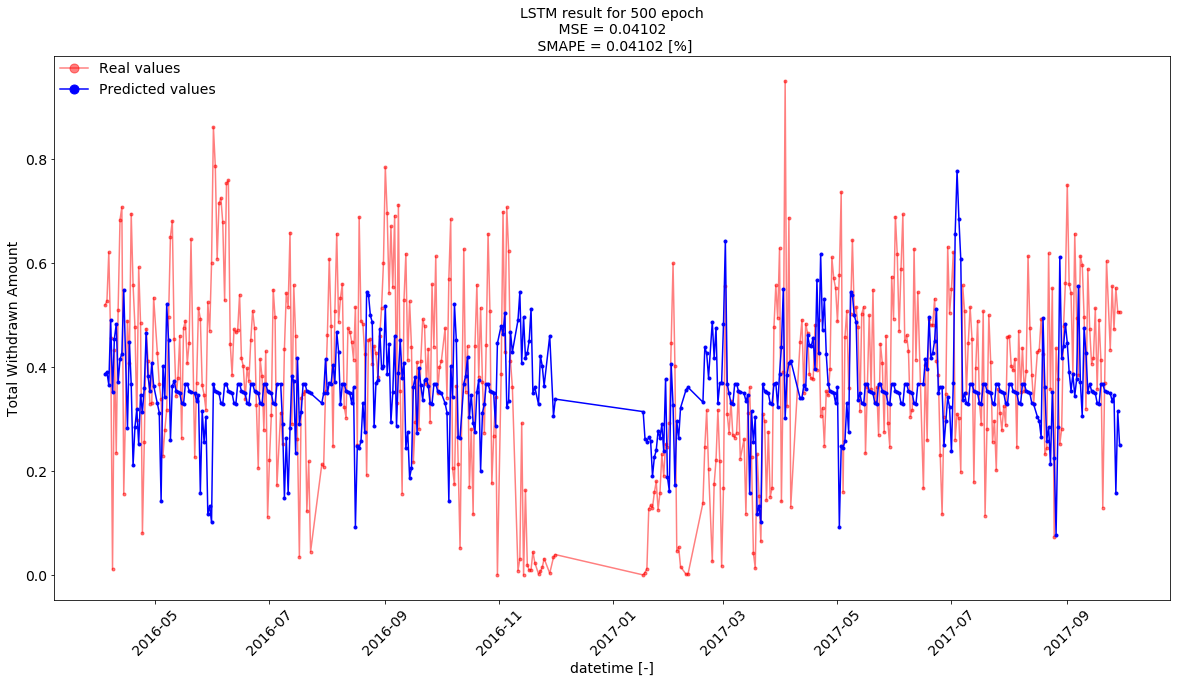

In [162]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'Total Withdrawn Amount' , fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result = model.evaluate(X_test, y_test)

plt.title('LSTM result for 500 epoch\n MSE = %.5f \n SMAPE = %.5f [%%]' % (mse_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

461/461 [==============================] - 0s 315us/step
FINISHED


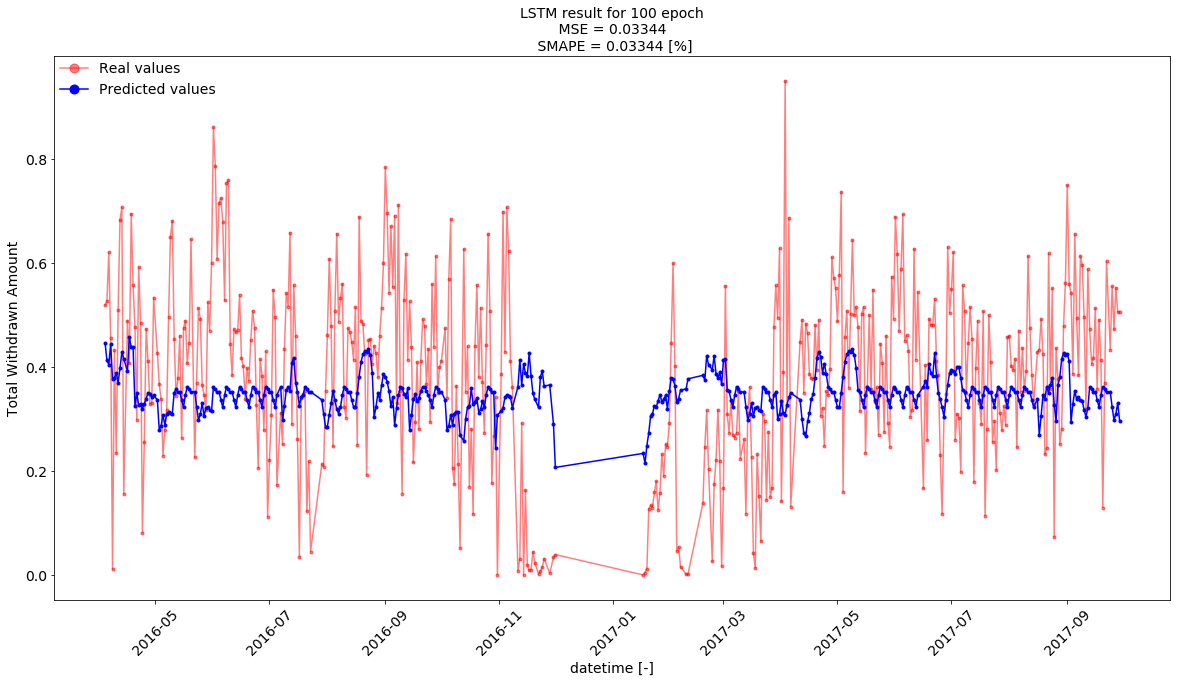

In [167]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'Total Withdrawn Amount' , fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result = model.evaluate(X_test, y_test)

plt.title('LSTM result for 100 epoch\n MSE = %.5f \n SMAPE = %.5f [%%]' % (mse_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

461/461 [==============================] - 0s 922us/step
FINISHED


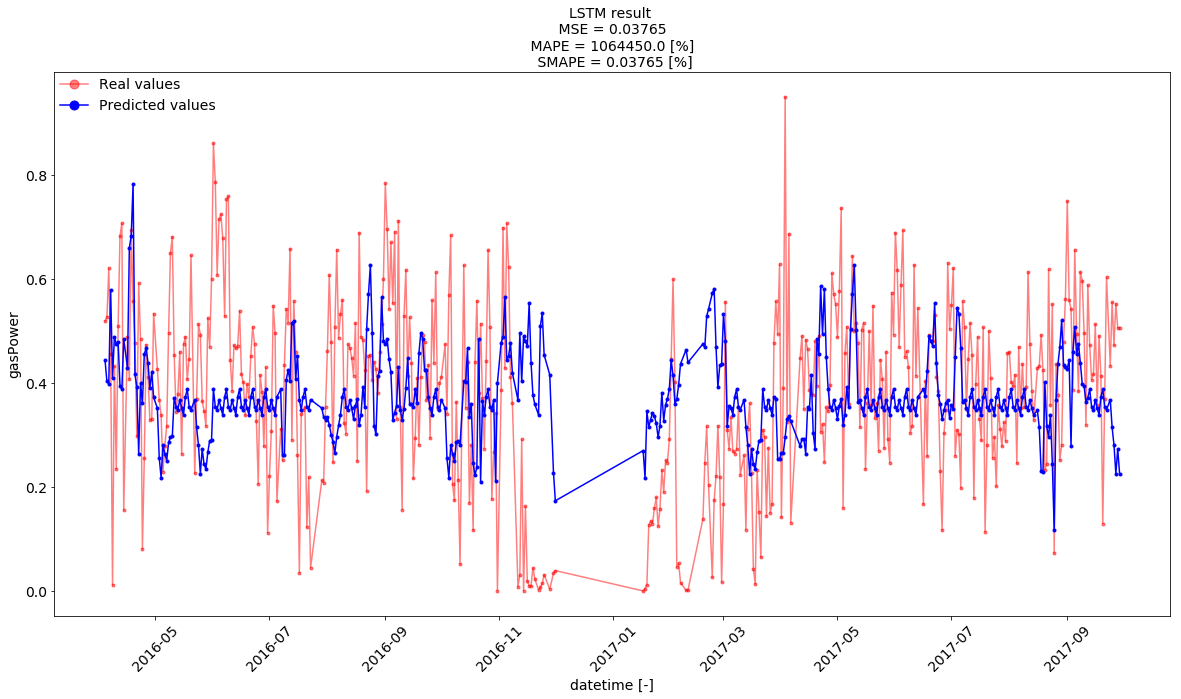

In [88]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'gasPower' , fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result = model.evaluate(X_test, y_test)

plt.title('200 LSTM with 500 epoch result \n MSE = %.5f \n MAPE = %.1f [%%] \n SMAPE = %.5f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

461/461 [==============================] - 0s 825us/step
FINISHED


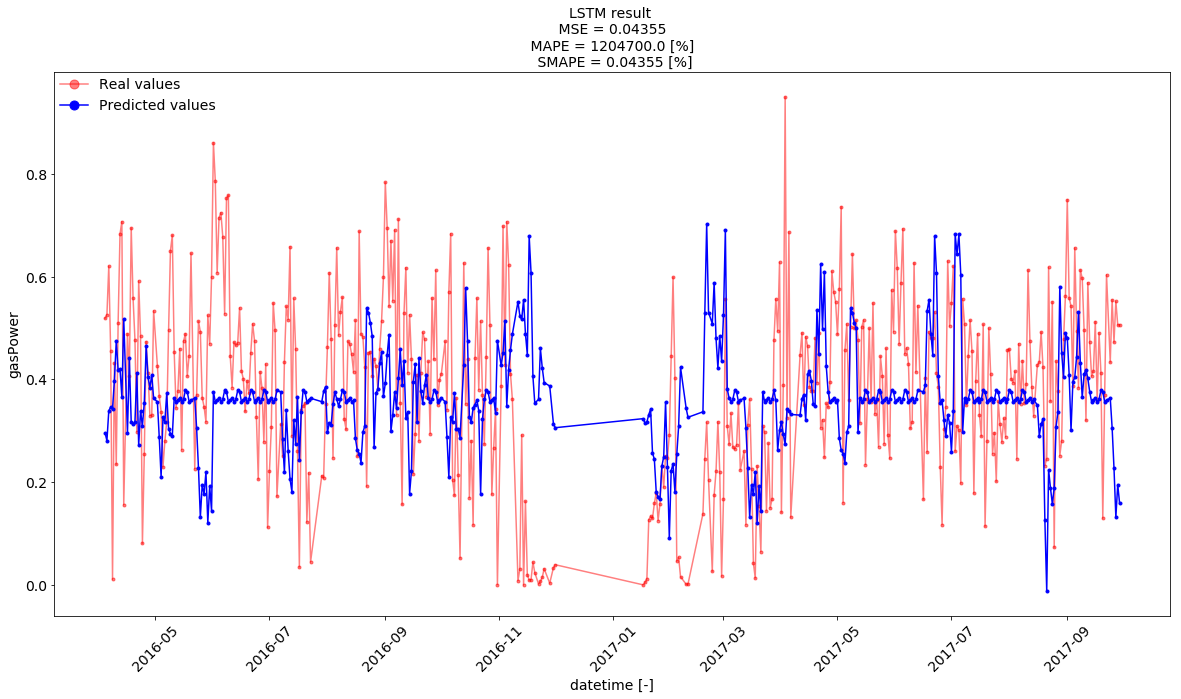

In [85]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'gasPower' , fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result = model.evaluate(X_test, y_test)

plt.title('LSTM result \n MSE = %.5f \n MAPE = %.1f [%%] \n SMAPE = %.5f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

461/461 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 659us/step
FINISHED


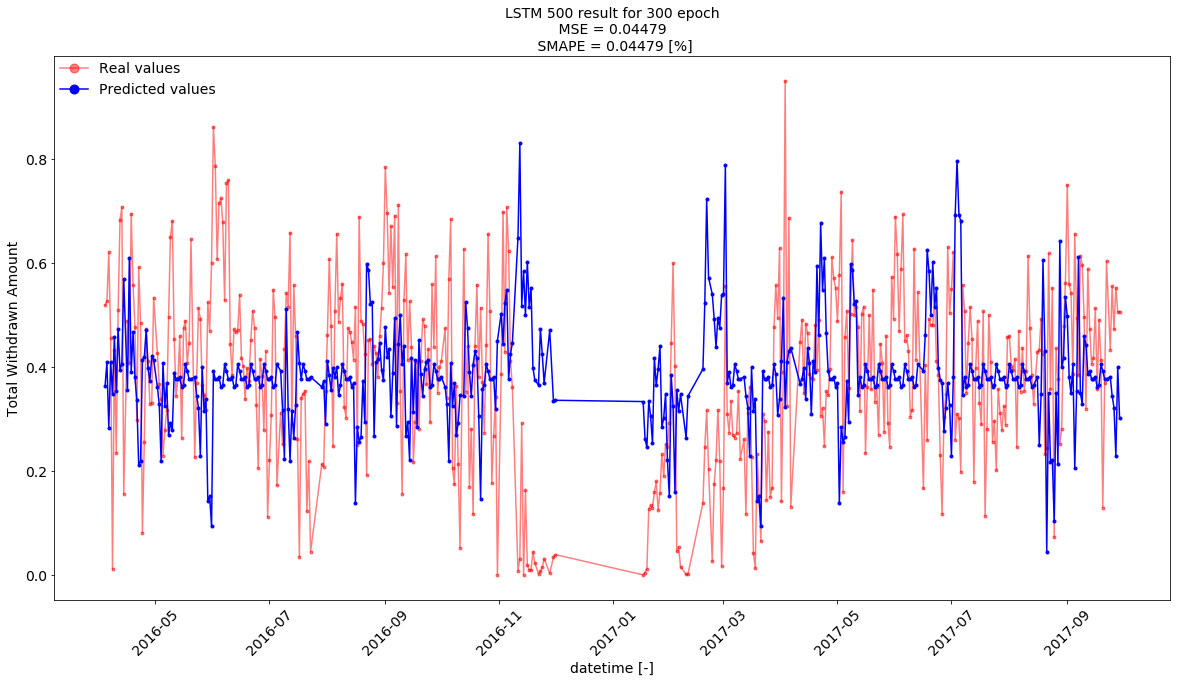

In [60]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'Total Withdrawn Amount' , fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result = model.evaluate(X_test, y_test)

plt.title('LSTM 500 result for 300 epoch\n MSE = %.5f \n SMAPE = %.5f [%%]' % (mse_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

In [ ]:
def downsample_results(x, y_pred, y_true, magnitude, resolution, model_name, savefig=False):
    """
    This function takes the hourly results and downsamples them to the given resolution.
    
    x, datetime values
    y_pred, y predictions
    y_true, y true values
    magnitude, scaling factor for y axis
    resolution, Pandas resample resolution e.g. 6H, D, W
    model_name, string containing model name, e.g. 'MVLR'
    savefig, wether to save the figure or not
    """

    # Make it a df to be able to downsample
    datetime = x.index
    print(datetime.shape)

    y_pred = y_pred.reshape(y_pred.shape[0])
    y_true = y_true.reshape(y_true.shape[0])

    results = pd.DataFrame(y_true, y_pred) # For some reason y_true becomes the index
    result = results.reset_index() # Ugly way to fix above problem
    result.columns = ['y_pred', 'y_true']

    result['datetime'] = datetime
    result = result.set_index(['datetime'])

    # Save the model results for later usage
    result.to_csv('models\\'+model_name+'_'+resolution+'_predictions.csv')

    result = result.resample(resolution).sum() # Resample data

    result = result.dropna()
    
    # Calculate evaluation metrics over the result

    ytrue = result['y_true']
    ypred = result['y_pred']
    n = len(result)

    # Recalculated the metrics for the downsampled results
    mse_result = (1/n)*np.sum((ypred - ytrue)**2)
    mape_result = (100/n) * np.sum(np.abs((ytrue - ypred) / ypred))
    smape_result = (100/n) * np.sum( np.abs((ytrue - ypred)) / (np.abs(ytrue) + np.abs(ypred)) )

    # Create plot
    plt.figure(figsize=(20,10))
    plt.plot(result.index, result['y_true'], '.-', color='red', label='Real values', alpha=0.5, ms=10) # ms is markersize
    plt.plot(result.index, result['y_pred'], '.-', color='blue', label='Predicted values', ms=10)

    plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
    plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

    plt.title(model_name+' hourly predictions downsampled to '+resolution+' resolution. \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)
    
    if savefig:
        plt.savefig('figures/MVLR_day.png', dpi=1300)

(461,)


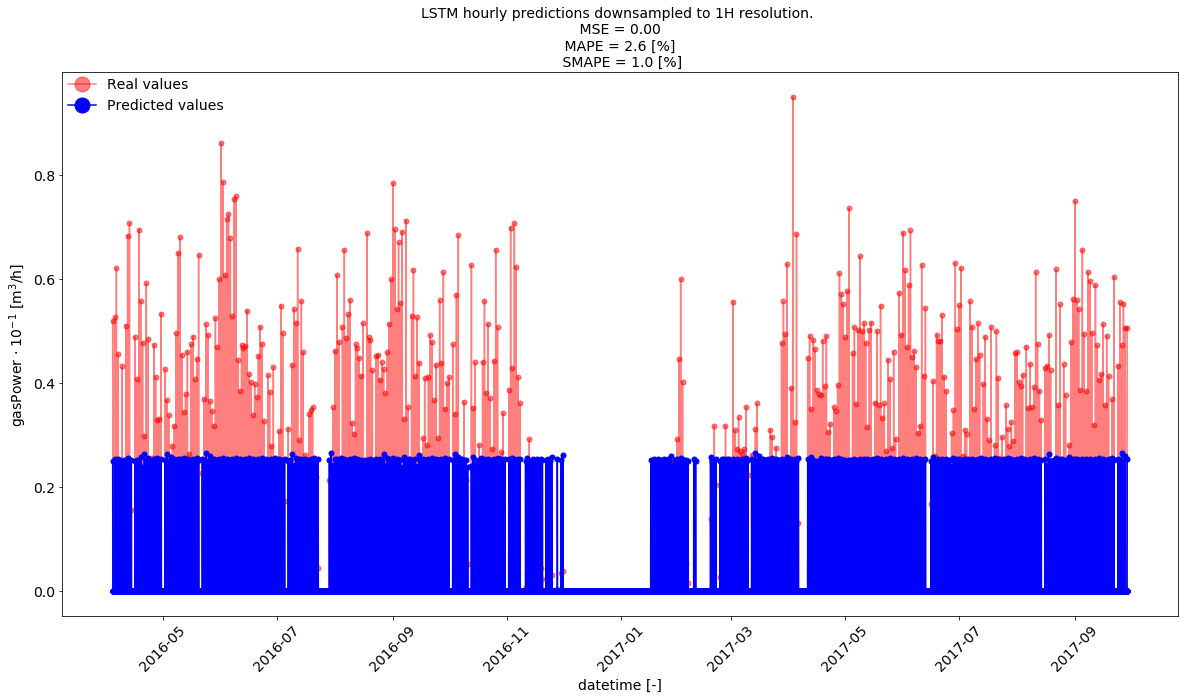

In [0]:
magnitude = 1
downsample_results(x, y_pred, y_true, magnitude=magnitude, resolution='1H', model_name='LSTM', savefig=False)

(461,)


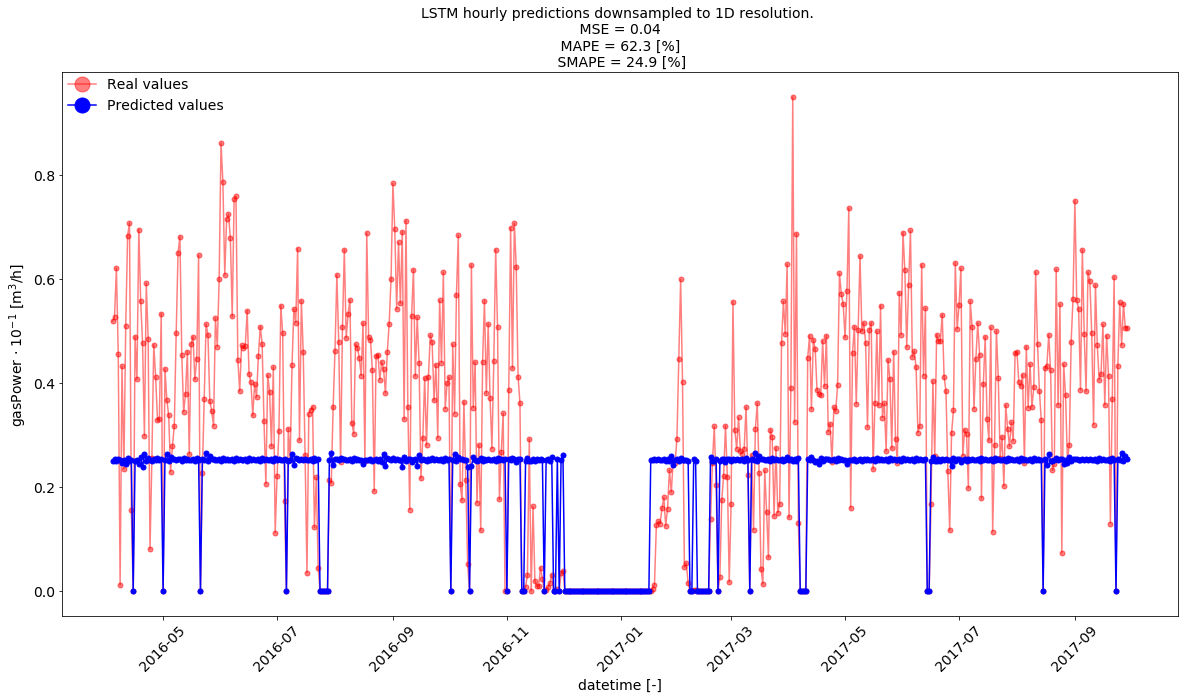

In [0]:
downsample_results(x, y_pred, y_true, magnitude=magnitude, resolution='1D', model_name='LSTM', savefig=False)

(461,)


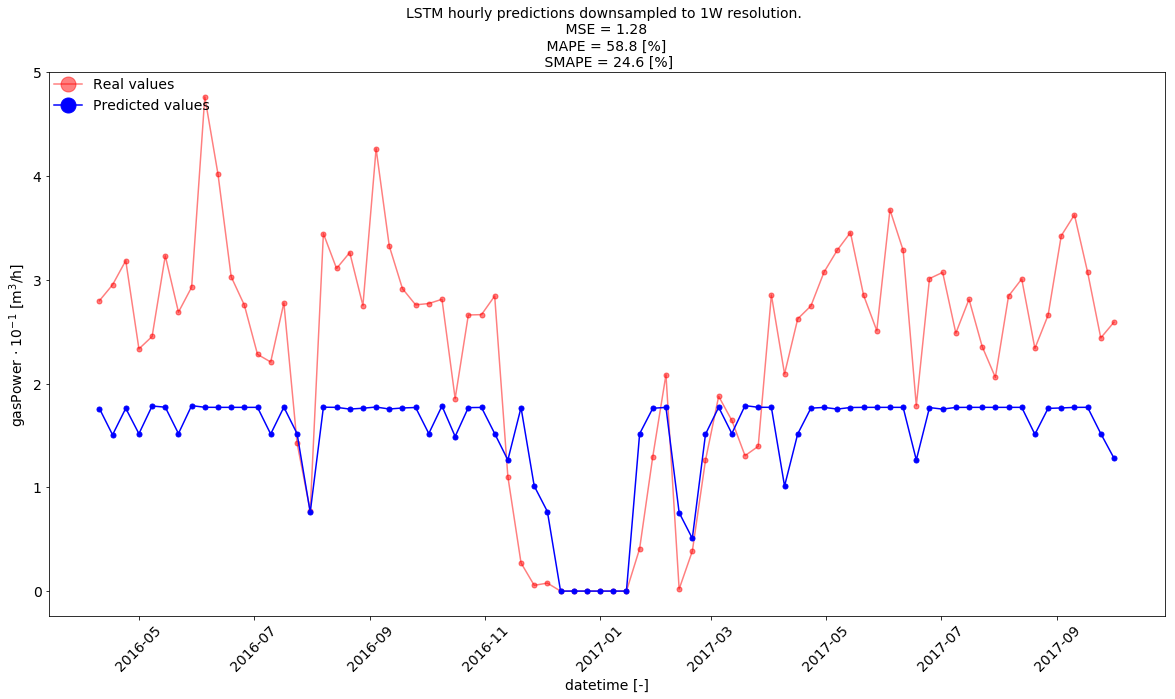

In [0]:
downsample_results(x, y_pred, y_true, magnitude=magnitude, resolution='1W', model_name='LSTM', savefig=False)